In [1]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [49]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)

np.random.shuffle(X_train.to_numpy()) #Randomly shuffle the training data for batching

train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

print("----------------Preprocessing the data-------------------")
X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

#Separating 15% of the training Data as Validation Dataset
X_valid = X_train.iloc[(int(0.85*m)):]
valid_class = train_class[(int(0.85*m)):]
X_train = X_train.iloc[0:int(0.85*m)]
train_class = train_class[0:int(0.85*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))
print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
----------------Preprocessing the data-------------------
The total number of training samples = 11050
The total number of validation samples = 1950
The number of features = 784


In [50]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()
print("--------------------Done----------------------------------")

--------Perform 1-hot encoding of class labels------------
--------------------Done----------------------------------


In [51]:
#Add the intercept term to the data samples both in training and test dataset
print("--------Adding the intercept term in the dataset as bias------------")
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))
print("-----------------------------Done----------------------------------")

--------Adding the intercept term in the dataset as bias------------
-----------------------------Done----------------------------------


In [52]:
#Mini-Batch formation

batch_size = 100 # Mini-Batch Size

print("----------------Forming mini-batches of size {}---------------------".format(batch_size))
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

----------------Forming mini-batches of size 100---------------------
The number of mini-batches formed is = 111


In [26]:
#Theta Initialization 

def theta_init(arch=[50], mode='normal'):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]
            dim1 = r
        else:
            dim0=arch[i-1]
            dim1= arch[i]
        if (mode=='normal'):
            theta.append(np.random.normal(0,0.01, (dim0,dim1)))
        elif(mode=='random'):
            theta.append(2*np.random.random((dim0, dim1))-1)
        #theta.append(np.zeros((dim0, dim1)))
    return theta

In [7]:
# Sigmoid activation function
def activation(x):
    return 1/(1+np.exp(-x))

#ReLU Activation Function
def relu_act(x):
    return np.maximum(0.0, x)

#Derivative of ReLU activation Function
def deriv_relu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def softplus(x):
    return np.log(1+np.exp(x))

def deriv_softplus(x):
    return 1/(1+np.exp(-x))

In [8]:
# Forward propagation

def forward_prop(data, theta, act_fn='sigmoid'):
    fm = []
    fm.append(data)
    if (act_fn == 'sigmoid'):
        for l in range(len(theta)):
            fm.append(activation(np.dot(fm[l], theta[l])))
    elif(act_fn == 'relu'):
        for l in range(len(theta)):
            if (l != len(theta)-1):
                fm.append(relu_act(np.dot(fm[l], theta[l])))
            else:
                fm.append(activation(np.dot(fm[l], theta[l])))
    elif(act_fn == 'softplus'):
        for l in range(len(theta)):
            if (l != len(theta)-1):
                fm.append(softplus(np.dot(fm[l], theta[l])))
            else:
                fm.append(activation(np.dot(fm[l], theta[l])))
    return fm

In [9]:
# Backward propagation
def backward_prop(fm, Y_b, theta, batch_size, act_fn='sigmoid', cost_fn='sqr_error'):
    delta = [None]*len(fm)
    for l in range(len(fm)-1, 0, -1):
        if (l == len(fm)-1):
            if (cost_fn=='entropy'):
                delta[l] = ((1/batch_size)*((Y_b/fm[l])-((1-Y_b)/(1-fm[l])))*fm[l]*(1-fm[l]))
            else:
                delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
        else:
            if (act_fn == 'sigmoid'):
                delta[l]=(np.dot(delta[l+1], theta[l].T)*fm[l]*(1-fm[l]))
            elif(act_fn == 'relu'):
                delta[l]=np.dot(delta[l+1], theta[l].T)*deriv_relu(fm[l])
            elif(act_fn=='softplus'):
                delta[l]=np.dot(delta[l+1], theta[l].T)*deriv_softplus(fm[l])
    return delta

In [10]:
def cost_total(X, theta, Y, m, act_fn='sigmoid', cost_fn='sqr_error'):
    fm = forward_prop(X, theta, act_fn)
    if (cost_fn == 'sqr_error'):
        cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    else:
        cost = -(1/m)*(np.sum(((Y*np.log(fm[-1]))+((1-Y)*(np.log(1-fm[-1]))))))
    return cost

In [11]:
def calc_accuracy(data, theta, actual_class, act_fn='sigmoid'):
    pred_class = forward_prop(data, theta, act_fn)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    return (test_acc*100)

## PART AB - One Hidden Layer Neural Network

In [47]:
def training(mini_batch, X_valid, valid_class_enc, theta, lr, act_fn='sigmoid', lr_mode='constant', cost_fn='sqr_error'):
    lr0=lr
    epoch = 1 # Number of epochs
    early_stop=0 #Early stop count of iteration
    
    cost_init = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0], act_fn, cost_fn)
    
    while(True):
        count_batch = 0
        print("Initial Cost on Val dataset for this epoch {} = {}".format(epoch, cost_init))
        
        if(lr_mode == "adaptive"):
            lr = lr0/(np.power(epoch, 1/2))
            print("learning rate for this epoch = ", lr)
        
        for b in mini_batch:
            X_b = b[0]
            Y_b = b[1]
        
            #Forward Propagation
            fm = forward_prop(X_b, theta, act_fn)
            
            if (count_batch % 60 == 0):
                print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size, act_fn, cost_fn)))
                    
            #Backward Propagation
            delta = [None]*len(fm)
            delta = backward_prop(fm, Y_b, theta, batch_size, act_fn, cost_fn)

            #Theta Update
            for t in range(len(theta)):
                theta[t] += lr*np.dot(fm[t].T, delta[t+1]) 

            count_batch+=1

        epoch+=1 #Number of epochs
        
        
        cost_final = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0], act_fn, cost_fn)
        print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
        #Stopping criteria for sigmoid - when Validation loss stops decreasing beyond a threshold for 10 epochs
        if (act_fn =='sigmoid'):
            if (abs(cost_final-cost_init) < 1e-06):
                early_stop +=1
            else:
                early_stop=0
            if (early_stop == 10):
                print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
                break
        
        #Stopping criteria for relu - when Validation loss increases continuously for 30 epochs
        elif(act_fn=='relu' or act_fn=='softplus'):
            if ((cost_final-cost_init) > 0):
                early_stop +=1
            else:
                early_stop=0
            if (early_stop == 30):
                print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
                break
        
        cost_init = cost_final
    return epoch, theta

In [14]:
def plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title("Accuracy with number of hidden units \n in one hidden layer network")
    ax.plot(arch_test, train_accuracy, marker='o', label='Train Accuracy')
    ax.plot(arch_test, valid_accuracy, marker='o',label='Validation Accuracy')
    ax.plot(arch_test, test_accuracy, marker='o', label='Test Accuracy')
    ax.set_xlabel("number of hidden units")
    ax.set_ylabel("Accuracy (%)")

    plt.legend()
    #plt.savefig("plots/partd/accuracy_val_normal_adapt_sqrt.png", dpi=1000, bbox_inches='tight')
    plt.show()

In [15]:
def plot_epoch(arch_test, epochs, train_time):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    plt.title("Epochs/Time with number of hidden units \n in one hidden layer network")
    ax.plot(arch_test, epochs, c='b', marker='o', label='#epochs')
    ax.set_xlabel("number of hidden units")
    ax.set_ylabel("Epochs")
    ax.legend()

    ax1 = fig.add_subplot(212)
    ax1.plot(arch_test, train_time, c='b', marker='o', label='train time')
    ax1.set_xlabel("number of hidden units")
    ax1.set_ylabel("train time(sec)")
    plt.legend()
    #plt.savefig("plots/partc/epochs_time_normal_adapt.png", dpi=1000, bbox_inches='tight')
    plt.show()

In [16]:
arch_test = [1,5,10,50,100] # Specifically for part a and b
arch = [50] #means one hidden layer with 50 perceptrons (DEFAULT)
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [17]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

lr=0.1

for i in range(len(arch_test)):
    #Choose between normal or random. Normal gives better results
    theta = theta_init([arch_test[i]], 'normal')
    #print(theta[0].shape, theta[1].shape, theta[2].shape)
    print("Training the network with {} hidden layer with {} units".format(len([arch_test[i]]), arch_test[i]))
    print("The parameters of the layers are of the shape:")

    for j in range(len(theta)):
        print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))

    start = time.time()
    epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'sigmoid')
    
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

Training the network with 1 hidden layer with 1 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 1)
theta between layer 1 and layer 2 is (1, 26)
Initial Cost on Val dataset for this epoch 1 = 3.2489791193361954
Error on this batch = 3.248857439310941
Error on this batch = 1.9804296278763998
Cost on val dataset after 2 epochs is = 1.3855093294767706
Initial Cost on Val dataset for this epoch 2 = 1.3855093294767706
Error on this batch = 1.385492769761742
Error on this batch = 1.0472463834569368
Cost on val dataset after 3 epochs is = 0.8914962884935206
Initial Cost on Val dataset for this epoch 3 = 0.8914962884935206
Error on this batch = 0.8916916870118561
Error on this batch = 0.7819960291167543
Cost on val dataset after 4 epochs is = 0.7207038391779884
Initial Cost on Val dataset for this epoch 4 = 0.7207038391779884
Error on this batch = 0.7208906499397076
Error on this batch = 0.6718143697160599
Cost on val dataset after 5 epochs is = 0

Cost on val dataset after 41 epochs is = 0.4838014151449029
Initial Cost on Val dataset for this epoch 41 = 0.4838014151449029
Error on this batch = 0.4837687650926529
Error on this batch = 0.4836974132374367
Cost on val dataset after 42 epochs is = 0.48363615747384725
Initial Cost on Val dataset for this epoch 42 = 0.48363615747384725
Error on this batch = 0.48360254002503944
Error on this batch = 0.48353711147648226
Cost on val dataset after 43 epochs is = 0.48348221196370056
Initial Cost on Val dataset for this epoch 43 = 0.48348221196370056
Error on this batch = 0.48344766004556067
Error on this batch = 0.4833876450204247
Cost on val dataset after 44 epochs is = 0.4833386178066502
Initial Cost on Val dataset for this epoch 44 = 0.4833386178066502
Error on this batch = 0.4833031622261476
Error on this batch = 0.4832481042752448
Cost on val dataset after 45 epochs is = 0.4832045132419186
Initial Cost on Val dataset for this epoch 45 = 0.4832045132419186
Error on this batch = 0.483168

Cost on val dataset after 81 epochs is = 0.4812676514885975
Initial Cost on Val dataset for this epoch 81 = 0.4812676514885975
Error on this batch = 0.48121054291254306
Error on this batch = 0.48121581351743814
Cost on val dataset after 82 epochs is = 0.4812494221477939
Initial Cost on Val dataset for this epoch 82 = 0.4812494221477939
Error on this batch = 0.4811919090139665
Error on this batch = 0.48119760989518484
Cost on val dataset after 83 epochs is = 0.48123199344235734
Initial Cost on Val dataset for this epoch 83 = 0.48123199344235734
Error on this batch = 0.4811740814628735
Error on this batch = 0.48118019241809573
Cost on val dataset after 84 epochs is = 0.4812153252078445
Initial Cost on Val dataset for this epoch 84 = 0.4812153252078445
Error on this batch = 0.48115701993949517
Error on this batch = 0.48116352195648804
Cost on val dataset after 85 epochs is = 0.4811993796138218
Initial Cost on Val dataset for this epoch 85 = 0.4811993796138218
Error on this batch = 0.48114

Cost on val dataset after 121 epochs is = 0.4809086436040466
Initial Cost on Val dataset for this epoch 121 = 0.4809086436040466
Error on this batch = 0.4808387289253633
Error on this batch = 0.4808525050635668
Cost on val dataset after 122 epochs is = 0.4809050578919999
Initial Cost on Val dataset for this epoch 122 = 0.4809050578919999
Error on this batch = 0.4808348910619412
Error on this batch = 0.4808487624767026
Cost on val dataset after 123 epochs is = 0.48090160416209243
Initial Cost on Val dataset for this epoch 123 = 0.48090160416209243
Error on this batch = 0.48083118776616723
Error on this batch = 0.48084515180319887
Cost on val dataset after 124 epochs is = 0.4808982772174536
Initial Cost on Val dataset for this epoch 124 = 0.4808982772174536
Error on this batch = 0.4808276138051653
Error on this batch = 0.4808416679192277
Cost on val dataset after 125 epochs is = 0.48089507208647025
Initial Cost on Val dataset for this epoch 125 = 0.48089507208647025
Error on this batch =

Cost on val dataset after 161 epochs is = 0.4808319746498706
Initial Cost on Val dataset for this epoch 161 = 0.4808319746498706
Error on this batch = 0.48075370318833344
Error on this batch = 0.4807699481075634
Cost on val dataset after 162 epochs is = 0.48083112950497353
Initial Cost on Val dataset for this epoch 162 = 0.48083112950497353
Error on this batch = 0.4807526881343233
Error on this batch = 0.48076897262995616
Cost on val dataset after 163 epochs is = 0.48083031367097495
Initial Cost on Val dataset for this epoch 163 = 0.48083031367097495
Error on this batch = 0.48075170402542383
Error on this batch = 0.48076802743842123
Cost on val dataset after 164 epochs is = 0.4808295261222839
Initial Cost on Val dataset for this epoch 164 = 0.4808295261222839
Error on this batch = 0.48075074982022975
Error on this batch = 0.4807671115094982
Cost on val dataset after 165 epochs is = 0.48082876587106504
Initial Cost on Val dataset for this epoch 165 = 0.48082876587106504
Error on this ba

Error on this batch = 0.48089890570042665
Cost on val dataset after 32 epochs is = 0.48087504849331575
Initial Cost on Val dataset for this epoch 32 = 0.48087504849331575
Error on this batch = 0.480852859559201
Error on this batch = 0.48089114737699207
Cost on val dataset after 33 epochs is = 0.4808698585497321
Initial Cost on Val dataset for this epoch 33 = 0.4808698585497321
Error on this batch = 0.4808467181623556
Error on this batch = 0.480884417085964
Cost on val dataset after 34 epochs is = 0.4808654699972501
Initial Cost on Val dataset for this epoch 34 = 0.4808654699972501
Error on this batch = 0.4808414224869975
Error on this batch = 0.48087855961870574
Cost on val dataset after 35 epochs is = 0.4808617539883376
Initial Cost on Val dataset for this epoch 35 = 0.4808617539883376
Error on this batch = 0.4808368412654614
Error on this batch = 0.48087344534003945
Cost on val dataset after 36 epochs is = 0.480858603426693
Initial Cost on Val dataset for this epoch 36 = 0.4808586034

Cost on val dataset after 16 epochs is = 0.4810217669086703
Initial Cost on Val dataset for this epoch 16 = 0.4810217669086703
Error on this batch = 0.48105378736585325
Error on this batch = 0.4811857245840828
Cost on val dataset after 17 epochs is = 0.4810077523941309
Initial Cost on Val dataset for this epoch 17 = 0.4810077523941309
Error on this batch = 0.48103872433195494
Error on this batch = 0.4811666839904089
Cost on val dataset after 18 epochs is = 0.48099736731701104
Initial Cost on Val dataset for this epoch 18 = 0.48099736731701104
Error on this batch = 0.4810273327487153
Error on this batch = 0.4811516969439921
Cost on val dataset after 19 epochs is = 0.4809895691023066
Initial Cost on Val dataset for this epoch 19 = 0.4809895691023066
Error on this batch = 0.481018570998093
Error on this batch = 0.4811397207506032
Cost on val dataset after 20 epochs is = 0.4809836300863138
Initial Cost on Val dataset for this epoch 20 = 0.4809836300863138
Error on this batch = 0.4810117114

Cost on val dataset after 13 epochs is = 0.4816791327667734
Initial Cost on Val dataset for this epoch 13 = 0.4816791327667734
Error on this batch = 0.4816421351161085
Error on this batch = 0.4821966515186077
Cost on val dataset after 14 epochs is = 0.48167341366802996
Initial Cost on Val dataset for this epoch 14 = 0.48167341366802996
Error on this batch = 0.4816350779285002
Error on this batch = 0.4821928636202791
Cost on val dataset after 15 epochs is = 0.48166774759226305
Initial Cost on Val dataset for this epoch 15 = 0.48166774759226305
Error on this batch = 0.48162801267653677
Error on this batch = 0.48218855527910065
Cost on val dataset after 16 epochs is = 0.48166207718497045
Initial Cost on Val dataset for this epoch 16 = 0.48166207718497045
Error on this batch = 0.48162093007252443
Error on this batch = 0.48218375925399615
Cost on val dataset after 17 epochs is = 0.48165636730729827
Initial Cost on Val dataset for this epoch 17 = 0.48165636730729827
Error on this batch = 0.4

Cost on val dataset after 53 epochs is = 0.4813317283809287
Initial Cost on Val dataset for this epoch 53 = 0.4813317283809287
Error on this batch = 0.48124041181636
Error on this batch = 0.4818453448903604
Cost on val dataset after 54 epochs is = 0.48131591380415495
Initial Cost on Val dataset for this epoch 54 = 0.48131591380415495
Error on this batch = 0.4812230728963768
Error on this batch = 0.48183060671870936
Cost on val dataset after 55 epochs is = 0.48129940639503815
Initial Cost on Val dataset for this epoch 55 = 0.48129940639503815
Error on this batch = 0.48120502008307675
Error on this batch = 0.4818153290495867
Cost on val dataset after 56 epochs is = 0.4812821624311889
Initial Cost on Val dataset for this epoch 56 = 0.4812821624311889
Error on this batch = 0.4811862080650212
Error on this batch = 0.48179947859238875
Cost on val dataset after 57 epochs is = 0.48126413516414396
Initial Cost on Val dataset for this epoch 57 = 0.48126413516414396
Error on this batch = 0.481166

Error on this batch = 0.48023551154754596
Cost on val dataset after 93 epochs is = 0.47919620386023626
Initial Cost on Val dataset for this epoch 93 = 0.47919620386023626
Error on this batch = 0.47900961815884024
Error on this batch = 0.4801311779392907
Cost on val dataset after 94 epochs is = 0.47904778211446464
Initial Cost on Val dataset for this epoch 94 = 0.47904778211446464
Error on this batch = 0.4788581943179058
Error on this batch = 0.48002025024181577
Cost on val dataset after 95 epochs is = 0.47888893167328
Initial Cost on Val dataset for this epoch 95 = 0.47888893167328
Error on this batch = 0.47869650627010196
Error on this batch = 0.47990226937290936
Cost on val dataset after 96 epochs is = 0.47871881289503954
Initial Cost on Val dataset for this epoch 96 = 0.47871881289503954
Error on this batch = 0.4785237690042494
Error on this batch = 0.47977674383092594
Cost on val dataset after 97 epochs is = 0.4785365110391842
Initial Cost on Val dataset for this epoch 97 = 0.47853

Cost on val dataset after 132 epochs is = 0.45513771296210703
Initial Cost on Val dataset for this epoch 132 = 0.45513771296210703
Error on this batch = 0.4547129626591693
Error on this batch = 0.46362296599583025
Cost on val dataset after 133 epochs is = 0.4538593284373146
Initial Cost on Val dataset for this epoch 133 = 0.4538593284373146
Error on this batch = 0.45328120470681327
Error on this batch = 0.46255659442150204
Cost on val dataset after 134 epochs is = 0.4525282657741105
Initial Cost on Val dataset for this epoch 134 = 0.4525282657741105
Error on this batch = 0.4517705669276625
Error on this batch = 0.4614191827949317
Cost on val dataset after 135 epochs is = 0.4511387854751186
Initial Cost on Val dataset for this epoch 135 = 0.4511387854751186
Error on this batch = 0.45017349080083224
Error on this batch = 0.46020451680583235
Cost on val dataset after 136 epochs is = 0.4496853895518819
Initial Cost on Val dataset for this epoch 136 = 0.4496853895518819
Error on this batch 

Error on this batch = 0.38580753244534666
Cost on val dataset after 171 epochs is = 0.37218794432018604
Initial Cost on Val dataset for this epoch 171 = 0.37218794432018604
Error on this batch = 0.3667226903751824
Error on this batch = 0.38335952852331107
Cost on val dataset after 172 epochs is = 0.3695923333120459
Initial Cost on Val dataset for this epoch 172 = 0.3695923333120459
Error on this batch = 0.3642708839396406
Error on this batch = 0.38092802634101286
Cost on val dataset after 173 epochs is = 0.36700538798271076
Initial Cost on Val dataset for this epoch 173 = 0.36700538798271076
Error on this batch = 0.36182735229100815
Error on this batch = 0.37851240301539063
Cost on val dataset after 174 epochs is = 0.36442787214391464
Initial Cost on Val dataset for this epoch 174 = 0.36442787214391464
Error on this batch = 0.3593918517682548
Error on this batch = 0.3761124467739962
Cost on val dataset after 175 epochs is = 0.3618609111862368
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.30400430466798634
Cost on val dataset after 210 epochs is = 0.2836017930897317
Initial Cost on Val dataset for this epoch 210 = 0.2836017930897317
Error on this batch = 0.283416432899577
Error on this batch = 0.302231370892566
Cost on val dataset after 211 epochs is = 0.281671293648976
Initial Cost on Val dataset for this epoch 211 = 0.281671293648976
Error on this batch = 0.2817085919290042
Error on this batch = 0.30046525986718037
Cost on val dataset after 212 epochs is = 0.27975576845823635
Initial Cost on Val dataset for this epoch 212 = 0.27975576845823635
Error on this batch = 0.2800224301276718
Error on this batch = 0.29870524959813133
Cost on val dataset after 213 epochs is = 0.27785522137248686
Initial Cost on Val dataset for this epoch 213 = 0.27785522137248686
Error on this batch = 0.27835771670399617
Error on this batch = 0.2969506938305798
Cost on val dataset after 214 epochs is = 0.275969648325628
Initial Cost on Val dataset for this epoch 214 = 0.

Error on this batch = 0.23853946401138332
Cost on val dataset after 250 epochs is = 0.21850659653028043
Initial Cost on Val dataset for this epoch 250 = 0.21850659653028043
Error on this batch = 0.22843319956126934
Error on this batch = 0.23718239260886329
Cost on val dataset after 251 epochs is = 0.21722800060529637
Initial Cost on Val dataset for this epoch 251 = 0.21722800060529637
Error on this batch = 0.22735107270266908
Error on this batch = 0.23584471885356573
Cost on val dataset after 252 epochs is = 0.21596739189981726
Initial Cost on Val dataset for this epoch 252 = 0.21596739189981726
Error on this batch = 0.22628150231619906
Error on this batch = 0.23452633152605273
Cost on val dataset after 253 epochs is = 0.21472467740796825
Initial Cost on Val dataset for this epoch 253 = 0.21472467740796825
Error on this batch = 0.2252242605405112
Error on this batch = 0.2332270871603955
Cost on val dataset after 254 epochs is = 0.21349975055872286
Initial Cost on Val dataset for this e

Error on this batch = 0.19717528451137825
Cost on val dataset after 290 epochs is = 0.17978445100206383
Initial Cost on Val dataset for this epoch 290 = 0.17978445100206383
Error on this batch = 0.19339691690261654
Error on this batch = 0.1964110541661129
Cost on val dataset after 291 epochs is = 0.17908798037407545
Initial Cost on Val dataset for this epoch 291 = 0.17908798037407545
Error on this batch = 0.1927149010489186
Error on this batch = 0.19565649665609874
Cost on val dataset after 292 epochs is = 0.17840176041044428
Initial Cost on Val dataset for this epoch 292 = 0.17840176041044428
Error on this batch = 0.19204148256180875
Error on this batch = 0.19491139407039826
Cost on val dataset after 293 epochs is = 0.1777255878952549
Initial Cost on Val dataset for this epoch 293 = 0.1777255878952549
Error on this batch = 0.19137656907099834
Error on this batch = 0.19417553354003644
Cost on val dataset after 294 epochs is = 0.1770592625846522
Initial Cost on Val dataset for this epoc

Cost on val dataset after 329 epochs is = 0.15863562536640222
Initial Cost on Val dataset for this epoch 329 = 0.15863562536640222
Error on this batch = 0.17213298893798346
Error on this batch = 0.17245484882112735
Cost on val dataset after 330 epochs is = 0.15821888654624175
Initial Cost on Val dataset for this epoch 330 = 0.15821888654624175
Error on this batch = 0.17170093644466364
Error on this batch = 0.17195558699420374
Cost on val dataset after 331 epochs is = 0.1578069086577733
Initial Cost on Val dataset for this epoch 331 = 0.1578069086577733
Error on this batch = 0.17127303072910258
Error on this batch = 0.17146085762334654
Cost on val dataset after 332 epochs is = 0.15739960790456137
Initial Cost on Val dataset for this epoch 332 = 0.15739960790456137
Error on this batch = 0.17084917759980697
Error on this batch = 0.17097060063538563
Cost on val dataset after 333 epochs is = 0.1569969025314607
Initial Cost on Val dataset for this epoch 333 = 0.1569969025314607
Error on this

Cost on val dataset after 369 epochs is = 0.1450045427420769
Initial Cost on Val dataset for this epoch 369 = 0.1450045427420769
Error on this batch = 0.15730991816050074
Error on this batch = 0.15553996539065862
Cost on val dataset after 370 epochs is = 0.1447285352592451
Initial Cost on Val dataset for this epoch 370 = 0.1447285352592451
Error on this batch = 0.15698652811253958
Error on this batch = 0.15518620704617336
Cost on val dataset after 371 epochs is = 0.14445506747892842
Initial Cost on Val dataset for this epoch 371 = 0.14445506747892842
Error on this batch = 0.15666473325703786
Error on this batch = 0.15483531232635134
Cost on val dataset after 372 epochs is = 0.1441841040668788
Initial Cost on Val dataset for this epoch 372 = 0.1441841040668788
Error on this batch = 0.1563444951100713
Error on this batch = 0.1544872479245916
Cost on val dataset after 373 epochs is = 0.14391561032700398
Initial Cost on Val dataset for this epoch 373 = 0.14391561032700398
Error on this bat

Cost on val dataset after 409 epochs is = 0.13564501298346593
Initial Cost on Val dataset for this epoch 409 = 0.13564501298346593
Error on this batch = 0.14532339424589127
Error on this batch = 0.14331630596616532
Cost on val dataset after 410 epochs is = 0.13544808175375034
Initial Cost on Val dataset for this epoch 410 = 0.13544808175375034
Error on this batch = 0.1450429305183944
Error on this batch = 0.1430535812042064
Cost on val dataset after 411 epochs is = 0.13525264690414074
Initial Cost on Val dataset for this epoch 411 = 0.13525264690414074
Error on this batch = 0.14476323665807017
Error on this batch = 0.14279259193760413
Cost on val dataset after 412 epochs is = 0.1350586895491658
Initial Cost on Val dataset for this epoch 412 = 0.1350586895491658
Error on this batch = 0.14448430986241484
Error on this batch = 0.14253331612466655
Cost on val dataset after 413 epochs is = 0.13486619107005288
Initial Cost on Val dataset for this epoch 413 = 0.13486619107005288
Error on this

Error on this batch = 0.1341797886034645
Cost on val dataset after 449 epochs is = 0.12877088803199688
Initial Cost on Val dataset for this epoch 449 = 0.12877088803199688
Error on this batch = 0.134728672332196
Error on this batch = 0.133971165701282
Cost on val dataset after 450 epochs is = 0.12862146881076408
Initial Cost on Val dataset for this epoch 450 = 0.12862146881076408
Error on this batch = 0.1344816951528918
Error on this batch = 0.1337636342137182
Cost on val dataset after 451 epochs is = 0.12847297276030986
Initial Cost on Val dataset for this epoch 451 = 0.12847297276030986
Error on this batch = 0.13423567580694665
Error on this batch = 0.13355718251705587
Cost on val dataset after 452 epochs is = 0.1283253897005677
Initial Cost on Val dataset for this epoch 452 = 0.1283253897005677
Error on this batch = 0.13399061840466484
Error on this batch = 0.13335179916879572
Cost on val dataset after 453 epochs is = 0.12817870961940966
Initial Cost on Val dataset for this epoch 45

Error on this batch = 0.1265848526451661
Cost on val dataset after 489 epochs is = 0.12342713652912267
Initial Cost on Val dataset for this epoch 489 = 0.12342713652912267
Error on this batch = 0.12560337644894712
Error on this batch = 0.12641220141698076
Cost on val dataset after 490 epochs is = 0.12330811160386349
Initial Cost on Val dataset for this epoch 490 = 0.12330811160386349
Error on this batch = 0.12539435996197257
Error on this batch = 0.1262402761464894
Cost on val dataset after 491 epochs is = 0.12318970692030329
Initial Cost on Val dataset for this epoch 491 = 0.12318970692030329
Error on this batch = 0.12518620379703715
Error on this batch = 0.12606906947437338
Cost on val dataset after 492 epochs is = 0.12307191698274003
Initial Cost on Val dataset for this epoch 492 = 0.12307191698274003
Error on this batch = 0.12497890107240892
Error on this batch = 0.12589857410253955
Cost on val dataset after 493 epochs is = 0.12295473636892681
Initial Cost on Val dataset for this e

Error on this batch = 0.12017764305024742
Cost on val dataset after 529 epochs is = 0.11910150920226192
Initial Cost on Val dataset for this epoch 529 = 0.11910150920226192
Error on this batch = 0.11784447340859007
Error on this batch = 0.12002885848056917
Cost on val dataset after 530 epochs is = 0.11900362114284242
Initial Cost on Val dataset for this epoch 530 = 0.11900362114284242
Error on this batch = 0.11766446621640457
Error on this batch = 0.11988054994991848
Cost on val dataset after 531 epochs is = 0.11890617930221303
Initial Cost on Val dataset for this epoch 531 = 0.11890617930221303
Error on this batch = 0.1174850531604768
Error on this batch = 0.11973271235490426
Cost on val dataset after 532 epochs is = 0.1188091802884357
Initial Cost on Val dataset for this epoch 532 = 0.1188091802884357
Error on this batch = 0.11730622878375298
Error on this batch = 0.11958534064861077
Cost on val dataset after 533 epochs is = 0.11871262074667703
Initial Cost on Val dataset for this ep

Error on this batch = 0.11455238539207856
Cost on val dataset after 569 epochs is = 0.11550359652164496
Initial Cost on Val dataset for this epoch 569 = 0.11550359652164496
Error on this batch = 0.11106089558752316
Error on this batch = 0.11441923018614639
Cost on val dataset after 570 epochs is = 0.11542123462946982
Initial Cost on Val dataset for this epoch 570 = 0.11542123462946982
Error on this batch = 0.11090116722503593
Error on this batch = 0.11428639206761576
Cost on val dataset after 571 epochs is = 0.11533920766381116
Initial Cost on Val dataset for this epoch 571 = 0.11533920766381116
Error on this batch = 0.11074187415953107
Error on this batch = 0.11415386827959907
Cost on val dataset after 572 epochs is = 0.11525751337484284
Initial Cost on Val dataset for this epoch 572 = 0.11525751337484284
Error on this batch = 0.11058301381530214
Error on this batch = 0.11402165612555976
Cost on val dataset after 573 epochs is = 0.11517614953396182
Initial Cost on Val dataset for this

Error on this batch = 0.10945170394497065
Cost on val dataset after 609 epochs is = 0.11244990209435445
Initial Cost on Val dataset for this epoch 609 = 0.11244990209435445
Error on this batch = 0.1049903791212739
Error on this batch = 0.10932966443087114
Cost on val dataset after 610 epochs is = 0.1123793686024993
Initial Cost on Val dataset for this epoch 610 = 0.1123793686024993
Error on this batch = 0.10484652410260868
Error on this batch = 0.10920787684757954
Cost on val dataset after 611 epochs is = 0.11230909414098883
Initial Cost on Val dataset for this epoch 611 = 0.11230909414098883
Error on this batch = 0.10470303592087332
Error on this batch = 0.10908634063117596
Cost on val dataset after 612 epochs is = 0.11223907712538984
Initial Cost on Val dataset for this epoch 612 = 0.11223907712538984
Error on this batch = 0.10455991351224529
Error on this batch = 0.1089650552593861
Cost on val dataset after 613 epochs is = 0.11216931598411375
Initial Cost on Val dataset for this epo

Error on this batch = 0.10476409154124071
Cost on val dataset after 649 epochs is = 0.10981604534384468
Initial Cost on Val dataset for this epoch 649 = 0.10981604534384468
Error on this batch = 0.0995130511564351
Error on this batch = 0.10465199192966232
Cost on val dataset after 650 epochs is = 0.10975475322884805
Initial Cost on Val dataset for this epoch 650 = 0.10975475322884805
Error on this batch = 0.09938316201288412
Error on this batch = 0.10454014219381233
Cost on val dataset after 651 epochs is = 0.10969366565265086
Initial Cost on Val dataset for this epoch 651 = 0.10969366565265086
Error on this batch = 0.099253605200424
Error on this batch = 0.10442854247471083
Cost on val dataset after 652 epochs is = 0.10963278146042328
Initial Cost on Val dataset for this epoch 652 = 0.10963278146042328
Error on this batch = 0.09912437992165579
Error on this batch = 0.10431719290609688
Cost on val dataset after 653 epochs is = 0.10957209950633229
Initial Cost on Val dataset for this ep

Error on this batch = 0.10047523661186224
Cost on val dataset after 689 epochs is = 0.10751326943946259
Initial Cost on Val dataset for this epoch 689 = 0.10751326943946259
Error on this batch = 0.09456854191481191
Error on this batch = 0.10037310498040043
Cost on val dataset after 690 epochs is = 0.10745934091549564
Initial Cost on Val dataset for this epoch 690 = 0.10745934091549564
Error on this batch = 0.0944512918959909
Error on this batch = 0.10027121687801235
Cost on val dataset after 691 epochs is = 0.10740557710274724
Initial Cost on Val dataset for this epoch 691 = 0.10740557710274724
Error on this batch = 0.09433433964480922
Error on this batch = 0.10016957175072529
Cost on val dataset after 692 epochs is = 0.10735197715545128
Initial Cost on Val dataset for this epoch 692 = 0.10735197715545128
Error on this batch = 0.09421768422319488
Error on this batch = 0.10006816902576926
Cost on val dataset after 693 epochs is = 0.10729854023429211
Initial Cost on Val dataset for this 

Error on this batch = 0.09657298765534783
Cost on val dataset after 729 epochs is = 0.10547679871468428
Initial Cost on Val dataset for this epoch 729 = 0.10547679871468428
Error on this batch = 0.09010134372544293
Error on this batch = 0.0964800157778608
Cost on val dataset after 730 epochs is = 0.10542885746453677
Initial Cost on Val dataset for this epoch 730 = 0.10542885746453677
Error on this batch = 0.08999525455294319
Error on this batch = 0.09638725467854134
Cost on val dataset after 731 epochs is = 0.10538105157188118
Initial Cost on Val dataset for this epoch 731 = 0.10538105157188118
Error on this batch = 0.0898894244708871
Error on this batch = 0.09629470338498408
Cost on val dataset after 732 epochs is = 0.10533338040641635
Initial Cost on Val dataset for this epoch 732 = 0.10533338040641635
Error on this batch = 0.08978385250949504
Error on this batch = 0.09620236092357826
Cost on val dataset after 733 epochs is = 0.10528584334224704
Initial Cost on Val dataset for this e

Error on this batch = 0.09300903300376323
Cost on val dataset after 769 epochs is = 0.10365887952288957
Initial Cost on Val dataset for this epoch 769 = 0.10365887952288957
Error on this batch = 0.08605041899849536
Error on this batch = 0.09292375292943103
Cost on val dataset after 770 epochs is = 0.10361590131323405
Initial Cost on Val dataset for this epoch 770 = 0.10361590131323405
Error on this batch = 0.08595395224703918
Error on this batch = 0.09283864698951953
Cost on val dataset after 771 epochs is = 0.10357303635785466
Initial Cost on Val dataset for this epoch 771 = 0.10357303635785466
Error on this batch = 0.0858577070956226
Error on this batch = 0.09275371439389772
Cost on val dataset after 772 epochs is = 0.10353028417851379
Initial Cost on Val dataset for this epoch 772 = 0.10353028417851379
Error on this batch = 0.08576168264934644
Error on this batch = 0.09266895436089097
Cost on val dataset after 773 epochs is = 0.10348764430030676
Initial Cost on Val dataset for this 

Error on this batch = 0.08972665867293249
Cost on val dataset after 809 epochs is = 0.1020236599436687
Initial Cost on Val dataset for this epoch 809 = 0.1020236599436687
Error on this batch = 0.08235596223842044
Error on this batch = 0.08964781579316894
Cost on val dataset after 810 epochs is = 0.10198487056690485
Initial Cost on Val dataset for this epoch 810 = 0.10198487056690485
Error on this batch = 0.08226768377153951
Error on this batch = 0.08956912243432572
Cost on val dataset after 811 epochs is = 0.10194617778401226
Initial Cost on Val dataset for this epoch 811 = 0.10194617778401226
Error on this batch = 0.08217959286083179
Error on this batch = 0.08949057816355939
Cost on val dataset after 812 epochs is = 0.10190758124012876
Initial Cost on Val dataset for this epoch 812 = 0.10190758124012876
Error on this batch = 0.08209168870034489
Error on this batch = 0.08941218255631547
Cost on val dataset after 813 epochs is = 0.1018690805832352
Initial Cost on Val dataset for this ep

Error on this batch = 0.08668599245907736
Cost on val dataset after 849 epochs is = 0.10054417253071797
Initial Cost on Val dataset for this epoch 849 = 0.10054417253071797
Error on this batch = 0.07896335749825477
Error on this batch = 0.08661286637822549
Cost on val dataset after 850 epochs is = 0.10050899687523444
Initial Cost on Val dataset for this epoch 850 = 0.10050899687523444
Error on this batch = 0.07888197478544179
Error on this batch = 0.08653987804017022
Cost on val dataset after 851 epochs is = 0.10047390568765865
Initial Cost on Val dataset for this epoch 851 = 0.10047390568765865
Error on this batch = 0.07880074917248316
Error on this batch = 0.08646702726665655
Cost on val dataset after 852 epochs is = 0.10043889871439039
Initial Cost on Val dataset for this epoch 852 = 0.10043889871439039
Error on this batch = 0.07871967994898987
Error on this batch = 0.08639431388347975
Cost on val dataset after 853 epochs is = 0.10040397570396366
Initial Cost on Val dataset for this

Error on this batch = 0.083866921011684
Cost on val dataset after 889 epochs is = 0.0992007054430267
Initial Cost on Val dataset for this epoch 889 = 0.0992007054430267
Error on this batch = 0.07582384415142768
Error on this batch = 0.08379919506641503
Cost on val dataset after 890 epochs is = 0.09916872964752137
Initial Cost on Val dataset for this epoch 890 = 0.09916872964752137
Error on this batch = 0.07574822180593853
Error on this batch = 0.08373160176715853
Cost on val dataset after 891 epochs is = 0.09913682960904856
Initial Cost on Val dataset for this epoch 891 = 0.09913682960904856
Error on this batch = 0.07567273063666949
Error on this batch = 0.08366414101108145
Cost on val dataset after 892 epochs is = 0.09910500514106045
Initial Cost on Val dataset for this epoch 892 = 0.09910500514106045
Error on this batch = 0.07559737006985862
Error on this batch = 0.08359681269523705
Cost on val dataset after 893 epochs is = 0.09907325605821174
Initial Cost on Val dataset for this epo

Error on this batch = 0.08126027519665327
Cost on val dataset after 929 epochs is = 0.0979790178052487
Initial Cost on Val dataset for this epoch 929 = 0.0979790178052487
Error on this batch = 0.07289598738526686
Error on this batch = 0.08119776764623193
Cost on val dataset after 930 epochs is = 0.09794993687699118
Initial Cost on Val dataset for this epoch 930 = 0.09794993687699118
Error on this batch = 0.07282520697630225
Error on this batch = 0.08113538791288258
Cost on val dataset after 931 epochs is = 0.09792092499403751
Initial Cost on Val dataset for this epoch 931 = 0.09792092499403751
Error on this batch = 0.07275453819448531
Error on this batch = 0.08107313584417938
Cost on val dataset after 932 epochs is = 0.09789198200385452
Initial Cost on Val dataset for this epoch 932 = 0.09789198200385452
Error on this batch = 0.07268398064503599
Error on this batch = 0.08101101128572476
Cost on val dataset after 933 epochs is = 0.09786310775446667
Initial Cost on Val dataset for this e

Error on this batch = 0.07885798046274141
Cost on val dataset after 969 epochs is = 0.09686817417568529
Initial Cost on Val dataset for this epoch 969 = 0.09686817417568529
Error on this batch = 0.07014836779982149
Error on this batch = 0.07880044683569958
Cost on val dataset after 970 epochs is = 0.09684174082030984
Initial Cost on Val dataset for this epoch 970 = 0.09684174082030984
Error on this batch = 0.0700817906541337
Error on this batch = 0.07874303337243957
Cost on val dataset after 971 epochs is = 0.09681537076478783
Initial Cost on Val dataset for this epoch 971 = 0.09681537076478783
Error on this batch = 0.07001531295703732
Error on this batch = 0.07868573984313203
Cost on val dataset after 972 epochs is = 0.09678906387320257
Initial Cost on Val dataset for this epoch 972 = 0.09678906387320257
Error on this batch = 0.06994893449542441
Error on this batch = 0.07862856601632154
Cost on val dataset after 973 epochs is = 0.09676282000995474
Initial Cost on Val dataset for this 

Error on this batch = 0.07664796182495717
Cost on val dataset after 1009 epochs is = 0.09585889840021189
Initial Cost on Val dataset for this epoch 1009 = 0.09585889840021189
Error on this batch = 0.06756110864812154
Error on this batch = 0.07659504194936273
Cost on val dataset after 1010 epochs is = 0.09583489394472774
Initial Cost on Val dataset for this epoch 1010 = 0.09583489394472774
Error on this batch = 0.06749838172575927
Error on this batch = 0.07654223205395785
Cost on val dataset after 1011 epochs is = 0.09581094757767454
Initial Cost on Val dataset for this epoch 1011 = 0.09581094757767454
Error on this batch = 0.06743574867688461
Error on this batch = 0.0764895318662045
Cost on val dataset after 1012 epochs is = 0.09578705917416844
Initial Cost on Val dataset for this epoch 1012 = 0.09578705917416844
Error on this batch = 0.06737320942982226
Error on this batch = 0.07643694111310287
Cost on val dataset after 1013 epochs is = 0.09576322860956474
Initial Cost on Val dataset 

Error on this batch = 0.07471200266414049
Cost on val dataset after 1047 epochs is = 0.09498652845286235
Initial Cost on Val dataset for this epoch 1047 = 0.09498652845286235
Error on this batch = 0.06524305306746837
Error on this batch = 0.07466306846292485
Cost on val dataset after 1048 epochs is = 0.09496464544195427
Initial Cost on Val dataset for this epoch 1048 = 0.09496464544195427
Error on this batch = 0.06518386263408601
Error on this batch = 0.07461423377414354
Cost on val dataset after 1049 epochs is = 0.0949428159256969
Initial Cost on Val dataset for this epoch 1049 = 0.0949428159256969
Error on this batch = 0.06512476488138999
Error on this batch = 0.07456549832465088
Cost on val dataset after 1050 epochs is = 0.09492103978688993
Initial Cost on Val dataset for this epoch 1050 = 0.09492103978688993
Error on this batch = 0.06506575980845822
Error on this batch = 0.07451686184165972
Cost on val dataset after 1051 epochs is = 0.09489931690849165
Initial Cost on Val dataset f

Error on this batch = 0.07292018809861608
Cost on val dataset after 1085 epochs is = 0.09419160258660088
Initial Cost on Val dataset for this epoch 1085 = 0.09419160258660088
Error on this batch = 0.06305900522581367
Error on this batch = 0.07287484716117486
Cost on val dataset after 1086 epochs is = 0.09417167114319007
Initial Cost on Val dataset for this epoch 1086 = 0.09417167114319007
Error on this batch = 0.0630033400152177
Error on this batch = 0.07282959569198351
Cost on val dataset after 1087 epochs is = 0.09415178883243538
Initial Cost on Val dataset for this epoch 1087 = 0.09415178883243538
Error on this batch = 0.06294776767735966
Error on this batch = 0.07278443343754329
Cost on val dataset after 1088 epochs is = 0.09413195554154029
Initial Cost on Val dataset for this epoch 1088 = 0.09413195554154029
Error on this batch = 0.06289228821241523
Error on this batch = 0.07273936014494382
Cost on val dataset after 1089 epochs is = 0.09411217115778436
Initial Cost on Val dataset 

Error on this batch = 0.0712580323451653
Cost on val dataset after 1123 epochs is = 0.093467801453731
Initial Cost on Val dataset for this epoch 1123 = 0.093467801453731
Error on this batch = 0.06100894302239352
Error on this batch = 0.07121591775101166
Cost on val dataset after 1124 epochs is = 0.09344965831435595
Initial Cost on Val dataset for this epoch 1124 = 0.09344965831435595
Error on this batch = 0.06095679803912292
Error on this batch = 0.07117388337851932
Cost on val dataset after 1125 epochs is = 0.09343156006650456
Initial Cost on Val dataset for this epoch 1125 = 0.09343156006650456
Error on this batch = 0.06090474512020399
Error on this batch = 0.07113192899375707
Cost on val dataset after 1126 epochs is = 0.09341350659973731
Initial Cost on Val dataset for this epoch 1126 = 0.09341350659973731
Error on this batch = 0.06085278421598568
Error on this batch = 0.07109005436317942
Cost on val dataset after 1127 epochs is = 0.09339549780368032
Initial Cost on Val dataset for 

Cost on val dataset after 1162 epochs is = 0.09279248078211627
Initial Cost on Val dataset for this epoch 1162 = 0.09279248078211627
Error on this batch = 0.0590429145733757
Error on this batch = 0.06963373901303158
Cost on val dataset after 1163 epochs is = 0.09277600733623706
Initial Cost on Val dataset for this epoch 1163 = 0.09277600733623706
Error on this batch = 0.05899430773906203
Error on this batch = 0.06959465371224377
Cost on val dataset after 1164 epochs is = 0.092759574542724
Initial Cost on Val dataset for this epoch 1164 = 0.092759574542724
Error on this batch = 0.05894578977298573
Error on this batch = 0.06955563947440897
Cost on val dataset after 1165 epochs is = 0.09274318229547815
Initial Cost on Val dataset for this epoch 1165 = 0.09274318229547815
Error on this batch = 0.05889736056009543
Error on this batch = 0.06951669607252009
Cost on val dataset after 1166 epochs is = 0.09272683048858177
Initial Cost on Val dataset for this epoch 1166 = 0.09272683048858177
Erro

Cost on val dataset after 1200 epochs is = 0.09219418921588325
Initial Cost on Val dataset for this epoch 1200 = 0.09219418921588325
Error on this batch = 0.057257252950259414
Error on this batch = 0.06819652384951885
Cost on val dataset after 1201 epochs is = 0.09217918786426944
Initial Cost on Val dataset for this epoch 1201 = 0.09217918786426944
Error on this batch = 0.057211930411915496
Error on this batch = 0.06815997721682325
Cost on val dataset after 1202 epochs is = 0.09216422330287956
Initial Cost on Val dataset for this epoch 1202 = 0.09216422330287956
Error on this batch = 0.057166691422919004
Error on this batch = 0.06812349279725202
Cost on val dataset after 1203 epochs is = 0.09214929543610312
Initial Cost on Val dataset for this epoch 1203 = 0.09214929543610312
Error on this batch = 0.05712153582119636
Error on this batch = 0.06808707034653384
Cost on val dataset after 1204 epochs is = 0.09213440416871185
Initial Cost on Val dataset for this epoch 1204 = 0.09213440416871

Cost on val dataset after 1238 epochs is = 0.09164922549000529
Initial Cost on Val dataset for this epoch 1238 = 0.09164922549000529
Error on this batch = 0.05559230505621155
Error on this batch = 0.06684934787488538
Cost on val dataset after 1239 epochs is = 0.09163555852895866
Initial Cost on Val dataset for this epoch 1239 = 0.09163555852895866
Error on this batch = 0.05555003688305365
Error on this batch = 0.06681498417682248
Cost on val dataset after 1240 epochs is = 0.09162192503178429
Initial Cost on Val dataset for this epoch 1240 = 0.09162192503178429
Error on this batch = 0.055507845580192096
Error on this batch = 0.06678067256922851
Cost on val dataset after 1241 epochs is = 0.09160832492024033
Initial Cost on Val dataset for this epoch 1241 = 0.09160832492024033
Error on this batch = 0.05546573096001725
Error on this batch = 0.06674641275714543
Cost on val dataset after 1242 epochs is = 0.09159475811657668
Initial Cost on Val dataset for this epoch 1242 = 0.0915947581165766

Error on this batch = 0.06554493671943033
Cost on val dataset after 1278 epochs is = 0.09112791826732299
Initial Cost on Val dataset for this epoch 1278 = 0.09112791826732299
Error on this batch = 0.05395963595622012
Error on this batch = 0.06551237192299317
Cost on val dataset after 1279 epochs is = 0.0911155332948307
Initial Cost on Val dataset for this epoch 1279 = 0.0911155332948307
Error on this batch = 0.05392029111180151
Error on this batch = 0.06547984664633714
Cost on val dataset after 1280 epochs is = 0.09110317898967112
Initial Cost on Val dataset for this epoch 1280 = 0.09110317898967112
Error on this batch = 0.05388101522366892
Error on this batch = 0.06544736054857457
Cost on val dataset after 1281 epochs is = 0.09109085528831491
Initial Cost on Val dataset for this epoch 1281 = 0.09109085528831491
Error on this batch = 0.053841808082910156
Error on this batch = 0.06541491328875372
Cost on val dataset after 1282 epochs is = 0.09107856212737699
Initial Cost on Val dataset 

Error on this batch = 0.06433242170647302
Cost on val dataset after 1316 epochs is = 0.09067831614284051
Initial Cost on Val dataset for this epoch 1316 = 0.09067831614284051
Error on this batch = 0.05251121171836485
Error on this batch = 0.0643011251544
Cost on val dataset after 1317 epochs is = 0.09066705207018444
Initial Cost on Val dataset for this epoch 1317 = 0.09066705207018444
Error on this batch = 0.052474336706476166
Error on this batch = 0.06426985588425095
Cost on val dataset after 1318 epochs is = 0.09065581623996001
Initial Cost on Val dataset for this epoch 1318 = 0.09065581623996001
Error on this batch = 0.05243752244839042
Error on this batch = 0.06423861361489747
Cost on val dataset after 1319 epochs is = 0.09064460858542811
Initial Cost on Val dataset for this epoch 1319 = 0.09064460858542811
Error on this batch = 0.0524007687259876
Error on this batch = 0.06420739806823579
Cost on val dataset after 1320 epochs is = 0.09063342903961513
Initial Cost on Val dataset for

Error on this batch = 0.06316019609540362
Cost on val dataset after 1354 epochs is = 0.0902695567775587
Initial Cost on Val dataset for this epoch 1354 = 0.0902695567775587
Error on this batch = 0.05115086458428382
Error on this batch = 0.06312976567939903
Cost on val dataset after 1355 epochs is = 0.090259317259638
Initial Cost on Val dataset for this epoch 1355 = 0.090259317259638
Error on this batch = 0.05111614917019414
Error on this batch = 0.06309935411531686
Cost on val dataset after 1356 epochs is = 0.09024910331833311
Initial Cost on Val dataset for this epoch 1356 = 0.09024910331833311
Error on this batch = 0.05108148664073065
Error on this batch = 0.06306896124106143
Cost on val dataset after 1357 epochs is = 0.09023891488191607
Initial Cost on Val dataset for this epoch 1357 = 0.09023891488191607
Error on this batch = 0.05104687680650828
Error on this batch = 0.06303858689716597
Cost on val dataset after 1358 epochs is = 0.09022875187872603
Initial Cost on Val dataset for t

Error on this batch = 0.06201589595584979
Cost on val dataset after 1392 epochs is = 0.0898978412982201
Initial Cost on Val dataset for this epoch 1392 = 0.0898978412982201
Error on this batch = 0.04986734632030071
Error on this batch = 0.06198608665600468
Cost on val dataset after 1393 epochs is = 0.08988852469770704
Initial Cost on Val dataset for this epoch 1393 = 0.08988852469770704
Error on this batch = 0.04983451738358647
Error on this batch = 0.061956291505052566
Cost on val dataset after 1394 epochs is = 0.08987923109116118
Initial Cost on Val dataset for this epoch 1394 = 0.08987923109116118
Error on this batch = 0.049801734969001143
Error on this batch = 0.061926510409373206
Cost on val dataset after 1395 epochs is = 0.08986996041691861
Initial Cost on Val dataset for this epoch 1395 = 0.08986996041691861
Error on this batch = 0.04976899893186234
Error on this batch = 0.06189674327644977
Cost on val dataset after 1396 epochs is = 0.0898607126137295
Initial Cost on Val dataset

Error on this batch = 0.0608923723117228
Cost on val dataset after 1430 epochs is = 0.08955948645190252
Initial Cost on Val dataset for this epoch 1430 = 0.08955948645190252
Error on this batch = 0.04865140752258024
Error on this batch = 0.06086304298353636
Cost on val dataset after 1431 epochs is = 0.08955100385502293
Initial Cost on Val dataset for this epoch 1431 = 0.08955100385502293
Error on this batch = 0.04862025328351954
Error on this batch = 0.0608337249010209
Cost on val dataset after 1432 epochs is = 0.08954254220412247
Initial Cost on Val dataset for this epoch 1432 = 0.08954254220412247
Error on this batch = 0.04858914076178946
Error on this batch = 0.0608044180040657
Cost on val dataset after 1433 epochs is = 0.08953410145275373
Initial Cost on Val dataset for this epoch 1433 = 0.08953410145275373
Error on this batch = 0.048558069847900676
Error on this batch = 0.06077512223336098
Cost on val dataset after 1434 epochs is = 0.08952568155475821
Initial Cost on Val dataset f

Error on this batch = 0.05978531489812795
Cost on val dataset after 1468 epochs is = 0.08925149506740239
Initial Cost on Val dataset for this epoch 1468 = 0.08925149506740239
Error on this batch = 0.04749600077066082
Error on this batch = 0.059756377270553086
Cost on val dataset after 1469 epochs is = 0.08924377708723394
Initial Cost on Val dataset for this epoch 1469 = 0.08924377708723394
Error on this batch = 0.047466360473636594
Error on this batch = 0.05972744914547855
Cost on val dataset after 1470 epochs is = 0.08923607835446622
Initial Cost on Val dataset for this epoch 1470 = 0.08923607835446622
Error on this batch = 0.04743675818555726
Error on this batch = 0.05969853049031024
Cost on val dataset after 1471 epochs is = 0.08922839882094326
Initial Cost on Val dataset for this epoch 1471 = 0.08922839882094326
Error on this batch = 0.04740719381941194
Error on this batch = 0.05966962127296053
Cost on val dataset after 1472 epochs is = 0.08922073843797151
Initial Cost on Val datas

Error on this batch = 0.058692116617795255
Cost on val dataset after 1506 epochs is = 0.08897127996327703
Initial Cost on Val dataset for this epoch 1506 = 0.08897127996327703
Error on this batch = 0.046395687967029586
Error on this batch = 0.05866351980956695
Cost on val dataset after 1507 epochs is = 0.08896425252105765
Initial Cost on Val dataset for this epoch 1507 = 0.08896425252105765
Error on this batch = 0.04636743453846396
Error on this batch = 0.058634931437395704
Cost on val dataset after 1508 epochs is = 0.08895724183834261
Initial Cost on Val dataset for this epoch 1508 = 0.08895724183834261
Error on this batch = 0.04633921612675166
Error on this batch = 0.05860635147365495
Cost on val dataset after 1509 epochs is = 0.08895024782403232
Initial Cost on Val dataset for this epoch 1509 = 0.08895024782403232
Error on this batch = 0.04631103266327855
Error on this batch = 0.05857777989068328
Cost on val dataset after 1510 epochs is = 0.08894327038544018
Initial Cost on Val data

Error on this batch = 0.057611155110737215
Cost on val dataset after 1544 epochs is = 0.08871513989599819
Initial Cost on Val dataset for this epoch 1544 = 0.08871513989599819
Error on this batch = 0.045346160673172785
Error on this batch = 0.057582862857280724
Cost on val dataset after 1545 epochs is = 0.08870867312904888
Initial Cost on Val dataset for this epoch 1545 = 0.08870867312904888
Error on this batch = 0.04531919752930216
Error on this batch = 0.057554578460065155
Cost on val dataset after 1546 epochs is = 0.08870221873687663
Initial Cost on Val dataset for this epoch 1546 = 0.08870221873687663
Error on this batch = 0.045292267513243355
Error on this batch = 0.057526301940905585
Cost on val dataset after 1547 epochs is = 0.08869577659100718
Initial Cost on Val dataset for this epoch 1547 = 0.08869577659100718
Error on this batch = 0.04526537060132094
Error on this batch = 0.05749803332524493
Cost on val dataset after 1548 epochs is = 0.0886893465633109
Initial Cost on Val da

Error on this batch = 0.05654208821148899
Cost on val dataset after 1582 epochs is = 0.08847708869583774
Initial Cost on Val dataset for this epoch 1582 = 0.08847708869583774
Error on this batch = 0.0443447549471893
Error on this batch = 0.05651414938637433
Cost on val dataset after 1583 epochs is = 0.08847101119603173
Initial Cost on Val dataset for this epoch 1583 = 0.08847101119603173
Error on this batch = 0.04431904547197313
Error on this batch = 0.05648622273262312
Cost on val dataset after 1584 epochs is = 0.0884649421346348
Initial Cost on Val dataset for this epoch 1584 = 0.0884649421346348
Error on this batch = 0.04429336909892882
Error on this batch = 0.056458308474318306
Cost on val dataset after 1585 epochs is = 0.08845888144960598
Initial Cost on Val dataset for this epoch 1585 = 0.08845888144960598
Error on this batch = 0.044267725841424785
Error on this batch = 0.056430406841003464
Cost on val dataset after 1586 epochs is = 0.08845282908145838
Initial Cost on Val dataset

Error on this batch = 0.055491198819656445
Cost on val dataset after 1620 epochs is = 0.08825173206967445
Initial Cost on Val dataset for this epoch 1620 = 0.08825173206967445
Error on this batch = 0.0433911589600479
Error on this batch = 0.055463916258845336
Cost on val dataset after 1621 epochs is = 0.08824595163345932
Initial Cost on Val dataset for this epoch 1621 = 0.08824595163345932
Error on this batch = 0.04336671394403956
Error on this batch = 0.0554366570318386
Cost on val dataset after 1622 epochs is = 0.08824017886724488
Initial Cost on Val dataset for this epoch 1622 = 0.08824017886724488
Error on this batch = 0.04334230223078535
Error on this batch = 0.05540942146340366
Cost on val dataset after 1623 epochs is = 0.08823441378509028
Initial Cost on Val dataset for this epoch 1623 = 0.08823441378509028
Error on this batch = 0.043317923810752536
Error on this batch = 0.0553822098774541
Cost on val dataset after 1624 epochs is = 0.08822865640217277
Initial Cost on Val dataset

Error on this batch = 0.05447346305204752
Cost on val dataset after 1658 epochs is = 0.08803764563569856
Initial Cost on Val dataset for this epoch 1658 = 0.08803764563569856
Error on this batch = 0.04248551630431077
Error on this batch = 0.0544472770444636
Cost on val dataset after 1659 epochs is = 0.08803217266597739
Initial Cost on Val dataset for this epoch 1659 = 0.08803217266597739
Error on this batch = 0.04246232300228611
Error on this batch = 0.05442112488955164
Cost on val dataset after 1660 epochs is = 0.0880267083214341
Initial Cost on Val dataset for this epoch 1660 = 0.0880267083214341
Error on this batch = 0.04243916207521781
Error on this batch = 0.05439500678676619
Cost on val dataset after 1661 epochs is = 0.08802125263008981
Initial Cost on Val dataset for this epoch 1661 = 0.08802125263008981
Error on this batch = 0.04241603348603291
Error on this batch = 0.05436892293068591
Cost on val dataset after 1662 epochs is = 0.08801580561975444
Initial Cost on Val dataset fo

Error on this batch = 0.05347871106323868
Cost on val dataset after 1697 epochs is = 0.08783082172549118
Initial Cost on Val dataset for this epoch 1697 = 0.08783082172549118
Error on this batch = 0.041604598381027647
Error on this batch = 0.0534539482557549
Cost on val dataset after 1698 epochs is = 0.08782570288878683
Initial Cost on Val dataset for this epoch 1698 = 0.08782570288878683
Error on this batch = 0.04158263710056193
Error on this batch = 0.05342922348556044
Cost on val dataset after 1699 epochs is = 0.08782059350427682
Initial Cost on Val dataset for this epoch 1699 = 0.08782059350427682
Error on this batch = 0.04156070652402901
Error on this batch = 0.053404536769827884
Cost on val dataset after 1700 epochs is = 0.08781549358425646
Initial Cost on Val dataset for this epoch 1700 = 0.08781549358425646
Error on this batch = 0.04153880660529995
Error on this batch = 0.0533798881218487
Cost on val dataset after 1701 epochs is = 0.08781040314054395
Initial Cost on Val dataset

Cost on val dataset after 1736 epochs is = 0.0876382654689555
Initial Cost on Val dataset for this epoch 1736 = 0.0876382654689555
Error on this batch = 0.04077043804289028
Error on this batch = 0.05251772327064577
Cost on val dataset after 1737 epochs is = 0.08763352020136872
Initial Cost on Val dataset for this epoch 1737 = 0.08763352020136872
Error on this batch = 0.04074964007403519
Error on this batch = 0.05249446263780887
Cost on val dataset after 1738 epochs is = 0.08762878453458472
Initial Cost on Val dataset for this epoch 1738 = 0.08762878453458472
Error on this batch = 0.04072887102445749
Error on this batch = 0.05247123831179879
Cost on val dataset after 1739 epochs is = 0.08762405846439598
Initial Cost on Val dataset for this epoch 1739 = 0.08762405846439598
Error on this batch = 0.04070813084983081
Error on this batch = 0.05244805020251275
Cost on val dataset after 1740 epochs is = 0.0876193419862513
Initial Cost on Val dataset for this epoch 1740 = 0.0876193419862513
Err

Cost on val dataset after 1774 epochs is = 0.08746463612564077
Initial Cost on Val dataset for this epoch 1774 = 0.08746463612564077
Error on this batch = 0.04000008058223431
Error on this batch = 0.051658497383771096
Cost on val dataset after 1775 epochs is = 0.08746025017315592
Initial Cost on Val dataset for this epoch 1775 = 0.08746025017315592
Error on this batch = 0.039980351437025725
Error on this batch = 0.05163654401182182
Cost on val dataset after 1776 epochs is = 0.08745587345902583
Initial Cost on Val dataset for this epoch 1776 = 0.08745587345902583
Error on this batch = 0.03996064961668197
Error on this batch = 0.05161462286172709
Cost on val dataset after 1777 epochs is = 0.08745150596923158
Initial Cost on Val dataset for this epoch 1777 = 0.08745150596923158
Error on this batch = 0.03994097508192372
Error on this batch = 0.051592733817029814
Cost on val dataset after 1778 epochs is = 0.08744714768958503
Initial Cost on Val dataset for this epoch 1778 = 0.08744714768958

Cost on val dataset after 1812 epochs is = 0.08730433592588097
Initial Cost on Val dataset for this epoch 1812 = 0.08730433592588097
Error on this batch = 0.039269260961241954
Error on this batch = 0.05084594533126228
Cost on val dataset after 1813 epochs is = 0.08730029006776725
Initial Cost on Val dataset for this epoch 1813 = 0.08730029006776725
Error on this batch = 0.0392505436586434
Error on this batch = 0.050825135548350435
Cost on val dataset after 1814 epochs is = 0.08729625283255957
Initial Cost on Val dataset for this epoch 1814 = 0.08729625283255957
Error on this batch = 0.03923185227813545
Error on this batch = 0.05080435368322523
Cost on val dataset after 1815 epochs is = 0.08729222420278201
Initial Cost on Val dataset for this epoch 1815 = 0.08729222420278201
Error on this batch = 0.03921318678495277
Error on this batch = 0.050783599629353395
Cost on val dataset after 1816 epochs is = 0.08728820416094465
Initial Cost on Val dataset for this epoch 1816 = 0.087288204160944

Error on this batch = 0.050093781307772825
Cost on val dataset after 1850 epochs is = 0.08715650844916306
Initial Cost on Val dataset for this epoch 1850 = 0.08715650844916306
Error on this batch = 0.03857593867623917
Error on this batch = 0.050073937382719154
Cost on val dataset after 1851 epochs is = 0.08715277810222274
Initial Cost on Val dataset for this epoch 1851 = 0.08715277810222274
Error on this batch = 0.03855818253725918
Error on this batch = 0.050054117767100545
Cost on val dataset after 1852 epochs is = 0.08714905573149975
Initial Cost on Val dataset for this epoch 1852 = 0.08714905573149975
Error on this batch = 0.038540451041089815
Error on this batch = 0.05003432237307852
Cost on val dataset after 1853 epochs is = 0.08714534132115596
Initial Cost on Val dataset for this epoch 1853 = 0.08714534132115596
Error on this batch = 0.038522744154663315
Error on this batch = 0.050014551113310615
Cost on val dataset after 1854 epochs is = 0.08714163485544528
Initial Cost on Val d

Error on this batch = 0.04935609578047629
Cost on val dataset after 1888 epochs is = 0.08702023649597121
Initial Cost on Val dataset for this epoch 1888 = 0.08702023649597121
Error on this batch = 0.037918249500295376
Error on this batch = 0.04933711781791104
Cost on val dataset after 1889 epochs is = 0.08701679899525205
Initial Cost on Val dataset for this epoch 1889 = 0.08701679899525205
Error on this batch = 0.03790140641978924
Error on this batch = 0.0493181611482387
Cost on val dataset after 1890 epochs is = 0.08701336894505765
Initial Cost on Val dataset for this epoch 1890 = 0.08701336894505765
Error on this batch = 0.0378845867119135
Error on this batch = 0.049299225700055786
Cost on val dataset after 1891 epochs is = 0.08700994633388237
Initial Cost on Val dataset for this epoch 1891 = 0.08700994633388237
Error on this batch = 0.03786779034253249
Error on this batch = 0.049280311402313134
Cost on val dataset after 1892 epochs is = 0.08700653115034508
Initial Cost on Val datase

Error on this batch = 0.048649323808911016
Cost on val dataset after 1926 epochs is = 0.08689476112974169
Initial Cost on Val dataset for this epoch 1926 = 0.08689476112974169
Error on this batch = 0.03729435177776317
Error on this batch = 0.04863110746292551
Cost on val dataset after 1927 epochs is = 0.08689159967973453
Initial Cost on Val dataset for this epoch 1927 = 0.08689159967973453
Error on this batch = 0.03727837244460908
Error on this batch = 0.04861290991101219
Cost on val dataset after 1928 epochs is = 0.08688844532639121
Initial Cost on Val dataset for this epoch 1928 = 0.08688844532639121
Error on this batch = 0.03726241515294815
Error on this batch = 0.04859473109240764
Cost on val dataset after 1929 epochs is = 0.08688529806250526
Initial Cost on Val dataset for this epoch 1929 = 0.08688529806250526
Error on this batch = 0.03724647986692113
Error on this batch = 0.048576570946557165
Cost on val dataset after 1930 epochs is = 0.08688215788096294
Initial Cost on Val datas

Error on this batch = 0.047969816181113886
Cost on val dataset after 1964 epochs is = 0.08677956023142333
Initial Cost on Val dataset for this epoch 1964 = 0.08677956023142333
Error on this batch = 0.036702328265778454
Error on this batch = 0.047952272833430225
Cost on val dataset after 1965 epochs is = 0.08677666405129181
Initial Cost on Val dataset for this epoch 1965 = 0.08677666405129181
Error on this batch = 0.036687161154225045
Error on this batch = 0.047934746092812584
Cost on val dataset after 1966 epochs is = 0.08677377474528833
Initial Cost on Val dataset for this epoch 1966 = 0.08677377474528833
Error on this batch = 0.03667201471319218
Error on this batch = 0.04791723590442892
Cost on val dataset after 1967 epochs is = 0.08677089230854326
Initial Cost on Val dataset for this epoch 1967 = 0.08677089230854326
Error on this batch = 0.03665688890680424
Error on this batch = 0.04789974221355328
Cost on val dataset after 1968 epochs is = 0.0867680167362127
Initial Cost on Val dat

Error on this batch = 0.047314387814145785
Cost on val dataset after 2002 epochs is = 0.08667429777235229
Initial Cost on Val dataset for this epoch 2002 = 0.08667429777235229
Error on this batch = 0.0361402102849821
Error on this batch = 0.047297437707190464
Cost on val dataset after 2003 epochs is = 0.08667165946467956
Initial Cost on Val dataset for this epoch 2003 = 0.08667165946467956
Error on this batch = 0.036125803864249344
Error on this batch = 0.047280502178031404
Cost on val dataset after 2004 epochs is = 0.0866690278485653
Initial Cost on Val dataset for this epoch 2004 = 0.0866690278485653
Error on this batch = 0.03611141679050522
Error on this batch = 0.047263581174160636
Cost on val dataset after 2005 epochs is = 0.08666640291884499
Initial Cost on Val dataset for this epoch 2005 = 0.08666640291884499
Error on this batch = 0.03609704903040241
Error on this batch = 0.04724667464308137
Cost on val dataset after 2006 epochs is = 0.0866637846703149
Initial Cost on Val datase

Error on this batch = 0.046680088382592855
Cost on val dataset after 2040 epochs is = 0.0865786991984499
Initial Cost on Val dataset for this epoch 2040 = 0.0865786991984499
Error on this batch = 0.03560609298682197
Error on this batch = 0.046663655202189944
Cost on val dataset after 2041 epochs is = 0.0865763111256648
Initial Cost on Val dataset for this epoch 2041 = 0.0865763111256648
Error on this batch = 0.035592399120402754
Error on this batch = 0.04664723458783437
Cost on val dataset after 2042 epochs is = 0.08657392951170212
Initial Cost on Val dataset for this epoch 2042 = 0.08657392951170212
Error on this batch = 0.0355787234015562
Error on this batch = 0.046630826485391526
Cost on val dataset after 2043 epochs is = 0.0865715543492416
Initial Cost on Val dataset for this epoch 2043 = 0.0865715543492416
Error on this batch = 0.035565065800554796
Error on this batch = 0.046614430840624575
Cost on val dataset after 2044 epochs is = 0.08656918563089631
Initial Cost on Val dataset 

Error on this batch = 0.0460639956964332
Cost on val dataset after 2078 epochs is = 0.08649242637957388
Initial Cost on Val dataset for this epoch 2078 = 0.08649242637957388
Error on this batch = 0.03509823835881089
Error on this batch = 0.04604800088181213
Cost on val dataset after 2079 epochs is = 0.08649027804693556
Initial Cost on Val dataset for this epoch 2079 = 0.08649027804693556
Error on this batch = 0.03508521377683055
Error on this batch = 0.0460320164787675
Cost on val dataset after 2080 epochs is = 0.0864881358501511
Initial Cost on Val dataset for this epoch 2080 = 0.0864881358501511
Error on this batch = 0.03507220625555469
Error on this batch = 0.04601604242719775
Cost on val dataset after 2081 epochs is = 0.08648599977960993
Initial Cost on Val dataset for this epoch 2081 = 0.08648599977960993
Error on this batch = 0.03505921576695308
Error on this batch = 0.04600007866679283
Cost on val dataset after 2082 epochs is = 0.08648386982565504
Initial Cost on Val dataset for

Error on this batch = 0.045462988920085226
Cost on val dataset after 2116 epochs is = 0.08641501929170259
Initial Cost on Val dataset for this epoch 2116 = 0.08641501929170259
Error on this batch = 0.03461505871613921
Error on this batch = 0.04544734563534768
Cost on val dataset after 2117 epochs is = 0.08641309705503801
Initial Cost on Val dataset for this epoch 2117 = 0.08641309705503801
Error on this batch = 0.03460266235717613
Error on this batch = 0.045431710322374
Cost on val dataset after 2118 epochs is = 0.08641118056578266
Initial Cost on Val dataset for this epoch 2118 = 0.08641118056578266
Error on this batch = 0.03459028195302194
Error on this batch = 0.045416082912669895
Cost on val dataset after 2119 epochs is = 0.08640926981335134
Initial Cost on Val dataset for this epoch 2119 = 0.08640926981335134
Error on this batch = 0.03457791747243615
Error on this batch = 0.04540046333754598
Cost on val dataset after 2120 epochs is = 0.08640736478715488
Initial Cost on Val dataset

Error on this batch = 0.04487355887074251
Cost on val dataset after 2154 epochs is = 0.0863459255509269
Initial Cost on Val dataset for this epoch 2154 = 0.0863459255509269
Error on this batch = 0.03415493593483835
Error on this batch = 0.044858169161138724
Cost on val dataset after 2155 epochs is = 0.08634421429931123
Initial Cost on Val dataset for this epoch 2155 = 0.08634421429931123
Error on this batch = 0.03414312227096509
Error on this batch = 0.0448427847390762
Cost on val dataset after 2156 epochs is = 0.08634250839631806
Initial Cost on Val dataset for this epoch 2156 = 0.08634250839631806
Error on this batch = 0.03413132323383541
Error on this batch = 0.04482740553395791
Cost on val dataset after 2157 epochs is = 0.08634080783167052
Initial Cost on Val dataset for this epoch 2157 = 0.08634080783167052
Error on this batch = 0.03411953878415482
Error on this batch = 0.044812031475349894
Cost on val dataset after 2158 epochs is = 0.08633911259510585
Initial Cost on Val dataset 

Error on this batch = 0.044291891186821995
Cost on val dataset after 2192 epochs is = 0.08628457241072043
Initial Cost on Val dataset for this epoch 2192 = 0.08628457241072043
Error on this batch = 0.03371595326730336
Error on this batch = 0.044276655281153
Cost on val dataset after 2193 epochs is = 0.08628305729989412
Initial Cost on Val dataset for this epoch 2193 = 0.08628305729989412
Error on this batch = 0.033704666221488745
Error on this batch = 0.044261422224658425
Cost on val dataset after 2194 epochs is = 0.08628154715696132
Initial Cost on Val dataset for this epoch 2194 = 0.08628154715696132
Error on this batch = 0.03369339219204623
Error on this batch = 0.044246191963700714
Cost on val dataset after 2195 epochs is = 0.08628004197218518
Initial Cost on Val dataset for this epoch 2195 = 0.08628004197218518
Error on this batch = 0.033682131135116304
Error on this batch = 0.044230964445366824
Cost on val dataset after 2196 epochs is = 0.08627854173584663
Initial Cost on Val dat

Cost on val dataset after 2231 epochs is = 0.0862290771924416
Initial Cost on Val dataset for this epoch 2231 = 0.0862290771924416
Error on this batch = 0.0332850136756584
Error on this batch = 0.04368421940992846
Cost on val dataset after 2232 epochs is = 0.08622774884078553
Initial Cost on Val dataset for this epoch 2232 = 0.08622774884078553
Error on this batch = 0.03327420319151418
Error on this batch = 0.04366906354756227
Cost on val dataset after 2233 epochs is = 0.08622642509819355
Initial Cost on Val dataset for this epoch 2233 = 0.08622642509819355
Error on this batch = 0.03326340415679754
Error on this batch = 0.04365390902705668
Cost on val dataset after 2234 epochs is = 0.08622510595632543
Initial Cost on Val dataset for this epoch 2234 = 0.08622510595632543
Error on this batch = 0.03325261653805471
Error on this batch = 0.043638755828396734
Cost on val dataset after 2235 epochs is = 0.08622379140690212
Initial Cost on Val dataset for this epoch 2235 = 0.08622379140690212
E

Cost on val dataset after 2269 epochs is = 0.08618177479179882
Initial Cost on Val dataset for this epoch 2269 = 0.08618177479179882
Error on this batch = 0.03288201890528443
Error on this batch = 0.043109130921948166
Cost on val dataset after 2270 epochs is = 0.08618061632755258
Initial Cost on Val dataset for this epoch 2270 = 0.08618061632755258
Error on this batch = 0.0328716242531676
Error on this batch = 0.043094018701672725
Cost on val dataset after 2271 epochs is = 0.08617946220818767
Initial Cost on Val dataset for this epoch 2271 = 0.08617946220818767
Error on this batch = 0.032861240140982136
Error on this batch = 0.043078907606521284
Cost on val dataset after 2272 epochs is = 0.08617831242841476
Initial Cost on Val dataset for this epoch 2272 = 0.08617831242841476
Error on this batch = 0.03285086655515125
Error on this batch = 0.04306379764402053
Cost on val dataset after 2273 epochs is = 0.08617716698303438
Initial Cost on Val dataset for this epoch 2273 = 0.08617716698303

Cost on val dataset after 2307 epochs is = 0.0861407693834261
Initial Cost on Val dataset for this epoch 2307 = 0.0861407693834261
Error on this batch = 0.03249435229026935
Error on this batch = 0.04253575930651378
Cost on val dataset after 2308 epochs is = 0.0861397730253355
Initial Cost on Val dataset for this epoch 2308 = 0.0861397730253355
Error on this batch = 0.03248435252714266
Error on this batch = 0.042520699389572786
Cost on val dataset after 2309 epochs is = 0.08613878086902578
Initial Cost on Val dataset for this epoch 2309 = 0.08613878086902578
Error on this batch = 0.032474363099998106
Error on this batch = 0.04250564122241265
Cost on val dataset after 2310 epochs is = 0.08613779291207621
Initial Cost on Val dataset for this epoch 2310 = 0.08613779291207621
Error on this batch = 0.03246438401047383
Error on this batch = 0.042490584829196425
Cost on val dataset after 2311 epochs is = 0.08613680915211613
Initial Cost on Val dataset for this epoch 2311 = 0.08613680915211613


Cost on val dataset after 26 epochs is = 0.480823949037506
Initial Cost on Val dataset for this epoch 26 = 0.480823949037506
Error on this batch = 0.48072058529513667
Error on this batch = 0.4810895362989182
Cost on val dataset after 27 epochs is = 0.4808004555181981
Initial Cost on Val dataset for this epoch 27 = 0.4808004555181981
Error on this batch = 0.48069507264302025
Error on this batch = 0.4810639918316194
Cost on val dataset after 28 epochs is = 0.4807760374976201
Initial Cost on Val dataset for this epoch 28 = 0.4807760374976201
Error on this batch = 0.48066851924533444
Error on this batch = 0.4810375666147651
Cost on val dataset after 29 epochs is = 0.4807506281612536
Initial Cost on Val dataset for this epoch 29 = 0.4807506281612536
Error on this batch = 0.48064084824069353
Error on this batch = 0.4810101997798573
Cost on val dataset after 30 epochs is = 0.48072415600147067
Initial Cost on Val dataset for this epoch 30 = 0.48072415600147067
Error on this batch = 0.480611977

Cost on val dataset after 65 epochs is = 0.47782308228895926
Initial Cost on Val dataset for this epoch 65 = 0.47782308228895926
Error on this batch = 0.47734177990705673
Error on this batch = 0.47820322167114215
Cost on val dataset after 66 epochs is = 0.4776013090078555
Initial Cost on Val dataset for this epoch 66 = 0.4776013090078555
Error on this batch = 0.4770893089930492
Error on this batch = 0.47800372137712077
Cost on val dataset after 67 epochs is = 0.4773620027021115
Initial Cost on Val dataset for this epoch 67 = 0.4773620027021115
Error on this batch = 0.47681686114294974
Error on this batch = 0.47778985923406475
Cost on val dataset after 68 epochs is = 0.4771034898295418
Initial Cost on Val dataset for this epoch 68 = 0.4771034898295418
Error on this batch = 0.4765225579969751
Error on this batch = 0.47756042970375534
Cost on val dataset after 69 epochs is = 0.4768239093067009
Initial Cost on Val dataset for this epoch 69 = 0.4768239093067009
Error on this batch = 0.47620

Cost on val dataset after 104 epochs is = 0.43218763709139363
Initial Cost on Val dataset for this epoch 104 = 0.43218763709139363
Error on this batch = 0.42418668692395
Error on this batch = 0.4364323893357802
Cost on val dataset after 105 epochs is = 0.429742832390627
Initial Cost on Val dataset for this epoch 105 = 0.429742832390627
Error on this batch = 0.4215138117222091
Error on this batch = 0.43413251045912993
Cost on val dataset after 106 epochs is = 0.4272945767010257
Initial Cost on Val dataset for this epoch 106 = 0.4272945767010257
Error on this batch = 0.41888599533552734
Error on this batch = 0.4318363093084134
Cost on val dataset after 107 epochs is = 0.4248389693145741
Initial Cost on Val dataset for this epoch 107 = 0.4248389693145741
Error on this batch = 0.4162940976568261
Error on this batch = 0.42953289300510233
Cost on val dataset after 108 epochs is = 0.42236802436678683
Initial Cost on Val dataset for this epoch 108 = 0.42236802436678683
Error on this batch = 0.

Cost on val dataset after 143 epochs is = 0.32325627554988706
Initial Cost on Val dataset for this epoch 143 = 0.32325627554988706
Error on this batch = 0.3216319217566742
Error on this batch = 0.3337035617156751
Cost on val dataset after 144 epochs is = 0.32057429609600074
Initial Cost on Val dataset for this epoch 144 = 0.32057429609600074
Error on this batch = 0.31914365223553154
Error on this batch = 0.33120373560782346
Cost on val dataset after 145 epochs is = 0.31792127557274935
Initial Cost on Val dataset for this epoch 145 = 0.31792127557274935
Error on this batch = 0.3166974787259329
Error on this batch = 0.3287314547019874
Cost on val dataset after 146 epochs is = 0.31529740940038936
Initial Cost on Val dataset for this epoch 146 = 0.31529740940038936
Error on this batch = 0.3142950046906167
Error on this batch = 0.32628673433792643
Cost on val dataset after 147 epochs is = 0.31270268364756887
Initial Cost on Val dataset for this epoch 147 = 0.31270268364756887
Error on this 

Cost on val dataset after 182 epochs is = 0.23668438651867074
Initial Cost on Val dataset for this epoch 182 = 0.23668438651867074
Error on this batch = 0.24988218101321458
Error on this batch = 0.2505230388787538
Cost on val dataset after 183 epochs is = 0.23493200318875154
Initial Cost on Val dataset for this epoch 183 = 0.23493200318875154
Error on this batch = 0.24846537354663542
Error on this batch = 0.2487891423130477
Cost on val dataset after 184 epochs is = 0.23320865516770575
Initial Cost on Val dataset for this epoch 184 = 0.23320865516770575
Error on this batch = 0.24706746893316656
Error on this batch = 0.24708669264024496
Cost on val dataset after 185 epochs is = 0.2315145910748211
Initial Cost on Val dataset for this epoch 185 = 0.2315145910748211
Error on this batch = 0.2456887913213935
Error on this batch = 0.24541595670254285
Cost on val dataset after 186 epochs is = 0.22984997934642348
Initial Cost on Val dataset for this epoch 186 = 0.22984997934642348
Error on this 

Error on this batch = 0.20875821460537033
Error on this batch = 0.2036637505338496
Cost on val dataset after 221 epochs is = 0.18773326336358168
Initial Cost on Val dataset for this epoch 221 = 0.18773326336358168
Error on this batch = 0.20796330471824273
Error on this batch = 0.20281051578017195
Cost on val dataset after 222 epochs is = 0.18688345271408288
Initial Cost on Val dataset for this epoch 222 = 0.18688345271408288
Error on this batch = 0.20717913711820723
Error on this batch = 0.20196923774220943
Cost on val dataset after 223 epochs is = 0.18604753348617223
Initial Cost on Val dataset for this epoch 223 = 0.18604753348617223
Error on this batch = 0.20640546993019995
Error on this batch = 0.20113952563365417
Cost on val dataset after 224 epochs is = 0.18522513848650188
Initial Cost on Val dataset for this epoch 224 = 0.18522513848650188
Error on this batch = 0.20564206880494248
Error on this batch = 0.20032100794097232
Cost on val dataset after 225 epochs is = 0.1844159119932

Error on this batch = 0.1839685044685375
Error on this batch = 0.17693083798587864
Cost on val dataset after 260 epochs is = 0.16233385850325063
Initial Cost on Val dataset for this epoch 260 = 0.16233385850325063
Error on this batch = 0.18346059502865206
Error on this batch = 0.17638255700605412
Cost on val dataset after 261 epochs is = 0.16183871341163356
Initial Cost on Val dataset for this epoch 261 = 0.16183871341163356
Error on this batch = 0.1829573563085497
Error on this batch = 0.17583990754062323
Cost on val dataset after 262 epochs is = 0.16134942354651163
Initial Cost on Val dataset for this epoch 262 = 0.16134942354651163
Error on this batch = 0.1824586858603937
Error on this batch = 0.17530282391049504
Cost on val dataset after 263 epochs is = 0.16086588997714754
Initial Cost on Val dataset for this epoch 263 = 0.16086588997714754
Error on this batch = 0.18196448327451614
Error on this batch = 0.17477124021355991
Cost on val dataset after 264 epochs is = 0.160388016252436

Error on this batch = 0.16685330312257599
Error on this batch = 0.15910831070450265
Cost on val dataset after 299 epochs is = 0.1466052975780297
Initial Cost on Val dataset for this epoch 299 = 0.1466052975780297
Error on this batch = 0.16647021773215437
Error on this batch = 0.15873053289802935
Cost on val dataset after 300 epochs is = 0.14628048004469163
Initial Cost on Val dataset for this epoch 300 = 0.14628048004469163
Error on this batch = 0.16608928390333608
Error on this batch = 0.1583559136464087
Cost on val dataset after 301 epochs is = 0.14595877826447823
Initial Cost on Val dataset for this epoch 301 = 0.14595877826447823
Error on this batch = 0.16571047222805643
Error on this batch = 0.15798440374190864
Cost on val dataset after 302 epochs is = 0.14564014315124363
Initial Cost on Val dataset for this epoch 302 = 0.14564014315124363
Error on this batch = 0.16533375465002986
Error on this batch = 0.15761595494363595
Cost on val dataset after 303 epochs is = 0.145324526501701

Error on this batch = 0.15332451308977132
Error on this batch = 0.1463356957088435
Cost on val dataset after 338 epochs is = 0.1358642836423442
Initial Cost on Val dataset for this epoch 338 = 0.1358642836423442
Error on this batch = 0.1530122582153308
Error on this batch = 0.14605209794171178
Cost on val dataset after 339 epochs is = 0.13563180627223442
Initial Cost on Val dataset for this epoch 339 = 0.13563180627223442
Error on this batch = 0.15270160151968626
Error on this batch = 0.14577030376118785
Cost on val dataset after 340 epochs is = 0.13540108471532145
Initial Cost on Val dataset for this epoch 340 = 0.13540108471532145
Error on this batch = 0.15239253358024024
Error on this batch = 0.14549028966731029
Cost on val dataset after 341 epochs is = 0.1351720959546031
Initial Cost on Val dataset for this epoch 341 = 0.1351720959546031
Error on this batch = 0.15208504477201984
Error on this batch = 0.14521203255662107
Cost on val dataset after 342 epochs is = 0.1349448174078096
I

Error on this batch = 0.1422270934770985
Error on this batch = 0.1364253521415064
Cost on val dataset after 377 epochs is = 0.12791894446673582
Initial Cost on Val dataset for this epoch 377 = 0.12791894446673582
Error on this batch = 0.14196833826334793
Error on this batch = 0.13619770698240552
Cost on val dataset after 378 epochs is = 0.12774114097838377
Initial Cost on Val dataset for this epoch 378 = 0.12774114097838377
Error on this batch = 0.14171068388131924
Error on this batch = 0.1359711798057862
Cost on val dataset after 379 epochs is = 0.12756444108590478
Initial Cost on Val dataset for this epoch 379 = 0.12756444108590478
Error on this batch = 0.14145411667070446
Error on this batch = 0.13574575790950405
Cost on val dataset after 380 epochs is = 0.12738883294775527
Initial Cost on Val dataset for this epoch 380 = 0.12738883294775527
Error on this batch = 0.1411986230827931
Error on this batch = 0.13552142878278303
Cost on val dataset after 381 epochs is = 0.1272143048969037

Cost on val dataset after 415 epochs is = 0.12184966281333093
Initial Cost on Val dataset for this epoch 415 = 0.12184966281333093
Error on this batch = 0.13283886033612638
Error on this batch = 0.12827374795359595
Cost on val dataset after 416 epochs is = 0.1217067215327437
Initial Cost on Val dataset for this epoch 416 = 0.1217067215327437
Error on this batch = 0.13261434337651085
Error on this batch = 0.12808182588267708
Cost on val dataset after 417 epochs is = 0.12156453245047227
Initial Cost on Val dataset for this epoch 417 = 0.12156453245047227
Error on this batch = 0.13239051573102034
Error on this batch = 0.12789064474672746
Cost on val dataset after 418 epochs is = 0.1214230885100131
Initial Cost on Val dataset for this epoch 418 = 0.1214230885100131
Error on this batch = 0.1321673703963861
Error on this batch = 0.1277001974505249
Cost on val dataset after 419 epochs is = 0.12128238274489114
Initial Cost on Val dataset for this epoch 419 = 0.12128238274489114
Error on this b

Error on this batch = 0.12144791134446445
Cost on val dataset after 454 epochs is = 0.11677459656441122
Initial Cost on Val dataset for this epoch 454 = 0.11677459656441122
Error on this batch = 0.12454134739862882
Error on this batch = 0.12127983168889712
Cost on val dataset after 455 epochs is = 0.11665649419725324
Initial Cost on Val dataset for this epoch 455 = 0.11665649419725324
Error on this batch = 0.12433979687993355
Error on this batch = 0.12111227537909926
Cost on val dataset after 456 epochs is = 0.11653892580970038
Initial Cost on Val dataset for this epoch 456 = 0.11653892580970038
Error on this batch = 0.12413875954960307
Error on this batch = 0.12094523770633324
Cost on val dataset after 457 epochs is = 0.11642188711197826
Initial Cost on Val dataset for this epoch 457 = 0.11642188711197826
Error on this batch = 0.1239382328742888
Error on this batch = 0.12077871399521196
Cost on val dataset after 458 epochs is = 0.1163053738693115
Initial Cost on Val dataset for this e

Cost on val dataset after 493 epochs is = 0.1125292614461916
Initial Cost on Val dataset for this epoch 493 = 0.1125292614461916
Error on this batch = 0.11704258493081605
Error on this batch = 0.11508894382398475
Cost on val dataset after 494 epochs is = 0.1124292601273051
Initial Cost on Val dataset for this epoch 494 = 0.1124292601273051
Error on this batch = 0.11685965131335241
Error on this batch = 0.11493838827728757
Cost on val dataset after 495 epochs is = 0.11232966100168623
Initial Cost on Val dataset for this epoch 495 = 0.11232966100168623
Error on this batch = 0.11667716712412401
Error on this batch = 0.1147881874278481
Cost on val dataset after 496 epochs is = 0.11223046151162215
Initial Cost on Val dataset for this epoch 496 = 0.11223046151162215
Error on this batch = 0.1164951312974037
Error on this batch = 0.1146383375167483
Cost on val dataset after 497 epochs is = 0.11213165913364079
Initial Cost on Val dataset for this epoch 497 = 0.11213165913364079
Error on this ba

Error on this batch = 0.10958778659018638
Cost on val dataset after 532 epochs is = 0.10890639126909352
Initial Cost on Val dataset for this epoch 532 = 0.10890639126909352
Error on this batch = 0.11023208945002216
Error on this batch = 0.10944834928170029
Cost on val dataset after 533 epochs is = 0.10882045234211866
Initial Cost on Val dataset for this epoch 533 = 0.10882045234211866
Error on this batch = 0.11006595453855346
Error on this batch = 0.10930915007357633
Cost on val dataset after 534 epochs is = 0.10873483669457594
Initial Cost on Val dataset for this epoch 534 = 0.10873483669457594
Error on this batch = 0.10990023138291488
Error on this batch = 0.109170186950866
Cost on val dataset after 535 epochs is = 0.10864954273751991
Initial Cost on Val dataset for this epoch 535 = 0.10864954273751991
Error on this batch = 0.10973491904544769
Error on this batch = 0.10903145797374492
Cost on val dataset after 536 epochs is = 0.10856456889731321
Initial Cost on Val dataset for this e

Error on this batch = 0.1043148458097895
Cost on val dataset after 571 epochs is = 0.10578084465268449
Initial Cost on Val dataset for this epoch 571 = 0.10578084465268449
Error on this batch = 0.10404959989381418
Error on this batch = 0.10418401354689424
Cost on val dataset after 572 epochs is = 0.1057064461596431
Initial Cost on Val dataset for this epoch 572 = 0.1057064461596431
Error on this batch = 0.10389885813989704
Error on this batch = 0.10405340933710804
Cost on val dataset after 573 epochs is = 0.10563231714970969
Initial Cost on Val dataset for this epoch 573 = 0.10563231714970969
Error on this batch = 0.10374849442303315
Error on this batch = 0.10392303495489415
Cost on val dataset after 574 epochs is = 0.10555845639523645
Initial Cost on Val dataset for this epoch 574 = 0.10555845639523645
Error on this batch = 0.10359850798946509
Error on this batch = 0.10379289227009231
Cost on val dataset after 575 epochs is = 0.10548486267369792
Initial Cost on Val dataset for this ep

Error on this batch = 0.09858099425018964
Error on this batch = 0.0994037189071359
Cost on val dataset after 610 epochs is = 0.10306815318280362
Initial Cost on Val dataset for this epoch 610 = 0.10306815318280362
Error on this batch = 0.09844410128925642
Error on this batch = 0.09928370721643391
Cost on val dataset after 611 epochs is = 0.10300339659937356
Initial Cost on Val dataset for this epoch 611 = 0.10300339659937356
Error on this batch = 0.09830755779033389
Error on this batch = 0.09916403241349336
Cost on val dataset after 612 epochs is = 0.10293886493536895
Initial Cost on Val dataset for this epoch 612 = 0.10293886493536895
Error on this batch = 0.09817136289006798
Error on this batch = 0.09904469724541423
Cost on val dataset after 613 epochs is = 0.10287455713362291
Initial Cost on Val dataset for this epoch 613 = 0.10287455713362291
Error on this batch = 0.0980355157138773
Error on this batch = 0.09892570439645385
Cost on val dataset after 614 epochs is = 0.10281047214137

Cost on val dataset after 649 epochs is = 0.10070002195198044
Initial Cost on Val dataset for this epoch 649 = 0.10070002195198044
Error on this batch = 0.0933682146218315
Error on this batch = 0.09488571204048336
Cost on val dataset after 650 epochs is = 0.10064329528531894
Initial Cost on Val dataset for this epoch 650 = 0.10064329528531894
Error on this batch = 0.09324450664528344
Error on this batch = 0.0947804836606705
Cost on val dataset after 651 epochs is = 0.10058675567115875
Initial Cost on Val dataset for this epoch 651 = 0.10058675567115875
Error on this batch = 0.09312110427295607
Error on this batch = 0.09467563362869007
Cost on val dataset after 652 epochs is = 0.10053040222767837
Initial Cost on Val dataset for this epoch 652 = 0.10053040222767837
Error on this batch = 0.09299800619914088
Error on this batch = 0.09457116111677383
Cost on val dataset after 653 epochs is = 0.10047423407714622
Initial Cost on Val dataset for this epoch 653 = 0.10047423407714622
Error on th

Error on this batch = 0.08875779660072937
Error on this batch = 0.09104986580336365
Cost on val dataset after 689 epochs is = 0.09856847925735492
Initial Cost on Val dataset for this epoch 689 = 0.09856847925735492
Error on this batch = 0.08864500922886233
Error on this batch = 0.0909582944422131
Cost on val dataset after 690 epochs is = 0.09851858179468853
Initial Cost on Val dataset for this epoch 690 = 0.09851858179468853
Error on this batch = 0.08853247483619395
Error on this batch = 0.09086703506352888
Cost on val dataset after 691 epochs is = 0.09846883868759668
Initial Cost on Val dataset for this epoch 691 = 0.09846883868759668
Error on this batch = 0.08842019210308648
Error on this batch = 0.09077608555987088
Cost on val dataset after 692 epochs is = 0.09841924916737783
Initial Cost on Val dataset for this epoch 692 = 0.09841924916737783
Error on this batch = 0.08830815971475975
Error on this batch = 0.09068544382464691
Cost on val dataset after 693 epochs is = 0.0983698124667

Cost on val dataset after 727 epochs is = 0.09677450080671418
Initial Cost on Val dataset for this epoch 727 = 0.09677450080671418
Error on this batch = 0.08453500215812594
Error on this batch = 0.08769101712403866
Cost on val dataset after 728 epochs is = 0.0967299399540473
Initial Cost on Val dataset for this epoch 728 = 0.0967299399540473
Error on this batch = 0.08443116397110025
Error on this batch = 0.08761011864644569
Cost on val dataset after 729 epochs is = 0.09668550528866668
Initial Cost on Val dataset for this epoch 729 = 0.09668550528866668
Error on this batch = 0.08432753269946978
Error on this batch = 0.0875294565309889
Cost on val dataset after 730 epochs is = 0.09664119611422943
Initial Cost on Val dataset for this epoch 730 = 0.09664119611422943
Error on this batch = 0.08422410735460087
Error on this batch = 0.08744902910343093
Cost on val dataset after 731 epochs is = 0.09659701173842149
Initial Cost on Val dataset for this epoch 731 = 0.09659701173842149
Error on thi

Error on this batch = 0.0807271263465772
Error on this batch = 0.08476994612946921
Cost on val dataset after 766 epochs is = 0.09512419562639846
Initial Cost on Val dataset for this epoch 766 = 0.09512419562639846
Error on this batch = 0.0806305523995695
Error on this batch = 0.08469696888569171
Cost on val dataset after 767 epochs is = 0.09508409003227888
Initial Cost on Val dataset for this epoch 767 = 0.09508409003227888
Error on this batch = 0.08053415561754168
Error on this batch = 0.08462417387390524
Cost on val dataset after 768 epochs is = 0.09504408780208308
Initial Cost on Val dataset for this epoch 768 = 0.09504408780208308
Error on this batch = 0.08043793540129046
Error on this batch = 0.08455155990994354
Cost on val dataset after 769 epochs is = 0.09500418848861901
Initial Cost on Val dataset for this epoch 769 = 0.09500418848861901
Error on this batch = 0.08034189115832371
Error on this batch = 0.0844791258208028
Cost on val dataset after 770 epochs is = 0.094964391651479

Error on this batch = 0.07708698897857104
Error on this batch = 0.08204891827506292
Cost on val dataset after 805 epochs is = 0.09363307066573098
Initial Cost on Val dataset for this epoch 805 = 0.09363307066573098
Error on this batch = 0.07699692706475954
Error on this batch = 0.08198226614494956
Cost on val dataset after 806 epochs is = 0.09359671660718612
Initial Cost on Val dataset for this epoch 806 = 0.09359671660718612
Error on this batch = 0.07690702241686098
Error on this batch = 0.08191575761316959
Cost on val dataset after 807 epochs is = 0.0935604523344791
Initial Cost on Val dataset for this epoch 807 = 0.0935604523344791
Error on this batch = 0.07681727459340996
Error on this batch = 0.08184939187193145
Cost on val dataset after 808 epochs is = 0.09352427756984638
Initial Cost on Val dataset for this epoch 808 = 0.09352427756984638
Error on this batch = 0.07672768315595331
Error on this batch = 0.08178316812146867
Cost on val dataset after 809 epochs is = 0.09348819203751

Cost on val dataset after 843 epochs is = 0.09231250734235688
Initial Cost on Val dataset for this epoch 843 = 0.09231250734235688
Error on this batch = 0.0736873306113117
Error on this batch = 0.07954912456004817
Cost on val dataset after 844 epochs is = 0.09227938219095627
Initial Cost on Val dataset for this epoch 844 = 0.09227938219095627
Error on this batch = 0.07360310365168528
Error on this batch = 0.07948754122741516
Cost on val dataset after 845 epochs is = 0.09224633719999249
Initial Cost on Val dataset for this epoch 845 = 0.09224633719999249
Error on this batch = 0.0735190190800569
Error on this batch = 0.07942607524870034
Cost on val dataset after 846 epochs is = 0.09221337213347444
Initial Cost on Val dataset for this epoch 846 = 0.09221337213347444
Error on this batch = 0.0734350765769645
Error on this batch = 0.07936472607531282
Cost on val dataset after 847 epochs is = 0.09218048675605518
Initial Cost on Val dataset for this epoch 847 = 0.09218048675605518
Error on thi

Error on this batch = 0.07050525468706483
Error on this batch = 0.07722973963762986
Cost on val dataset after 883 epochs is = 0.09104775026340177
Initial Cost on Val dataset for this epoch 883 = 0.09104775026340177
Error on this batch = 0.07042636345804973
Error on this batch = 0.07717237246096277
Cost on val dataset after 884 epochs is = 0.09101765337319351
Initial Cost on Val dataset for this epoch 884 = 0.09101765337319351
Error on this batch = 0.0703476035460054
Error on this batch = 0.07711510486636061
Cost on val dataset after 885 epochs is = 0.09098762766196977
Initial Cost on Val dataset for this epoch 885 = 0.09098762766196977
Error on this batch = 0.07026897468555549
Error on this batch = 0.07705793648659992
Cost on val dataset after 886 epochs is = 0.09095767291642935
Initial Cost on Val dataset for this epoch 886 = 0.09095767291642935
Error on this batch = 0.07019047661128208
Error on this batch = 0.07700086695847187
Cost on val dataset after 887 epochs is = 0.0909277889237

Error on this batch = 0.06752334357222177
Error on this batch = 0.07506317148205387
Cost on val dataset after 922 epochs is = 0.08992480664282444
Initial Cost on Val dataset for this epoch 922 = 0.08992480664282444
Error on this batch = 0.06744937251735837
Error on this batch = 0.07500945080527747
Cost on val dataset after 923 epochs is = 0.08989733216810446
Initial Cost on Val dataset for this epoch 923 = 0.08989733216810446
Error on this batch = 0.0673755219654741
Error on this batch = 0.07495581817258305
Cost on val dataset after 924 epochs is = 0.08986992091176453
Initial Cost on Val dataset for this epoch 924 = 0.08986992091176453
Error on this batch = 0.06730179161836299
Error on this batch = 0.07490227335862303
Cost on val dataset after 925 epochs is = 0.08984257267874364
Initial Cost on Val dataset for this epoch 925 = 0.08984257267874364
Error on this batch = 0.06722818117654503
Error on this batch = 0.07484881614136392
Cost on val dataset after 926 epochs is = 0.0898152872744

Error on this batch = 0.0730315105642673
Cost on val dataset after 961 epochs is = 0.08889839837165918
Initial Cost on Val dataset for this epoch 961 = 0.08889839837165918
Error on this batch = 0.06465543447167062
Error on this batch = 0.07298108570501811
Cost on val dataset after 962 epochs is = 0.08887324863565872
Initial Cost on Val dataset for this epoch 962 = 0.08887324863565872
Error on this batch = 0.0645860389598046
Error on this batch = 0.0729307424194313
Cost on val dataset after 963 epochs is = 0.08884815481231076
Initial Cost on Val dataset for this epoch 963 = 0.08884815481231076
Error on this batch = 0.06451675111496473
Error on this batch = 0.07288048059965684
Cost on val dataset after 964 epochs is = 0.08882311672206798
Initial Cost on Val dataset for this epoch 964 = 0.08882311672206798
Error on this batch = 0.06444757059720961
Error on this batch = 0.07283030014046009
Cost on val dataset after 965 epochs is = 0.08879813418575006
Initial Cost on Val dataset for this ep

Error on this batch = 0.06209120062902553
Error on this batch = 0.0711245994689973
Cost on val dataset after 1000 epochs is = 0.08795737778086031
Initial Cost on Val dataset for this epoch 1000 = 0.08795737778086031
Error on this batch = 0.06202565499472645
Error on this batch = 0.07107729744817466
Cost on val dataset after 1001 epochs is = 0.08793427872882234
Initial Cost on Val dataset for this epoch 1001 = 0.08793427872882234
Error on this batch = 0.06196020397835576
Error on this batch = 0.07103007444119816
Cost on val dataset after 1002 epochs is = 0.08791122883316325
Initial Cost on Val dataset for this epoch 1002 = 0.08791122883316325
Error on this batch = 0.06189484724113998
Error on this batch = 0.07098293041699683
Cost on val dataset after 1003 epochs is = 0.08788822792635415
Initial Cost on Val dataset for this epoch 1003 = 0.08788822792635415
Error on this batch = 0.061829584444982814
Error on this batch = 0.0709358653456265
Cost on val dataset after 1004 epochs is = 0.0878

Cost on val dataset after 1038 epochs is = 0.0871127724636627
Initial Cost on Val dataset for this epoch 1038 = 0.0871127724636627
Error on this batch = 0.05960200896205024
Error on this batch = 0.06933814908617973
Cost on val dataset after 1039 epochs is = 0.08709142525055288
Initial Cost on Val dataset for this epoch 1039 = 0.08709142525055288
Error on this batch = 0.05953991089016274
Error on this batch = 0.06929391163710273
Cost on val dataset after 1040 epochs is = 0.08707012096206053
Initial Cost on Val dataset for this epoch 1040 = 0.08707012096206053
Error on this batch = 0.05947789497191433
Error on this batch = 0.0692497523511318
Cost on val dataset after 1041 epochs is = 0.08704885943767765
Initial Cost on Val dataset for this epoch 1041 = 0.08704885943767765
Error on this batch = 0.059415960913419726
Error on this batch = 0.06920567120254233
Cost on val dataset after 1042 epochs is = 0.0870276405171051
Initial Cost on Val dataset for this epoch 1042 = 0.0870276405171051
Err

Error on this batch = 0.057297666652585504
Error on this batch = 0.06771176965307103
Cost on val dataset after 1077 epochs is = 0.08631059407268633
Initial Cost on Val dataset for this epoch 1077 = 0.08631059407268633
Error on this batch = 0.05723849629299672
Error on this batch = 0.06767047361391423
Cost on val dataset after 1078 epochs is = 0.08629080472843324
Initial Cost on Val dataset for this epoch 1078 = 0.08629080472843324
Error on this batch = 0.05717939794775502
Error on this batch = 0.06762925378414078
Cost on val dataset after 1079 epochs is = 0.08627105230525685
Initial Cost on Val dataset for this epoch 1079 = 0.08627105230525685
Error on this batch = 0.05712037137681446
Error on this batch = 0.0675881100770525
Cost on val dataset after 1080 epochs is = 0.0862513366601088
Initial Cost on Val dataset for this epoch 1080 = 0.0862513366601088
Error on this batch = 0.05706141634135582
Error on this batch = 0.06754704240382277
Cost on val dataset after 1081 epochs is = 0.08623

Error on this batch = 0.05509787971498433
Error on this batch = 0.06619520285663881
Cost on val dataset after 1115 epochs is = 0.08558341627229903
Initial Cost on Val dataset for this epoch 1115 = 0.08558341627229903
Error on this batch = 0.055041286832996916
Error on this batch = 0.06615672337174063
Cost on val dataset after 1116 epochs is = 0.08556493747991548
Initial Cost on Val dataset for this epoch 1116 = 0.08556493747991548
Error on this batch = 0.05498475764017874
Error on this batch = 0.06611831526380474
Cost on val dataset after 1117 epochs is = 0.0855464908854304
Initial Cost on Val dataset for this epoch 1117 = 0.0855464908854304
Error on this batch = 0.054928291939140145
Error on this batch = 0.06607997836383517
Cost on val dataset after 1118 epochs is = 0.08552807638774332
Initial Cost on Val dataset for this epoch 1118 = 0.08552807638774332
Error on this batch = 0.05487188953368445
Error on this batch = 0.0660417125008389
Cost on val dataset after 1119 epochs is = 0.0855

Error on this batch = 0.05293625556962125
Error on this batch = 0.06474569648969455
Cost on val dataset after 1154 epochs is = 0.08488578253633339
Initial Cost on Val dataset for this epoch 1154 = 0.08488578253633339
Error on this batch = 0.052882012745503214
Error on this batch = 0.06470985897927312
Cost on val dataset after 1155 epochs is = 0.08486849601197621
Initial Cost on Val dataset for this epoch 1155 = 0.08486849601197621
Error on this batch = 0.052827826976623346
Error on this batch = 0.06467408497686715
Cost on val dataset after 1156 epochs is = 0.08485123864861982
Initial Cost on Val dataset for this epoch 1156 = 0.08485123864861982
Error on this batch = 0.05277369812775476
Error on this batch = 0.06463837425286137
Cost on val dataset after 1157 epochs is = 0.08483401038975769
Initial Cost on Val dataset for this epoch 1157 = 0.08483401038975769
Error on this batch = 0.052719626065767536
Error on this batch = 0.06460272657663732
Cost on val dataset after 1158 epochs is = 0.

Error on this batch = 0.05091416443051398
Error on this batch = 0.06342652177397266
Cost on val dataset after 1192 epochs is = 0.08424897002246393
Initial Cost on Val dataset for this epoch 1192 = 0.08424897002246393
Error on this batch = 0.05086201410796525
Error on this batch = 0.06339292998607145
Cost on val dataset after 1193 epochs is = 0.0842327575062923
Initial Cost on Val dataset for this epoch 1193 = 0.0842327575062923
Error on this batch = 0.0508099173723932
Error on this batch = 0.06335939253833733
Cost on val dataset after 1194 epochs is = 0.08421657242859516
Initial Cost on Val dataset for this epoch 1194 = 0.08421657242859516
Error on this batch = 0.050757874183522754
Error on this batch = 0.06332590918482683
Cost on val dataset after 1195 epochs is = 0.08420041475139935
Initial Cost on Val dataset for this epoch 1195 = 0.08420041475139935
Error on this batch = 0.05070588450386414
Error on this batch = 0.06329247967974524
Cost on val dataset after 1196 epochs is = 0.08418

Initial Cost on Val dataset for this epoch 1229 = 0.08366709364756084
Error on this batch = 0.048969989518567555
Error on this batch = 0.06218618301998202
Cost on val dataset after 1230 epochs is = 0.08365187187516059
Initial Cost on Val dataset for this epoch 1230 = 0.08365187187516059
Error on this batch = 0.048919870573177225
Error on this batch = 0.062154486206078385
Cost on val dataset after 1231 epochs is = 0.08363667619304513
Initial Cost on Val dataset for this epoch 1231 = 0.08363667619304513
Error on this batch = 0.04886980561405988
Error on this batch = 0.062122834675265866
Cost on val dataset after 1232 epochs is = 0.08362150656528045
Initial Cost on Val dataset for this epoch 1232 = 0.08362150656528045
Error on this batch = 0.048819794702283675
Error on this batch = 0.062091228201302764
Cost on val dataset after 1233 epochs is = 0.08360636295593109
Initial Cost on Val dataset for this epoch 1233 = 0.08360636295593109
Error on this batch = 0.04876983790123493
Error on this 

Error on this batch = 0.0471040925117142
Error on this batch = 0.0610116865400475
Cost on val dataset after 1268 epochs is = 0.0830924490334786
Initial Cost on Val dataset for this epoch 1268 = 0.0830924490334786
Error on this batch = 0.04705608518293841
Error on this batch = 0.06098155792970578
Cost on val dataset after 1269 epochs is = 0.08307821816418688
Initial Cost on Val dataset for this epoch 1269 = 0.08307821816418688
Error on this batch = 0.047008135516609595
Error on this batch = 0.060951466540998145
Cost on val dataset after 1270 epochs is = 0.08306401198562183
Initial Cost on Val dataset for this epoch 1270 = 0.08306401198562183
Error on this batch = 0.04696024363839506
Error on this batch = 0.06092141217569411
Cost on val dataset after 1271 epochs is = 0.08304983046205983
Initial Cost on Val dataset for this epoch 1271 = 0.08304983046205983
Error on this batch = 0.046912409674961054
Error on this batch = 0.06089139463618585
Cost on val dataset after 1272 epochs is = 0.0830

Error on this batch = 0.059891335353166604
Cost on val dataset after 1306 epochs is = 0.082568732877006
Initial Cost on Val dataset for this epoch 1306 = 0.082568732877006
Error on this batch = 0.04527574499236591
Error on this batch = 0.059862486402879125
Cost on val dataset after 1307 epochs is = 0.0825554152093753
Initial Cost on Val dataset for this epoch 1307 = 0.0825554152093753
Error on this batch = 0.04523008588295968
Error on this batch = 0.05983366750448541
Cost on val dataset after 1308 epochs is = 0.0825421208794873
Initial Cost on Val dataset for this epoch 1308 = 0.0825421208794873
Error on this batch = 0.04518448976268658
Error on this batch = 0.05980487847731771
Cost on val dataset after 1309 epochs is = 0.0825288498517366
Initial Cost on Val dataset for this epoch 1309 = 0.0825288498517366
Error on this batch = 0.0451389567711899
Error on this batch = 0.059776119141021794
Cost on val dataset after 1310 epochs is = 0.08251560209051191
Initial Cost on Val dataset for thi

Cost on val dataset after 1344 epochs is = 0.08207876716509666
Initial Cost on Val dataset for this epoch 1344 = 0.08207876716509666
Error on this batch = 0.04358612543748832
Error on this batch = 0.058786866674649975
Cost on val dataset after 1345 epochs is = 0.08206631126041156
Initial Cost on Val dataset for this epoch 1345 = 0.08206631126041156
Error on this batch = 0.04354295390813694
Error on this batch = 0.05875905836674941
Cost on val dataset after 1346 epochs is = 0.0820538773382189
Initial Cost on Val dataset for this epoch 1346 = 0.0820538773382189
Error on this batch = 0.043499850267777126
Error on this batch = 0.05873127325880903
Cost on val dataset after 1347 epochs is = 0.08204146536296708
Initial Cost on Val dataset for this epoch 1347 = 0.08204146536296708
Error on this batch = 0.04345681462790657
Error on this batch = 0.05870351117970312
Cost on val dataset after 1348 epochs is = 0.08202907529912637
Initial Cost on Val dataset for this epoch 1348 = 0.08202907529912637

Error on this batch = 0.04199417467979743
Error on this batch = 0.05774503309574278
Cost on val dataset after 1383 epochs is = 0.08160895378968848
Initial Cost on Val dataset for this epoch 1383 = 0.08160895378968848
Error on this batch = 0.04195364966691643
Error on this batch = 0.05771798795131639
Cost on val dataset after 1384 epochs is = 0.08159732919989697
Initial Cost on Val dataset for this epoch 1384 = 0.08159732919989697
Error on this batch = 0.041913195767614805
Error on this batch = 0.057690959662489945
Cost on val dataset after 1385 epochs is = 0.08158572523796831
Initial Cost on Val dataset for this epoch 1385 = 0.08158572523796831
Error on this batch = 0.041872813034432424
Error on this batch = 0.0576639480670466
Cost on val dataset after 1386 epochs is = 0.08157414187044469
Initial Cost on Val dataset for this epoch 1386 = 0.08157414187044469
Error on this batch = 0.041832501518059714
Error on this batch = 0.057636953003033994
Cost on val dataset after 1387 epochs is = 0

Cost on val dataset after 1421 epochs is = 0.08118144443333118
Initial Cost on Val dataset for this epoch 1421 = 0.08118144443333118
Error on this batch = 0.04046671698613709
Error on this batch = 0.056701302605871
Cost on val dataset after 1422 epochs is = 0.08117058084717411
Initial Cost on Val dataset for this epoch 1422 = 0.08117058084717411
Error on this batch = 0.04042898669819442
Error on this batch = 0.056674797170898364
Cost on val dataset after 1423 epochs is = 0.08115973667080638
Initial Cost on Val dataset for this epoch 1423 = 0.08115973667080638
Error on this batch = 0.04039132812691155
Error on this batch = 0.056648302475154594
Cost on val dataset after 1424 epochs is = 0.08114891187331262
Initial Cost on Val dataset for this epoch 1424 = 0.08114891187331262
Error on this batch = 0.0403537412474031
Error on this batch = 0.05662181836790667
Cost on val dataset after 1425 epochs is = 0.08113810642380385
Initial Cost on Val dataset for this epoch 1425 = 0.08113810642380385


Cost on val dataset after 1459 epochs is = 0.08078201255801139
Initial Cost on Val dataset for this epoch 1459 = 0.08078201255801139
Error on this batch = 0.039083024318222435
Error on this batch = 0.05570040053661136
Cost on val dataset after 1460 epochs is = 0.08077186476118135
Initial Cost on Val dataset for this epoch 1460 = 0.08077186476118135
Error on this batch = 0.039047984888501856
Error on this batch = 0.05567420031556411
Cost on val dataset after 1461 epochs is = 0.08076173518650985
Initial Cost on Val dataset for this epoch 1461 = 0.08076173518650985
Error on this batch = 0.03901301483985927
Error on this batch = 0.055648005374817275
Cost on val dataset after 1462 epochs is = 0.08075162380144853
Initial Cost on Val dataset for this epoch 1462 = 0.08075162380144853
Error on this batch = 0.038978114074499456
Error on this batch = 0.055621815579602274
Cost on val dataset after 1463 epochs is = 0.0807415305733353
Initial Cost on Val dataset for this epoch 1463 = 0.0807415305733

Error on this batch = 0.05470741328128524
Cost on val dataset after 1498 epochs is = 0.08039944290524309
Initial Cost on Val dataset for this epoch 1498 = 0.08039944290524309
Error on this batch = 0.03776687718524042
Error on this batch = 0.05468132439202453
Cost on val dataset after 1499 epochs is = 0.08038998042851273
Initial Cost on Val dataset for this epoch 1499 = 0.08038998042851273
Error on this batch = 0.03773445746481587
Error on this batch = 0.054655236136652845
Cost on val dataset after 1500 epochs is = 0.08038053480142615
Initial Cost on Val dataset for this epoch 1500 = 0.08038053480142615
Error on this batch = 0.03770210226208288
Error on this batch = 0.05462914840849891
Cost on val dataset after 1501 epochs is = 0.08037110598572064
Initial Cost on Val dataset for this epoch 1501 = 0.08037110598572064
Error on this batch = 0.03766981143080828
Error on this batch = 0.05460306110181133
Cost on val dataset after 1502 epochs is = 0.08036169394297808
Initial Cost on Val datase

Cost on val dataset after 1536 epochs is = 0.0800513803960179
Initial Cost on Val dataset for this epoch 1536 = 0.0800513803960179
Error on this batch = 0.036579017585231334
Error on this batch = 0.05368952042875778
Cost on val dataset after 1537 epochs is = 0.08004253008337872
Initial Cost on Val dataset for this epoch 1537 = 0.08004253008337872
Error on this batch = 0.036548943564977635
Error on this batch = 0.05366338607000817
Cost on val dataset after 1538 epochs is = 0.08003369506787363
Initial Cost on Val dataset for this epoch 1538 = 0.08003369506787363
Error on this batch = 0.036518928316843884
Error on this batch = 0.053637248911221715
Cost on val dataset after 1539 epochs is = 0.08002487530632228
Initial Cost on Val dataset for this epoch 1539 = 0.08002487530632228
Error on this batch = 0.036488971692383625
Error on this batch = 0.05361110888457443
Cost on val dataset after 1540 epochs is = 0.08001607075545097
Initial Cost on Val dataset for this epoch 1540 = 0.08001607075545

Error on this batch = 0.052693947441916404
Cost on val dataset after 1575 epochs is = 0.07971715231417972
Initial Cost on Val dataset for this epoch 1575 = 0.07971715231417972
Error on this batch = 0.03544838145654647
Error on this batch = 0.05266766731314974
Cost on val dataset after 1576 epochs is = 0.07970886591658154
Initial Cost on Val dataset for this epoch 1576 = 0.07970886591658154
Error on this batch = 0.03542049623930461
Error on this batch = 0.05264138249091312
Cost on val dataset after 1577 epochs is = 0.07970059308244459
Initial Cost on Val dataset for this epoch 1577 = 0.07970059308244459
Error on this batch = 0.03539266458810902
Error on this batch = 0.05261509294328655
Cost on val dataset after 1578 epochs is = 0.07969233376651273
Initial Cost on Val dataset for this epoch 1578 = 0.07969233376651273
Error on this batch = 0.035364886388808914
Error on this batch = 0.05258879863919495
Cost on val dataset after 1579 epochs is = 0.07968408792351558
Initial Cost on Val datas

Error on this batch = 0.03445148558249147
Error on this batch = 0.05169179201266886
Cost on val dataset after 1613 epochs is = 0.07941142224731729
Initial Cost on Val dataset for this epoch 1613 = 0.07941142224731729
Error on this batch = 0.034425514339625866
Error on this batch = 0.05166531759258425
Cost on val dataset after 1614 epochs is = 0.07940361943509824
Initial Cost on Val dataset for this epoch 1614 = 0.07940361943509824
Error on this batch = 0.03439959311633783
Error on this batch = 0.0516388377844706
Cost on val dataset after 1615 epochs is = 0.07939582846862275
Initial Cost on Val dataset for this epoch 1615 = 0.07939582846862275
Error on this batch = 0.03437372183427796
Error on this batch = 0.051612352581662996
Cost on val dataset after 1616 epochs is = 0.07938804930304325
Initial Cost on Val dataset for this epoch 1616 = 0.07938804930304325
Error on this batch = 0.03434790041587859
Error on this batch = 0.051585861977909674
Cost on val dataset after 1617 epochs is = 0.0

Cost on val dataset after 1651 epochs is = 0.07912286763455513
Initial Cost on Val dataset for this epoch 1651 = 0.07912286763455513
Error on this batch = 0.0334750122435474
Error on this batch = 0.05065526001619523
Cost on val dataset after 1652 epochs is = 0.07911548380141144
Initial Cost on Val dataset for this epoch 1652 = 0.07911548380141144
Error on this batch = 0.03345093975532516
Error on this batch = 0.050628572823765254
Cost on val dataset after 1653 epochs is = 0.07910811014385068
Initial Cost on Val dataset for this epoch 1653 = 0.07910811014385068
Error on this batch = 0.03342691468778409
Error on this batch = 0.050601880121094234
Cost on val dataset after 1654 epochs is = 0.07910074661925516
Initial Cost on Val dataset for this epoch 1654 = 0.07910074661925516
Error on this batch = 0.033402936983045944
Error on this batch = 0.050575181903345603
Cost on val dataset after 1655 epochs is = 0.07909339318510036
Initial Cost on Val dataset for this epoch 1655 = 0.07909339318510

Error on this batch = 0.03259311668800514
Error on this batch = 0.04963718516527618
Cost on val dataset after 1690 epochs is = 0.07884205758044088
Initial Cost on Val dataset for this epoch 1690 = 0.07884205758044088
Error on this batch = 0.03257080642388641
Error on this batch = 0.04961027916665026
Cost on val dataset after 1691 epochs is = 0.07883504002767892
Initial Cost on Val dataset for this epoch 1691 = 0.07883504002767892
Error on this batch = 0.0325485414180671
Error on this batch = 0.049583366875700786
Cost on val dataset after 1692 epochs is = 0.0788280310745746
Initial Cost on Val dataset for this epoch 1692 = 0.0788280310745746
Error on this batch = 0.032526321609950615
Error on this batch = 0.04955644824335334
Cost on val dataset after 1693 epochs is = 0.07882103068340228
Initial Cost on Val dataset for this epoch 1693 = 0.07882103068340228
Error on this batch = 0.03250414693843818
Error on this batch = 0.04952952321821412
Cost on val dataset after 1694 epochs is = 0.0788

Error on this batch = 0.04860969905760447
Cost on val dataset after 1728 epochs is = 0.07858112760593287
Initial Cost on Val dataset for this epoch 1728 = 0.07858112760593287
Error on this batch = 0.031755938493190056
Error on this batch = 0.04858249241589145
Cost on val dataset after 1729 epochs is = 0.07857441139903729
Initial Cost on Val dataset for this epoch 1729 = 0.07857441139903729
Error on this batch = 0.031735341004282144
Error on this batch = 0.048555275103244776
Cost on val dataset after 1730 epochs is = 0.07856770244369353
Initial Cost on Val dataset for this epoch 1730 = 0.07856770244369353
Error on this batch = 0.031714785717071536
Error on this batch = 0.04852804690572329
Cost on val dataset after 1731 epochs is = 0.07856100070632832
Initial Cost on Val dataset for this epoch 1731 = 0.07856100070632832
Error on this batch = 0.031694272524419836
Error on this batch = 0.04850080760279554
Cost on val dataset after 1732 epochs is = 0.07855430615345488
Initial Cost on Val da

Cost on val dataset after 1766 epochs is = 0.07833073582882684
Initial Cost on Val dataset for this epoch 1766 = 0.07833073582882684
Error on this batch = 0.031001850412479357
Error on this batch = 0.04753822124733695
Cost on val dataset after 1767 epochs is = 0.0783242728312483
Initial Cost on Val dataset for this epoch 1767 = 0.0783242728312483
Error on this batch = 0.03098276466846984
Error on this batch = 0.04751037907368502
Cost on val dataset after 1768 epochs is = 0.0783178159414471
Initial Cost on Val dataset for this epoch 1768 = 0.0783178159414471
Error on this batch = 0.03096371573457433
Error on this batch = 0.0474825131909786
Cost on val dataset after 1769 epochs is = 0.07831136513651185
Initial Cost on Val dataset for this epoch 1769 = 0.07831136513651185
Error on this batch = 0.030944703443759446
Error on this batch = 0.04745462318041826
Cost on val dataset after 1770 epochs is = 0.07830492039413146
Initial Cost on Val dataset for this epoch 1770 = 0.07830492039413146
Er

Error on this batch = 0.04648922780442748
Cost on val dataset after 1804 epochs is = 0.07808929003060203
Initial Cost on Val dataset for this epoch 1804 = 0.07808929003060203
Error on this batch = 0.030301119722251194
Error on this batch = 0.04646026039015561
Cost on val dataset after 1805 epochs is = 0.07808304842082948
Initial Cost on Val dataset for this epoch 1805 = 0.07808304842082948
Error on this batch = 0.030283323993081535
Error on this batch = 0.046431257207490265
Cost on val dataset after 1806 epochs is = 0.0780768124828041
Initial Cost on Val dataset for this epoch 1806 = 0.0780768124828041
Error on this batch = 0.03026555968716555
Error on this batch = 0.0464022181003756
Cost on val dataset after 1807 epochs is = 0.07807058221411156
Initial Cost on Val dataset for this epoch 1807 = 0.07807058221411156
Error on this batch = 0.030247826710717032
Error on this batch = 0.04637314292327378
Cost on val dataset after 1808 epochs is = 0.07806435761250506
Initial Cost on Val datase

Error on this batch = 0.029663052315462925
Error on this batch = 0.045362698543935195
Cost on val dataset after 1842 epochs is = 0.07785607809631721
Initial Cost on Val dataset for this epoch 1842 = 0.07785607809631721
Error on this batch = 0.02964637659304776
Error on this batch = 0.04533233807465384
Cost on val dataset after 1843 epochs is = 0.07785005036019199
Initial Cost on Val dataset for this epoch 1843 = 0.07785005036019199
Error on this batch = 0.029629730396220254
Error on this batch = 0.04530194172355956
Cost on val dataset after 1844 epochs is = 0.07784402818295921
Initial Cost on Val dataset for this epoch 1844 = 0.07784402818295921
Error on this batch = 0.029613113703957607
Error on this batch = 0.045271509593345104
Cost on val dataset after 1845 epochs is = 0.0778380115593824
Initial Cost on Val dataset for this epoch 1845 = 0.0778380115593824
Error on this batch = 0.029596526496019217
Error on this batch = 0.045241041789311404
Cost on val dataset after 1846 epochs is = 

Cost on val dataset after 1880 epochs is = 0.07763088495142104
Initial Cost on Val dataset for this epoch 1880 = 0.07763088495142104
Error on this batch = 0.029034426018985062
Error on this batch = 0.04415313709453255
Cost on val dataset after 1881 epochs is = 0.07762506455541032
Initial Cost on Val dataset for this epoch 1881 = 0.07762506455541032
Error on this batch = 0.029018890152235983
Error on this batch = 0.04412146814925118
Cost on val dataset after 1882 epochs is = 0.07761924951579481
Initial Cost on Val dataset for this epoch 1882 = 0.07761924951579481
Error on this batch = 0.02900338324374404
Error on this batch = 0.044089768362550616
Cost on val dataset after 1883 epochs is = 0.07761343982845324
Initial Cost on Val dataset for this epoch 1883 = 0.07761343982845324
Error on this batch = 0.028987905280289415
Error on this batch = 0.044058037879059125
Cost on val dataset after 1884 epochs is = 0.07760763548935624
Initial Cost on Val dataset for this epoch 1884 = 0.077607635489

Error on this batch = 0.04296202051918728
Cost on val dataset after 1918 epochs is = 0.07741344575367054
Initial Cost on Val dataset for this epoch 1918 = 0.07741344575367054
Error on this batch = 0.02846430635519021
Error on this batch = 0.04292931308599859
Cost on val dataset after 1919 epochs is = 0.07740782649487393
Initial Cost on Val dataset for this epoch 1919 = 0.07740782649487393
Error on this batch = 0.028449861322719094
Error on this batch = 0.04289658074950005
Cost on val dataset after 1920 epochs is = 0.07740221246270511
Initial Cost on Val dataset for this epoch 1920 = 0.07740221246270511
Error on this batch = 0.028435444727331213
Error on this batch = 0.04286382369164555
Cost on val dataset after 1921 epochs is = 0.07739660365268707
Initial Cost on Val dataset for this epoch 1921 = 0.07739660365268707
Error on this batch = 0.028421056555121588
Error on this batch = 0.04283104209571716
Cost on val dataset after 1922 epochs is = 0.07739100006015856
Initial Cost on Val data

Error on this batch = 0.04166974989643558
Cost on val dataset after 1957 epochs is = 0.07719810541308814
Initial Cost on Val dataset for this epoch 1957 = 0.07719810541308814
Error on this batch = 0.02792188423531966
Error on this batch = 0.04163621816264859
Cost on val dataset after 1958 epochs is = 0.07719268414985987
Initial Cost on Val dataset for this epoch 1958 = 0.07719268414985987
Error on this batch = 0.02790853642115608
Error on this batch = 0.041602669584119324
Cost on val dataset after 1959 epochs is = 0.07718726771509965
Initial Cost on Val dataset for this epoch 1959 = 0.07718726771509965
Error on this batch = 0.02789521632626098
Error on this batch = 0.04156910439058363
Cost on val dataset after 1960 epochs is = 0.07718185609121538
Initial Cost on Val dataset for this epoch 1960 = 0.07718185609121538
Error on this batch = 0.027881923921152376
Error on this batch = 0.041535522812682225
Cost on val dataset after 1961 epochs is = 0.07717644926027672
Initial Cost on Val data

Cost on val dataset after 1995 epochs is = 0.07699532816266151
Initial Cost on Val dataset for this epoch 1995 = 0.07699532816266151
Error on this batch = 0.02743381617008065
Error on this batch = 0.040351689994822484
Cost on val dataset after 1996 epochs is = 0.0769900766841235
Initial Cost on Val dataset for this epoch 1996 = 0.0769900766841235
Error on this batch = 0.027421490320140515
Error on this batch = 0.040317677755380574
Cost on val dataset after 1997 epochs is = 0.07698482931657334
Initial Cost on Val dataset for this epoch 1997 = 0.07698482931657334
Error on this batch = 0.02740919012470298
Error on this batch = 0.04028365806872037
Cost on val dataset after 1998 epochs is = 0.07697958604697433
Initial Cost on Val dataset for this epoch 1998 = 0.07697958604697433
Error on this batch = 0.027396915498240054
Error on this batch = 0.040249631180557674
Cost on val dataset after 1999 epochs is = 0.07697434686300582
Initial Cost on Val dataset for this epoch 1999 = 0.07697434686300

Error on this batch = 0.03905603514376807
Cost on val dataset after 2034 epochs is = 0.0767935173565443
Initial Cost on Val dataset for this epoch 2034 = 0.0767935173565443
Error on this batch = 0.02697120719957258
Error on this batch = 0.039021909039963686
Cost on val dataset after 2035 epochs is = 0.07678842448000801
Initial Cost on Val dataset for this epoch 2035 = 0.07678842448000801
Error on this batch = 0.02695980458058245
Error on this batch = 0.03898778445763406
Cost on val dataset after 2036 epochs is = 0.07678333586407958
Initial Cost on Val dataset for this epoch 2036 = 0.07678333586407958
Error on this batch = 0.02694842321713312
Error on this batch = 0.03895366161551118
Cost on val dataset after 2037 epochs is = 0.07677825153042227
Initial Cost on Val dataset for this epoch 2037 = 0.07677825153042227
Error on this batch = 0.026937062975522605
Error on this batch = 0.03891954073110185
Cost on val dataset after 2038 epochs is = 0.07677317150142382
Initial Cost on Val dataset

Error on this batch = 0.037762057869483084
Cost on val dataset after 2072 epochs is = 0.07660320867829742
Initial Cost on Val dataset for this epoch 2072 = 0.07660320867829742
Error on this batch = 0.026551706056058416
Error on this batch = 0.037728131617572436
Cost on val dataset after 2073 epochs is = 0.07659829746871186
Initial Cost on Val dataset for this epoch 2073 = 0.07659829746871186
Error on this batch = 0.026541016060022685
Error on this batch = 0.03769421418330386
Cost on val dataset after 2074 epochs is = 0.07659339167500835
Initial Cost on Val dataset for this epoch 2074 = 0.07659339167500835
Error on this batch = 0.02653034225587603
Error on this batch = 0.037660305726739056
Cost on val dataset after 2075 epochs is = 0.07658849133217628
Initial Cost on Val dataset for this epoch 2075 = 0.07658849133217628
Error on this batch = 0.026519684522572175
Error on this batch = 0.037626406406145806
Cost on val dataset after 2076 epochs is = 0.07658359647523956
Initial Cost on Val 

Error on this batch = 0.026155958165781396
Error on this batch = 0.03644678172626584
Cost on val dataset after 2111 epochs is = 0.07641600161566524
Initial Cost on Val dataset for this epoch 2111 = 0.07641600161566524
Error on this batch = 0.026145811448340498
Error on this batch = 0.03641330145956197
Cost on val dataset after 2112 epochs is = 0.07641132707433199
Initial Cost on Val dataset for this epoch 2112 = 0.07641132707433199
Error on this batch = 0.026135677472727617
Error on this batch = 0.036379834926743564
Cost on val dataset after 2113 epochs is = 0.07640665925297456
Initial Cost on Val dataset for this epoch 2113 = 0.07640665925297456
Error on this batch = 0.02612555618508955
Error on this batch = 0.03634638222034657
Cost on val dataset after 2114 epochs is = 0.07640199818116361
Initial Cost on Val dataset for this epoch 2114 = 0.07640199818116361
Error on this batch = 0.02611544753354974
Error on this batch = 0.036312943431473114
Cost on val dataset after 2115 epochs is = 

Error on this batch = 0.03518487581153341
Cost on val dataset after 2149 epochs is = 0.07624331596144067
Initial Cost on Val dataset for this epoch 2149 = 0.07624331596144067
Error on this batch = 0.025769338938819192
Error on this batch = 0.03515197255161718
Cost on val dataset after 2150 epochs is = 0.0762389143990677
Initial Cost on Val dataset for this epoch 2150 = 0.0762389143990677
Error on this batch = 0.025759665860192793
Error on this batch = 0.035119085785048486
Cost on val dataset after 2151 epochs is = 0.07623452040084375
Initial Cost on Val dataset for this epoch 2151 = 0.07623452040084375
Error on this batch = 0.025750004708886727
Error on this batch = 0.03508621557115539
Cost on val dataset after 2152 epochs is = 0.07623013397973703
Initial Cost on Val dataset for this epoch 2152 = 0.07623013397973703
Error on this batch = 0.025740355491546674
Error on this batch = 0.0350533619689904
Cost on val dataset after 2153 epochs is = 0.07622575514818795
Initial Cost on Val datas

Error on this batch = 0.033914404071651465
Cost on val dataset after 2188 epochs is = 0.07607733504125234
Initial Cost on Val dataset for this epoch 2188 = 0.07607733504125234
Error on this batch = 0.025401045794566226
Error on this batch = 0.033882187483917914
Cost on val dataset after 2189 epochs is = 0.07607323327203068
Initial Cost on Val dataset for this epoch 2189 = 0.07607323327203068
Error on this batch = 0.02539184871081468
Error on this batch = 0.03384998971102799
Cost on val dataset after 2190 epochs is = 0.07606913918594095
Initial Cost on Val dataset for this epoch 2190 = 0.07606913918594095
Error on this batch = 0.025382664222125068
Error on this batch = 0.03381781081753949
Cost on val dataset after 2191 epochs is = 0.07606505277617989
Initial Cost on Val dataset for this epoch 2191 = 0.07606505277617989
Error on this batch = 0.02537349234981109
Error on this batch = 0.03378565086845233
Cost on val dataset after 2192 epochs is = 0.0760609740355014
Initial Cost on Val data

Error on this batch = 0.0326725299235349
Cost on val dataset after 2227 epochs is = 0.07592296334016081
Initial Cost on Val dataset for this epoch 2227 = 0.07592296334016081
Error on this batch = 0.025051874180662168
Error on this batch = 0.03264109962434323
Cost on val dataset after 2228 epochs is = 0.0759191525103066
Initial Cost on Val dataset for this epoch 2228 = 0.0759191525103066
Error on this batch = 0.0250431824749585
Error on this batch = 0.032609691051203156
Cost on val dataset after 2229 epochs is = 0.07591534881290923
Initial Cost on Val dataset for this epoch 2229 = 0.07591534881290923
Error on this batch = 0.025034504043688212
Error on this batch = 0.032578304290708154
Cost on val dataset after 2230 epochs is = 0.07591155222734464
Initial Cost on Val dataset for this epoch 2230 = 0.07591155222734464
Error on this batch = 0.02502583889843252
Error on this batch = 0.03254693943009438
Cost on val dataset after 2231 epochs is = 0.07590776273272366
Initial Cost on Val dataset

Error on this batch = 0.03146369200855775
Cost on val dataset after 2266 epochs is = 0.07577941817897568
Initial Cost on Val dataset for this epoch 2266 = 0.07577941817897568
Error on this batch = 0.024722812076651123
Error on this batch = 0.031433179119566446
Cost on val dataset after 2267 epochs is = 0.07577586814308535
Initial Cost on Val dataset for this epoch 2267 = 0.07577586814308535
Error on this batch = 0.024714643583546147
Error on this batch = 0.03140269181301007
Cost on val dataset after 2268 epochs is = 0.07577232427578467
Initial Cost on Val dataset for this epoch 2268 = 0.07577232427578467
Error on this batch = 0.02470648857001512
Error on this batch = 0.03137223020035139
Cost on val dataset after 2269 epochs is = 0.07576878654909477
Initial Cost on Val dataset for this epoch 2269 = 0.07576878654909477
Error on this batch = 0.024698347035014875
Error on this batch = 0.03134179439363592
Cost on val dataset after 2270 epochs is = 0.07576525493492894
Initial Cost on Val dat

Error on this batch = 0.024429529082443068
Error on this batch = 0.03032316637725618
Cost on val dataset after 2304 epochs is = 0.07564861145810821
Initial Cost on Val dataset for this epoch 2304 = 0.07564861145810821
Error on this batch = 0.02442185655044047
Error on this batch = 0.03029370833921833
Cost on val dataset after 2305 epochs is = 0.07564527556095912
Initial Cost on Val dataset for this epoch 2305 = 0.07564527556095912
Error on this batch = 0.024414197285209212
Error on this batch = 0.03026428046125105
Cost on val dataset after 2306 epochs is = 0.07564194472897204
Initial Cost on Val dataset for this epoch 2306 = 0.07564194472897204
Error on this batch = 0.024406551276548383
Error on this batch = 0.030234882870772133
Cost on val dataset after 2307 epochs is = 0.07563861893302945
Initial Cost on Val dataset for this epoch 2307 = 0.07563861893302945
Error on this batch = 0.024398918514049208
Error on this batch = 0.030205515695390636
Cost on val dataset after 2308 epochs is =

Error on this batch = 0.029197823225438315
Cost on val dataset after 2343 epochs is = 0.07552200482925496
Initial Cost on Val dataset for this epoch 2343 = 0.07552200482925496
Error on this batch = 0.024132857038137882
Error on this batch = 0.029169636379451233
Cost on val dataset after 2344 epochs is = 0.07551884564443315
Initial Cost on Val dataset for this epoch 2344 = 0.07551884564443315
Error on this batch = 0.02412570528773661
Error on this batch = 0.02914148466934907
Cost on val dataset after 2345 epochs is = 0.07551569045762521
Initial Cost on Val dataset for this epoch 2345 = 0.07551569045762521
Error on this batch = 0.024118566245496163
Error on this batch = 0.02911336821909513
Cost on val dataset after 2346 epochs is = 0.07551253924409505
Initial Cost on Val dataset for this epoch 2346 = 0.07551253924409505
Error on this batch = 0.02411143989358829
Error on this batch = 0.029085287152286494
Cost on val dataset after 2347 epochs is = 0.07550939197927298
Initial Cost on Val da

Error on this batch = 0.028152437488277
Cost on val dataset after 2381 epochs is = 0.07540457101395902
Initial Cost on Val dataset for this epoch 2381 = 0.07540457101395902
Error on this batch = 0.02386985735475511
Error on this batch = 0.028125669184943677
Cost on val dataset after 2382 epochs is = 0.07540154791061057
Initial Cost on Val dataset for this epoch 2382 = 0.07540154791061057
Error on this batch = 0.02386317399755871
Error on this batch = 0.028098940399042514
Cost on val dataset after 2383 epochs is = 0.07539852799788527
Initial Cost on Val dataset for this epoch 2383 = 0.07539852799788527
Error on this batch = 0.02385650249204315
Error on this batch = 0.028072251235461813
Cost on val dataset after 2384 epochs is = 0.07539551125855251
Initial Cost on Val dataset for this epoch 2384 = 0.07539551125855251
Error on this batch = 0.02384984280891797
Error on this batch = 0.028045601798528153
Cost on val dataset after 2385 epochs is = 0.0753924976755948
Initial Cost on Val datase

Cost on val dataset after 2419 epochs is = 0.07529180502851635
Initial Cost on Val dataset for this epoch 2419 = 0.07529180502851635
Error on this batch = 0.023623930942515976
Error on this batch = 0.027138667768920266
Cost on val dataset after 2420 epochs is = 0.07528889260002959
Initial Cost on Val dataset for this epoch 2420 = 0.07528889260002959
Error on this batch = 0.02361767212619325
Error on this batch = 0.027113513078370684
Cost on val dataset after 2421 epochs is = 0.07528598282041177
Initial Cost on Val dataset for this epoch 2421 = 0.07528598282041177
Error on this batch = 0.02361142357635856
Error on this batch = 0.027088401550054878
Cost on val dataset after 2422 epochs is = 0.07528307567624914
Initial Cost on Val dataset for this epoch 2422 = 0.07528307567624914
Error on this batch = 0.023605185234482566
Error on this batch = 0.027063333262396874
Cost on val dataset after 2423 epochs is = 0.07528017115396
Initial Cost on Val dataset for this epoch 2423 = 0.07528017115396

Error on this batch = 0.02623719980735736
Cost on val dataset after 2457 epochs is = 0.07518285593251295
Initial Cost on Val dataset for this epoch 2457 = 0.07518285593251295
Error on this batch = 0.023392748942424272
Error on this batch = 0.026213681532142114
Cost on val dataset after 2458 epochs is = 0.07518003131986685
Initial Cost on Val dataset for this epoch 2458 = 0.07518003131986685
Error on this batch = 0.023386831357940494
Error on this batch = 0.02619020806077276
Cost on val dataset after 2459 epochs is = 0.0751772084992204
Initial Cost on Val dataset for this epoch 2459 = 0.0751772084992204
Error on this batch = 0.023380921226270272
Error on this batch = 0.026166779382924454
Cost on val dataset after 2460 epochs is = 0.07517438743209373
Initial Cost on Val dataset for this epoch 2460 = 0.07517438743209373
Error on this batch = 0.02337501846499944
Error on this batch = 0.026143395484355274
Cost on val dataset after 2461 epochs is = 0.07517156807897273
Initial Cost on Val dat

Error on this batch = 0.025352753665316658
Cost on val dataset after 2496 epochs is = 0.07507359754804716
Initial Cost on Val dataset for this epoch 2496 = 0.07507359754804716
Error on this batch = 0.023166783241313466
Error on this batch = 0.025330937589883647
Cost on val dataset after 2497 epochs is = 0.07507080662331776
Initial Cost on Val dataset for this epoch 2497 = 0.07507080662331776
Error on this batch = 0.023161101742954264
Error on this batch = 0.025309162934121207
Cost on val dataset after 2498 epochs is = 0.07506801546411782
Initial Cost on Val dataset for this epoch 2498 = 0.07506801546411782
Error on this batch = 0.023155425112270894
Error on this batch = 0.02528742954313684
Cost on val dataset after 2499 epochs is = 0.0750652240164778
Initial Cost on Val dataset for this epoch 2499 = 0.0750652240164778
Error on this batch = 0.023149753308422602
Error on this batch = 0.025265737259976332
Cost on val dataset after 2500 epochs is = 0.07506243222713359
Initial Cost on Val d

Cost on val dataset after 2534 epochs is = 0.07496699835407207
Initial Cost on Val dataset for this epoch 2534 = 0.07496699835407207
Error on this batch = 0.02295405769652723
Error on this batch = 0.024531106645566313
Cost on val dataset after 2535 epochs is = 0.0749641698511846
Initial Cost on Val dataset for this epoch 2535 = 0.0749641698511846
Error on this batch = 0.022948542802754792
Error on this batch = 0.02451078254080941
Cost on val dataset after 2536 epochs is = 0.07496133990236127
Initial Cost on Val dataset for this epoch 2536 = 0.07496133990236127
Error on this batch = 0.022943032030047654
Error on this batch = 0.024490493380316686
Cost on val dataset after 2537 epochs is = 0.07495850850403153
Initial Cost on Val dataset for this epoch 2537 = 0.07495850850403153
Error on this batch = 0.022937525374813954
Error on this batch = 0.024470239010788385
Cost on val dataset after 2538 epochs is = 0.0749556756540792
Initial Cost on Val dataset for this epoch 2538 = 0.07495567565407

Error on this batch = 0.023782176277939802
Cost on val dataset after 2573 epochs is = 0.0748556905150581
Initial Cost on Val dataset for this epoch 2573 = 0.0748556905150581
Error on this batch = 0.02274202709453789
Error on this batch = 0.02376308519007198
Cost on val dataset after 2574 epochs is = 0.07485281454323184
Initial Cost on Val dataset for this epoch 2574 = 0.07485281454323184
Error on this batch = 0.022736673223342545
Error on this batch = 0.023744024285788142
Cost on val dataset after 2575 epochs is = 0.07484993786748699
Initial Cost on Val dataset for this epoch 2575 = 0.07484993786748699
Error on this batch = 0.02273132353533312
Error on this batch = 0.023724993467008983
Cost on val dataset after 2576 epochs is = 0.07484706052466653
Initial Cost on Val dataset for this epoch 2576 = 0.07484706052466653
Error on this batch = 0.022725978033963794
Error on this batch = 0.023705992636811224
Cost on val dataset after 2577 epochs is = 0.0748441825522061
Initial Cost on Val data

Cost on val dataset after 2611 epochs is = 0.07474625407281321
Initial Cost on Val dataset for this epoch 2611 = 0.07474625407281321
Error on this batch = 0.022541544226963642
Error on this batch = 0.023059176744176187
Cost on val dataset after 2612 epochs is = 0.07474338090334452
Initial Cost on Val dataset for this epoch 2612 = 0.07474338090334452
Error on this batch = 0.02253635105854639
Error on this batch = 0.023041199025063658
Cost on val dataset after 2613 epochs is = 0.07474050869280843
Initial Cost on Val dataset for this epoch 2613 = 0.07474050869280843
Error on this batch = 0.0225311621445908
Error on this batch = 0.023023248337469798
Cost on val dataset after 2614 epochs is = 0.07473763748768236
Initial Cost on Val dataset for this epoch 2614 = 0.07473763748768236
Error on this batch = 0.02252597748539829
Error on this batch = 0.023005324613897857
Cost on val dataset after 2615 epochs is = 0.07473476733431575
Initial Cost on Val dataset for this epoch 2615 = 0.0747347673343

Error on this batch = 0.022394479695975248
Cost on val dataset after 2650 epochs is = 0.07463531198496579
Initial Cost on Val dataset for this epoch 2650 = 0.07463531198496579
Error on this batch = 0.022342168486986714
Error on this batch = 0.02237748399536013
Cost on val dataset after 2651 epochs is = 0.07463250759448518
Initial Cost on Val dataset for this epoch 2651 = 0.07463250759448518
Error on this batch = 0.022337141893015357
Error on this batch = 0.022360512908153475
Cost on val dataset after 2652 epochs is = 0.07462970567337106
Initial Cost on Val dataset for this epoch 2652 = 0.07462970567337106
Error on this batch = 0.022332119618864388
Error on this batch = 0.02234356637016805
Cost on val dataset after 2653 epochs is = 0.07462690624691608
Initial Cost on Val dataset for this epoch 2653 = 0.07462690624691608
Error on this batch = 0.022327101669435204
Error on this batch = 0.022326644316942267
Cost on val dataset after 2654 epochs is = 0.07462410933954039
Initial Cost on Val 

Error on this batch = 0.021749268567782493
Cost on val dataset after 2689 epochs is = 0.07452793016053964
Initial Cost on Val dataset for this epoch 2689 = 0.07452793016053964
Error on this batch = 0.02214939352791789
Error on this batch = 0.021733181611679395
Cost on val dataset after 2690 epochs is = 0.0745252329822306
Initial Cost on Val dataset for this epoch 2690 = 0.0745252329822306
Error on this batch = 0.022144540790431343
Error on this batch = 0.021717116449392452
Cost on val dataset after 2691 epochs is = 0.074522538645611
Initial Cost on Val dataset for this epoch 2691 = 0.074522538645611
Error on this batch = 0.022139692694758937
Error on this batch = 0.021701072998311137
Cost on val dataset after 2692 epochs is = 0.07451984714667369
Initial Cost on Val dataset for this epoch 2692 = 0.07451984714667369
Error on this batch = 0.022134849251374576
Error on this batch = 0.021685051175302315
Cost on val dataset after 2693 epochs is = 0.07451715848097298
Initial Cost on Val datas

Error on this batch = 0.0211372335603715
Cost on val dataset after 2728 epochs is = 0.07442478428943895
Initial Cost on Val dataset for this epoch 2728 = 0.07442478428943895
Error on this batch = 0.021963672715847392
Error on this batch = 0.021121931333515018
Cost on val dataset after 2729 epochs is = 0.07442219251122391
Initial Cost on Val dataset for this epoch 2729 = 0.07442219251122391
Error on this batch = 0.021959008790411957
Error on this batch = 0.021106647382505866
Cost on val dataset after 2730 epochs is = 0.07441960325999412
Initial Cost on Val dataset for this epoch 2730 = 0.07441960325999412
Error on this batch = 0.021954349910961648
Error on this batch = 0.021091381612506902
Cost on val dataset after 2731 epochs is = 0.07441701652727561
Initial Cost on Val dataset for this epoch 2731 = 0.07441701652727561
Error on this batch = 0.021949696087264048
Error on this batch = 0.021076133928650768
Cost on val dataset after 2732 epochs is = 0.07441443230472118
Initial Cost on Val 

Error on this batch = 0.020553128519951686
Cost on val dataset after 2767 epochs is = 0.07432551295665706
Initial Cost on Val dataset for this epoch 2767 = 0.07432551295665706
Error on this batch = 0.021785604928424407
Error on this batch = 0.020538469718101766
Cost on val dataset after 2768 epochs is = 0.07432301494014519
Initial Cost on Val dataset for this epoch 2768 = 0.07432301494014519
Error on this batch = 0.02178114470362381
Error on this batch = 0.02052382560420531
Cost on val dataset after 2769 epochs is = 0.07432051924561088
Initial Cost on Val dataset for this epoch 2769 = 0.07432051924561088
Error on this batch = 0.021776689879906264
Error on this batch = 0.020509196092735243
Cost on val dataset after 2770 epochs is = 0.07431802587144931
Initial Cost on Val dataset for this epoch 2770 = 0.07431802587144931
Error on this batch = 0.021772240465785343
Error on this batch = 0.02049458109865167
Cost on val dataset after 2771 epochs is = 0.07431553481622619
Initial Cost on Val d

Error on this batch = 0.019991583051019446
Cost on val dataset after 2806 epochs is = 0.07422980881863891
Initial Cost on Val dataset for this epoch 2806 = 0.07422980881863891
Error on this batch = 0.021615734489931454
Error on this batch = 0.019977438941907955
Cost on val dataset after 2807 epochs is = 0.07422740151966786
Initial Cost on Val dataset for this epoch 2807 = 0.07422740151966786
Error on this batch = 0.021611491039193433
Error on this batch = 0.019963306631438957
Cost on val dataset after 2808 epochs is = 0.0742249965828232
Initial Cost on Val dataset for this epoch 2808 = 0.0742249965828232
Error on this batch = 0.02160725330866791
Error on this batch = 0.019949186059733975
Cost on val dataset after 2809 epochs is = 0.07422259401120172
Initial Cost on Val dataset for this epoch 2809 = 0.07422259401120172
Error on this batch = 0.021603021306357457
Error on this batch = 0.01993507716772644
Cost on val dataset after 2810 epochs is = 0.07422019380796786
Initial Cost on Val da

Error on this batch = 0.01944822885962971
Cost on val dataset after 2845 epochs is = 0.0741377072175129
Initial Cost on Val dataset for this epoch 2845 = 0.0741377072175129
Error on this batch = 0.021454552641439476
Error on this batch = 0.019434508474954867
Cost on val dataset after 2846 epochs is = 0.07413539479777115
Initial Cost on Val dataset for this epoch 2846 = 0.07413539479777115
Error on this batch = 0.021450538336954008
Error on this batch = 0.01942079821325327
Cost on val dataset after 2847 epochs is = 0.07413308489479123
Initial Cost on Val dataset for this epoch 2847 = 0.07413308489479123
Error on this batch = 0.021446530078908923
Error on this batch = 0.019407098050933946
Cost on val dataset after 2848 epochs is = 0.07413077751315109
Initial Cost on Val dataset for this epoch 2848 = 0.07413077751315109
Error on this batch = 0.02144252787647861
Error on this batch = 0.01939340796545396
Cost on val dataset after 2849 epochs is = 0.07412847265745347
Initial Cost on Val data

Cost on val dataset after 2883 epochs is = 0.0740516454437501
Initial Cost on Val dataset for this epoch 2883 = 0.0740516454437501
Error on this batch = 0.021306343357054294
Error on this batch = 0.01892050870235048
Cost on val dataset after 2884 epochs is = 0.07404943216122312
Initial Cost on Val dataset for this epoch 2884 = 0.07404943216122312
Error on this batch = 0.021302566025183007
Error on this batch = 0.018907175652274844
Cost on val dataset after 2885 epochs is = 0.07404722159646357
Initial Cost on Val dataset for this epoch 2885 = 0.07404722159646357
Error on this batch = 0.02129879515799491
Error on this batch = 0.018893852630067206
Cost on val dataset after 2886 epochs is = 0.07404501375596692
Initial Cost on Val dataset for this epoch 2886 = 0.07404501375596692
Error on this batch = 0.02129503076915539
Error on this batch = 0.018880539656818546
Cost on val dataset after 2887 epochs is = 0.07404280864632382
Initial Cost on Val dataset for this epoch 2887 = 0.07404280864632

Error on this batch = 0.018434110856260514
Cost on val dataset after 2921 epochs is = 0.07396951466376753
Initial Cost on Val dataset for this epoch 2921 = 0.07396951466376753
Error on this batch = 0.0211674798100871
Error on this batch = 0.018421172619265215
Cost on val dataset after 2922 epochs is = 0.0739674102518628
Initial Cost on Val dataset for this epoch 2922 = 0.0739674102518628
Error on this batch = 0.021163959530302333
Error on this batch = 0.018408246026854792
Cost on val dataset after 2923 epochs is = 0.07396530889701657
Initial Cost on Val dataset for this epoch 2923 = 0.07396530889701657
Error on this batch = 0.021160446391759492
Error on this batch = 0.0183953311465839
Cost on val dataset after 2924 epochs is = 0.07396321061139847
Initial Cost on Val dataset for this epoch 2924 = 0.07396321061139847
Error on this batch = 0.021156940417503958
Error on this batch = 0.018382428047230875
Cost on val dataset after 2925 epochs is = 0.0739611154073718
Initial Cost on Val datas

Cost on val dataset after 2959 epochs is = 0.07389181301537809
Initial Cost on Val dataset for this epoch 2959 = 0.07389181301537809
Error on this batch = 0.021038947443482572
Error on this batch = 0.017938861541498284
Cost on val dataset after 2960 epochs is = 0.07388983493113908
Initial Cost on Val dataset for this epoch 2960 = 0.07388983493113908
Error on this batch = 0.021035717418971162
Error on this batch = 0.01792643795210865
Cost on val dataset after 2961 epochs is = 0.0738878604956327
Initial Cost on Val dataset for this epoch 2961 = 0.0738878604956327
Error on this batch = 0.021032495632482474
Error on this batch = 0.017914029457671045
Cost on val dataset after 2962 epochs is = 0.07388588972729379
Initial Cost on Val dataset for this epoch 2962 = 0.07388588972729379
Error on this batch = 0.021029282118306458
Error on this batch = 0.017901636164701588
Cost on val dataset after 2963 epochs is = 0.07388392264463227
Initial Cost on Val dataset for this epoch 2963 = 0.073883922644

Error on this batch = 0.017490094599168837
Cost on val dataset after 2997 epochs is = 0.07381936707941314
Initial Cost on Val dataset for this epoch 2997 = 0.07381936707941314
Error on this batch = 0.02092229041861666
Error on this batch = 0.017478302829881026
Cost on val dataset after 2998 epochs is = 0.07381754050345803
Initial Cost on Val dataset for this epoch 2998 = 0.07381754050345803
Error on this batch = 0.020919397494112407
Error on this batch = 0.01746653021342196
Cost on val dataset after 2999 epochs is = 0.07381571824160132
Initial Cost on Val dataset for this epoch 2999 = 0.07381571824160132
Error on this batch = 0.0209165140394668
Error on this batch = 0.01745477685259504
Cost on val dataset after 3000 epochs is = 0.07381390030732805
Initial Cost on Val dataset for this epoch 3000 = 0.07381390030732805
Error on this batch = 0.020913640076631337
Error on this batch = 0.017443042849206995
Cost on val dataset after 3001 epochs is = 0.07381208671373463
Initial Cost on Val dat

Error on this batch = 0.017045238970441093
Cost on val dataset after 3036 epochs is = 0.07375141139856109
Initial Cost on Val dataset for this epoch 3036 = 0.07375141139856109
Error on this batch = 0.020816550851971666
Error on this batch = 0.01703425761765886
Cost on val dataset after 3037 epochs is = 0.07374975852124774
Initial Cost on Val dataset for this epoch 3037 = 0.07374975852124774
Error on this batch = 0.020814027492885162
Error on this batch = 0.017023298317976034
Cost on val dataset after 3038 epochs is = 0.07374811009386584
Initial Cost on Val dataset for this epoch 3038 = 0.07374811009386584
Error on this batch = 0.02081151299947958
Error on this batch = 0.01701236111015476
Cost on val dataset after 3039 epochs is = 0.0737464661077555
Initial Cost on Val dataset for this epoch 3039 = 0.0737464661077555
Error on this batch = 0.020809007300949138
Error on this batch = 0.01700144603123964
Cost on val dataset after 3040 epochs is = 0.07374482655366592
Initial Cost on Val data

Error on this batch = 0.016633541764354436
Cost on val dataset after 3075 epochs is = 0.07369012790155284
Initial Cost on Val dataset for this epoch 3075 = 0.07369012790155284
Error on this batch = 0.020723798790317324
Error on this batch = 0.016623436330779274
Cost on val dataset after 3076 epochs is = 0.07368863811987811
Initial Cost on Val dataset for this epoch 3076 = 0.07368863811987811
Error on this batch = 0.020721540511477735
Error on this batch = 0.016613353447691805
Cost on val dataset after 3077 epochs is = 0.0736871521738865
Initial Cost on Val dataset for this epoch 3077 = 0.0736871521738865
Error on this batch = 0.02071928622909496
Error on this batch = 0.016603293096353996
Cost on val dataset after 3078 epochs is = 0.0736856700458139
Initial Cost on Val dataset for this epoch 3078 = 0.0736856700458139
Error on this batch = 0.020717035785711282
Error on this batch = 0.016593255254953507
Cost on val dataset after 3079 epochs is = 0.07368419171805624
Initial Cost on Val dat

Error on this batch = 0.016255522474036357
Cost on val dataset after 3114 epochs is = 0.07363472265861094
Initial Cost on Val dataset for this epoch 3114 = 0.07363472265861094
Error on this batch = 0.020637339364401878
Error on this batch = 0.016246226155649315
Cost on val dataset after 3115 epochs is = 0.07363337114398989
Initial Cost on Val dataset for this epoch 3115 = 0.07363337114398989
Error on this batch = 0.020635132155066804
Error on this batch = 0.016236946170178214
Cost on val dataset after 3116 epochs is = 0.07363202292172709
Initial Cost on Val dataset for this epoch 3116 = 0.07363202292172709
Error on this batch = 0.020632923960205787
Error on this batch = 0.01622768212711978
Cost on val dataset after 3117 epochs is = 0.07363067798171746
Initial Cost on Val dataset for this epoch 3117 = 0.07363067798171746
Error on this batch = 0.020630714697072644
Error on this batch = 0.01621843362336032
Cost on val dataset after 3118 epochs is = 0.07362933631401944
Initial Cost on Val 

Error on this batch = 0.015900905482558878
Cost on val dataset after 3153 epochs is = 0.07358436688287863
Initial Cost on Val dataset for this epoch 3153 = 0.07358436688287863
Error on this batch = 0.020549923929646975
Error on this batch = 0.015891909081778986
Cost on val dataset after 3154 epochs is = 0.07358313655778484
Initial Cost on Val dataset for this epoch 3154 = 0.07358313655778484
Error on this batch = 0.020547633329329046
Error on this batch = 0.015882912469876883
Cost on val dataset after 3155 epochs is = 0.07358190909443758
Initial Cost on Val dataset for this epoch 3155 = 0.07358190909443758
Error on this batch = 0.020545339782091335
Error on this batch = 0.015873915449261596
Cost on val dataset after 3156 epochs is = 0.07358068447426229
Initial Cost on Val dataset for this epoch 3156 = 0.07358068447426229
Error on this batch = 0.020543043267212027
Error on this batch = 0.01586491784355539
Cost on val dataset after 3157 epochs is = 0.07357946267802967
Initial Cost on Val

Error on this batch = 0.01554968322935737
Cost on val dataset after 3192 epochs is = 0.0735382880598925
Initial Cost on Val dataset for this epoch 3192 = 0.0735382880598925
Error on this batch = 0.020458317433122618
Error on this batch = 0.015540701052944177
Cost on val dataset after 3193 epochs is = 0.07353715073242864
Initial Cost on Val dataset for this epoch 3193 = 0.07353715073242864
Error on this batch = 0.020455907186167317
Error on this batch = 0.015531723318236925
Cost on val dataset after 3194 epochs is = 0.07353601520349161
Initial Cost on Val dataset for this epoch 3194 = 0.07353601520349161
Error on this batch = 0.020453493982910794
Error on this batch = 0.0155227503258337
Cost on val dataset after 3195 epochs is = 0.07353488144268097
Initial Cost on Val dataset for this epoch 3195 = 0.07353488144268097
Error on this batch = 0.02045107783819057
Error on this batch = 0.015513782377312853
Cost on val dataset after 3196 epochs is = 0.07353374941974165
Initial Cost on Val data

Error on this batch = 0.015205307536392359
Cost on val dataset after 3231 epochs is = 0.07349500623305272
Initial Cost on Val dataset for this epoch 3231 = 0.07349500623305272
Error on this batch = 0.02036229912513762
Error on this batch = 0.015196704998455846
Cost on val dataset after 3232 epochs is = 0.07349391880656529
Initial Cost on Val dataset for this epoch 3232 = 0.07349391880656529
Error on this batch = 0.02035978855116391
Error on this batch = 0.015188116829363621
Cost on val dataset after 3233 epochs is = 0.0734928321977505
Initial Cost on Val dataset for this epoch 3233 = 0.0734928321977505
Error on this batch = 0.020357275914839896
Error on this batch = 0.015179543198605204
Cost on val dataset after 3234 epochs is = 0.07349174638859239
Initial Cost on Val dataset for this epoch 3234 = 0.07349174638859239
Error on this batch = 0.020354761247023435
Error on this batch = 0.015170984270881416
Cost on val dataset after 3235 epochs is = 0.07349066136146538
Initial Cost on Val da

Error on this batch = 0.014889608594153536
Cost on val dataset after 3269 epochs is = 0.07345413461582394
Initial Cost on Val dataset for this epoch 3269 = 0.07345413461582394
Error on this batch = 0.02026573229089323
Error on this batch = 0.014881633887363108
Cost on val dataset after 3270 epochs is = 0.07345306871099677
Initial Cost on Val dataset for this epoch 3270 = 0.07345306871099677
Error on this batch = 0.02026316772266296
Error on this batch = 0.014873676993520362
Cost on val dataset after 3271 epochs is = 0.07345200318993755
Initial Cost on Val dataset for this epoch 3271 = 0.07345200318993755
Error on this batch = 0.020260602470415116
Error on this batch = 0.014865737933099364
Cost on val dataset after 3272 epochs is = 0.0734509380470528
Initial Cost on Val dataset for this epoch 3272 = 0.0734509380470528
Error on this batch = 0.020258036573987434
Error on this batch = 0.01485781672370715
Cost on val dataset after 3273 epochs is = 0.07344987327696878
Initial Cost on Val dat

Error on this batch = 0.014591774371551973
Cost on val dataset after 3308 epochs is = 0.07341281188468539
Initial Cost on Val dataset for this epoch 3308 = 0.07341281188468539
Error on this batch = 0.02016556808162469
Error on this batch = 0.014584487372523726
Cost on val dataset after 3309 epochs is = 0.0734117582771797
Initial Cost on Val dataset for this epoch 3309 = 0.0734117582771797
Error on this batch = 0.020163005779516685
Error on this batch = 0.014577217298510239
Cost on val dataset after 3310 epochs is = 0.07341070493998024
Initial Cost on Val dataset for this epoch 3310 = 0.07341070493998024
Error on this batch = 0.020160444271640005
Error on this batch = 0.014569964092306749
Cost on val dataset after 3311 epochs is = 0.07340965187152153
Initial Cost on Val dataset for this epoch 3311 = 0.07340965187152153
Error on this batch = 0.0201578835908971
Error on this batch = 0.01456272769549117
Cost on val dataset after 3312 epochs is = 0.07340859907023974
Initial Cost on Val data

Error on this batch = 0.014319516194306523
Cost on val dataset after 3347 epochs is = 0.07337190529911947
Initial Cost on Val dataset for this epoch 3347 = 0.07337190529911947
Error on this batch = 0.020066489244424016
Error on this batch = 0.014312838031818318
Cost on val dataset after 3348 epochs is = 0.07337086080365948
Initial Cost on Val dataset for this epoch 3348 = 0.07337086080365948
Error on this batch = 0.020063977881143016
Error on this batch = 0.014306173906255024
Cost on val dataset after 3349 epochs is = 0.07336981648743889
Initial Cost on Val dataset for this epoch 3349 = 0.07336981648743889
Error on this batch = 0.020061468215826037
Error on this batch = 0.014299523731821494
Cost on val dataset after 3350 epochs is = 0.07336877234645708
Initial Cost on Val dataset for this epoch 3350 = 0.07336877234645708
Error on this batch = 0.02005896025930678
Error on this batch = 0.014292887422411128
Cost on val dataset after 3351 epochs is = 0.0733677283765839
Initial Cost on Val 

Error on this batch = 0.014068670618012936
Cost on val dataset after 3386 epochs is = 0.07333125364254746
Initial Cost on Val dataset for this epoch 3386 = 0.07333125364254746
Error on this batch = 0.019969844248033983
Error on this batch = 0.014062475083728421
Cost on val dataset after 3387 epochs is = 0.07333021172191462
Initial Cost on Val dataset for this epoch 3387 = 0.07333021172191462
Error on this batch = 0.01996740058540774
Error on this batch = 0.014056290192770705
Cost on val dataset after 3388 epochs is = 0.07332916970070347
Initial Cost on Val dataset for this epoch 3388 = 0.07332916970070347
Error on this batch = 0.019964958516959102
Error on this batch = 0.014050115862747506
Cost on val dataset after 3389 epochs is = 0.07332812756793504
Initial Cost on Val dataset for this epoch 3389 = 0.07332812756793504
Error on this batch = 0.019962518026811142
Error on this batch = 0.01404395201185731
Cost on val dataset after 3390 epochs is = 0.07332708531244582
Initial Cost on Val 

Error on this batch = 0.013834244603572085
Cost on val dataset after 3425 epochs is = 0.07329043205885293
Initial Cost on Val dataset for this epoch 3425 = 0.07329043205885293
Error on this batch = 0.01987554186447993
Error on this batch = 0.013828410988872518
Cost on val dataset after 3426 epochs is = 0.07328937691530785
Initial Cost on Val dataset for this epoch 3426 = 0.07328937691530785
Error on this batch = 0.01987314494478696
Error on this batch = 0.013822585513131917
Cost on val dataset after 3427 epochs is = 0.07328832117076951
Initial Cost on Val dataset for this epoch 3427 = 0.07328832117076951
Error on this batch = 0.01987074874457376
Error on this batch = 0.013816768137991008
Cost on val dataset after 3428 epochs is = 0.07328726481311651
Initial Cost on Val dataset for this epoch 3428 = 0.07328726481311651
Error on this batch = 0.019868353238910105
Error on this batch = 0.013810958826625789
Cost on val dataset after 3429 epochs is = 0.0732862078304357
Initial Cost on Val da

Error on this batch = 0.013612537762738254
Cost on val dataset after 3464 epochs is = 0.07324874978888687
Initial Cost on Val dataset for this epoch 3464 = 0.07324874978888687
Error on this batch = 0.01978238122445893
Error on this batch = 0.013607006629394602
Cost on val dataset after 3465 epochs is = 0.07324766514101674
Initial Cost on Val dataset for this epoch 3465 = 0.07324766514101674
Error on this batch = 0.01977999559175185
Error on this batch = 0.013601483186501086
Cost on val dataset after 3466 epochs is = 0.07324657968042646
Initial Cost on Val dataset for this epoch 3466 = 0.07324657968042646
Error on this batch = 0.019777609862133436
Error on this batch = 0.013595967444401127
Cost on val dataset after 3467 epochs is = 0.0732454934108651
Initial Cost on Val dataset for this epoch 3467 = 0.0732454934108651
Error on this batch = 0.019775224020384192
Error on this batch = 0.013590459414009243
Cost on val dataset after 3468 epochs is = 0.07324440633658841
Initial Cost on Val da

Error on this batch = 0.013402635612505185
Cost on val dataset after 3503 epochs is = 0.07320591940199228
Initial Cost on Val dataset for this epoch 3503 = 0.07320591940199228
Error on this batch = 0.019689156862672093
Error on this batch = 0.013397413309066814
Cost on val dataset after 3504 epochs is = 0.07320481001481957
Initial Cost on Val dataset for this epoch 3504 = 0.07320481001481957
Error on this batch = 0.019686759076316722
Error on this batch = 0.013392199087618
Cost on val dataset after 3505 epochs is = 0.07320370027905086
Initial Cost on Val dataset for this epoch 3505 = 0.07320370027905086
Error on this batch = 0.01968436083355148
Error on this batch = 0.013386992946935843
Cost on val dataset after 3506 epochs is = 0.07320259021264698
Initial Cost on Val dataset for this epoch 3506 = 0.07320259021264698
Error on this batch = 0.019681962131323238
Error on this batch = 0.013381794884803134
Cost on val dataset after 3507 epochs is = 0.07320147983370842
Initial Cost on Val da

Error on this batch = 0.013204857497489658
Cost on val dataset after 3542 epochs is = 0.07316256371718366
Initial Cost on Val dataset for this epoch 3542 = 0.07316256371718366
Error on this batch = 0.019595300793017204
Error on this batch = 0.013199939986527718
Cost on val dataset after 3543 epochs is = 0.07316145435445809
Initial Cost on Val dataset for this epoch 3543 = 0.07316145435445809
Error on this batch = 0.019592885534457573
Error on this batch = 0.013195029754583917
Cost on val dataset after 3544 epochs is = 0.07316034534360971
Initial Cost on Val dataset for this epoch 3544 = 0.07316034534360971
Error on this batch = 0.019590469903503608
Error on this batch = 0.013190126763601866
Cost on val dataset after 3545 epochs is = 0.07315923670021747
Initial Cost on Val dataset for this epoch 3545 = 0.07315923670021747
Error on this batch = 0.01958805390688289
Error on this batch = 0.013185230974952031
Cost on val dataset after 3546 epochs is = 0.07315812843965291
Initial Cost on Val

Cost on val dataset after 3580 epochs is = 0.073120770331983
Initial Cost on Val dataset for this epoch 3580 = 0.073120770331983
Error on this batch = 0.019503323812122175
Error on this batch = 0.013018090016759281
Cost on val dataset after 3581 epochs is = 0.0731196834037305
Initial Cost on Val dataset for this epoch 3581 = 0.0731196834037305
Error on this batch = 0.019500899906833083
Error on this batch = 0.013013425302862456
Cost on val dataset after 3582 epochs is = 0.07311859726093087
Initial Cost on Val dataset for this epoch 3582 = 0.07311859726093087
Error on this batch = 0.019498475931865298
Error on this batch = 0.013008766215507213
Cost on val dataset after 3583 epochs is = 0.07311751191064418
Initial Cost on Val dataset for this epoch 3583 = 0.07311751191064418
Error on this batch = 0.019496051894630762
Error on this batch = 0.013004112714195064
Cost on val dataset after 3584 epochs is = 0.07311642735972633
Initial Cost on Val dataset for this epoch 3584 = 0.073116427359726

Error on this batch = 0.01284895535005616
Cost on val dataset after 3618 epochs is = 0.07308006482302642
Initial Cost on Val dataset for this epoch 3618 = 0.07308006482302642
Error on this batch = 0.019411217791685392
Error on this batch = 0.012844475109311686
Cost on val dataset after 3619 epochs is = 0.07307901114316162
Initial Cost on Val dataset for this epoch 3619 = 0.07307901114316162
Error on this batch = 0.01940879511624473
Error on this batch = 0.012839999283044435
Cost on val dataset after 3620 epochs is = 0.07307795839142103
Initial Cost on Val dataset for this epoch 3620 = 0.07307795839142103
Error on this batch = 0.01940637253486526
Error on this batch = 0.012835527846896008
Cost on val dataset after 3621 epochs is = 0.07307690656853066
Initial Cost on Val dataset for this epoch 3621 = 0.07307690656853066
Error on this batch = 0.019403950048022107
Error on this batch = 0.012831060776900082
Cost on val dataset after 3622 epochs is = 0.07307585567508024
Initial Cost on Val d

Error on this batch = 0.012677301517690285
Cost on val dataset after 3657 epochs is = 0.07303965486435664
Initial Cost on Val dataset for this epoch 3657 = 0.07303965486435664
Error on this batch = 0.01931679134720395
Error on this batch = 0.01267297821481622
Cost on val dataset after 3658 epochs is = 0.0730386367261852
Initial Cost on Val dataset for this epoch 3658 = 0.0730386367261852
Error on this batch = 0.019314370928054478
Error on this batch = 0.012668658580212822
Cost on val dataset after 3659 epochs is = 0.07303761944876806
Initial Cost on Val dataset for this epoch 3659 = 0.07303761944876806
Error on this batch = 0.0193119504826706
Error on this batch = 0.01266434259755171
Cost on val dataset after 3660 epochs is = 0.0730366030278868
Initial Cost on Val dataset for this epoch 3660 = 0.0730366030278868
Error on this batch = 0.019309530004684113
Error on this batch = 0.01266003025050249
Cost on val dataset after 3661 epochs is = 0.07303558745920152
Initial Cost on Val dataset 

------------------Plotting Graphs for Part B - Fixed LR - One Hidden Layer ------------------


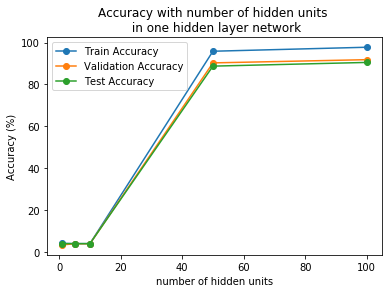

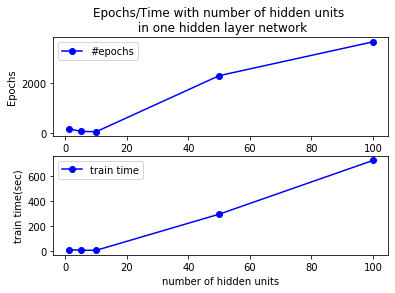

In [18]:
print("------------------Plotting Graphs for Part B - Fixed LR - One Hidden Layer ------------------")
plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy)
plot_epoch(arch_test, epochs, train_time)

## Part C - Adaptive Learning rate

In [53]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

lr0=0.5

for i in range(len(arch_test)):
    theta = theta_init([arch_test[i]], 'normal')
    #print(theta[0].shape, theta[1].shape, theta[2].shape)
    print("Training the network with {} hidden layer with {} units".format(len([arch_test[i]]), arch_test[i]))
    print("The parameters of the layers are of the shape:")

    for j in range(len(theta)):
        print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))

    start = time.time()
    epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr0, 'sigmoid', 'adaptive')
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

Training the network with 1 hidden layer with 1 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 1)
theta between layer 1 and layer 2 is (1, 26)
Initial Cost on Val dataset for this epoch 1 = 3.2523889110145983
learning rate for this epoch =  0.5
Error on this batch = 3.252387210445647
Error on this batch = 0.7539355816987324
Cost on val dataset after 2 epochs is = 0.596018260069574
Initial Cost on Val dataset for this epoch 2 = 0.596018260069574
learning rate for this epoch =  0.35355339059327373
Error on this batch = 0.5956696280244634
Error on this batch = 0.5515385242785587
Cost on val dataset after 3 epochs is = 0.5320880267143362
Initial Cost on Val dataset for this epoch 3 = 0.5320880267143362
learning rate for this epoch =  0.2886751345948129
Error on this batch = 0.5318960198133289
Error on this batch = 0.5199562934325028
Cost on val dataset after 4 epochs is = 0.5130041694125225
Initial Cost on Val dataset for this epoch 4 = 0.51

Cost on val dataset after 33 epochs is = 0.4826264889076551
Initial Cost on Val dataset for this epoch 33 = 0.4826264889076551
learning rate for this epoch =  0.08703882797784893
Error on this batch = 0.48255886311648793
Error on this batch = 0.48250356140574513
Cost on val dataset after 34 epochs is = 0.4825507833313709
Initial Cost on Val dataset for this epoch 34 = 0.4825507833313709
learning rate for this epoch =  0.08574929257125441
Error on this batch = 0.482483252032803
Error on this batch = 0.48243039845272406
Cost on val dataset after 35 epochs is = 0.4824800162725913
Initial Cost on Val dataset for this epoch 35 = 0.4824800162725913
learning rate for this epoch =  0.08451542547285165
Error on this batch = 0.48241256640186536
Error on this batch = 0.48236192731044314
Cost on val dataset after 36 epochs is = 0.4824137457131219
Initial Cost on Val dataset for this epoch 36 = 0.4824137457131219
learning rate for this epoch =  0.08333333333333333
Error on this batch = 0.4823463654

Cost on val dataset after 65 epochs is = 0.48147036354249606
Initial Cost on Val dataset for this epoch 65 = 0.48147036354249606
learning rate for this epoch =  0.062017367294604234
Error on this batch = 0.4814025850150175
Error on this batch = 0.48137476105670834
Cost on val dataset after 66 epochs is = 0.4814547913200563
Initial Cost on Val dataset for this epoch 66 = 0.4814547913200563
learning rate for this epoch =  0.06154574548966636
Error on this batch = 0.4813869620598697
Error on this batch = 0.4813593358516481
Cost on val dataset after 67 epochs is = 0.4814397870757292
Initial Cost on Val dataset for this epoch 67 = 0.4814397870757292
learning rate for this epoch =  0.06108472217815261
Error on this batch = 0.4813719061338426
Error on this batch = 0.4813444646540587
Cost on val dataset after 68 epochs is = 0.4814253232297525
Initial Cost on Val dataset for this epoch 68 = 0.4814253232297525
learning rate for this epoch =  0.06063390625908324
Error on this batch = 0.4813573897

Cost on val dataset after 97 epochs is = 0.4811597419092718
Initial Cost on Val dataset for this epoch 97 = 0.4811597419092718
learning rate for this epoch =  0.05076730825668096
Error on this batch = 0.48109010364876786
Error on this batch = 0.48106483771082015
Cost on val dataset after 98 epochs is = 0.4811540510651761
Initial Cost on Val dataset for this epoch 98 = 0.4811540510651761
learning rate for this epoch =  0.050507627227610534
Error on this batch = 0.4810843521049792
Error on this batch = 0.48105909839235467
Cost on val dataset after 99 epochs is = 0.48114851071877485
Initial Cost on Val dataset for this epoch 99 = 0.48114851071877485
learning rate for this epoch =  0.050251890762960605
Error on this batch = 0.481078751105769
Error on this batch = 0.4810535076461349
Cost on val dataset after 100 epochs is = 0.4811431157304366
Initial Cost on Val dataset for this epoch 100 = 0.4811431157304366
learning rate for this epoch =  0.05
Error on this batch = 0.48107329552139777
Err

Cost on val dataset after 129 epochs is = 0.48103289234244573
Initial Cost on Val dataset for this epoch 129 = 0.48103289234244573
learning rate for this epoch =  0.04402254531628119
Error on this batch = 0.4809613688283961
Error on this batch = 0.48093587027169477
Cost on val dataset after 130 epochs is = 0.4810302541671982
Initial Cost on Val dataset for this epoch 130 = 0.4810302541671982
learning rate for this epoch =  0.043852900965351466
Error on this batch = 0.4809586744174088
Error on this batch = 0.4809331564208126
Cost on val dataset after 131 epochs is = 0.4810276723169858
Initial Cost on Val dataset for this epoch 131 = 0.4810276723169858
learning rate for this epoch =  0.0436852028330519
Error on this batch = 0.48095603652302077
Error on this batch = 0.4809304987107679
Cost on val dataset after 132 epochs is = 0.48102514528272333
Initial Cost on Val dataset for this epoch 132 = 0.48102514528272333
learning rate for this epoch =  0.04351941398892446
Error on this batch = 0.

Cost on val dataset after 161 epochs is = 0.4809703875112432
Initial Cost on Val dataset for this epoch 161 = 0.4809703875112432
learning rate for this epoch =  0.03940552031195503
Error on this batch = 0.4808971626811981
Error on this batch = 0.48087092906436824
Cost on val dataset after 162 epochs is = 0.4809689943665821
Initial Cost on Val dataset for this epoch 162 = 0.4809689943665821
learning rate for this epoch =  0.039283710065919304
Error on this batch = 0.48089571966932537
Error on this batch = 0.4808694611989708
Cost on val dataset after 163 epochs is = 0.48096762671390064
Initial Cost on Val dataset for this epoch 163 = 0.48096762671390064
learning rate for this epoch =  0.03916302249939787
Error on this batch = 0.4808943023472294
Error on this batch = 0.4808680189928044
Cost on val dataset after 164 epochs is = 0.4809662839838974
Initial Cost on Val dataset for this epoch 164 = 0.4809662839838974
learning rate for this epoch =  0.03904344047215152
Error on this batch = 0.4

Error on this batch = 0.4816617122274792
Cost on val dataset after 5 epochs is = 0.4816167847026859
Initial Cost on Val dataset for this epoch 5 = 0.4816167847026859
learning rate for this epoch =  0.22360679774997896
Error on this batch = 0.4814917531900175
Error on this batch = 0.4813051631537713
Cost on val dataset after 6 epochs is = 0.48135118228307805
Initial Cost on Val dataset for this epoch 6 = 0.48135118228307805
learning rate for this epoch =  0.20412414523193154
Error on this batch = 0.481248030037795
Error on this batch = 0.4811153537734418
Cost on val dataset after 7 epochs is = 0.48120238787093533
Initial Cost on Val dataset for this epoch 7 = 0.48120238787093533
learning rate for this epoch =  0.1889822365046136
Error on this batch = 0.4811137615642499
Error on this batch = 0.4810035309401299
Cost on val dataset after 8 epochs is = 0.48111198982014913
Initial Cost on Val dataset for this epoch 8 = 0.48111198982014913
learning rate for this epoch =  0.17677669529663687
E

Cost on val dataset after 4 epochs is = 0.48118256018196615
Initial Cost on Val dataset for this epoch 4 = 0.48118256018196615
learning rate for this epoch =  0.25
Error on this batch = 0.4810996456752301
Error on this batch = 0.4808980397654839
Cost on val dataset after 5 epochs is = 0.48109989274593856
Initial Cost on Val dataset for this epoch 5 = 0.48109989274593856
learning rate for this epoch =  0.22360679774997896
Error on this batch = 0.4810599833162988
Error on this batch = 0.480850534303475
Cost on val dataset after 6 epochs is = 0.48106780913129765
Initial Cost on Val dataset for this epoch 6 = 0.48106780913129765
learning rate for this epoch =  0.20412414523193154
Error on this batch = 0.4810534183244144
Error on this batch = 0.4808290934397344
Cost on val dataset after 7 epochs is = 0.4810534729037285
Initial Cost on Val dataset for this epoch 7 = 0.4810534729037285
learning rate for this epoch =  0.1889822365046136
Error on this batch = 0.4810557279371363
Error on this ba

Cost on val dataset after 13 epochs is = 0.48163543151164073
Initial Cost on Val dataset for this epoch 13 = 0.48163543151164073
learning rate for this epoch =  0.1386750490563073
Error on this batch = 0.48221272600268245
Error on this batch = 0.4811277909142423
Cost on val dataset after 14 epochs is = 0.4816212710565488
Initial Cost on Val dataset for this epoch 14 = 0.4816212710565488
learning rate for this epoch =  0.1336306209562122
Error on this batch = 0.48220094102437117
Error on this batch = 0.48111277415217474
Cost on val dataset after 15 epochs is = 0.48160712752848384
Initial Cost on Val dataset for this epoch 15 = 0.48160712752848384
learning rate for this epoch =  0.12909944487358055
Error on this batch = 0.48218885282467766
Error on this batch = 0.48109773115976084
Cost on val dataset after 16 epochs is = 0.48159296136991414
Initial Cost on Val dataset for this epoch 16 = 0.48159296136991414
learning rate for this epoch =  0.125
Error on this batch = 0.4821764953539335
Er

Error on this batch = 0.48049769482528126
Cost on val dataset after 45 epochs is = 0.48106040509165104
Initial Cost on Val dataset for this epoch 45 = 0.48106040509165104
learning rate for this epoch =  0.07453559924999299
Error on this batch = 0.48168118265305404
Error on this batch = 0.4804671537090501
Cost on val dataset after 46 epochs is = 0.4810345028182547
Initial Cost on Val dataset for this epoch 46 = 0.4810345028182547
learning rate for this epoch =  0.07372097807744857
Error on this batch = 0.48165718797663387
Error on this batch = 0.48043565049045006
Cost on val dataset after 47 epochs is = 0.48100785829277204
Initial Cost on Val dataset for this epoch 47 = 0.48100785829277204
learning rate for this epoch =  0.07293249574894728
Error on this batch = 0.4816325368773181
Error on this batch = 0.48040314915879245
Cost on val dataset after 48 epochs is = 0.4809804440183818
Initial Cost on Val dataset for this epoch 48 = 0.4809804440183818
learning rate for this epoch =  0.072168

Error on this batch = 0.47881316706781996
Cost on val dataset after 77 epochs is = 0.4796939905816139
Initial Cost on Val dataset for this epoch 77 = 0.4796939905816139
learning rate for this epoch =  0.05698028822981897
Error on this batch = 0.4804408624880125
Error on this batch = 0.47872638937633705
Cost on val dataset after 78 epochs is = 0.4796259042016859
Initial Cost on Val dataset for this epoch 78 = 0.4796259042016859
learning rate for this epoch =  0.05661385170722978
Error on this batch = 0.48037984274716705
Error on this batch = 0.47863664571328557
Cost on val dataset after 79 epochs is = 0.479555673350129
Initial Cost on Val dataset for this epoch 79 = 0.479555673350129
learning rate for this epoch =  0.0562543950463012
Error on this batch = 0.4803169440441945
Error on this batch = 0.47854383088300817
Cost on val dataset after 80 epochs is = 0.4794832306145203
Initial Cost on Val dataset for this epoch 80 = 0.4794832306145203
learning rate for this epoch =  0.0559016994374

Error on this batch = 0.47387117038285664
Cost on val dataset after 109 epochs is = 0.47604025584764886
Initial Cost on Val dataset for this epoch 109 = 0.47604025584764886
learning rate for this epoch =  0.04789131426105757
Error on this batch = 0.47719864225158276
Error on this batch = 0.47361317222036675
Cost on val dataset after 110 epochs is = 0.4758597077795539
Initial Cost on Val dataset for this epoch 110 = 0.4758597077795539
learning rate for this epoch =  0.04767312946227962
Error on this batch = 0.47703992318170335
Error on this batch = 0.47334653818350775
Cost on val dataset after 111 epochs is = 0.4756739218119749
Initial Cost on Val dataset for this epoch 111 = 0.4756739218119749
learning rate for this epoch =  0.04745789978762495
Error on this batch = 0.47687682289210914
Error on this batch = 0.47307108142299387
Cost on val dataset after 112 epochs is = 0.47548280154941225
Initial Cost on Val dataset for this epoch 112 = 0.47548280154941225
learning rate for this epoch =

Error on this batch = 0.4617618799057442
Cost on val dataset after 141 epochs is = 0.4676059763524638
Initial Cost on Val dataset for this epoch 141 = 0.4676059763524638
learning rate for this epoch =  0.04210759605332595
Error on this batch = 0.47042784501079854
Error on this batch = 0.4613266318935901
Cost on val dataset after 142 epochs is = 0.467270770199596
Initial Cost on Val dataset for this epoch 142 = 0.467270770199596
learning rate for this epoch =  0.041959067914834454
Error on this batch = 0.47020054900887814
Error on this batch = 0.4608938817917101
Cost on val dataset after 143 epochs is = 0.4669331086041733
Initial Cost on Val dataset for this epoch 143 = 0.4669331086041733
learning rate for this epoch =  0.04181210050035454
Error on this batch = 0.46997516024250935
Error on this batch = 0.4604638520308288
Cost on val dataset after 144 epochs is = 0.46659311907103623
Initial Cost on Val dataset for this epoch 144 = 0.46659311907103623
learning rate for this epoch =  0.041

Error on this batch = 0.4484933901288611
Cost on val dataset after 173 epochs is = 0.4556641191771843
Initial Cost on Val dataset for this epoch 173 = 0.4556641191771843
learning rate for this epoch =  0.038014296063485276
Error on this batch = 0.4636748339402581
Error on this batch = 0.44804510374323686
Cost on val dataset after 174 epochs is = 0.4552330321280419
Initial Cost on Val dataset for this epoch 174 = 0.4552330321280419
learning rate for this epoch =  0.03790490217894517
Error on this batch = 0.46344944767111995
Error on this batch = 0.44759016931342593
Cost on val dataset after 175 epochs is = 0.4547965470455578
Initial Cost on Val dataset for this epoch 175 = 0.4547965470455578
learning rate for this epoch =  0.03779644730092272
Error on this batch = 0.4632207604191505
Error on this batch = 0.4471281438405949
Cost on val dataset after 176 epochs is = 0.4543544462188503
Initial Cost on Val dataset for this epoch 176 = 0.4543544462188503
learning rate for this epoch =  0.037

Error on this batch = 0.42852303185856644
Cost on val dataset after 205 epochs is = 0.4377416207052872
Initial Cost on Val dataset for this epoch 205 = 0.4377416207052872
learning rate for this epoch =  0.03492151478847891
Error on this batch = 0.4536151754958933
Error on this batch = 0.4276442440845796
Cost on val dataset after 206 epochs is = 0.4369903034919947
Initial Cost on Val dataset for this epoch 206 = 0.4369903034919947
learning rate for this epoch =  0.034836650714580884
Error on this batch = 0.4531597189734674
Error on this batch = 0.4267501092180569
Cost on val dataset after 207 epochs is = 0.43622630791832556
Initial Cost on Val dataset for this epoch 207 = 0.43622630791832556
learning rate for this epoch =  0.034752402342845795
Error on this batch = 0.45269373383880224
Error on this batch = 0.4258414652362625
Cost on val dataset after 208 epochs is = 0.4354501249393841
Initial Cost on Val dataset for this epoch 208 = 0.4354501249393841
learning rate for this epoch =  0.0

Error on this batch = 0.3985598245951293
Cost on val dataset after 237 epochs is = 0.41144093478678917
Initial Cost on Val dataset for this epoch 237 = 0.41144093478678917
learning rate for this epoch =  0.032478490123081544
Error on this batch = 0.4355922394320477
Error on this batch = 0.39774388759623286
Cost on val dataset after 238 epochs is = 0.4106813983325361
Initial Cost on Val dataset for this epoch 238 = 0.4106813983325361
learning rate for this epoch =  0.03241018617760822
Error on this batch = 0.43498622420338495
Error on this batch = 0.3969407802459219
Cost on val dataset after 239 epochs is = 0.40993034592294986
Initial Cost on Val dataset for this epoch 239 = 0.40993034592294986
learning rate for this epoch =  0.03234231136765754
Error on this batch = 0.4343810622108613
Error on this batch = 0.39615028376179423
Cost on val dataset after 240 epochs is = 0.40918766219302743
Initial Cost on Val dataset for this epoch 240 = 0.40918766219302743
learning rate for this epoch = 

Error on this batch = 0.37702971198805046
Cost on val dataset after 269 epochs is = 0.3901073683865182
Initial Cost on Val dataset for this epoch 269 = 0.3901073683865182
learning rate for this epoch =  0.030485538042484616
Error on this batch = 0.4163254394498573
Error on this batch = 0.3764438015517584
Cost on val dataset after 270 epochs is = 0.3894908518008106
Initial Cost on Val dataset for this epoch 270 = 0.3894908518008106
learning rate for this epoch =  0.03042903097250923
Error on this batch = 0.41570803435762516
Error on this batch = 0.37585958698662225
Cost on val dataset after 271 epochs is = 0.38887465045209096
Initial Cost on Val dataset for this epoch 271 = 0.38887465045209096
learning rate for this epoch =  0.03037283696153935
Error on this batch = 0.4150884691370855
Error on this batch = 0.3752768327023564
Cost on val dataset after 272 epochs is = 0.3882585884595428
Initial Cost on Val dataset for this epoch 272 = 0.3882585884595428
learning rate for this epoch =  0.0

Error on this batch = 0.35822052606363697
Cost on val dataset after 301 epochs is = 0.3699317467667629
Initial Cost on Val dataset for this epoch 301 = 0.3699317467667629
learning rate for this epoch =  0.02881952088521175
Error on this batch = 0.39537330372938256
Error on this batch = 0.3576083204402319
Cost on val dataset after 302 epochs is = 0.3692749732235238
Initial Cost on Val dataset for this epoch 302 = 0.3692749732235238
learning rate for this epoch =  0.0287717668824218
Error on this batch = 0.3946835924411744
Error on this batch = 0.3569938308848667
Cost on val dataset after 303 epochs is = 0.3686165408489497
Initial Cost on Val dataset for this epoch 303 = 0.3686165408489497
learning rate for this epoch =  0.0287242494810713
Error on this batch = 0.39399267531356386
Error on this batch = 0.3563770455328753
Cost on val dataset after 304 epochs is = 0.36795650312892036
Initial Cost on Val dataset for this epoch 304 = 0.36795650312892036
learning rate for this epoch =  0.0286

Error on this batch = 0.3376297215448111
Cost on val dataset after 333 epochs is = 0.34851737003314875
Initial Cost on Val dataset for this epoch 333 = 0.34851737003314875
learning rate for this epoch =  0.02739983121755955
Error on this batch = 0.3733926809821713
Error on this batch = 0.3369628136606552
Cost on val dataset after 334 epochs is = 0.3478534529062699
Initial Cost on Val dataset for this epoch 334 = 0.3478534529062699
learning rate for this epoch =  0.027358782758229137
Error on this batch = 0.37273197127612195
Error on this batch = 0.3362952908634334
Cost on val dataset after 335 epochs is = 0.3471910745711828
Initial Cost on Val dataset for this epoch 335 = 0.3471910745711828
learning rate for this epoch =  0.027317918235407655
Error on this batch = 0.37207405939162314
Error on this batch = 0.3356272230216675
Cost on val dataset after 336 epochs is = 0.3465303254534296
Initial Cost on Val dataset for this epoch 336 = 0.3465303254534296
learning rate for this epoch =  0.0

Error on this batch = 0.31624896827675014
Cost on val dataset after 365 epochs is = 0.32833633853789745
Initial Cost on Val dataset for this epoch 365 = 0.32833633853789745
learning rate for this epoch =  0.026171196129510688
Error on this batch = 0.353797767254718
Error on this batch = 0.315585820179412
Cost on val dataset after 366 epochs is = 0.3277464293015948
Initial Cost on Val dataset for this epoch 366 = 0.3277464293015948
learning rate for this epoch =  0.026135418674465834
Error on this batch = 0.3532372713012481
Error on this batch = 0.3149231997181747
Cost on val dataset after 367 epochs is = 0.3271590214935992
Initial Cost on Val dataset for this epoch 367 = 0.3271590214935992
learning rate for this epoch =  0.026099787548594027
Error on this batch = 0.3526796700872464
Error on this batch = 0.3142611144211248
Cost on val dataset after 368 epochs is = 0.3265740961635448
Initial Cost on Val dataset for this epoch 368 = 0.3265740961635448
learning rate for this epoch =  0.026

Cost on val dataset after 396 epochs is = 0.31109739415176996
Initial Cost on Val dataset for this epoch 396 = 0.31109739415176996
learning rate for this epoch =  0.025125945381480302
Error on this batch = 0.3375856220594781
Error on this batch = 0.2953142149382097
Cost on val dataset after 397 epochs is = 0.3105725804020127
Initial Cost on Val dataset for this epoch 397 = 0.3105725804020127
learning rate for this epoch =  0.02509428066142478
Error on this batch = 0.33709589838473925
Error on this batch = 0.2946703022686876
Cost on val dataset after 398 epochs is = 0.31004939884886806
Initial Cost on Val dataset for this epoch 398 = 0.31004939884886806
learning rate for this epoch =  0.025062735355854276
Error on this batch = 0.33660782077706003
Error on this batch = 0.2940270789462869
Cost on val dataset after 399 epochs is = 0.3095278222726989
Initial Cost on Val dataset for this epoch 399 = 0.3095278222726989
learning rate for this epoch =  0.025031308716087945
Error on this batch =

Cost on val dataset after 428 epochs is = 0.2949952527909631
Initial Cost on Val dataset for this epoch 428 = 0.2949952527909631
learning rate for this epoch =  0.02416841222614159
Error on this batch = 0.3225657084513173
Error on this batch = 0.2750977326316093
Cost on val dataset after 429 epochs is = 0.2945115666671817
Initial Cost on Val dataset for this epoch 429 = 0.2945115666671817
learning rate for this epoch =  0.02414022747926338
Error on this batch = 0.3221126231864568
Error on this batch = 0.2744806743649368
Cost on val dataset after 430 epochs is = 0.29402888028516977
Initial Cost on Val dataset for this epoch 430 = 0.29402888028516977
learning rate for this epoch =  0.024112141108520606
Error on this batch = 0.3216602089190596
Error on this batch = 0.2738646194842878
Cost on val dataset after 431 epochs is = 0.2935471813010492
Initial Cost on Val dataset for this epoch 431 = 0.2935471813010492
learning rate for this epoch =  0.0240841525429544
Error on this batch = 0.3212

Error on this batch = 0.25646812102264066
Cost on val dataset after 460 epochs is = 0.27996463159540336
Initial Cost on Val dataset for this epoch 460 = 0.27996463159540336
learning rate for this epoch =  0.023312620206007845
Error on this batch = 0.3082872712042555
Error on this batch = 0.25588527739322864
Cost on val dataset after 461 epochs is = 0.2795085321963915
Initial Cost on Val dataset for this epoch 461 = 0.2795085321963915
learning rate for this epoch =  0.023287321641631116
Error on this batch = 0.30784495011734725
Error on this batch = 0.25530361153636577
Cost on val dataset after 462 epochs is = 0.2790532045396187
Initial Cost on Val dataset for this epoch 462 = 0.2790532045396187
learning rate for this epoch =  0.023262105259961773
Error on this batch = 0.30740268496385303
Error on this batch = 0.25472312644475215
Cost on val dataset after 463 epochs is = 0.2785986465606454
Initial Cost on Val dataset for this epoch 463 = 0.2785986465606454
learning rate for this epoch =

Error on this batch = 0.23841592320328328
Cost on val dataset after 492 epochs is = 0.2657521303248071
Initial Cost on Val dataset for this epoch 492 = 0.2657521303248071
learning rate for this epoch =  0.022541740866685808
Error on this batch = 0.29412731843214174
Error on this batch = 0.23787230658676475
Cost on val dataset after 493 epochs is = 0.2653210833031487
Initial Cost on Val dataset for this epoch 493 = 0.2653210833031487
learning rate for this epoch =  0.022518867455552247
Error on this batch = 0.293684327620231
Error on this batch = 0.2373299819197316
Cost on val dataset after 494 epochs is = 0.26489087651331583
Initial Cost on Val dataset for this epoch 494 = 0.26489087651331583
learning rate for this epoch =  0.022496063533292376
Error on this batch = 0.2932413488525283
Error on this batch = 0.23678895481764084
Cost on val dataset after 495 epochs is = 0.2644615159878457
Initial Cost on Val dataset for this epoch 495 = 0.2644615159878457
learning rate for this epoch =  0

Cost on val dataset after 523 epochs is = 0.25281163335967566
Initial Cost on Val dataset for this epoch 523 = 0.25281163335967566
learning rate for this epoch =  0.021863473472331304
Error on this batch = 0.2804588322770531
Error on this batch = 0.22169413805803342
Cost on val dataset after 524 epochs is = 0.25240996653790904
Initial Cost on Val dataset for this epoch 524 = 0.25240996653790904
learning rate for this epoch =  0.02184260141652595
Error on this batch = 0.2800228160540284
Error on this batch = 0.22119532511610238
Cost on val dataset after 525 epochs is = 0.2520093705829848
Initial Cost on Val dataset for this epoch 525 = 0.2520093705829848
learning rate for this epoch =  0.02182178902359924
Error on this batch = 0.2795873128964121
Error on this batch = 0.22069804140830968
Cost on val dataset after 526 epochs is = 0.2516098529737591
Initial Cost on Val dataset for this epoch 526 = 0.2516098529737591
learning rate for this epoch =  0.02180103600984737
Error on this batch = 

Cost on val dataset after 555 epochs is = 0.24052221411231853
Initial Cost on Val dataset for this epoch 555 = 0.24052221411231853
learning rate for this epoch =  0.021223817998900444
Error on this batch = 0.26685799395822296
Error on this batch = 0.20652509736991548
Cost on val dataset after 556 epochs is = 0.24015789396594248
Initial Cost on Val dataset for this epoch 556 = 0.24015789396594248
learning rate for this epoch =  0.021204723241999273
Error on this batch = 0.2664478572713491
Error on this batch = 0.20607844453933852
Cost on val dataset after 557 epochs is = 0.23979481619279797
Initial Cost on Val dataset for this epoch 557 = 0.23979481619279797
learning rate for this epoch =  0.021185679930351788
Error on this batch = 0.2660388028147242
Error on this batch = 0.20563349769748254
Cost on val dataset after 558 epochs is = 0.2394329834476655
Initial Cost on Val dataset for this epoch 558 = 0.2394329834476655
learning rate for this epoch =  0.021166687833365085
Error on this ba

Cost on val dataset after 587 epochs is = 0.22948765482148437
Initial Cost on Val dataset for this epoch 587 = 0.22948765482148437
learning rate for this epoch =  0.0206372085853249
Error on this batch = 0.25432107435185386
Error on this batch = 0.19308269857283963
Cost on val dataset after 588 epochs is = 0.22916363950798763
Initial Cost on Val dataset for this epoch 588 = 0.22916363950798763
learning rate for this epoch =  0.020619652471058063
Error on this batch = 0.2539501494174291
Error on this batch = 0.1926908201845881
Cost on val dataset after 589 epochs is = 0.22884087792024269
Initial Cost on Val dataset for this epoch 589 = 0.22884087792024269
learning rate for this epoch =  0.02060214108575823
Error on this batch = 0.2535805419308972
Error on this batch = 0.19230062918297713
Cost on val dataset after 590 epochs is = 0.22851936839545567
Initial Cost on Val dataset for this epoch 590 = 0.22851936839545567
learning rate for this epoch =  0.020584674239815456
Error on this batc

Cost on val dataset after 619 epochs is = 0.2197298730725739
Initial Cost on Val dataset for this epoch 619 = 0.2197298730725739
learning rate for this epoch =  0.02009669677645352
Error on this batch = 0.24310783062418204
Error on this batch = 0.1813602622709918
Cost on val dataset after 620 epochs is = 0.21944477036448634
Initial Cost on Val dataset for this epoch 620 = 0.21944477036448634
learning rate for this epoch =  0.02008048322256247
Error on this batch = 0.24277910651764456
Error on this batch = 0.18102033475463214
Cost on val dataset after 621 epochs is = 0.2191608327036062
Initial Cost on Val dataset for this epoch 621 = 0.2191608327036062
learning rate for this epoch =  0.020064308847628203
Error on this batch = 0.24245167389090327
Error on this batch = 0.18068194883108482
Cost on val dataset after 622 epochs is = 0.21887805646567068
Initial Cost on Val dataset for this epoch 622 = 0.21887805646567068
learning rate for this epoch =  0.020048173494115636
Error on this batch

Error on this batch = 0.17151287854216685
Cost on val dataset after 651 epochs is = 0.21116546166863692
Initial Cost on Val dataset for this epoch 651 = 0.21116546166863692
learning rate for this epoch =  0.019596545041740514
Error on this batch = 0.23321183731170103
Error on this batch = 0.17121796789726637
Cost on val dataset after 652 epochs is = 0.210915711249648
Initial Cost on Val dataset for this epoch 652 = 0.210915711249648
learning rate for this epoch =  0.019581511249698935
Error on this batch = 0.23292263327072704
Error on this batch = 0.17092441011932524
Cost on val dataset after 653 epochs is = 0.21066699800182204
Initial Cost on Val dataset for this epoch 653 = 0.21066699800182204
learning rate for this epoch =  0.019566512004870806
Error on this batch = 0.2326345967153558
Error on this batch = 0.17063219884184147
Cost on val dataset after 654 epochs is = 0.2104193176830489
Initial Cost on Val dataset for this epoch 654 = 0.2104193176830489
learning rate for this epoch =

Error on this batch = 0.16271510810844989
Cost on val dataset after 683 epochs is = 0.20366669453325317
Initial Cost on Val dataset for this epoch 683 = 0.20366669453325317
learning rate for this epoch =  0.019131968294834524
Error on this batch = 0.2245143503901251
Error on this batch = 0.1624603270026011
Cost on val dataset after 684 epochs is = 0.203448012655653
Initial Cost on Val dataset for this epoch 684 = 0.203448012655653
learning rate for this epoch =  0.019117977822546813
Error on this batch = 0.2242602976689375
Error on this batch = 0.16220669551859274
Cost on val dataset after 685 epochs is = 0.20323023112450428
Initial Cost on Val dataset for this epoch 685 = 0.20323023112450428
learning rate for this epoch =  0.019104017997521754
Error on this batch = 0.2240072696222269
Error on this batch = 0.16195420743316688
Cost on val dataset after 686 epochs is = 0.20301334570173926
Initial Cost on Val dataset for this epoch 686 = 0.20301334570173926
learning rate for this epoch = 

Error on this batch = 0.15510204031793468
Cost on val dataset after 715 epochs is = 0.19709470798911316
Initial Cost on Val dataset for this epoch 715 = 0.19709470798911316
learning rate for this epoch =  0.018698939800169144
Error on this batch = 0.2168710205705437
Error on this batch = 0.1548810437146815
Cost on val dataset after 716 epochs is = 0.19690277612852097
Initial Cost on Val dataset for this epoch 716 = 0.19690277612852097
learning rate for this epoch =  0.018685877318798397
Error on this batch = 0.21664757841967713
Error on this batch = 0.15466100639502503
Cost on val dataset after 717 epochs is = 0.19671161342287938
Initial Cost on Val dataset for this epoch 717 = 0.19671161342287938
learning rate for this epoch =  0.018672842174331777
Error on this batch = 0.21642502162909039
Error on this batch = 0.154441922759727
Cost on val dataset after 718 epochs is = 0.19652121595881103
Initial Cost on Val dataset for this epoch 718 = 0.19652121595881103
learning rate for this epoc

Error on this batch = 0.1484790750236313
Cost on val dataset after 747 epochs is = 0.19131548541081508
Initial Cost on Val dataset for this epoch 747 = 0.19131548541081508
learning rate for this epoch =  0.018294043331615058
Error on this batch = 0.21013944573718032
Error on this batch = 0.14828612254162912
Cost on val dataset after 748 epochs is = 0.19114629621513998
Initial Cost on Val dataset for this epoch 748 = 0.19114629621513998
learning rate for this epoch =  0.018281810603178267
Error on this batch = 0.20994229384068194
Error on this batch = 0.14809396274577719
Cost on val dataset after 749 epochs is = 0.19097775815673906
Initial Cost on Val dataset for this epoch 749 = 0.19097775815673906
learning rate for this epoch =  0.01826960238104674
Error on this batch = 0.2097458976472709
Error on this batch = 0.14790259086445978
Cost on val dataset after 750 epochs is = 0.19080986780286494
Initial Cost on Val dataset for this epoch 750 = 0.19080986780286494
learning rate for this epo

Error on this batch = 0.14267506472595842
Cost on val dataset after 779 epochs is = 0.18620795360359552
Initial Cost on Val dataset for this epoch 779 = 0.18620795360359552
learning rate for this epoch =  0.017914359097500464
Error on this batch = 0.20418683408182559
Error on this batch = 0.14250524421282754
Cost on val dataset after 780 epochs is = 0.18605797889008438
Initial Cost on Val dataset for this epoch 780 = 0.18605797889008438
learning rate for this epoch =  0.017902871850985824
Error on this batch = 0.2040120268220229
Error on this batch = 0.14233607691881697
Cost on val dataset after 781 epochs is = 0.18590855354401903
Initial Cost on Val dataset for this epoch 781 = 0.18590855354401903
learning rate for this epoch =  0.01789140667411283
Error on this batch = 0.20383785933369422
Error on this batch = 0.1421675589174577
Cost on val dataset after 782 epochs is = 0.185759674653171
Initial Cost on Val dataset for this epoch 782 = 0.185759674653171
learning rate for this epoch =

Error on this batch = 0.13754622407949077
Cost on val dataset after 811 epochs is = 0.18166737228104635
Initial Cost on Val dataset for this epoch 811 = 0.18166737228104635
learning rate for this epoch =  0.01755737468051559
Error on this batch = 0.19889419791399549
Error on this batch = 0.13739548158380294
Cost on val dataset after 812 epochs is = 0.1815336108159096
Initial Cost on Val dataset for this epoch 812 = 0.1815336108159096
learning rate for this epoch =  0.01754656015858991
Error on this batch = 0.19873827237348884
Error on this batch = 0.13724527877215473
Cost on val dataset after 813 epochs is = 0.18140031325654993
Initial Cost on Val dataset for this epoch 813 = 0.18140031325654993
learning rate for this epoch =  0.01753576559579736
Error on this batch = 0.1985828868103801
Error on this batch = 0.1370956124806279
Cost on val dataset after 814 epochs is = 0.18126747718037328
Initial Cost on Val dataset for this epoch 814 = 0.18126747718037328
learning rate for this epoch =

Error on this batch = 0.13297522064645034
Cost on val dataset after 843 epochs is = 0.1776055904172206
Initial Cost on Val dataset for this epoch 843 = 0.1776055904172206
learning rate for this epoch =  0.017220914757957267
Error on this batch = 0.19415882766184905
Error on this batch = 0.132840283426273
Cost on val dataset after 844 epochs is = 0.1774855412768132
Initial Cost on Val dataset for this epoch 844 = 0.1774855412768132
learning rate for this epoch =  0.017210709770537857
Error on this batch = 0.19401884428485766
Error on this batch = 0.13270579494860563
Cost on val dataset after 845 epochs is = 0.17736588532212513
Initial Cost on Val dataset for this epoch 845 = 0.17736588532212513
learning rate for this epoch =  0.017200522903844537
Error on this batch = 0.19387931730656552
Error on this batch = 0.1325717526930075
Cost on val dataset after 846 epochs is = 0.17724662055752294
Initial Cost on Val dataset for this epoch 846 = 0.17724662055752294
learning rate for this epoch =

Cost on val dataset after 874 epochs is = 0.17405830059501606
Initial Cost on Val dataset for this epoch 874 = 0.17405830059501606
learning rate for this epoch =  0.01691275228729346
Error on this batch = 0.19002137499056035
Error on this batch = 0.12886793267741342
Cost on val dataset after 875 epochs is = 0.1739495649721404
Initial Cost on Val dataset for this epoch 875 = 0.1739495649721404
learning rate for this epoch =  0.016903085094570332
Error on this batch = 0.1898945022393474
Error on this batch = 0.12874619078480992
Cost on val dataset after 876 epochs is = 0.1738411660409634
Initial Cost on Val dataset for this epoch 876 = 0.1738411660409634
learning rate for this epoch =  0.016893434459987148
Error on this batch = 0.1897680188998792
Error on this batch = 0.12862482539594874
Cost on val dataset after 877 epochs is = 0.17373310215275856
Initial Cost on Val dataset for this epoch 877 = 0.17373310215275856
learning rate for this epoch =  0.016883800336329358
Error on this batch

Error on this batch = 0.1252604705538946
Cost on val dataset after 906 epochs is = 0.17073793369296728
Initial Cost on Val dataset for this epoch 906 = 0.17073793369296728
learning rate for this epoch =  0.016611387354627385
Error on this batch = 0.1861453204951522
Error on this batch = 0.12514953369564122
Cost on val dataset after 907 epochs is = 0.17063920243458383
Initial Cost on Val dataset for this epoch 907 = 0.17063920243458383
learning rate for this epoch =  0.016602227504272985
Error on this batch = 0.18602999682229002
Error on this batch = 0.12503891773318748
Cost on val dataset after 908 epochs is = 0.1705407598256672
Initial Cost on Val dataset for this epoch 908 = 0.1705407598256672
learning rate for this epoch =  0.0165930827899993
Error on this batch = 0.18591500565752378
Error on this batch = 0.12492862107379077
Cost on val dataset after 909 epochs is = 0.17044260451130128
Initial Cost on Val dataset for this epoch 909 = 0.17044260451130128
learning rate for this epoch 

Error on this batch = 0.12186215344593045
Cost on val dataset after 938 epochs is = 0.16771526818874938
Initial Cost on Val dataset for this epoch 938 = 0.16771526818874938
learning rate for this epoch =  0.016325578711208478
Error on this batch = 0.18261227923527243
Error on this batch = 0.12176074947382681
Cost on val dataset after 939 epochs is = 0.16762514056375685
Initial Cost on Val dataset for this epoch 939 = 0.16762514056375685
learning rate for this epoch =  0.01631688332912094
Error on this batch = 0.18250684749676488
Error on this batch = 0.12165962073979782
Cost on val dataset after 940 epochs is = 0.16753526205021996
Initial Cost on Val dataset for this epoch 940 = 0.16753526205021996
learning rate for this epoch =  0.016308201826336056
Error on this batch = 0.18240170155719473
Error on this batch = 0.12155876597952212
Cost on val dataset after 941 epochs is = 0.16744563153083533
Initial Cost on Val dataset for this epoch 941 = 0.16744563153083533
learning rate for this e

Error on this batch = 0.11874778222234329
Cost on val dataset after 970 epochs is = 0.16494943128238956
Initial Cost on Val dataset for this epoch 970 = 0.16494943128238956
learning rate for this epoch =  0.01605403247669839
Error on this batch = 0.1793739563093659
Error on this batch = 0.11865460080628079
Cost on val dataset after 971 epochs is = 0.1648667523706218
Initial Cost on Val dataset for this epoch 971 = 0.1648667523706218
learning rate for this epoch =  0.016045763595142
Error on this batch = 0.1792770537558272
Error on this batch = 0.11856165828272602
Cost on val dataset after 972 epochs is = 0.1647842898929063
Initial Cost on Val dataset for this epoch 972 = 0.1647842898929063
learning rate for this epoch =  0.016037507477489603
Error on this batch = 0.17918039849205147
Error on this batch = 0.11846895364116505
Cost on val dataset after 973 epochs is = 0.1647020429232724
Initial Cost on Val dataset for this epoch 973 = 0.1647020429232724
learning rate for this epoch =  0.0

Error on this batch = 0.11587969188487891
Cost on val dataset after 1002 epochs is = 0.16240664940652016
Initial Cost on Val dataset for this epoch 1002 = 0.16240664940652016
learning rate for this epoch =  0.015795600590164088
Error on this batch = 0.17639054283216793
Error on this batch = 0.1157936859807379
Cost on val dataset after 1003 epochs is = 0.16233046231994783
Initial Cost on Val dataset for this epoch 1003 = 0.16233046231994783
learning rate for this epoch =  0.015787724448766815
Error on this batch = 0.17630104278654174
Error on this batch = 0.11570788977617856
Cost on val dataset after 1004 epochs is = 0.16225446451275927
Initial Cost on Val dataset for this epoch 1004 = 0.16225446451275927
learning rate for this epoch =  0.015779860077445078
Error on this batch = 0.17621175808475997
Error on this batch = 0.11562230245428891
Cost on val dataset after 1005 epochs is = 0.16217865521304348
Initial Cost on Val dataset for this epoch 1005 = 0.16217865521304348
learning rate fo

Error on this batch = 0.11322764094454484
Cost on val dataset after 1034 epochs is = 0.16005886558231464
Initial Cost on Val dataset for this epoch 1034 = 0.16005886558231464
learning rate for this epoch =  0.015549260339278073
Error on this batch = 0.1736290267314874
Error on this batch = 0.11314796456329738
Cost on val dataset after 1035 epochs is = 0.1599883729073071
Initial Cost on Val dataset for this epoch 1035 = 0.1599883729073071
learning rate for this epoch =  0.01554174680400523
Error on this batch = 0.1735459915893431
Error on this batch = 0.11306847411581597
Cost on val dataset after 1036 epochs is = 0.15991804680844438
Initial Cost on Val dataset for this epoch 1036 = 0.15991804680844438
learning rate for this epoch =  0.015534244150030001
Error on this batch = 0.1734631451106269
Error on this batch = 0.11298916893127324
Cost on val dataset after 1037 epochs is = 0.15984788663817934
Initial Cost on Val dataset for this epoch 1037 = 0.15984788663817934
learning rate for thi

Error on this batch = 0.110767026914152
Cost on val dataset after 1066 epochs is = 0.15788263056190954
Initial Cost on Val dataset for this epoch 1066 = 0.15788263056190954
learning rate for this epoch =  0.01531409729579222
Error on this batch = 0.17106184892059464
Error on this batch = 0.11069298594601346
Cost on val dataset after 1067 epochs is = 0.1578171636068435
Initial Cost on Val dataset for this epoch 1067 = 0.1578171636068435
learning rate for this epoch =  0.015306919373065674
Error on this batch = 0.170984493174056
Error on this batch = 0.11061911122825356
Cost on val dataset after 1068 epochs is = 0.15775184412452875
Initial Cost on Val dataset for this epoch 1068 = 0.15775184412452875
learning rate for this epoch =  0.015299751534052615
Error on this batch = 0.17090730366122497
Error on this batch = 0.11054540219967933
Cost on val dataset after 1069 epochs is = 0.15768667156821678
Initial Cost on Val dataset for this epoch 1069 = 0.15768667156821678
learning rate for this

Error on this batch = 0.10847749352172403
Cost on val dataset after 1098 epochs is = 0.1558582207234601
Initial Cost on Val dataset for this epoch 1098 = 0.1558582207234601
learning rate for this epoch =  0.015089291007086421
Error on this batch = 0.16866585075659152
Error on this batch = 0.10840850793952361
Cost on val dataset after 1099 epochs is = 0.15579721510357952
Initial Cost on Val dataset for this epoch 1099 = 0.15579721510357952
learning rate for this epoch =  0.01508242443516904
Error on this batch = 0.16859351211090534
Error on this batch = 0.10833967199046267
Cost on val dataset after 1100 epochs is = 0.15573634077726323
Initial Cost on Val dataset for this epoch 1100 = 0.15573634077726323
learning rate for this epoch =  0.015075567228888179
Error on this batch = 0.1685213207266522
Error on this batch = 0.10827098519591949
Cost on val dataset after 1101 epochs is = 0.1556755972798588
Initial Cost on Val dataset for this epoch 1101 = 0.1556755972798588
learning rate for thi

Error on this batch = 0.10634187565174724
Cost on val dataset after 1130 epochs is = 0.15396893802106806
Initial Cost on Val dataset for this epoch 1130 = 0.15396893802106806
learning rate for this epoch =  0.014874102932718241
Error on this batch = 0.1664214509706844
Error on this batch = 0.10627745137319781
Cost on val dataset after 1131 epochs is = 0.15391191427987386
Initial Cost on Val dataset for this epoch 1131 = 0.15391191427987386
learning rate for this epoch =  0.014867525836251314
Error on this batch = 0.16635356769614673
Error on this batch = 0.10621316243341904
Cost on val dataset after 1132 epochs is = 0.15385500804052515
Initial Cost on Val dataset for this epoch 1132 = 0.15385500804052515
learning rate for this epoch =  0.0148609574569441
Error on this batch = 0.16628581554335778
Error on this batch = 0.10614900841690621
Cost on val dataset after 1133 epochs is = 0.15379821890558706
Initial Cost on Val dataset for this epoch 1133 = 0.15379821890558706
learning rate for 

Error on this batch = 0.10434542548229214
Cost on val dataset after 1162 epochs is = 0.1522005538614185
Initial Cost on Val dataset for this epoch 1162 = 0.1522005538614185
learning rate for this epoch =  0.01466786622122144
Error on this batch = 0.16431199760293347
Error on this batch = 0.10428513408137705
Cost on val dataset after 1163 epochs is = 0.15214710205598853
Initial Cost on Val dataset for this epoch 1163 = 0.15214710205598853
learning rate for this epoch =  0.014661558817695555
Error on this batch = 0.1642480906068075
Error on this batch = 0.10422496552026093
Cost on val dataset after 1164 epochs is = 0.15209375592048271
Initial Cost on Val dataset for this epoch 1164 = 0.15209375592048271
learning rate for this epoch =  0.01465525954401373
Error on this batch = 0.16418430092783326
Error on this batch = 0.10416491943294012
Cost on val dataset after 1165 epochs is = 0.15204051511280592
Initial Cost on Val dataset for this epoch 1165 = 0.15204051511280592
learning rate for th

Error on this batch = 0.10247526163822089
Cost on val dataset after 1194 epochs is = 0.15054086606570208
Initial Cost on Val dataset for this epoch 1194 = 0.15054086606570208
learning rate for this epoch =  0.014469977004330817
Error on this batch = 0.16232325243889406
Error on this batch = 0.10241872610356055
Cost on val dataset after 1195 epochs is = 0.15049063346353286
Initial Cost on Val dataset for this epoch 1195 = 0.15049063346353286
learning rate for this epoch =  0.014463921353509292
Error on this batch = 0.1622629109230681
Error on this batch = 0.10236230233894694
Cost on val dataset after 1196 epochs is = 0.15044049631713488
Initial Cost on Val dataset for this epoch 1196 = 0.15044049631713488
learning rate for this epoch =  0.014457873299156005
Error on this batch = 0.162202674854855
Error on this batch = 0.10230599001849296
Cost on val dataset after 1197 epochs is = 0.15039045433023385
Initial Cost on Val dataset for this epoch 1197 = 0.15039045433023385
learning rate for 

Error on this batch = 0.10071998577880331
Cost on val dataset after 1226 epochs is = 0.14897934463876109
Initial Cost on Val dataset for this epoch 1226 = 0.14897934463876109
learning rate for this epoch =  0.014279886949438495
Error on this batch = 0.1604429767959085
Error on this batch = 0.10066687067678726
Cost on val dataset after 1227 epochs is = 0.1489320258606488
Initial Cost on Val dataset for this epoch 1227 = 0.1489320258606488
learning rate for this epoch =  0.01427406673849796
Error on this batch = 0.16038584668284855
Error on this batch = 0.10061385745212464
Cost on val dataset after 1228 epochs is = 0.1488847936673293
Initial Cost on Val dataset for this epoch 1228 = 0.1488847936673293
learning rate for this epoch =  0.01426825363838374
Error on this batch = 0.16032881175893057
Error on this batch = 0.1005609458125657
Cost on val dataset after 1229 epochs is = 0.14883764780069123
Initial Cost on Val dataset for this epoch 1229 = 0.14883764780069123
learning rate for this 

Error on this batch = 0.09906941814919865
Cost on val dataset after 1258 epochs is = 0.14750684745387166
Initial Cost on Val dataset for this epoch 1258 = 0.14750684745387166
learning rate for this epoch =  0.014097096860865023
Error on this batch = 0.15866059625030268
Error on this batch = 0.09901942282724402
Cost on val dataset after 1259 epochs is = 0.14746217654604676
Initial Cost on Val dataset for this epoch 1259 = 0.14746217654604676
learning rate for this epoch =  0.014091497219388538
Error on this batch = 0.1586063707867957
Error on this batch = 0.09896952049138373
Cost on val dataset after 1260 epochs is = 0.1474175844739073
Initial Cost on Val dataset for this epoch 1260 = 0.1474175844739073
learning rate for this epoch =  0.014085904245475275
Error on this batch = 0.15855223160138632
Error on this batch = 0.09891971087842631
Cost on val dataset after 1261 epochs is = 0.1473730710113205
Initial Cost on Val dataset for this epoch 1261 = 0.1473730710113205
learning rate for th

Error on this batch = 0.09751441341161683
Cost on val dataset after 1290 epochs is = 0.14611539117277714
Initial Cost on Val dataset for this epoch 1290 = 0.14611539117277714
learning rate for this epoch =  0.013921151159742613
Error on this batch = 0.15696692791871342
Error on this batch = 0.09746726720009967
Cost on val dataset after 1291 epochs is = 0.14607313520598733
Initial Cost on Val dataset for this epoch 1291 = 0.14607313520598733
learning rate for this epoch =  0.013915758499784417
Error on this batch = 0.1569153400178369
Error on this batch = 0.09742020595835384
Cost on val dataset after 1292 epochs is = 0.1460309512685904
Initial Cost on Val dataset for this epoch 1292 = 0.1460309512685904
learning rate for this epoch =  0.013910372101866431
Error on this batch = 0.15686383061622158
Error on this batch = 0.09737322944886113
Cost on val dataset after 1293 epochs is = 0.14598883916141708
Initial Cost on Val dataset for this epoch 1293 = 0.14598883916141708
learning rate for 

Error on this batch = 0.09604672826807363
Cost on val dataset after 1322 epochs is = 0.1447979659425259
Initial Cost on Val dataset for this epoch 1322 = 0.1447979659425259
learning rate for this epoch =  0.013751633103402302
Error on this batch = 0.15535395787860196
Error on this batch = 0.09600218694442995
Cost on val dataset after 1323 epochs is = 0.14475791982301725
Initial Cost on Val dataset for this epoch 1323 = 0.14475791982301725
learning rate for this epoch =  0.013746434980705375
Error on this batch = 0.15530477386012512
Error on this batch = 0.09595772335314984
Cost on val dataset after 1324 epochs is = 0.14471793972393626
Initial Cost on Val dataset for this epoch 1324 = 0.14471793972393626
learning rate for this epoch =  0.013741242748232817
Error on this batch = 0.15525566151810177
Error on this batch = 0.09591333727973461
Cost on val dataset after 1325 epochs is = 0.1446780254689932
Initial Cost on Val dataset for this epoch 1325 = 0.1446780254689932
learning rate for t

Error on this batch = 0.0946589213548765
Cost on val dataset after 1354 epochs is = 0.14354838487051316
Initial Cost on Val dataset for this epoch 1354 = 0.14354838487051316
learning rate for this epoch =  0.0135881606299661
Error on this batch = 0.15381465899202784
Error on this batch = 0.09461676438353785
Cost on val dataset after 1355 epochs is = 0.14351036711475104
Initial Cost on Val dataset for this epoch 1355 = 0.14351036711475104
learning rate for this epoch =  0.01358314562310403
Error on this batch = 0.15376767345101372
Error on this batch = 0.09457467860864313
Cost on val dataset after 1356 epochs is = 0.14347241004900965
Initial Cost on Val dataset for this epoch 1356 = 0.14347241004900965
learning rate for this epoch =  0.013578136164839211
Error on this batch = 0.1537207535750011
Error on this batch = 0.09453266383650588
Cost on val dataset after 1357 epochs is = 0.1434345135165354
Initial Cost on Val dataset for this epoch 1357 = 0.1434345135165354
learning rate for this

Error on this batch = 0.0933843101076879
Cost on val dataset after 1385 epochs is = 0.14239736798045272
Initial Cost on Val dataset for this epoch 1385 = 0.14239736798045272
learning rate for this epoch =  0.013435230372511476
Error on this batch = 0.1523878702491114
Error on this batch = 0.09334427288295422
Cost on val dataset after 1386 epochs is = 0.1423611611762506
Initial Cost on Val dataset for this epoch 1386 = 0.1423611611762506
learning rate for this epoch =  0.013430382733756338
Error on this batch = 0.15234284133250225
Error on this batch = 0.09330430112964201
Cost on val dataset after 1387 epochs is = 0.14232501045320575
Initial Cost on Val dataset for this epoch 1387 = 0.14232501045320575
learning rate for this epoch =  0.013425540338526368
Error on this batch = 0.15229787291832705
Error on this batch = 0.09326439467238788
Cost on val dataset after 1388 epochs is = 0.14228891567086036
Initial Cost on Val dataset for this epoch 1388 = 0.14228891567086036
learning rate for t

Error on this batch = 0.09213474285110831
Cost on val dataset after 1417 epochs is = 0.14126588693438924
Initial Cost on Val dataset for this epoch 1417 = 0.14126588693438924
learning rate for this epoch =  0.013282660709046375
Error on this batch = 0.15097619674866772
Error on this batch = 0.09209671646466473
Cost on val dataset after 1418 epochs is = 0.1412314074022668
Initial Cost on Val dataset for this epoch 1418 = 0.1412314074022668
learning rate for this epoch =  0.013277976293203616
Error on this batch = 0.1509330289194306
Error on this batch = 0.0920587502090862
Cost on val dataset after 1419 epochs is = 0.1411969796880316
Initial Cost on Val dataset for this epoch 1419 = 0.1411969796880316
learning rate for this epoch =  0.013273296830047474
Error on this batch = 0.15088991684942793
Error on this batch = 0.09202084392621233
Cost on val dataset after 1420 epochs is = 0.14116260366579497
Initial Cost on Val dataset for this epoch 1420 = 0.14116260366579497
learning rate for thi

Error on this batch = 0.09094695699356514
Cost on val dataset after 1449 epochs is = 0.14018763400860676
Initial Cost on Val dataset for this epoch 1449 = 0.14018763400860676
learning rate for this epoch =  0.013135173437318345
Error on this batch = 0.14962180805017566
Error on this batch = 0.09091077882796268
Cost on val dataset after 1450 epochs is = 0.14015475224031348
Initial Cost on Val dataset for this epoch 1450 = 0.14015475224031348
learning rate for this epoch =  0.013130643285972255
Error on this batch = 0.14958035768698033
Error on this batch = 0.09087465597810819
Cost on val dataset after 1451 epochs is = 0.14012191846232372
Initial Cost on Val dataset for this epoch 1451 = 0.14012191846232372
learning rate for this epoch =  0.013126117818567132
Error on this batch = 0.14953895885339225
Error on this batch = 0.09083858830145024
Cost on val dataset after 1452 epochs is = 0.14008913256140731
Initial Cost on Val dataset for this epoch 1452 = 0.14008913256140731
learning rate f

Error on this batch = 0.08981600163086474
Cost on val dataset after 1481 epochs is = 0.13915867193061385
Initial Cost on Val dataset for this epoch 1481 = 0.13915867193061385
learning rate for this epoch =  0.012992492508368574
Error on this batch = 0.1483203518061964
Error on this batch = 0.08978152511163287
Cost on val dataset after 1482 epochs is = 0.13912727146241535
Initial Cost on Val dataset for this epoch 1482 = 0.13912727146241535
learning rate for this epoch =  0.012988108336653278
Error on this batch = 0.1482804906189206
Error on this batch = 0.08974709956939794
Cost on val dataset after 1483 epochs is = 0.13909591553641978
Initial Cost on Val dataset for this epoch 1483 = 0.13909591553641978
learning rate for this epoch =  0.012983728600114436
Error on this batch = 0.14824067717612135
Error on this batch = 0.08971272487574579
Cost on val dataset after 1484 epochs is = 0.13906460405045196
Initial Cost on Val dataset for this epoch 1484 = 0.13906460405045196
learning rate for

Error on this batch = 0.08873741548554852
Cost on val dataset after 1513 epochs is = 0.13817545443096615
Initial Cost on Val dataset for this epoch 1513 = 0.13817545443096615
learning rate for this epoch =  0.01285436241822652
Error on this batch = 0.14706793380462166
Error on this batch = 0.08870450856950424
Cost on val dataset after 1514 epochs is = 0.13814543018811898
Initial Cost on Val dataset for this epoch 1514 = 0.13814543018811898
learning rate for this epoch =  0.01285011655108568
Error on this batch = 0.14702954680070018
Error on this batch = 0.08867164872271985
Cost on val dataset after 1515 epochs is = 0.138115447371556
Initial Cost on Val dataset for this epoch 1515 = 0.138115447371556
learning rate for this epoch =  0.012845874888467699
Error on this batch = 0.14699120414256528
Error on this batch = 0.08863883582955763
Cost on val dataset after 1516 epochs is = 0.13808550588880333
Initial Cost on Val dataset for this epoch 1516 = 0.13808550588880333
learning rate for thi

Error on this batch = 0.08770718032902977
Cost on val dataset after 1545 epochs is = 0.1372347774072172
Initial Cost on Val dataset for this epoch 1545 = 0.1372347774072172
learning rate for this epoch =  0.012720546282869609
Error on this batch = 0.14586105802845667
Error on this batch = 0.08767572410695705
Cost on val dataset after 1546 epochs is = 0.13720603430637268
Initial Cost on Val dataset for this epoch 1546 = 0.13720603430637268
learning rate for this epoch =  0.012716431598536545
Error on this batch = 0.14582404179955308
Error on this batch = 0.08764431143551427
Cost on val dataset after 1547 epochs is = 0.13717732980800645
Initial Cost on Val dataset for this epoch 1547 = 0.13717732980800645
learning rate for this epoch =  0.012712320904523034
Error on this batch = 0.14578706685514306
Error on this batch = 0.08761294221058412
Cost on val dataset after 1548 epochs is = 0.137148663828195
Initial Cost on Val dataset for this epoch 1548 = 0.137148663828195
learning rate for thi

Error on this batch = 0.08672167794707783
Cost on val dataset after 1577 epochs is = 0.13633373757068468
Initial Cost on Val dataset for this epoch 1577 = 0.13633373757068468
learning rate for this epoch =  0.012590824129146977
Error on this batch = 0.14469657603613326
Error on this batch = 0.08669156535382187
Cost on val dataset after 1578 epochs is = 0.13630618933242325
Initial Cost on Val dataset for this epoch 1578 = 0.13630618933242325
learning rate for this epoch =  0.012586834008898103
Error on this batch = 0.1446608373073607
Error on this batch = 0.08666149314303734
Cost on val dataset after 1579 epochs is = 0.13627867713078945
Initial Cost on Val dataset for this epoch 1579 = 0.13627867713078945
learning rate for this epoch =  0.012582847679737509
Error on this batch = 0.1446251370975482
Error on this batch = 0.08663146122097104
Cost on val dataset after 1580 epochs is = 0.13625120088942602
Initial Cost on Val dataset for this epoch 1580 = 0.13625120088942602
learning rate for

Error on this batch = 0.08577765046195315
Cost on val dataset after 1609 epochs is = 0.1354696972079475
Initial Cost on Val dataset for this epoch 1609 = 0.1354696972079475
learning rate for this epoch =  0.012464991373605704
Error on this batch = 0.14357164399853464
Error on this batch = 0.08574878508886136
Cost on val dataset after 1610 epochs is = 0.13544326534163512
Initial Cost on Val dataset for this epoch 1610 = 0.13544326534163512
learning rate for this epoch =  0.012461119656980671
Error on this batch = 0.14353709839390993
Error on this batch = 0.08571995724503964
Cost on val dataset after 1611 epochs is = 0.13541686717476334
Initial Cost on Val dataset for this epoch 1611 = 0.13541686717476334
learning rate for this epoch =  0.012457251545865598
Error on this batch = 0.14350258880294833
Error on this batch = 0.08569116684603785
Cost on val dataset after 1612 epochs is = 0.13539050263769448
Initial Cost on Val dataset for this epoch 1612 = 0.13539050263769448
learning rate for

Error on this batch = 0.08487216385499773
Cost on val dataset after 1641 epochs is = 0.1346402539730019
Initial Cost on Val dataset for this epoch 1641 = 0.1346402539730019
learning rate for this epoch =  0.012342857465282811
Error on this batch = 0.14248368605598355
Error on this batch = 0.08484445885985785
Cost on val dataset after 1642 epochs is = 0.13461486690394006
Initial Cost on Val dataset for this epoch 1642 = 0.13461486690394006
learning rate for this epoch =  0.0123390984100821
Error on this batch = 0.14245025704280814
Error on this batch = 0.08481678882319506
Cost on val dataset after 1643 epochs is = 0.1345895114005363
Initial Cost on Val dataset for this epoch 1643 = 0.1345895114005363
learning rate for this epoch =  0.01233534278728621
Error on this batch = 0.14241686176778484
Error on this batch = 0.08478915366889084
Cost on val dataset after 1644 epochs is = 0.1345641873991405
Initial Cost on Val dataset for this epoch 1644 = 0.1345641873991405
learning rate for this e

Error on this batch = 0.08400257452983509
Cost on val dataset after 1673 epochs is = 0.1338432148469696
Initial Cost on Val dataset for this epoch 1673 = 0.1338432148469696
learning rate for this epoch =  0.012224244671977023
Error on this batch = 0.14143036291617897
Error on this batch = 0.08397595163912551
Cost on val dataset after 1674 epochs is = 0.13381880716185984
Initial Cost on Val dataset for this epoch 1674 = 0.13381880716185984
learning rate for this epoch =  0.012220592918446108
Error on this batch = 0.14139798089816125
Error on this batch = 0.08394936138875625
Cost on val dataset after 1675 epochs is = 0.1337944290901365
Initial Cost on Val dataset for this epoch 1675 = 0.1337944290901365
learning rate for this epoch =  0.012216944435630523
Error on this batch = 0.14136563054634688
Error on this batch = 0.08392280371005402
Cost on val dataset after 1676 epochs is = 0.133770080573501
Initial Cost on Val dataset for this epoch 1676 = 0.133770080573501
learning rate for this 

Error on this batch = 0.0831664987445354
Cost on val dataset after 1705 epochs is = 0.1330765735741906
Initial Cost on Val dataset for this epoch 1705 = 0.1330765735741906
learning rate for this epoch =  0.01210898699241207
Error on this batch = 0.14040954481830603
Error on this batch = 0.08314088734245681
Cost on val dataset after 1706 epochs is = 0.13305308536564692
Initial Cost on Val dataset for this epoch 1706 = 0.13305308536564692
learning rate for this epoch =  0.012105437531103977
Error on this batch = 0.14037814635290233
Error on this batch = 0.08311530648810678
Cost on val dataset after 1707 epochs is = 0.13302962498066245
Initial Cost on Val dataset for this epoch 1707 = 0.13302962498066245
learning rate for this epoch =  0.012101891189287403
Error on this batch = 0.1403467776626304
Error on this batch = 0.08308975611944959
Cost on val dataset after 1708 epochs is = 0.1330061923657349
Initial Cost on Val dataset for this epoch 1708 = 0.1330061923657349
learning rate for this

Error on this batch = 0.08236178473290964
Cost on val dataset after 1737 epochs is = 0.1323384910176269
Initial Cost on Val dataset for this epoch 1737 = 0.1323384910176269
learning rate for this epoch =  0.011996929179144909
Error on this batch = 0.13941928815151333
Error on this batch = 0.08233712103152539
Cost on val dataset after 1738 epochs is = 0.13231586731215106
Initial Cost on Val dataset for this epoch 1738 = 0.13231586731215106
learning rate for this epoch =  0.011993477322022918
Error on this batch = 0.13938881527149882
Error on this batch = 0.0823124859860953
Cost on val dataset after 1739 epochs is = 0.1322932697861757
Initial Cost on Val dataset for this epoch 1739 = 0.1322932697861757
learning rate for this epoch =  0.011990028442779207
Error on this batch = 0.13935837043671342
Error on this batch = 0.08228787954048727
Cost on val dataset after 1740 epochs is = 0.13227069839050815
Initial Cost on Val dataset for this epoch 1740 = 0.13227069839050815
learning rate for th

Error on this batch = 0.08158648733430372
Cost on val dataset after 1769 epochs is = 0.13162727798149668
Initial Cost on Val dataset for this epoch 1769 = 0.13162727798149668
learning rate for this epoch =  0.01188792585913685
Error on this batch = 0.13845781514682298
Error on this batch = 0.08156271361921316
Cost on val dataset after 1770 epochs is = 0.13160546823822142
Initial Cost on Val dataset for this epoch 1770 = 0.13160546823822142
learning rate for this epoch =  0.011884567213538208
Error on this batch = 0.13842821476975653
Error on this batch = 0.08153896684672546
Cost on val dataset after 1771 epochs is = 0.13158368316151361
Initial Cost on Val dataset for this epoch 1771 = 0.13158368316151361
learning rate for this epoch =  0.011881211413043937
Error on this batch = 0.1383986408519948
Error on this batch = 0.08151524696594653
Cost on val dataset after 1772 epochs is = 0.1315619227060621
Initial Cost on Val dataset for this epoch 1772 = 0.1315619227060621
learning rate for t

Error on this batch = 0.0808388449575743
Cost on val dataset after 1801 epochs is = 0.1309413801316956
Initial Cost on Val dataset for this epoch 1801 = 0.1309413801316956
learning rate for this epoch =  0.011781840740656826
Error on this batch = 0.13752349616712914
Error on this batch = 0.0808159089038349
Cost on val dataset after 1802 epochs is = 0.13092033780148357
Initial Cost on Val dataset for this epoch 1802 = 0.13092033780148357
learning rate for this epoch =  0.011778571185788638
Error on this batch = 0.13749471957932727
Error on this batch = 0.08079299823747019
Cost on val dataset after 1803 epochs is = 0.13089931874312816
Initial Cost on Val dataset for this epoch 1803 = 0.13089931874312816
learning rate for this epoch =  0.011775304351393314
Error on this batch = 0.13746596799383318
Error on this batch = 0.08077011291222226
Cost on val dataset after 1804 epochs is = 0.1308783229148215
Initial Cost on Val dataset for this epoch 1804 = 0.1308783229148215
learning rate for thi

Error on this batch = 0.0801172587162282
Cost on val dataset after 1833 epochs is = 0.13027936471000262
Initial Cost on Val dataset for this epoch 1833 = 0.13027936471000262
learning rate for this epoch =  0.011678545896676292
Error on this batch = 0.13661483420532758
Error on this batch = 0.08009511276964655
Cost on val dataset after 1834 epochs is = 0.1302590468463015
Initial Cost on Val dataset for this epoch 1834 = 0.1302590468463015
learning rate for this epoch =  0.01167536156235761
Error on this batch = 0.1365868366093505
Error on this batch = 0.08007299079500378
Cost on val dataset after 1835 epochs is = 0.13023875096656004
Initial Cost on Val dataset for this epoch 1835 = 0.13023875096656004
learning rate for this epoch =  0.011672179831391767
Error on this batch = 0.13655886267439074
Error on this batch = 0.08005089275013541
Cost on val dataset after 1836 epochs is = 0.13021847703213907
Initial Cost on Val dataset for this epoch 1836 = 0.13021847703213907
learning rate for th

Error on this batch = 0.07942027358539458
Cost on val dataset after 1865 epochs is = 0.1296399087902295
Initial Cost on Val dataset for this epoch 1865 = 0.1296399087902295
learning rate for this epoch =  0.01157792111618723
Error on this batch = 0.13573045126967692
Error on this batch = 0.07939887440474648
Cost on val dataset after 1866 epochs is = 0.12962027570453472
Initial Cost on Val dataset for this epoch 1866 = 0.12962027570453472
learning rate for this epoch =  0.011574818363587982
Error on this batch = 0.13570319138625922
Error on this batch = 0.07937749790389985
Cost on val dataset after 1867 epochs is = 0.12960066341160065
Initial Cost on Val dataset for this epoch 1867 = 0.12960066341160065
learning rate for this epoch =  0.011571718104160847
Error on this batch = 0.13567595392662676
Error on this batch = 0.07935614404429654
Cost on val dataset after 1868 epochs is = 0.1295810718756596
Initial Cost on Val dataset for this epoch 1868 = 0.1295810718756596
learning rate for th

Error on this batch = 0.07874656144499499
Cost on val dataset after 1897 epochs is = 0.12902178886632917
Initial Cost on Val dataset for this epoch 1897 = 0.12902178886632917
learning rate for this epoch =  0.0114798533159634
Error on this batch = 0.13486907639125537
Error on this batch = 0.0787258694011402
Cost on val dataset after 1898 epochs is = 0.12900280382227416
Initial Cost on Val dataset for this epoch 1898 = 0.12900280382227416
learning rate for this epoch =  0.011476828720122215
Error on this batch = 0.13484251610816989
Error on this batch = 0.07870519885347084
Cost on val dataset after 1899 epochs is = 0.12898383846748446
Initial Cost on Val dataset for this epoch 1899 = 0.12898383846748446
learning rate for this epoch =  0.011473806513691905
Error on this batch = 0.1348159771054082
Error on this batch = 0.07868454976659976
Cost on val dataset after 1900 epochs is = 0.12896489276879913
Initial Cost on Val dataset for this epoch 1900 = 0.12896489276879913
learning rate for t

Cost on val dataset after 1928 epochs is = 0.12844226135156642
Initial Cost on Val dataset for this epoch 1928 = 0.12844226135156642
learning rate for this epoch =  0.011387187966856923
Error on this batch = 0.13405545122511364
Error on this batch = 0.07809490588539346
Cost on val dataset after 1929 epochs is = 0.12842387159628874
Initial Cost on Val dataset for this epoch 1929 = 0.12842387159628874
learning rate for this epoch =  0.011384236006219673
Error on this batch = 0.13402953503329507
Error on this batch = 0.07807488461358217
Cost on val dataset after 1930 epochs is = 0.1284055005373287
Initial Cost on Val dataset for this epoch 1930 = 0.1284055005373287
learning rate for this epoch =  0.011381286340149635
Error on this batch = 0.1340036390948918
Error on this batch = 0.07805488374969001
Cost on val dataset after 1931 epochs is = 0.12838714814382526
Initial Cost on Val dataset for this epoch 1931 = 0.12838714814382526
learning rate for this epoch =  0.011378338965675729
Error o

Cost on val dataset after 1960 epochs is = 0.12786291198956126
Initial Cost on Val dataset for this epoch 1960 = 0.12786291198956126
learning rate for this epoch =  0.011293848786315641
Error on this batch = 0.13323602325504216
Error on this batch = 0.07746418866090175
Cost on val dataset after 1961 epochs is = 0.1278451055531217
Initial Cost on Val dataset for this epoch 1961 = 0.1278451055531217
learning rate for this epoch =  0.011290968804428621
Error on this batch = 0.13321073971828026
Error on this batch = 0.07744480466280211
Cost on val dataset after 1962 epochs is = 0.12782731685955048
Initial Cost on Val dataset for this epoch 1962 = 0.12782731685955048
learning rate for this epoch =  0.011288091024643272
Error on this batch = 0.13318547545044587
Error on this batch = 0.07742544006803304
Cost on val dataset after 1963 epochs is = 0.12780954588015228
Initial Cost on Val dataset for this epoch 1963 = 0.12780954588015228
learning rate for this epoch =  0.011285215444154723
Error 

Cost on val dataset after 1992 epochs is = 0.127301766440815
Initial Cost on Val dataset for this epoch 1992 = 0.127301766440815
learning rate for this epoch =  0.011202767873705522
Error on this batch = 0.13243636300566172
Error on this batch = 0.07685337768241753
Cost on val dataset after 1993 epochs is = 0.12728451385676456
Initial Cost on Val dataset for this epoch 1993 = 0.12728451385676456
learning rate for this epoch =  0.011199956992247725
Error on this batch = 0.1324116817176845
Error on this batch = 0.07683459997452864
Cost on val dataset after 1994 epochs is = 0.1272672781284374
Initial Cost on Val dataset for this epoch 1994 = 0.1272672781284374
learning rate for this epoch =  0.011197148225559731
Error on this batch = 0.13238701878377757
Error on this batch = 0.07681584073878385
Cost on val dataset after 1995 epochs is = 0.12725005922911412
Initial Cost on Val dataset for this epoch 1995 = 0.12725005922911412
learning rate for this epoch =  0.011194341570991126
Error on th

Cost on val dataset after 2024 epochs is = 0.12675791374664933
Initial Cost on Val dataset for this epoch 2024 = 0.12675791374664933
learning rate for this epoch =  0.011113855611859676
Error on this batch = 0.13165553099101787
Error on this batch = 0.07626151644343564
Cost on val dataset after 2025 epochs is = 0.1267411875791948
Initial Cost on Val dataset for this epoch 2025 = 0.1267411875791948
learning rate for this epoch =  0.011111111111111112
Error on this batch = 0.13163142367254022
Error on this batch = 0.07624331624860102
Cost on val dataset after 2026 epochs is = 0.12672447744085374
Initial Cost on Val dataset for this epoch 2026 = 0.12672447744085374
learning rate for this epoch =  0.011108368642573443
Error on this batch = 0.13160733385650636
Error on this batch = 0.07622513365914463
Cost on val dataset after 2027 epochs is = 0.1267077833067121
Initial Cost on Val dataset for this epoch 2027 = 0.1267077833067121
learning rate for this epoch =  0.01110562820373994
Error on 

Cost on val dataset after 2056 epochs is = 0.12623050516173748
Initial Cost on Val dataset for this epoch 2056 = 0.12623050516173748
learning rate for this epoch =  0.011027027284780772
Error on this batch = 0.1308926527268133
Error on this batch = 0.0756877147743303
Cost on val dataset after 2057 epochs is = 0.12621427983041453
Initial Cost on Val dataset for this epoch 2057 = 0.12621427983041453
learning rate for this epoch =  0.011024346592560588
Error on this batch = 0.13086909303186287
Error on this batch = 0.07567006525306048
Cost on val dataset after 2058 epochs is = 0.1261980697569478
Initial Cost on Val dataset for this epoch 2058 = 0.1261980697569478
learning rate for this epoch =  0.011021667854435138
Error on this batch = 0.13084555004526266
Error on this batch = 0.07565243252703276
Cost on val dataset after 2059 epochs is = 0.12618187491807528
Initial Cost on Val dataset for this epoch 2059 = 0.12618187491807528
learning rate for this epoch =  0.0110189910680315
Error on t

Cost on val dataset after 2088 epochs is = 0.12571874882366707
Initial Cost on Val dataset for this epoch 2088 = 0.12571874882366707
learning rate for this epoch =  0.010942202738310213
Error on this batch = 0.13014691286788796
Error on this batch = 0.07513114081906613
Cost on val dataset after 2089 epochs is = 0.12570300044570926
Initial Cost on Val dataset for this epoch 2089 = 0.12570300044570926
learning rate for this epoch =  0.010939583419843408
Error on this batch = 0.13012387621129098
Error on this batch = 0.07511401683734314
Cost on val dataset after 2090 epochs is = 0.12568726660503957
Initial Cost on Val dataset for this epoch 2090 = 0.12568726660503957
learning rate for this epoch =  0.010936965981495178
Error on this batch = 0.13010085552140563
Error on this batch = 0.07509690889065089
Cost on val dataset after 2091 epochs is = 0.12567154727991003
Initial Cost on Val dataset for this epoch 2091 = 0.12567154727991003
learning rate for this epoch =  0.010934350421017385
Erro

Error on this batch = 0.07460765153784976
Cost on val dataset after 2120 epochs is = 0.12522190495688343
Initial Cost on Val dataset for this epoch 2120 = 0.12522190495688343
learning rate for this epoch =  0.010859306069076735
Error on this batch = 0.12941754998340962
Error on this batch = 0.074591014127274
Cost on val dataset after 2121 epochs is = 0.12520661120527815
Initial Cost on Val dataset for this epoch 2121 = 0.12520661120527815
learning rate for this epoch =  0.010856745817698684
Error on this batch = 0.12939501338695053
Error on this batch = 0.07457439205747465
Cost on val dataset after 2122 epochs is = 0.12519133131687935
Initial Cost on Val dataset for this epoch 2122 = 0.12519133131687935
learning rate for this epoch =  0.010854187376325186
Error on this batch = 0.12937249206348841
Error on this batch = 0.07455778530669517
Cost on val dataset after 2123 epochs is = 0.12517606527132857
Initial Cost on Val dataset for this epoch 2123 = 0.12517606527132857
learning rate for

Error on this batch = 0.07408275686519644
Cost on val dataset after 2152 epochs is = 0.12473928155085001
Initial Cost on Val dataset for this epoch 2152 = 0.12473928155085001
learning rate for this epoch =  0.010778265338980672
Error on this batch = 0.12870385189504144
Error on this batch = 0.07406659975380729
Cost on val dataset after 2153 epochs is = 0.12472442152633119
Initial Cost on Val dataset for this epoch 2153 = 0.12472442152633119
learning rate for this epoch =  0.010775761967598866
Error on this batch = 0.1286817938501137
Error on this batch = 0.07405045730537087
Cost on val dataset after 2154 epochs is = 0.12470957473363067
Initial Cost on Val dataset for this epoch 2154 = 0.12470957473363067
learning rate for this epoch =  0.010773260339714291
Error on this batch = 0.128659750428344
Error on this batch = 0.07403432949929484
Cost on val dataset after 2155 epochs is = 0.12469474115366727
Initial Cost on Val dataset for this epoch 2155 = 0.12469474115366727
learning rate for 

Error on this batch = 0.07357290120215332
Cost on val dataset after 2184 epochs is = 0.12427023045992064
Initial Cost on Val dataset for this epoch 2184 = 0.12427023045992064
learning rate for this epoch =  0.010699012312772822
Error on this batch = 0.12800515151238254
Error on this batch = 0.07355720325812863
Cost on val dataset after 2185 epochs is = 0.12425578457536739
Initial Cost on Val dataset for this epoch 2185 = 0.12425578457536739
learning rate for this epoch =  0.010696563746013953
Error on this batch = 0.12798355185720786
Error on this batch = 0.073541519334624
Cost on val dataset after 2186 epochs is = 0.12424135133051008
Initial Cost on Val dataset for this epoch 2186 = 0.12424135133051008
learning rate for this epoch =  0.010694116859616614
Error on this batch = 0.12796196621560685
Error on this batch = 0.07352584941209463
Cost on val dataset after 2187 epochs is = 0.12422693070744305
Initial Cost on Val dataset for this epoch 2187 = 0.12422693070744305
learning rate for

Error on this batch = 0.07307742532833482
Cost on val dataset after 2216 epochs is = 0.12381414387892983
Initial Cost on Val dataset for this epoch 2216 = 0.12381414387892983
learning rate for this epoch =  0.010621482216552184
Error on this batch = 0.1273208231077502
Error on this batch = 0.07306216649761031
Cost on val dataset after 2217 epochs is = 0.12380009375482835
Initial Cost on Val dataset for this epoch 2217 = 0.12380009375482835
learning rate for this epoch =  0.010619086483530493
Error on this batch = 0.12729966291747016
Error on this batch = 0.07304692107693922
Cost on val dataset after 2218 epochs is = 0.12378605571446451
Initial Cost on Val dataset for this epoch 2218 = 0.12378605571446451
learning rate for this epoch =  0.010616692370889646
Error on this batch = 0.12727851616819
Error on this batch = 0.07303168904772714
Cost on val dataset after 2219 epochs is = 0.12377202974101591
Initial Cost on Val dataset for this epoch 2219 = 0.12377202974101591
learning rate for t

Cost on val dataset after 2248 epochs is = 0.12337045115408281
Initial Cost on Val dataset for this epoch 2248 = 0.12337045115408281
learning rate for this epoch =  0.010545613515239945
Error on this batch = 0.1266502789791699
Error on this batch = 0.07258086411226021
Cost on val dataset after 2249 epochs is = 0.12335677952386927
Initial Cost on Val dataset for this epoch 2249 = 0.12335677952386927
learning rate for this epoch =  0.01054326874288962
Error on this batch = 0.1266295404673127
Error on this batch = 0.07256603814686766
Cost on val dataset after 2250 epochs is = 0.12334311945478836
Initial Cost on Val dataset for this epoch 2250 = 0.12334311945478836
learning rate for this epoch =  0.010540925533894598
Error on this batch = 0.12660881485798126
Error on this batch = 0.07255122499245795
Cost on val dataset after 2251 epochs is = 0.12332947093101769
Initial Cost on Val dataset for this epoch 2251 = 0.12332947093101769
learning rate for this epoch =  0.0105385838865184
Error on 

Cost on val dataset after 2280 epochs is = 0.122938615893514
Initial Cost on Val dataset for this epoch 2280 = 0.122938615893514
learning rate for this epoch =  0.010471347707292387
Error on this batch = 0.12599296645643512
Error on this batch = 0.07211270060347826
Cost on val dataset after 2281 epochs is = 0.12292530651775445
Initial Cost on Val dataset for this epoch 2281 = 0.12292530651775445
learning rate for this epoch =  0.010469052114212674
Error on this batch = 0.1259726328864353
Error on this batch = 0.07209827593762488
Cost on val dataset after 2282 epochs is = 0.12291200821132611
Initial Cost on Val dataset for this epoch 2282 = 0.12291200821132611
learning rate for this epoch =  0.010466758030233293
Error on this batch = 0.12595231171197085
Error on this batch = 0.07208386352897767
Cost on val dataset after 2283 epochs is = 0.12289872095933077
Initial Cost on Val dataset for this epoch 2283 = 0.12289872095933077
learning rate for this epoch =  0.010464465453701525
Error on 

Error on this batch = 0.0716711603589929
Cost on val dataset after 2312 epochs is = 0.12251813334602377
Initial Cost on Val dataset for this epoch 2312 = 0.12251813334602377
learning rate for this epoch =  0.010398629135096288
Error on this batch = 0.12534836521042406
Error on this batch = 0.07165710791600113
Cost on val dataset after 2313 epochs is = 0.12250517093450784
Initial Cost on Val dataset for this epoch 2313 = 0.12250517093450784
learning rate for this epoch =  0.010396381025863422
Error on this batch = 0.12532842081603085
Error on this batch = 0.07164306721737818
Cost on val dataset after 2314 epochs is = 0.1224922191290091
Initial Cost on Val dataset for this epoch 2314 = 0.1224922191290091
learning rate for this epoch =  0.010394134374075794
Error on this batch = 0.12530848833931085
Error on this batch = 0.07162903824695073
Cost on val dataset after 2315 epochs is = 0.12247927791548452
Initial Cost on Val dataset for this epoch 2315 = 0.12247927791548452
learning rate for 

Error on this batch = 0.07122722797450039
Cost on val dataset after 2344 epochs is = 0.12210852802009517
Initial Cost on Val dataset for this epoch 2344 = 0.12210852802009517
learning rate for this epoch =  0.010327404809650345
Error on this batch = 0.12471598483060209
Error on this batch = 0.0712135434399005
Cost on val dataset after 2345 epochs is = 0.1220958981610243
Initial Cost on Val dataset for this epoch 2345 = 0.1220958981610243
learning rate for this epoch =  0.010325202569555011
Error on this batch = 0.12469641474415084
Error on this batch = 0.07119987014312301
Cost on val dataset after 2346 epochs is = 0.1220832784710372
Initial Cost on Val dataset for this epoch 2346 = 0.1220832784710372
learning rate for this epoch =  0.010323001737691675
Error on this batch = 0.1246768561245138
Error on this batch = 0.07118620806869717
Cost on val dataset after 2347 epochs is = 0.12207066893688334
Initial Cost on Val dataset for this epoch 2347 = 0.12207066893688334
learning rate for thi

Cost on val dataset after 2375 epochs is = 0.1217216721920359
Initial Cost on Val dataset for this epoch 2375 = 0.1217216721920359
learning rate for this epoch =  0.01025978352085154
Error on this batch = 0.12411458350619725
Error on this batch = 0.07079482085133527
Cost on val dataset after 2376 epochs is = 0.12170935151842877
Initial Cost on Val dataset for this epoch 2376 = 0.12170935151842877
learning rate for this epoch =  0.010257624248277726
Error on this batch = 0.12409536263986143
Error on this batch = 0.07078148835796932
Cost on val dataset after 2377 epochs is = 0.12169704061397121
Initial Cost on Val dataset for this epoch 2377 = 0.12169704061397121
learning rate for this epoch =  0.01025546633845091
Error on this batch = 0.12407615282750684
Error on this batch = 0.0707681666177556
Cost on val dataset after 2378 epochs is = 0.12168473946612599
Initial Cost on Val dataset for this epoch 2378 = 0.12168473946612599
learning rate for this epoch =  0.010253309789938275
Error on 

Cost on val dataset after 2407 epochs is = 0.12133219473711876
Initial Cost on Val dataset for this epoch 2407 = 0.12133219473711876
learning rate for this epoch =  0.010191355689269696
Error on this batch = 0.12350493516732276
Error on this batch = 0.07037344190979669
Cost on val dataset after 2408 epochs is = 0.12132018056597794
Initial Cost on Val dataset for this epoch 2408 = 0.12132018056597794
learning rate for this epoch =  0.01018923932424028
Error on this batch = 0.12348606171959958
Error on this batch = 0.0703604462726826
Cost on val dataset after 2409 epochs is = 0.12130817577354304
Initial Cost on Val dataset for this epoch 2409 = 0.12130817577354304
learning rate for this epoch =  0.010187124277134103
Error on this batch = 0.12346719892271922
Error on this batch = 0.07034746092480719
Cost on val dataset after 2410 epochs is = 0.12129618034796155
Initial Cost on Val dataset for this epoch 2410 = 0.12129618034796155
learning rate for this epoch =  0.010185010546583882
Error 

Cost on val dataset after 2439 epochs is = 0.12095233504265375
Initial Cost on Val dataset for this epoch 2439 = 0.12095233504265375
learning rate for this epoch =  0.010124278987179785
Error on this batch = 0.12290620770869402
Error on this batch = 0.06996261537253876
Cost on val dataset after 2440 epochs is = 0.12094061521188341
Initial Cost on Val dataset for this epoch 2440 = 0.12094061521188341
learning rate for this epoch =  0.01012220412723645
Error on this batch = 0.12288766912125278
Error on this batch = 0.06994994205578811
Cost on val dataset after 2441 epochs is = 0.12092890439053815
Initial Cost on Val dataset for this epoch 2441 = 0.12092890439053815
learning rate for this epoch =  0.010120130542429846
Error on this batch = 0.12286914080332753
Error on this batch = 0.06993727858416934
Cost on val dataset after 2442 epochs is = 0.12091720256740265
Initial Cost on Val dataset for this epoch 2442 = 0.12091720256740265
learning rate for this epoch =  0.010118058231454412
Error

Cost on val dataset after 2471 epochs is = 0.12058171418616401
Initial Cost on Val dataset for this epoch 2471 = 0.12058171418616401
learning rate for this epoch =  0.010058509527832108
Error on this batch = 0.12231800985362344
Error on this batch = 0.06956188578363168
Cost on val dataset after 2472 epochs is = 0.12057027718783528
Initial Cost on Val dataset for this epoch 2472 = 0.12057027718783528
learning rate for this epoch =  0.010056474833864121
Error on this batch = 0.12229979424342392
Error on this batch = 0.06954952087216297
Cost on val dataset after 2473 epochs is = 0.1205588488493493
Initial Cost on Val dataset for this epoch 2473 = 0.1205588488493493
learning rate for this epoch =  0.010054441374166079
Error on this batch = 0.12228158854178522
Error on this batch = 0.06953716538070627
Cost on val dataset after 2474 epochs is = 0.12054742916008404
Initial Cost on Val dataset for this epoch 2474 = 0.12054742916008404
learning rate for this epoch =  0.010052409147490613
Error 

Cost on val dataset after 2503 epochs is = 0.12021997347183748
Initial Cost on Val dataset for this epoch 2503 = 0.12021997347183748
learning rate for this epoch =  0.009994005394605663
Error on this batch = 0.12173997124105088
Error on this batch = 0.06917081716271495
Cost on val dataset after 2504 epochs is = 0.12020880840727832
Initial Cost on Val dataset for this epoch 2504 = 0.12020880840727832
learning rate for this epoch =  0.009992009587217894
Error on this batch = 0.1217220673562955
Error on this batch = 0.06915874733761741
Cost on val dataset after 2505 epochs is = 0.12019765167133738
Initial Cost on Val dataset for this epoch 2505 = 0.12019765167133738
learning rate for this epoch =  0.009990014975043671
Error on this batch = 0.12170417303820585
Error on this batch = 0.06914668652567718
Cost on val dataset after 2506 epochs is = 0.12018650325394595
Initial Cost on Val dataset for this epoch 2506 = 0.12018650325394595
learning rate for this epoch =  0.009988021556890525
Error

Error on this batch = 0.06880078838025779
Cost on val dataset after 2535 epochs is = 0.11986677305289023
Initial Cost on Val dataset for this epoch 2535 = 0.11986677305289023
learning rate for this epoch =  0.009930726528736966
Error on this batch = 0.12117174107728759
Error on this batch = 0.0687889922610573
Cost on val dataset after 2536 epochs is = 0.11985586959154652
Initial Cost on Val dataset for this epoch 2536 = 0.11985586959154652
learning rate for this epoch =  0.00992876838486922
Error on this batch = 0.12115413825725081
Error on this batch = 0.06877720477767835
Cost on val dataset after 2537 epochs is = 0.1198449741447253
Initial Cost on Val dataset for this epoch 2537 = 0.1198449741447253
learning rate for this epoch =  0.009926811398867188
Error on this batch = 0.12113654467984715
Error on this batch = 0.06876542591821791
Cost on val dataset after 2538 epochs is = 0.11983408670287447
Initial Cost on Val dataset for this epoch 2538 = 0.11983408670287447
learning rate for t

Error on this batch = 0.06842753748796247
Cost on val dataset after 2567 epochs is = 0.11952179066880031
Initial Cost on Val dataset for this epoch 2567 = 0.11952179066880031
learning rate for this epoch =  0.009868634624770863
Error on this batch = 0.1206129869052364
Error on this batch = 0.06841601189290575
Cost on val dataset after 2568 epochs is = 0.11951113901050042
Initial Cost on Val dataset for this epoch 2568 = 0.11951113901050042
learning rate for this epoch =  0.00986671297454823
Error on this batch = 0.12059567504355488
Error on this batch = 0.06840449456092719
Cost on val dataset after 2569 epochs is = 0.11950049506862806
Initial Cost on Val dataset for this epoch 2569 = 0.11950049506862806
learning rate for this epoch =  0.009864792446457132
Error on this batch = 0.12057837211724089
Error on this batch = 0.06839298548064694
Cost on val dataset after 2570 epochs is = 0.11948985883411403
Initial Cost on Val dataset for this epoch 2570 = 0.11948985883411403
learning rate for

Cost on val dataset after 2598 epochs is = 0.11919513708790096
Initial Cost on Val dataset for this epoch 2598 = 0.11919513708790096
learning rate for this epoch =  0.009809580398286881
Error on this batch = 0.12008043262025256
Error on this batch = 0.06806276106311096
Cost on val dataset after 2599 epochs is = 0.11918472048626805
Initial Cost on Val dataset for this epoch 2599 = 0.11918472048626805
learning rate for this epoch =  0.009807693033113416
Error on this batch = 0.12006339347856514
Error on this batch = 0.06805149432123378
Cost on val dataset after 2600 epochs is = 0.11917431132656266
Initial Cost on Val dataset for this epoch 2600 = 0.11917431132656266
learning rate for this epoch =  0.009805806756909202
Error on this batch = 0.12004636298962262
Error on this batch = 0.06804023548616671
Cost on val dataset after 2601 epochs is = 0.11916390960015374
Initial Cost on Val dataset for this epoch 2601 = 0.11916390960015374
learning rate for this epoch =  0.00980392156862745
Error

Cost on val dataset after 2630 epochs is = 0.1188654547080384
Initial Cost on Val dataset for this epoch 2630 = 0.1188654547080384
learning rate for this epoch =  0.009749719699587897
Error on this batch = 0.11953942831730924
Error on this batch = 0.06770609372269186
Cost on val dataset after 2631 epochs is = 0.11885527203393972
Initial Cost on Val dataset for this epoch 2631 = 0.11885527203393972
learning rate for this epoch =  0.00974786666912365
Error on this batch = 0.11952266172975907
Error on this batch = 0.06769507468187821
Cost on val dataset after 2632 epochs is = 0.11884509653222297
Initial Cost on Val dataset for this epoch 2632 = 0.11884509653222297
learning rate for this epoch =  0.009746014694818131
Error on this batch = 0.11950590351784042
Error on this batch = 0.06768406320754604
Cost on val dataset after 2633 epochs is = 0.11883492819468121
Initial Cost on Val dataset for this epoch 2633 = 0.11883492819468121
learning rate for this epoch =  0.009744163775668438
Error o

Cost on val dataset after 2662 epochs is = 0.11854312638782771
Initial Cost on Val dataset for this epoch 2662 = 0.11854312638782771
learning rate for this epoch =  0.009690941652527747
Error on this batch = 0.11900701050383848
Error on this batch = 0.06735718642401124
Cost on val dataset after 2663 epochs is = 0.11853316922198412
Initial Cost on Val dataset for this epoch 2663 = 0.11853316922198412
learning rate for this epoch =  0.00968912192823182
Error on this batch = 0.11899050782223007
Error on this batch = 0.06734640443413195
Cost on val dataset after 2664 epochs is = 0.11852321897213329
Initial Cost on Val dataset for this epoch 2664 = 0.11852321897213329
learning rate for this epoch =  0.009687303228651608
Error on this batch = 0.11897401325315624
Error on this batch = 0.0673356296858263
Cost on val dataset after 2665 epochs is = 0.118513275630466
Initial Cost on Val dataset for this epoch 2665 = 0.118513275630466
learning rate for this epoch =  0.009685485552825746
Error on t

Cost on val dataset after 2694 epochs is = 0.11822788910719688
Initial Cost on Val dataset for this epoch 2694 = 0.11822788910719688
learning rate for this epoch =  0.009633214010661455
Error on this batch = 0.11848290926542195
Error on this batch = 0.06701570593268606
Cost on val dataset after 2695 epochs is = 0.11821814943854937
Initial Cost on Val dataset for this epoch 2695 = 0.11821814943854937
learning rate for this epoch =  0.009631426606617744
Error on this batch = 0.11846666227773966
Error on this batch = 0.06700515082919327
Cost on val dataset after 2696 epochs is = 0.11820841644184808
Initial Cost on Val dataset for this epoch 2696 = 0.11820841644184808
learning rate for this epoch =  0.009629640197141817
Error on this batch = 0.11845042315272572
Error on this batch = 0.06699460265728005
Cost on val dataset after 2697 epochs is = 0.11819869010965715
Initial Cost on Val dataset for this epoch 2697 = 0.11819869010965715
learning rate for this epoch =  0.009627854781311668
Erro

Cost on val dataset after 2726 epochs is = 0.11791949251531791
Initial Cost on Val dataset for this epoch 2726 = 0.11791949251531791
learning rate for this epoch =  0.009576505856351147
Error on this batch = 0.11796686826512812
Error on this batch = 0.06668133430271823
Cost on val dataset after 2727 epochs is = 0.1179099627159615
Initial Cost on Val dataset for this epoch 2727 = 0.1179099627159615
learning rate for this epoch =  0.009574749827023768
Error on this batch = 0.11795086917132803
Error on this batch = 0.06667099639054516
Cost on val dataset after 2728 epochs is = 0.11790043935609566
Initial Cost on Val dataset for this epoch 2728 = 0.11790043935609566
learning rate for this epoch =  0.009572994763343544
Error on this batch = 0.11793487770283405
Error on this batch = 0.06666066511437191
Cost on val dataset after 2729 epochs is = 0.11789092242863515
Initial Cost on Val dataset for this epoch 2729 = 0.11789092242863515
learning rate for this epoch =  0.009571240664425778
Error 

Cost on val dataset after 2758 epochs is = 0.11761769815826464
Initial Cost on Val dataset for this epoch 2758 = 0.11761769815826464
learning rate for this epoch =  0.009520787531182656
Error on this batch = 0.11745864399715777
Error on this batch = 0.06635376836475562
Cost on val dataset after 2759 epochs is = 0.11760837096027235
Initial Cost on Val dataset for this epoch 2759 = 0.11760837096027235
learning rate for this epoch =  0.00951906196931417
Error on this batch = 0.11744288538675178
Error on this batch = 0.06634363840242832
Cost on val dataset after 2760 epochs is = 0.11759904998020995
Initial Cost on Val dataset for this epoch 2760 = 0.11759904998020995
learning rate for this epoch =  0.009517337345336012
Error on this batch = 0.11742713417612016
Error on this batch = 0.06633351479444168
Cost on val dataset after 2761 epochs is = 0.11758973521132203
Initial Cost on Val dataset for this epoch 2761 = 0.11758973521132203
learning rate for this epoch =  0.009515613658398878
Error

Error on this batch = 0.06604265613064704
Cost on val dataset after 2790 epochs is = 0.11732227876445822
Initial Cost on Val dataset for this epoch 2790 = 0.11732227876445822
learning rate for this epoch =  0.009466030570784415
Error on this batch = 0.11695800509490109
Error on this batch = 0.06603271922026119
Cost on val dataset after 2791 epochs is = 0.11731314723842452
Initial Cost on Val dataset for this epoch 2791 = 0.11731314723842452
learning rate for this epoch =  0.009464334605426221
Error on this batch = 0.11694247992614706
Error on this batch = 0.06602278840417196
Cost on val dataset after 2792 epochs is = 0.11730402171901055
Initial Cost on Val dataset for this epoch 2792 = 0.11730402171901055
learning rate for this epoch =  0.009462639551305807
Error on this batch = 0.11692696194283979
Error on this batch = 0.06601286367419575
Cost on val dataset after 2793 epochs is = 0.11729490219977141
Initial Cost on Val dataset for this epoch 2793 = 0.11729490219977141
learning rate f

Error on this batch = 0.06572765763030222
Cost on val dataset after 2822 epochs is = 0.11703301758274265
Initial Cost on Val dataset for this epoch 2822 = 0.11703301758274265
learning rate for this epoch =  0.009412207643723193
Error on this batch = 0.11646473168772566
Error on this batch = 0.06571791174050846
Cost on val dataset after 2823 epochs is = 0.11702407511789459
Initial Cost on Val dataset for this epoch 2823 = 0.11702407511789459
learning rate for this epoch =  0.009410540438388402
Error on this batch = 0.11644943326825491
Error on this batch = 0.06570817168933324
Cost on val dataset after 2824 epochs is = 0.11701513845800883
Initial Cost on Val dataset for this epoch 2824 = 0.11701513845800883
learning rate for this epoch =  0.009408874118687268
Error on this batch = 0.1164341418305235
Error on this batch = 0.06569843746899022
Cost on val dataset after 2825 epochs is = 0.11700620759693299
Initial Cost on Val dataset for this epoch 2825 = 0.11700620759693299
learning rate fo

Cost on val dataset after 2853 epochs is = 0.11675847310100872
Initial Cost on Val dataset for this epoch 2853 = 0.11675847310100872
learning rate for this epoch =  0.00936093260502884
Error on this batch = 0.1159936996266502
Error on this batch = 0.06541864692634387
Cost on val dataset after 2854 epochs is = 0.11674970776846
Initial Cost on Val dataset for this epoch 2854 = 0.11674970776846
learning rate for this epoch =  0.009359292494178753
Error on this batch = 0.11597861480137123
Error on this batch = 0.0654090840701844
Cost on val dataset after 2855 epochs is = 0.11674094805419885
Initial Cost on Val dataset for this epoch 2855 = 0.11674094805419885
learning rate for this epoch =  0.009357653245108614
Error on this batch = 0.11596353677010197
Error on this batch = 0.06539952680944724
Cost on val dataset after 2856 epochs is = 0.11673219395234029
Initial Cost on Val dataset for this epoch 2856 = 0.11673219395234029
learning rate for this epoch =  0.009356014857063997
Error on this

Cost on val dataset after 2885 epochs is = 0.11648074023866296
Initial Cost on Val dataset for this epoch 2885 = 0.11648074023866296
learning rate for this epoch =  0.009308872791678188
Error on this batch = 0.11551432609677256
Error on this batch = 0.06511537455339683
Cost on val dataset after 2886 epochs is = 0.1164721518133653
Initial Cost on Val dataset for this epoch 2886 = 0.1164721518133653
learning rate for this epoch =  0.00930725988812425
Error on this batch = 0.11549945579732462
Error on this batch = 0.06510598713596691
Cost on val dataset after 2887 epochs is = 0.11646356882211618
Initial Cost on Val dataset for this epoch 2887 = 0.11646356882211618
learning rate for this epoch =  0.009305647822659985
Error on this batch = 0.11548459210752364
Error on this batch = 0.06509660508277078
Cost on val dataset after 2888 epochs is = 0.11645499125929124
Initial Cost on Val dataset for this epoch 2888 = 0.11645499125929124
learning rate for this epoch =  0.009304036594559835
Error o

Cost on val dataset after 2917 epochs is = 0.11620857830230662
Initial Cost on Val dataset for this epoch 2917 = 0.11620857830230662
learning rate for this epoch =  0.009257672003010474
Error on this batch = 0.11504172737800307
Error on this batch = 0.06481760335745627
Cost on val dataset after 2918 epochs is = 0.11620016101563954
Initial Cost on Val dataset for this epoch 2918 = 0.11620016101563954
learning rate for this epoch =  0.009256085562761827
Error on this batch = 0.11502706584699343
Error on this batch = 0.064808384160822
Cost on val dataset after 2919 epochs is = 0.11619174898689752
Initial Cost on Val dataset for this epoch 2919 = 0.11619174898689752
learning rate for this epoch =  0.009254499937814388
Error on this batch = 0.11501241075036261
Error on this batch = 0.06479917010877254
Cost on val dataset after 2920 epochs is = 0.11618334221070245
Initial Cost on Val dataset for this epoch 2920 = 0.11618334221070245
learning rate for this epoch =  0.009252915127470066
Error 

Cost on val dataset after 2949 epochs is = 0.11594180665062659
Initial Cost on Val dataset for this epoch 2949 = 0.11594180665062659
learning rate for this epoch =  0.009207306871743278
Error on this batch = 0.11457572367297987
Error on this batch = 0.06452510801663512
Cost on val dataset after 2950 epochs is = 0.11593355498663173
Initial Cost on Val dataset for this epoch 2950 = 0.11593355498663173
learning rate for this epoch =  0.009205746178983234
Error on this batch = 0.11456126543690634
Error on this batch = 0.06451605018497493
Cost on val dataset after 2951 epochs is = 0.1159253084121055
Initial Cost on Val dataset for this epoch 2951 = 0.1159253084121055
learning rate for this epoch =  0.009204186279594084
Error on this batch = 0.114546813468582
Error on this batch = 0.0645069972893299
Cost on val dataset after 2952 epochs is = 0.11591706692190247
Initial Cost on Val dataset for this epoch 2952 = 0.11591706692190247
learning rate for this epoch =  0.009202627172903878
Error on 

Cost on val dataset after 2981 epochs is = 0.11568025250979111
Initial Cost on Val dataset for this epoch 2981 = 0.11568025250979111
learning rate for this epoch =  0.009157754910914926
Error on this batch = 0.11411614404649925
Error on this batch = 0.06423767456959695
Cost on val dataset after 2982 epochs is = 0.11567216119129299
Initial Cost on Val dataset for this epoch 2982 = 0.11567216119129299
learning rate for this epoch =  0.009156219276643895
Error on this batch = 0.11410188390153778
Error on this batch = 0.06422877159460061
Cost on val dataset after 2983 epochs is = 0.1156640748010557
Initial Cost on Val dataset for this epoch 2983 = 0.1156640748010557
learning rate for this epoch =  0.00915468441463049
Error on this batch = 0.11408762986590251
Error on this batch = 0.06421987335767732
Cost on val dataset after 2984 epochs is = 0.11565599333415393
Initial Cost on Val dataset for this epoch 2984 = 0.11565599333415393
learning rate for this epoch =  0.009153150324227656
Error o

Cost on val dataset after 3013 epochs is = 0.11542375054390737
Initial Cost on Val dataset for this epoch 3013 = 0.11542375054390737
learning rate for this epoch =  0.009108994471698278
Error on this batch = 0.11366282598218455
Error on this batch = 0.06395509995271943
Cost on val dataset after 3014 epochs is = 0.11541581451956234
Initial Cost on Val dataset for this epoch 3014 = 0.11541581451956234
learning rate for this epoch =  0.009107483232455743
Error on this batch = 0.1136487589807018
Error on this batch = 0.06394634565927594
Cost on val dataset after 3015 epochs is = 0.11540788326912843
Initial Cost on Val dataset for this epoch 3015 = 0.11540788326912843
learning rate for this epoch =  0.009105972745135884
Error on this batch = 0.11363469793791806
Error on this batch = 0.06393759591614863
Cost on val dataset after 3016 epochs is = 0.11539995678788861
Initial Cost on Val dataset for this epoch 3016 = 0.11539995678788861
learning rate for this epoch =  0.009104463009115372
Error

Error on this batch = 0.06368580739249775
Cost on val dataset after 3045 epochs is = 0.11517214245402659
Initial Cost on Val dataset for this epoch 3045 = 0.11517214245402659
learning rate for this epoch =  0.009061004703659373
Error on this batch = 0.11321561496106824
Error on this batch = 0.06367719154696969
Cost on val dataset after 3046 epochs is = 0.11516435688622673
Initial Cost on Val dataset for this epoch 3046 = 0.11516435688622673
learning rate for this epoch =  0.00905951722031952
Error on this batch = 0.11320173639877791
Error on this batch = 0.06366858007917355
Cost on val dataset after 3047 epochs is = 0.11515657594448132
Initial Cost on Val dataset for this epoch 3047 = 0.11515657594448132
learning rate for this epoch =  0.00905803046930921
Error on this batch = 0.11318786365196344
Error on this batch = 0.06365997298369014
Cost on val dataset after 3048 epochs is = 0.11514879962427074
Initial Cost on Val dataset for this epoch 3048 = 0.11514879962427074
learning rate for

Error on this batch = 0.06341224513664544
Cost on val dataset after 3077 epochs is = 0.11492527660344926
Initial Cost on Val dataset for this epoch 3077 = 0.11492527660344926
learning rate for this epoch =  0.009013765517295198
Error on this batch = 0.1127743640596418
Error on this batch = 0.06340376673537104
Cost on val dataset after 3078 epochs is = 0.1149176368570141
Initial Cost on Val dataset for this epoch 3078 = 0.1149176368570141
learning rate for this epoch =  0.009012301173931252
Error on this batch = 0.11276066946333288
Error on this batch = 0.06339529254287231
Cost on val dataset after 3079 epochs is = 0.11491000159492848
Initial Cost on Val dataset for this epoch 3079 = 0.11491000159492848
learning rate for this epoch =  0.009010837544011096
Error on this batch = 0.1127469805463058
Error on this batch = 0.06338682255401545
Cost on val dataset after 3080 epochs is = 0.11490237081285981
Initial Cost on Val dataset for this epoch 3080 = 0.11490237081285981
learning rate for t

Error on this batch = 0.06314299869584582
Cost on val dataset after 3109 epochs is = 0.11468300766729178
Initial Cost on Val dataset for this epoch 3109 = 0.11468300766729178
learning rate for this epoch =  0.008967257548697748
Error on this batch = 0.11233893356520763
Error on this batch = 0.06313465247180952
Cost on val dataset after 3110 epochs is = 0.11467550929888758
Initial Cost on Val dataset for this epoch 3110 = 0.11467550929888758
learning rate for this epoch =  0.008965815751510408
Error on this batch = 0.11232541868098181
Error on this batch = 0.06312631029652879
Cost on val dataset after 3111 epochs is = 0.11466801527896026
Initial Cost on Val dataset for this epoch 3111 = 0.11466801527896026
learning rate for this epoch =  0.008964374649555988
Error on this batch = 0.11231190934651285
Error on this batch = 0.06311797216514252
Cost on val dataset after 3112 epochs is = 0.1146605256033545
Initial Cost on Val dataset for this epoch 3112 = 0.1146605256033545
learning rate for

Error on this batch = 0.06287790389583435
Cost on val dataset after 3141 epochs is = 0.11444519630446545
Initial Cost on Val dataset for this epoch 3141 = 0.11444519630446545
learning rate for this epoch =  0.008921462126203154
Error on this batch = 0.11190919060663816
Error on this batch = 0.06286968486178474
Cost on val dataset after 3142 epochs is = 0.114437835052697
Initial Cost on Val dataset for this epoch 3142 = 0.114437835052697
learning rate for this epoch =  0.008920042302508924
Error on this batch = 0.1118958513886005
Error on this batch = 0.06286146972500928
Cost on val dataset after 3143 epochs is = 0.11443047801906561
Initial Cost on Val dataset for this epoch 3143 = 0.11443047801906561
learning rate for this epoch =  0.00891862315648093
Error on this batch = 0.11188251759711718
Error on this batch = 0.06285325848090756
Cost on val dataset after 3144 epochs is = 0.11442312519958413
Initial Cost on Val dataset for this epoch 3144 = 0.11442312519958413
learning rate for thi

Error on this batch = 0.06261680531963686
Cost on val dataset after 3173 epochs is = 0.1142117088503867
Initial Cost on Val dataset for this epoch 3173 = 0.1142117088503867
learning rate for this epoch =  0.008876361238895469
Error on this batch = 0.11148500879889373
Error on this batch = 0.06260870875556389
Cost on val dataset after 3174 epochs is = 0.11420448062651135
Initial Cost on Val dataset for this epoch 3174 = 0.11420448062651135
learning rate for this epoch =  0.008874962836170935
Error on this batch = 0.11147184139824973
Error on this batch = 0.06260061594543755
Cost on val dataset after 3175 epochs is = 0.11419725649568538
Initial Cost on Val dataset for this epoch 3175 = 0.11419725649568538
learning rate for this epoch =  0.008873565094161137
Error on this batch = 0.1114586793069453
Error on this batch = 0.06259252688490621
Cost on val dataset after 3176 epochs is = 0.11419003645408148
Initial Cost on Val dataset for this epoch 3176 = 0.11419003645408148
learning rate for 

Error on this batch = 0.06235955591303867
Cost on val dataset after 3205 epochs is = 0.11398241702888585
Initial Cost on Val dataset for this epoch 3205 = 0.11398241702888585
learning rate for this epoch =  0.008831937506844406
Error on this batch = 0.11106626789989302
Error on this batch = 0.062351577354051654
Cost on val dataset after 3206 epochs is = 0.11397531790810456
Initial Cost on Val dataset for this epoch 3206 = 0.11397531790810456
learning rate for this epoch =  0.008830559991822872
Error on this batch = 0.11105326865441136
Error on this batch = 0.06234360241346538
Cost on val dataset after 3207 epochs is = 0.1139682227602738
Initial Cost on Val dataset for this epoch 3207 = 0.1139682227602738
learning rate for this epoch =  0.008829183121152334
Error on this batch = 0.11104027460671848
Error on this batch = 0.06233563108716545
Cost on val dataset after 3208 epochs is = 0.11396113158171813
Initial Cost on Val dataset for this epoch 3208 = 0.11396113158171813
learning rate fo

Error on this batch = 0.06210601660294216
Cost on val dataset after 3237 epochs is = 0.11375719768191932
Initial Cost on Val dataset for this epoch 3237 = 0.11375719768191932
learning rate for this epoch =  0.008788174152965353
Error on this batch = 0.1106528534785539
Error on this batch = 0.06209815182755214
Cost on val dataset after 3238 epochs is = 0.11375022389520273
Initial Cost on Val dataset for this epoch 3238 = 0.11375022389520273
learning rate for this epoch =  0.008786817010782454
Error on this batch = 0.1106400189023615
Error on this batch = 0.062090290542438836
Cost on val dataset after 3239 epochs is = 0.11374325396607944
Initial Cost on Val dataset for this epoch 3239 = 0.11374325396607944
learning rate for this epoch =  0.008785460497148624
Error on this batch = 0.11062718941775725
Error on this batch = 0.062082432743714104
Cost on val dataset after 3240 epochs is = 0.11373628789101842
Initial Cost on Val dataset for this epoch 3240 = 0.11373628789101842
learning rate f

Cost on val dataset after 3268 epochs is = 0.11354278833953907
Initial Cost on Val dataset for this epoch 3268 = 0.11354278833953907
learning rate for this epoch =  0.008746392856766495
Error on this batch = 0.11025733481287273
Error on this batch = 0.061856055928665374
Cost on val dataset after 3269 epochs is = 0.11353593251580733
Initial Cost on Val dataset for this epoch 3269 = 0.11353593251580733
learning rate for this epoch =  0.00874505497639817
Error on this batch = 0.11024465659303449
Error on this batch = 0.061848300947471166
Cost on val dataset after 3270 epochs is = 0.113529080442219
Initial Cost on Val dataset for this epoch 3270 = 0.113529080442219
learning rate for this epoch =  0.008743717709783362
Error on this batch = 0.110231983366717
Error on this batch = 0.061840549335504424
Cost on val dataset after 3271 epochs is = 0.11352223211537613
Initial Cost on Val dataset for this epoch 3271 = 0.11352223211537613
learning rate for this epoch =  0.008742381056452952
Error on

Cost on val dataset after 3300 epochs is = 0.11332524534680294
Initial Cost on Val dataset for this epoch 3300 = 0.11332524534680294
learning rate for this epoch =  0.008703882797784892
Error on this batch = 0.10985409341438994
Error on this batch = 0.061609549686118835
Cost on val dataset after 3301 epochs is = 0.11331850786282913
Initial Cost on Val dataset for this epoch 3301 = 0.11331850786282913
learning rate for this epoch =  0.00870256432730883
Error on this batch = 0.10984157347840577
Error on this batch = 0.061601900730893555
Cost on val dataset after 3302 epochs is = 0.11331177402231091
Initial Cost on Val dataset for this epoch 3302 = 0.11331177402231091
learning rate for this epoch =  0.008701246455819892
Error on this batch = 0.10982905843939268
Error on this batch = 0.06159425503058673
Cost on val dataset after 3303 epochs is = 0.11330504382198114
Initial Cost on Val dataset for this epoch 3303 = 0.11330504382198114
learning rate for this epoch =  0.008699929182864677
Err

Cost on val dataset after 3331 epochs is = 0.11311806298965194
Initial Cost on Val dataset for this epoch 3331 = 0.11311806298965194
learning rate for this epoch =  0.00866328671900815
Error on this batch = 0.10946823939422562
Error on this batch = 0.061373930221831435
Cost on val dataset after 3332 epochs is = 0.11311143695137414
Initial Cost on Val dataset for this epoch 3332 = 0.11311143695137414
learning rate for this epoch =  0.008661986608440463
Error on this batch = 0.10945586991484806
Error on this batch = 0.06136638058469824
Cost on val dataset after 3333 epochs is = 0.11310481445710192
Initial Cost on Val dataset for this epoch 3333 = 0.11310481445710192
learning rate for this epoch =  0.008660687083024938
Error on this batch = 0.10944350524317482
Error on this batch = 0.06135883409786972
Cost on val dataset after 3334 epochs is = 0.11309819550368926
Initial Cost on Val dataset for this epoch 3334 = 0.11309819550368926
learning rate for this epoch =  0.008659388142322765
Erro

Cost on val dataset after 3363 epochs is = 0.11290777212239518
Initial Cost on Val dataset for this epoch 3363 = 0.11290777212239518
learning rate for this epoch =  0.00862197125625809
Error on this batch = 0.10907478687036572
Error on this batch = 0.061133888340461254
Cost on val dataset after 3364 epochs is = 0.11290125795048311
Initial Cost on Val dataset for this epoch 3364 = 0.11290125795048311
learning rate for this epoch =  0.008620689655172414
Error on this batch = 0.10906256986246246
Error on this batch = 0.06112643791664277
Cost on val dataset after 3365 epochs is = 0.11289474722375968
Initial Cost on Val dataset for this epoch 3365 = 0.11289474722375968
learning rate for this epoch =  0.008619408625422393
Error on this batch = 0.1090503575742478
Error on this batch = 0.0611189905411583
Cost on val dataset after 3366 epochs is = 0.1128882399391978
Initial Cost on Val dataset for this epoch 3366 = 0.1128882399391978
learning rate for this epoch =  0.008618128166583652
Error on

Cost on val dataset after 3395 epochs is = 0.11270101254950701
Initial Cost on Val dataset for this epoch 3395 = 0.11270101254950701
learning rate for this epoch =  0.008581241314849612
Error on this batch = 0.1086861703972023
Error on this batch = 0.06089697162115106
Cost on val dataset after 3396 epochs is = 0.11269460713996818
Initial Cost on Val dataset for this epoch 3396 = 0.11269460713996818
learning rate for this epoch =  0.008579977788182253
Error on this batch = 0.10867410310584413
Error on this batch = 0.060889617238535615
Cost on val dataset after 3397 epochs is = 0.1126882050805222
Initial Cost on Val dataset for this epoch 3397 = 0.1126882050805222
learning rate for this epoch =  0.00857871481948649
Error on this batch = 0.10866204045008519
Error on this batch = 0.0608822658081007
Cost on val dataset after 3398 epochs is = 0.11268180636825541
Initial Cost on Val dataset for this epoch 3398 = 0.11268180636825541
learning rate for this epoch =  0.008577452408351779
Error on

Cost on val dataset after 3427 epochs is = 0.112497686761826
Initial Cost on Val dataset for this epoch 3427 = 0.112497686761826
learning rate for this epoch =  0.008541083194193989
Error on this batch = 0.10830230372320379
Error on this batch = 0.06066308139644516
Cost on val dataset after 3428 epochs is = 0.11249138712704876
Initial Cost on Val dataset for this epoch 3428 = 0.11249138712704876
learning rate for this epoch =  0.008539837321064439
Error on this batch = 0.10829038351498657
Error on this batch = 0.060655820064567156
Cost on val dataset after 3429 epochs is = 0.11248509075081753
Initial Cost on Val dataset for this epoch 3429 = 0.11248509075081753
learning rate for this epoch =  0.008538591992976
Error on this batch = 0.1082784678619412
Error on this batch = 0.060648561594244726
Cost on val dataset after 3430 epochs is = 0.11247879763032684
Initial Cost on Val dataset for this epoch 3430 = 0.11247879763032684
learning rate for this epoch =  0.008537347209531383
Error on t

Error on this batch = 0.06043929854795551
Cost on val dataset after 3459 epochs is = 0.1122977008905035
Initial Cost on Val dataset for this epoch 3459 = 0.1122977008905035
learning rate for this epoch =  0.008501483638353634
Error on this batch = 0.1079231043556563
Error on this batch = 0.06043212467015847
Cost on val dataset after 3460 epochs is = 0.11229150415389999
Initial Cost on Val dataset for this epoch 3460 = 0.11229150415389999
learning rate for this epoch =  0.008500255011475574
Error on this batch = 0.10791132871035891
Error on this batch = 0.06042495357113406
Cost on val dataset after 3461 epochs is = 0.1122853105876822
Initial Cost on Val dataset for this epoch 3461 = 0.1122853105876822
learning rate for this epoch =  0.008499026917123795
Error on this batch = 0.10789955754321136
Error on this batch = 0.06041778524829118
Cost on val dataset after 3462 epochs is = 0.11227912018914794
Initial Cost on Val dataset for this epoch 3462 = 0.11227912018914794
learning rate for th

Error on this batch = 0.060211100050956035
Cost on val dataset after 3491 epochs is = 0.11210096454035619
Initial Cost on Val dataset for this epoch 3491 = 0.11210096454035619
learning rate for this epoch =  0.008462429817658235
Error on this batch = 0.10754849329772755
Error on this batch = 0.06020401383252205
Cost on val dataset after 3492 epochs is = 0.11209486793130995
Initial Cost on Val dataset for this epoch 3492 = 0.11209486793130995
learning rate for this epoch =  0.00846121804278016
Error on this batch = 0.1075368598002299
Error on this batch = 0.06019693031231796
Cost on val dataset after 3493 epochs is = 0.11208877440772246
Initial Cost on Val dataset for this epoch 3493 = 0.11208877440772246
learning rate for this epoch =  0.008460006788312172
Error on this batch = 0.10752523070701711
Error on this batch = 0.0601898494879044
Cost on val dataset after 3494 epochs is = 0.11208268396699028
Initial Cost on Val dataset for this epoch 3494 = 0.11208268396699028
learning rate for

Error on this batch = 0.059985667448146616
Cost on val dataset after 3523 epochs is = 0.11190739063265236
Initial Cost on Val dataset for this epoch 3523 = 0.11190739063265236
learning rate for this epoch =  0.008423909311241384
Error on this batch = 0.10717839479397945
Error on this batch = 0.05997866638574623
Cost on val dataset after 3524 epochs is = 0.1119013914817506
Initial Cost on Val dataset for this epoch 3524 = 0.1119013914817506
learning rate for this epoch =  0.008422714006615114
Error on this batch = 0.10716690112644883
Error on this batch = 0.059971667945766055
Cost on val dataset after 3525 epochs is = 0.11189539533446934
Initial Cost on Val dataset for this epoch 3525 = 0.11189539533446934
learning rate for this epoch =  0.008421519210665189
Error on this batch = 0.1071554117922555
Error on this batch = 0.059964672125910584
Cost on val dataset after 3526 epochs is = 0.11188940218829943
Initial Cost on Val dataset for this epoch 3526 = 0.11188940218829943
learning rate f

Error on this batch = 0.05976292294163685
Cost on val dataset after 3555 epochs is = 0.11171689525671157
Initial Cost on Val dataset for this epoch 3555 = 0.11171689525671157
learning rate for this epoch =  0.008385910090443795
Error on this batch = 0.10681273608462184
Error on this batch = 0.05975600467951545
Cost on val dataset after 3556 epochs is = 0.11171099099124304
Initial Cost on Val dataset for this epoch 3556 = 0.11171099099124304
learning rate for this epoch =  0.008384730886319221
Error on this batch = 0.10680138001897803
Error on this batch = 0.05974908896848871
Cost on val dataset after 3557 epochs is = 0.11170508965050902
Initial Cost on Val dataset for this epoch 3557 = 0.11170508965050902
learning rate for this epoch =  0.008383552179504327
Error on this batch = 0.10679002821841031
Error on this batch = 0.05974217580639724
Cost on val dataset after 3558 epochs is = 0.11169919123209036
Initial Cost on Val dataset for this epoch 3558 = 0.11169919123209036
learning rate f

Error on this batch = 0.05954279333378741
Cost on val dataset after 3587 epochs is = 0.11152939752973691
Initial Cost on Val dataset for this epoch 3587 = 0.11152939752973691
learning rate for this epoch =  0.008348420503032644
Error on this batch = 0.10645144716886006
Error on this batch = 0.0595359556559332
Cost on val dataset after 3588 epochs is = 0.11152358566943864
Initial Cost on Val dataset for this epoch 3588 = 0.11152358566943864
learning rate for this epoch =  0.008347257041177223
Error on this batch = 0.10644022655953053
Error on this batch = 0.05952912046209183
Cost on val dataset after 3589 epochs is = 0.11151777665781173
Initial Cost on Val dataset for this epoch 3589 = 0.11151777665781173
learning rate for this epoch =  0.008346094065617251
Error on this batch = 0.10642901014948096
Error on this batch = 0.05952228775023276
Cost on val dataset after 3590 epochs is = 0.11151197049252343
Initial Cost on Val dataset for this epoch 3590 = 0.11151197049252343
learning rate fo

Error on this batch = 0.059325209780857535
Cost on val dataset after 3619 epochs is = 0.11134481946434094
Initial Cost on Val dataset for this epoch 3619 = 0.11134481946434094
learning rate for this epoch =  0.008311429258190126
Error on this batch = 0.10609446057772726
Error on this batch = 0.05931845060344281
Cost on val dataset after 3620 epochs is = 0.11133909761737648
Initial Cost on Val dataset for this epoch 3620 = 0.11133909761737648
learning rate for this epoch =  0.00831028119143167
Error on this batch = 0.10608337335470562
Error on this batch = 0.05931169384697089
Cost on val dataset after 3621 epochs is = 0.11133337854572131
Initial Cost on Val dataset for this epoch 3621 = 0.11133337854572131
learning rate for this epoch =  0.008309133600292949
Error on this batch = 0.10607229026742065
Error on this batch = 0.05930493950953302
Cost on val dataset after 3622 epochs is = 0.11132766224712512
Initial Cost on Val dataset for this epoch 3622 = 0.11132766224712512
learning rate f

Error on this batch = 0.059110107555191464
Cost on val dataset after 3651 epochs is = 0.11116308584326128
Initial Cost on Val dataset for this epoch 3651 = 0.11116308584326128
learning rate for this epoch =  0.008274925412227222
Error on this batch = 0.10574171115680876
Error on this batch = 0.059103424919273756
Cost on val dataset after 3652 epochs is = 0.11115745170241642
Initial Cost on Val dataset for this epoch 3652 = 0.11115745170241642
learning rate for this epoch =  0.00827379240401869
Error on this batch = 0.10573075531902865
Error on this batch = 0.059096744645016644
Cost on val dataset after 3653 epochs is = 0.11115182026610412
Initial Cost on Val dataset for this epoch 3653 = 0.11115182026610412
learning rate for this epoch =  0.008272659861079428
Error on this batch = 0.10571980355549311
Error on this batch = 0.059090066730626244
Cost on val dataset after 3654 epochs is = 0.1111461915321531
Initial Cost on Val dataset for this epoch 3654 = 0.1111461915321531
learning rate 

Cost on val dataset after 3682 epochs is = 0.11098967540004392
Initial Cost on Val dataset for this epoch 3682 = 0.11098967540004392
learning rate for this epoch =  0.008240017086517146
Error on this batch = 0.10540396626668236
Error on this batch = 0.05889742581551556
Cost on val dataset after 3683 epochs is = 0.11098412410079496
Initial Cost on Val dataset for this epoch 3683 = 0.11098412410079496
learning rate for this epoch =  0.008238898354981677
Error on this batch = 0.10539313585927051
Error on this batch = 0.05889081787998575
Cost on val dataset after 3684 epochs is = 0.1109785754398758
Initial Cost on Val dataset for this epoch 3684 = 0.1109785754398758
learning rate for this epoch =  0.00823778007898671
Error on this batch = 0.10538230946830818
Error on this batch = 0.05888421225040562
Cost on val dataset after 3685 epochs is = 0.11097302941518848
Initial Cost on Val dataset for this epoch 3685 = 0.11097302941518848
learning rate for this epoch =  0.008236662258223169
Error o

Error on this batch = 0.0586936446053748
Cost on val dataset after 3714 epochs is = 0.11081333211241928
Initial Cost on Val dataset for this epoch 3714 = 0.11081333211241928
learning rate for this epoch =  0.008204442102957775
Error on this batch = 0.10505937633391593
Error on this batch = 0.05868710738495281
Cost on val dataset after 3715 epochs is = 0.11080786421051136
Initial Cost on Val dataset for this epoch 3715 = 0.11080786421051136
learning rate for this epoch =  0.008203337796861792
Error on this batch = 0.1050486735495866
Error on this batch = 0.058680572419718476
Cost on val dataset after 3716 epochs is = 0.11080239888093207
Initial Cost on Val dataset for this epoch 3716 = 0.11080239888093207
learning rate for this epoch =  0.008202233936559833
Error on this batch = 0.10503797472370384
Error on this batch = 0.058674039708084776
Cost on val dataset after 3717 epochs is = 0.11079693612165606
Initial Cost on Val dataset for this epoch 3717 = 0.11079693612165606
learning rate f

Error on this batch = 0.05849203239681239
Cost on val dataset after 3745 epochs is = 0.11064501425150869
Initial Cost on Val dataset for this epoch 3745 = 0.11064501425150869
learning rate for this epoch =  0.008170414569182506
Error on this batch = 0.10472942270887116
Error on this batch = 0.05848556436290693
Cost on val dataset after 3746 epochs is = 0.1106396251598895
Initial Cost on Val dataset for this epoch 3746 = 0.1106396251598895
learning rate for this epoch =  0.008169323944527152
Error on this batch = 0.10471884181174819
Error on this batch = 0.05847909853639802
Cost on val dataset after 3747 epochs is = 0.11063423857883253
Initial Cost on Val dataset for this epoch 3747 = 0.11063423857883253
learning rate for this epoch =  0.008168233756500075
Error on this batch = 0.10470826481832775
Error on this batch = 0.05847263491579142
Cost on val dataset after 3748 epochs is = 0.11062885450637992
Initial Cost on Val dataset for this epoch 3748 = 0.11062885450637992
learning rate for

Cost on val dataset after 3776 epochs is = 0.110479111088751
Initial Cost on Val dataset for this epoch 3776 = 0.110479111088751
learning rate for this epoch =  0.008136806936301493
Error on this batch = 0.10440322232170524
Error on this batch = 0.05828614287229858
Cost on val dataset after 3777 epochs is = 0.1104737989236495
Initial Cost on Val dataset for this epoch 3777 = 0.1104737989236495
learning rate for this epoch =  0.008135729712898837
Error on this batch = 0.10439276163424509
Error on this batch = 0.058279744748122794
Cost on val dataset after 3778 epochs is = 0.11046848920939538
Initial Cost on Val dataset for this epoch 3778 = 0.11046848920939538
learning rate for this epoch =  0.008134652917220387
Error on this batch = 0.104382304797021
Error on this batch = 0.05827334878493789
Cost on val dataset after 3779 epochs is = 0.11046318194409556
Initial Cost on Val dataset for this epoch 3779 = 0.11046318194409556
learning rate for this epoch =  0.008133576548983161
Error on th

Cost on val dataset after 3808 epochs is = 0.1103103281093776
Initial Cost on Val dataset for this epoch 3808 = 0.1103103281093776
learning rate for this epoch =  0.008102546544402055
Error on this batch = 0.10407038162501593
Error on this batch = 0.05808246788117733
Cost on val dataset after 3809 epochs is = 0.11030509344250125
Initial Cost on Val dataset for this epoch 3809 = 0.11030509344250125
learning rate for this epoch =  0.008101482869104476
Error on this batch = 0.10406004330515392
Error on this batch = 0.058076138225425795
Cost on val dataset after 3810 epochs is = 0.11029986116689737
Initial Cost on Val dataset for this epoch 3810 = 0.11029986116689737
learning rate for this epoch =  0.00810041961260418
Error on this batch = 0.1040497087815347
Error on this batch = 0.058069810687045094
Cost on val dataset after 3811 epochs is = 0.11029463128073709
Initial Cost on Val dataset for this epoch 3811 = 0.11029463128073709
learning rate for this epoch =  0.008099356774626424
Error 

Cost on val dataset after 3840 epochs is = 0.1101439958396799
Initial Cost on Val dataset for this epoch 3840 = 0.1101439958396799
learning rate for this epoch =  0.008068715304598784
Error on this batch = 0.10374143008381675
Error on this batch = 0.05788096265467409
Cost on val dataset after 3841 epochs is = 0.11013883679608424
Initial Cost on Val dataset for this epoch 3841 = 0.11013883679608424
learning rate for this epoch =  0.008067664895780353
Error on this batch = 0.10373121242089464
Error on this batch = 0.05787470011232093
Cost on val dataset after 3842 epochs is = 0.11013368008620114
Initial Cost on Val dataset for this epoch 3842 = 0.11013368008620114
learning rate for this epoch =  0.00806661489709096
Error on this batch = 0.10372099850130458
Error on this batch = 0.05786843964632075
Cost on val dataset after 3843 epochs is = 0.11012852570826343
Initial Cost on Val dataset for this epoch 3843 = 0.11012852570826343
learning rate for this epoch =  0.008065565308263788
Error o

Error on this batch = 0.05768778383722687
Cost on val dataset after 3872 epochs is = 0.10998005526825186
Initial Cost on Val dataset for this epoch 3872 = 0.10998005526825186
learning rate for this epoch =  0.008035304331665313
Error on this batch = 0.10341631347428276
Error on this batch = 0.05768158509481264
Cost on val dataset after 3873 epochs is = 0.10997497003621404
Initial Cost on Val dataset for this epoch 3873 = 0.10997497003621404
learning rate for this epoch =  0.008034266915828356
Error on this batch = 0.10340621479032829
Error on this batch = 0.05767538839132904
Cost on val dataset after 3874 epochs is = 0.1099698870822633
Initial Cost on Val dataset for this epoch 3874 = 0.1099698870822633
learning rate for this epoch =  0.00803322990170131
Error on this batch = 0.10339611979775352
Error on this batch = 0.057669193725604945
Cost on val dataset after 3875 epochs is = 0.1099648064046917
Initial Cost on Val dataset for this epoch 3875 = 0.1099648064046917
learning rate for t

Error on this batch = 0.057490429659130246
Cost on val dataset after 3904 epochs is = 0.10981844936737013
Initial Cost on Val dataset for this epoch 3904 = 0.10981844936737013
learning rate for this epoch =  0.008002304995805998
Error on this batch = 0.10309497855873186
Error on this batch = 0.05748429559237275
Cost on val dataset after 3905 epochs is = 0.10981343619586739
Initial Cost on Val dataset for this epoch 3905 = 0.10981343619586739
learning rate for this epoch =  0.008001280307281942
Error on this batch = 0.10308499720466412
Error on this batch = 0.05747816352813745
Cost on val dataset after 3906 epochs is = 0.10980842524868384
Initial Cost on Val dataset for this epoch 3906 = 0.10980842524868384
learning rate for this epoch =  0.008000256012288655
Error on this batch = 0.1030750194908695
Error on this batch = 0.057472033465321114
Cost on val dataset after 3907 epochs is = 0.10980341652416839
Initial Cost on Val dataset for this epoch 3907 = 0.10980341652416839
learning rate 

Error on this batch = 0.057295127374299835
Cost on val dataset after 3936 epochs is = 0.10965912301416192
Initial Cost on Val dataset for this epoch 3936 = 0.10965912301416192
learning rate for this epoch =  0.007969708913291728
Error on this batch = 0.10277737296995103
Error on this batch = 0.05728905685099463
Cost on val dataset after 3937 epochs is = 0.10965418021046859
Initial Cost on Val dataset for this epoch 3937 = 0.10965418021046859
learning rate for this epoch =  0.007968696693955292
Error on this batch = 0.10276750732215645
Error on this batch = 0.05728298829589552
Cost on val dataset after 3938 epochs is = 0.10964923957911085
Initial Cost on Val dataset for this epoch 3938 = 0.10964923957911085
learning rate for this epoch =  0.007967684860201742
Error on this batch = 0.1027576452642731
Error on this batch = 0.057276921707962086
Cost on val dataset after 3939 epochs is = 0.1096443011184922
Initial Cost on Val dataset for this epoch 3939 = 0.1096443011184922
learning rate fo

Error on this batch = 0.057101841764972926
Cost on val dataset after 3968 epochs is = 0.10950202291544542
Initial Cost on Val dataset for this epoch 3968 = 0.10950202291544542
learning rate for this epoch =  0.007937507937511907
Error on this batch = 0.10246344510730068
Error on this batch = 0.057095833717376254
Cost on val dataset after 3969 epochs is = 0.10949714884284066
Initial Cost on Val dataset for this epoch 3969 = 0.10949714884284066
learning rate for this epoch =  0.007936507936507936
Error on this batch = 0.1024536935645737
Error on this batch = 0.05708982760560203
Cost on val dataset after 3970 epochs is = 0.10949227689230223
Initial Cost on Val dataset for this epoch 3970 = 0.10949227689230223
learning rate for this epoch =  0.007935508313361896
Error on this batch = 0.10244394556205101
Error on this batch = 0.057083823428667746
Cost on val dataset after 3971 epochs is = 0.10948740706228614
Initial Cost on Val dataset for this epoch 3971 = 0.10948740706228614
learning rate

Error on this batch = 0.056910539597743705
Cost on val dataset after 4000 epochs is = 0.10934709753600431
Initial Cost on Val dataset for this epoch 4000 = 0.10934709753600431
learning rate for this epoch =  0.007905694150420948
Error on this batch = 0.1021531440443707
Error on this batch = 0.05690459301754815
Cost on val dataset after 4001 epochs is = 0.10934229061158356
Initial Cost on Val dataset for this epoch 4001 = 0.10934229061158356
learning rate for this epoch =  0.007904706123903258
Error on this batch = 0.10214350502521115
Error on this batch = 0.05689864834256989
Cost on val dataset after 4002 epochs is = 0.1093374857606075
Initial Cost on Val dataset for this epoch 4002 = 0.1093374857606075
learning rate for this epoch =  0.00790371846773349
Error on this batch = 0.10213386949712484
Error on this batch = 0.05689270557187959
Cost on val dataset after 4003 epochs is = 0.1093326829815825
Initial Cost on Val dataset for this epoch 4003 = 0.1093326829815825
learning rate for th

Error on this batch = 0.0567211894657408
Cost on val dataset after 4032 epochs is = 0.10919429703007598
Initial Cost on Val dataset for this epoch 4032 = 0.10919429703007598
learning rate for this epoch =  0.0078742598543589
Error on this batch = 0.10184641944788028
Error on this batch = 0.05671530339924187
Cost on val dataset after 4033 epochs is = 0.10918955572265955
Initial Cost on Val dataset for this epoch 4033 = 0.10918955572265955
learning rate for this epoch =  0.00787328356524048
Error on this batch = 0.10183689138813605
Error on this batch = 0.05670941920898568
Cost on val dataset after 4034 epochs is = 0.10918481644164982
Initial Cost on Val dataset for this epoch 4034 = 0.10918481644164982
learning rate for this epoch =  0.007872307639167287
Error on this batch = 0.10182736677084192
Error on this batch = 0.0567035368940915
Cost on val dataset after 4035 epochs is = 0.10918007918560167
Initial Cost on Val dataset for this epoch 4035 = 0.10918007918560167
learning rate for th

Error on this batch = 0.05653376163694213
Cost on val dataset after 4064 epochs is = 0.10904357317584883
Initial Cost on Val dataset for this epoch 4064 = 0.10904357317584883
learning rate for this epoch =  0.007843197564226983
Error on this batch = 0.10154322150743561
Error on this batch = 0.056527935180397705
Cost on val dataset after 4065 epochs is = 0.10903889600398121
Initial Cost on Val dataset for this epoch 4065 = 0.10903889600398121
learning rate for this epoch =  0.007842232781940999
Error on this batch = 0.10153380285827773
Error on this batch = 0.05652211057261013
Cost on val dataset after 4066 epochs is = 0.10903422081300497
Initial Cost on Val dataset for this epoch 4066 = 0.10903422081300497
learning rate for this epoch =  0.00784126835559757
Error on this batch = 0.10152438760339653
Error on this batch = 0.056516287812742975
Cost on val dataset after 4067 epochs is = 0.10902954760152156
Initial Cost on Val dataset for this epoch 4067 = 0.10902954760152156
learning rate 

Error on this batch = 0.05634822790869207
Cost on val dataset after 4096 epochs is = 0.1088948793127801
Initial Cost on Val dataset for this epoch 4096 = 0.1088948793127801
learning rate for this epoch =  0.0078125
Error on this batch = 0.1012435008756825
Error on this batch = 0.05634246020387689
Cost on val dataset after 4097 epochs is = 0.10889026484281485
Initial Cost on Val dataset for this epoch 4097 = 0.10889026484281485
learning rate for this epoch =  0.007811546500271057
Error on this batch = 0.10123419010189683
Error on this batch = 0.0563366943216856
Cost on val dataset after 4098 epochs is = 0.10888565230968959
Initial Cost on Val dataset for this epoch 4098 = 0.10888565230968959
learning rate for this epoch =  0.007810593349575023
Error on this batch = 0.10122488267461563
Error on this batch = 0.056330930261321875
Cost on val dataset after 4099 epochs is = 0.1088810417120507
Initial Cost on Val dataset for this epoch 4099 = 0.1088810417120507
learning rate for this epoch = 

Error on this batch = 0.05616456146850575
Cost on val dataset after 4128 epochs is = 0.10874817028156065
Initial Cost on Val dataset for this epoch 4128 = 0.10874817028156065
learning rate for this epoch =  0.007782160079558629
Error on this batch = 0.10094720861833344
Error on this batch = 0.05615885169846388
Cost on val dataset after 4129 epochs is = 0.10874361712582493
Initial Cost on Val dataset for this epoch 4129 = 0.10874361712582493
learning rate for this epoch =  0.007781217644183747
Error on this batch = 0.10093800419691196
Error on this batch = 0.05615314372613629
Cost on val dataset after 4130 epochs is = 0.10873906586428583
Initial Cost on Val dataset for this epoch 4130 = 0.10873906586428583
learning rate for this epoch =  0.007780275551118464
Error on this batch = 0.10092880307458466
Error on this batch = 0.05614743755076291
Cost on val dataset after 4131 epochs is = 0.10873451649563283
Initial Cost on Val dataset for this epoch 4131 = 0.10873451649563283
learning rate f

Error on this batch = 0.05598273676125286
Cost on val dataset after 4160 epochs is = 0.10860340236656724
Initial Cost on Val dataset for this epoch 4160 = 0.10860340236656724
learning rate for this epoch =  0.007752170911825529
Error on this batch = 0.10065429617348982
Error on this batch = 0.05597708414625091
Cost on val dataset after 4161 epochs is = 0.10859890918160206
Initial Cost on Val dataset for this epoch 4161 = 0.10859890918160206
learning rate for this epoch =  0.007751239328464378
Error on this batch = 0.10064519659250266
Error on this batch = 0.05597143330515388
Cost on val dataset after 4162 epochs is = 0.10859441784954424
Initial Cost on Val dataset for this epoch 4162 = 0.10859441784954424
learning rate for this epoch =  0.007750308080869444
Error on this batch = 0.10063610026353008
Error on this batch = 0.05596578423723424
Cost on val dataset after 4163 epochs is = 0.10858992836912473
Initial Cost on Val dataset for this epoch 4163 = 0.10858992836912473
learning rate f

Error on this batch = 0.05580272936281929
Cost on val dataset after 4192 epochs is = 0.10846053324065635
Initial Cost on Val dataset for this epoch 4192 = 0.10846053324065635
learning rate for this epoch =  0.007722525790190193
Error on this batch = 0.10036471531963571
Error on this batch = 0.05579713315650393
Cost on val dataset after 4193 epochs is = 0.10845609872552762
Initial Cost on Val dataset for this epoch 4193 = 0.10845609872552762
learning rate for this epoch =  0.007721604852164118
Error on this batch = 0.10035571907736315
Error on this batch = 0.0557915387012676
Cost on val dataset after 4194 epochs is = 0.1084516660233194
Initial Cost on Val dataset for this epoch 4194 = 0.1084516660233194
learning rate for this epoch =  0.007720684243534658
Error on this batch = 0.10034672604033365
Error on this batch = 0.055785945996411644
Cost on val dataset after 4195 epochs is = 0.10844723513280256
Initial Cost on Val dataset for this epoch 4195 = 0.10844723513280256
learning rate for

Error on this batch = 0.05562451586034278
Cost on val dataset after 4224 epochs is = 0.10831952191216648
Initial Cost on Val dataset for this epoch 4224 = 0.10831952191216648
learning rate for this epoch =  0.007693218186208295
Error on this batch = 0.10007841815164417
Error on this batch = 0.055618975346105
Cost on val dataset after 4225 epochs is = 0.10831514480684303
Initial Cost on Val dataset for this epoch 4225 = 0.10831514480684303
learning rate for this epoch =  0.007692307692307693
Error on this batch = 0.10006952375594913
Error on this batch = 0.05561343656099356
Cost on val dataset after 4226 epochs is = 0.10831076947570599
Initial Cost on Val dataset for this epoch 4226 = 0.10831076947570599
learning rate for this epoch =  0.007691397521601992
Error on this batch = 0.10006063251901724
Error on this batch = 0.05560789950433535
Cost on val dataset after 4227 epochs is = 0.10830639591756461
Initial Cost on Val dataset for this epoch 4227 = 0.10830639591756461
learning rate for

Cost on val dataset after 4255 epochs is = 0.10818465132802478
Initial Cost on Val dataset for this epoch 4255 = 0.10818465132802478
learning rate for this epoch =  0.007665142306604199
Error on this batch = 0.099804154210203
Error on this batch = 0.05544807373911159
Cost on val dataset after 4256 epochs is = 0.10818032867400726
Initial Cost on Val dataset for this epoch 4256 = 0.10818032867400726
learning rate for this epoch =  0.007664241743562073
Error on this batch = 0.0997953570641155
Error on this batch = 0.05544258822666043
Cost on val dataset after 4257 epochs is = 0.10817600775780219
Initial Cost on Val dataset for this epoch 4257 = 0.10817600775780219
learning rate for this epoch =  0.007663341497861714
Error on this batch = 0.09978656303203294
Error on this batch = 0.055437104422152494
Cost on val dataset after 4258 epochs is = 0.10817168857825459
Initial Cost on Val dataset for this epoch 4258 = 0.10817168857825459
learning rate for this epoch =  0.0076624415693167915
Error

Cost on val dataset after 4287 epochs is = 0.10804718266606038
Initial Cost on Val dataset for this epoch 4287 = 0.10804718266606038
learning rate for this epoch =  0.007636480772041451
Error on this batch = 0.09952418295190103
Error on this batch = 0.05527338127620046
Cost on val dataset after 4288 epochs is = 0.10804291505472573
Initial Cost on Val dataset for this epoch 4288 = 0.10804291505472573
learning rate for this epoch =  0.0076355902722690765
Error on this batch = 0.09951548474134703
Error on this batch = 0.05526795009834849
Cost on val dataset after 4289 epochs is = 0.10803864914479813
Initial Cost on Val dataset for this epoch 4289 = 0.10803864914479813
learning rate for this epoch =  0.00763470008395101
Error on this batch = 0.09950678959887001
Error on this batch = 0.05526252060792904
Cost on val dataset after 4290 epochs is = 0.10803438493515818
Initial Cost on Val dataset for this epoch 4290 = 0.10803438493515818
learning rate for this epoch =  0.00763381020690574
Error

Cost on val dataset after 4319 epochs is = 0.10791145748765402
Initial Cost on Val dataset for this epoch 4319 = 0.10791145748765402
learning rate for this epoch =  0.007608138365662308
Error on this batch = 0.09924735489362549
Error on this batch = 0.05510041744090183
Cost on val dataset after 4320 epochs is = 0.10790724377144949
Initial Cost on Val dataset for this epoch 4320 = 0.10790724377144949
learning rate for this epoch =  0.007607257743127307
Error on this batch = 0.09923875415323624
Error on this batch = 0.05509503995056344
Cost on val dataset after 4321 epochs is = 0.10790303172136308
Initial Cost on Val dataset for this epoch 4321 = 0.10790303172136308
learning rate for this epoch =  0.007606377426310945
Error on this batch = 0.09923015643527566
Error on this batch = 0.05508966412772912
Cost on val dataset after 4322 epochs is = 0.10789882133630944
Initial Cost on Val dataset for this epoch 4322 = 0.10789882133630944
learning rate for this epoch =  0.007605497415036372
Erro

Cost on val dataset after 4351 epochs is = 0.10777743961818353
Initial Cost on Val dataset for this epoch 4351 = 0.10777743961818353
learning rate for this epoch =  0.007580109208936098
Error on this batch = 0.09897362328298598
Error on this batch = 0.05492916180198696
Cost on val dataset after 4352 epochs is = 0.10777327868461689
Initial Cost on Val dataset for this epoch 4352 = 0.10777327868461689
learning rate for this epoch =  0.007579238282385405
Error on this batch = 0.09896511855641733
Error on this batch = 0.054923837369390584
Cost on val dataset after 4353 epochs is = 0.1077691193829531
Initial Cost on Val dataset for this epoch 4353 = 0.1077691193829531
learning rate for this epoch =  0.007578367655964478
Error on this batch = 0.09895661680691442
Error on this batch = 0.05491851458486827
Cost on val dataset after 4354 epochs is = 0.1077649617121399
Initial Cost on Val dataset for this epoch 4354 = 0.1077649617121399
learning rate for this epoch =  0.007577497329500973
Error o

Cost on val dataset after 4383 epochs is = 0.10764509398410974
Initial Cost on Val dataset for this epoch 4383 = 0.10764509398410974
learning rate for this epoch =  0.007552387573824063
Error on this batch = 0.0987029416597766
Error on this batch = 0.05475959444180301
Cost on val dataset after 4384 epochs is = 0.1076409847544126
Initial Cost on Val dataset for this epoch 4384 = 0.1076409847544126
learning rate for this epoch =  0.007551526166627212
Error on this batch = 0.0986945314999492
Error on this batch = 0.05475432245191668
Cost on val dataset after 4385 epochs is = 0.10763687712343614
Initial Cost on Val dataset for this epoch 4385 = 0.10763687712343614
learning rate for this epoch =  0.007550665054113251
Error on this batch = 0.0986861242721191
Error on this batch = 0.05474905209109575
Cost on val dataset after 4386 epochs is = 0.10763277109015956
Initial Cost on Val dataset for this epoch 4386 = 0.10763277109015956
learning rate for this epoch =  0.007549804236114203
Error on 

Error on this batch = 0.05459691763800434
Cost on val dataset after 4415 epochs is = 0.10751438657099384
Initial Cost on Val dataset for this epoch 4415 = 0.10751438657099384
learning rate for this epoch =  0.007524967877861932
Error on this batch = 0.09843526386543883
Error on this batch = 0.05459169587718711
Cost on val dataset after 4416 epochs is = 0.10751032799883566
Initial Cost on Val dataset for this epoch 4416 = 0.10751032799883566
learning rate for this epoch =  0.007524115817860575
Error on this batch = 0.09842694683488956
Error on this batch = 0.054586475727356164
Cost on val dataset after 4417 epochs is = 0.10750627099320936
Initial Cost on Val dataset for this epoch 4417 = 0.10750627099320936
learning rate for this epoch =  0.007523264047232628
Error on this batch = 0.0984186326915764
Error on this batch = 0.054581257187933094
Cost on val dataset after 4418 epochs is = 0.1075022155531246
Initial Cost on Val dataset for this epoch 4418 = 0.1075022155531246
learning rate fo

Error on this batch = 0.05443061748195349
Cost on val dataset after 4447 epochs is = 0.10738528438308319
Initial Cost on Val dataset for this epoch 4447 = 0.10738528438308319
learning rate for this epoch =  0.007497844679437468
Error on this batch = 0.09817054405579555
Error on this batch = 0.05442544698714089
Cost on val dataset after 4448 epochs is = 0.10738127545333272
Initial Cost on Val dataset for this epoch 4448 = 0.10738127545333272
learning rate for this epoch =  0.00749700179880084
Error on this batch = 0.09816231872712143
Error on this batch = 0.054420278084936095
Cost on val dataset after 4449 epochs is = 0.10737726805888084
Initial Cost on Val dataset for this epoch 4449 = 0.10737726805888084
learning rate for this epoch =  0.007496159202361112
Error on this batch = 0.09815409624124469
Error on this batch = 0.05441511077476882
Cost on val dataset after 4450 epochs is = 0.10737326219876654
Initial Cost on Val dataset for this epoch 4450 = 0.10737326219876654
learning rate f

Error on this batch = 0.054265948760369706
Cost on val dataset after 4479 epochs is = 0.10725775540440492
Initial Cost on Val dataset for this epoch 4479 = 0.10725775540440492
learning rate for this epoch =  0.007471012673253909
Error on this batch = 0.09790873671644977
Error on this batch = 0.05426082894718134
Cost on val dataset after 4480 epochs is = 0.10725379513193813
Initial Cost on Val dataset for this epoch 4480 = 0.10725379513193813
learning rate for this epoch =  0.00747017880833996
Error on this batch = 0.09790060167282595
Error on this batch = 0.054255710708453614
Cost on val dataset after 4481 epochs is = 0.10724983636445565
Initial Cost on Val dataset for this epoch 4481 = 0.10724983636445565
learning rate for this epoch =  0.007469345222575123
Error on this batch = 0.09789246942790036
Error on this batch = 0.054250594043622605
Cost on val dataset after 4482 epochs is = 0.10724587910102464
Initial Cost on Val dataset for this epoch 4482 = 0.10724587910102464
learning rate

Error on this batch = 0.054102892879601135
Cost on val dataset after 4511 epochs is = 0.10713176856131328
Initial Cost on Val dataset for this epoch 4511 = 0.10713176856131328
learning rate for this epoch =  0.007444466685970732
Error on this batch = 0.09764979668028145
Error on this batch = 0.054097823170245474
Cost on val dataset after 4512 epochs is = 0.10712785598986574
Initial Cost on Val dataset for this epoch 4512 = 0.10712785598986574
learning rate for this epoch =  0.007443641677192671
Error on this batch = 0.09764175051603587
Error on this batch = 0.05409275501738321
Cost on val dataset after 4513 epochs is = 0.10712394489397212
Initial Cost on Val dataset for this epoch 4513 = 0.10712394489397212
learning rate for this epoch =  0.007442816942640563
Error on this batch = 0.09763370710674762
Error on this batch = 0.05408768842045528
Cost on val dataset after 4514 epochs is = 0.10712003527272665
Initial Cost on Val dataset for this epoch 4514 = 0.10712003527272665
learning rate

Error on this batch = 0.05394143143227325
Cost on val dataset after 4543 epochs is = 0.107007293686441
Initial Cost on Val dataset for this epoch 4543 = 0.107007293686441
learning rate for this epoch =  0.007418201672013588
Error on this batch = 0.09739367914651373
Error on this batch = 0.0539364112539961
Cost on val dataset after 4544 epochs is = 0.10700342788750364
Initial Cost on Val dataset for this epoch 4544 = 0.10700342788750364
learning rate for this epoch =  0.007417385363711583
Error on this batch = 0.09738572046774283
Error on this batch = 0.0539313926143796
Cost on val dataset after 4545 epochs is = 0.10699956353553985
Initial Cost on Val dataset for this epoch 4545 = 0.10699956353553985
learning rate for this epoch =  0.007416569324833079
Error on this batch = 0.09737776450056636
Error on this batch = 0.0539263755128682
Cost on val dataset after 4546 epochs is = 0.10699570062966983
Initial Cost on Val dataset for this epoch 4546 = 0.10699570062966983
learning rate for this

Error on this batch = 0.05378154615061712
Cost on val dataset after 4575 epochs is = 0.10688430148401085
Initial Cost on Val dataset for this epoch 4575 = 0.10688430148401085
learning rate for this epoch =  0.007392212709545728
Error on this batch = 0.09714033970086432
Error on this batch = 0.05377657493434101
Cost on val dataset after 4576 epochs is = 0.1068804815557673
Initial Cost on Val dataset for this epoch 4576 = 0.1068804815557673
learning rate for this epoch =  0.007391404949863532
Error on this batch = 0.09713246712607532
Error on this batch = 0.05377160523898783
Cost on val dataset after 4577 epochs is = 0.10687666304673439
Initial Cost on Val dataset for this epoch 4577 = 0.10687666304673439
learning rate for this epoch =  0.007390597454919312
Error on this batch = 0.09712459721991615
Error on this batch = 0.05376663706400439
Cost on val dataset after 4578 epochs is = 0.10687284595605744
Initial Cost on Val dataset for this epoch 4578 = 0.10687284595605744
learning rate for

Error on this batch = 0.05362814319045109
Cost on val dataset after 4606 epochs is = 0.10676653982322545
Initial Cost on Val dataset for this epoch 4606 = 0.10676653982322545
learning rate for this epoch =  0.007367294616134238
Error on this batch = 0.09689752480298143
Error on this batch = 0.05362321886580048
Cost on val dataset after 4607 epochs is = 0.10676276349646471
Initial Cost on Val dataset for this epoch 4607 = 0.10676276349646471
learning rate for this epoch =  0.007366494996593582
Error on this batch = 0.09688973433634085
Error on this batch = 0.053618296044947944
Cost on val dataset after 4608 epochs is = 0.10675898856276934
Initial Cost on Val dataset for this epoch 4608 = 0.10675898856276934
learning rate for this epoch =  0.007365695637359871
Error on this batch = 0.09688194649710746
Error on this batch = 0.05361337472734167
Cost on val dataset after 4609 epochs is = 0.10675521502130787
Initial Cost on Val dataset for this epoch 4609 = 0.10675521502130787
learning rate 

Cost on val dataset after 4637 epochs is = 0.10665011775485628
Initial Cost on Val dataset for this epoch 4637 = 0.10665011775485628
learning rate for this epoch =  0.00734262682175252
Error on this batch = 0.09665723614821432
Error on this batch = 0.05347130794967768
Cost on val dataset after 4638 epochs is = 0.10664638422979947
Initial Cost on Val dataset for this epoch 4638 = 0.10664638422979947
learning rate for this epoch =  0.007341835206546538
Error on this batch = 0.09664952651795111
Error on this batch = 0.05346643147301673
Cost on val dataset after 4639 epochs is = 0.10664265207237317
Initial Cost on Val dataset for this epoch 4639 = 0.10664265207237317
learning rate for this epoch =  0.007341043847319605
Error on this batch = 0.0966418194742844
Error on this batch = 0.05346155648250912
Cost on val dataset after 4640 epochs is = 0.10663892128176834
Initial Cost on Val dataset for this epoch 4640 = 0.10663892128176834
learning rate for this epoch =  0.007340252743933793
Error 

Error on this batch = 0.05332082575731901
Cost on val dataset after 4669 epochs is = 0.10653131931074852
Initial Cost on Val dataset for this epoch 4669 = 0.10653131931074852
learning rate for this epoch =  0.007317421420371176
Error on this batch = 0.09641180445319095
Error on this batch = 0.05331599509515446
Cost on val dataset after 4670 epochs is = 0.1065276291521224
Initial Cost on Val dataset for this epoch 4670 = 0.1065276291521224
learning rate for this epoch =  0.007316637928595241
Error on this batch = 0.09640417694679025
Error on this batch = 0.05331116590205941
Cost on val dataset after 4671 epochs is = 0.1065239403355887
Initial Cost on Val dataset for this epoch 4671 = 0.1065239403355887
learning rate for this epoch =  0.007315854688435785
Error on this batch = 0.09639655198531008
Error on this batch = 0.053306338177482704
Cost on val dataset after 4672 epochs is = 0.10652025286036076
Initial Cost on Val dataset for this epoch 4672 = 0.10652025286036076
learning rate for 

Error on this batch = 0.05316697049240687
Cost on val dataset after 4701 epochs is = 0.10641389603530155
Initial Cost on Val dataset for this epoch 4701 = 0.10641389603530155
learning rate for this epoch =  0.007292473821068686
Error on this batch = 0.09616898012374879
Error on this batch = 0.05316218656703447
Cost on val dataset after 4702 epochs is = 0.10641024843682774
Initial Cost on Val dataset for this epoch 4702 = 0.10641024843682774
learning rate for this epoch =  0.007291698314731506
Error on this batch = 0.0961614334149317
Error on this batch = 0.05315740409308789
Cost on val dataset after 4703 epochs is = 0.1064066021556094
Initial Cost on Val dataset for this epoch 4703 = 0.1064066021556094
learning rate for this epoch =  0.007290923055751616
Error on this batch = 0.09615388920983678
Error on this batch = 0.05315262307001551
Cost on val dataset after 4704 epochs is = 0.10640295719088136
Initial Cost on Val dataset for this epoch 4704 = 0.10640295719088136
learning rate for 

Cost on val dataset after 4732 epochs is = 0.10630142958760654
Initial Cost on Val dataset for this epoch 4732 = 0.10630142958760654
learning rate for this epoch =  0.007268547557869754
Error on this batch = 0.09593619064501706
Error on this batch = 0.053014602050516724
Cost on val dataset after 4733 epochs is = 0.10629782247118814
Initial Cost on Val dataset for this epoch 4733 = 0.10629782247118814
learning rate for this epoch =  0.007267779658912683
Error on this batch = 0.09592872095879569
Error on this batch = 0.05300986429701432
Cost on val dataset after 4734 epochs is = 0.10629421664860783
Initial Cost on Val dataset for this epoch 4734 = 0.10629421664860783
learning rate for this epoch =  0.007267012003282455
Error on this batch = 0.09592125373685863
Error on this batch = 0.05300512797727096
Cost on val dataset after 4735 epochs is = 0.10629061211912046
Initial Cost on Val dataset for this epoch 4735 = 0.10629061211912046
learning rate for this epoch =  0.007266244590850591
Err

Cost on val dataset after 4764 epochs is = 0.10618663993269846
Initial Cost on Val dataset for this epoch 4764 = 0.10618663993269846
learning rate for this epoch =  0.007244094847496809
Error on this batch = 0.09569837671838521
Error on this batch = 0.05286370234085871
Cost on val dataset after 4765 epochs is = 0.10618307385263022
Initial Cost on Val dataset for this epoch 4765 = 0.10618307385263022
learning rate for this epoch =  0.007243334671740741
Error on this batch = 0.09569098526469814
Error on this batch = 0.05285901019338951
Cost on val dataset after 4766 epochs is = 0.10617950904286651
Initial Cost on Val dataset for this epoch 4766 = 0.10617950904286651
learning rate for this epoch =  0.007242574735246835
Error on this batch = 0.0956835962350907
Error on this batch = 0.052854319461978945
Cost on val dataset after 4767 epochs is = 0.10617594550268199
Initial Cost on Val dataset for this epoch 4767 = 0.10617594550268199
learning rate for this epoch =  0.0072418150378896025
Err

Cost on val dataset after 4796 epochs is = 0.10607315186617472
Initial Cost on Val dataset for this epoch 4796 = 0.10607315186617472
learning rate for this epoch =  0.007219887278223847
Error on this batch = 0.09546304637276104
Error on this batch = 0.052714253238790136
Cost on val dataset after 4797 epochs is = 0.10606962607913362
Initial Cost on Val dataset for this epoch 4797 = 0.10606962607913362
learning rate for this epoch =  0.007219134697070167
Error on this batch = 0.0954557318732233
Error on this batch = 0.05270960613032782
Cost on val dataset after 4798 epochs is = 0.10606610153948838
Initial Cost on Val dataset for this epoch 4798 = 0.10606610153948838
learning rate for this epoch =  0.007218382351208389
Error on this batch = 0.09544841975808993
Error on this batch = 0.05270496042018336
Cost on val dataset after 4799 epochs is = 0.10606257824653298
Initial Cost on Val dataset for this epoch 4799 = 0.10606257824653298
learning rate for this epoch =  0.007217630240515939
Erro

Cost on val dataset after 4828 epochs is = 0.1059609419080149
Initial Cost on Val dataset for this epoch 4828 = 0.1059609419080149
learning rate for this epoch =  0.007195920781292548
Error on this batch = 0.09523015896484724
Error on this batch = 0.05256623657884423
Cost on val dataset after 4829 epochs is = 0.1059574556903106
Initial Cost on Val dataset for this epoch 4829 = 0.1059574556903106
learning rate for this epoch =  0.007195175669120599
Error on this batch = 0.09522292015825472
Error on this batch = 0.052561633941013874
Cost on val dataset after 4830 epochs is = 0.10595397069769513
Initial Cost on Val dataset for this epoch 4830 = 0.10595397069769513
learning rate for this epoch =  0.007194430788361927
Error on this batch = 0.09521568369693598
Error on this batch = 0.05255703268371708
Cost on val dataset after 4831 epochs is = 0.10595048692948078
Initial Cost on Val dataset for this epoch 4831 = 0.10595048692948078
learning rate for this epoch =  0.007193686138896769
Error o

Cost on val dataset after 4860 epochs is = 0.1058499871949231
Initial Cost on Val dataset for this epoch 4860 = 0.1058499871949231
learning rate for this epoch =  0.007172191381865587
Error on this batch = 0.09499967440837263
Error on this batch = 0.05241963415129014
Cost on val dataset after 4861 epochs is = 0.10584653984176016
Initial Cost on Val dataset for this epoch 4861 = 0.10584653984176016
learning rate for this epoch =  0.007171453615944604
Error on this batch = 0.09499251005116144
Error on this batch = 0.05241507541431369
Cost on val dataset after 4862 epochs is = 0.10584309369195784
Initial Cost on Val dataset for this epoch 4862 = 0.10584309369195784
learning rate for this epoch =  0.00717071607764719
Error on this batch = 0.09498534800065142
Error on this batch = 0.05241051804004284
Cost on val dataset after 4863 epochs is = 0.10583964874484621
Initial Cost on Val dataset for this epoch 4863 = 0.10583964874484621
learning rate for this epoch =  0.007169978766856319
Error o

Error on this batch = 0.05227894445452983
Cost on val dataset after 4892 epochs is = 0.10574026545720425
Initial Cost on Val dataset for this epoch 4892 = 0.10574026545720425
learning rate for this epoch =  0.007148695196257446
Error on this batch = 0.09477155318807555
Error on this batch = 0.052274427701869845
Cost on val dataset after 4893 epochs is = 0.10573685628197556
Initial Cost on Val dataset for this epoch 4893 = 0.10573685628197556
learning rate for this epoch =  0.007147964656661622
Error on this batch = 0.09476446205473481
Error on this batch = 0.0522699122946054
Cost on val dataset after 4894 epochs is = 0.10573344828893663
Initial Cost on Val dataset for this epoch 4894 = 0.10573344828893663
learning rate for this epoch =  0.007147234340985984
Error on this batch = 0.09475737319009302
Error on this batch = 0.052265398232177455
Cost on val dataset after 4895 epochs is = 0.10573004147743463
Initial Cost on Val dataset for this epoch 4895 = 0.10573004147743463
learning rate 

Error on this batch = 0.05213507291179524
Cost on val dataset after 4924 epochs is = 0.10563175499663822
Initial Cost on Val dataset for this epoch 4924 = 0.10563175499663822
learning rate for this epoch =  0.007125428429264351
Error on this batch = 0.09454575637219292
Error on this batch = 0.05213059893436757
Cost on val dataset after 4925 epochs is = 0.10562838333024942
Initial Cost on Val dataset for this epoch 4925 = 0.10562838333024942
learning rate for this epoch =  0.007124704998790964
Error on this batch = 0.09453873725563078
Error on this batch = 0.052126126284431404
Cost on val dataset after 4926 epochs is = 0.1056250128254162
Initial Cost on Val dataset for this epoch 4926 = 0.1056250128254162
learning rate for this epoch =  0.0071239817886181835
Error on this batch = 0.09453172037034634
Error on this batch = 0.052121654961426706
Cost on val dataset after 4927 epochs is = 0.10562164348150224
Initial Cost on Val dataset for this epoch 4927 = 0.10562164348150224
learning rate 

Error on this batch = 0.05199256129126442
Cost on val dataset after 4956 epochs is = 0.10552443466532224
Initial Cost on Val dataset for this epoch 4956 = 0.10552443466532224
learning rate for this epoch =  0.007102387371589201
Error on this batch = 0.09432224562342034
Error on this batch = 0.05198812951566728
Cost on val dataset after 4957 epochs is = 0.10552109985554574
Initial Cost on Val dataset for this epoch 4957 = 0.10552109985554574
learning rate for this epoch =  0.007101670935679617
Error on this batch = 0.09431529733528148
Error on this batch = 0.05198369904962848
Cost on val dataset after 4958 epochs is = 0.1055177661872077
Initial Cost on Val dataset for this epoch 4958 = 0.1055177661872077
learning rate for this epoch =  0.00710095471653245
Error on this batch = 0.09430835124158925
Error on this batch = 0.051979269892587256
Cost on val dataset after 4959 epochs is = 0.10551443365968761
Initial Cost on Val dataset for this epoch 4959 = 0.10551443365968761
learning rate for

Cost on val dataset after 4987 epochs is = 0.10542158355701783
Initial Cost on Val dataset for this epoch 4987 = 0.10542158355701783
learning rate for this epoch =  0.007080278164104207
Error on this batch = 0.09410786399673096
Error on this batch = 0.05185139123093713
Cost on val dataset after 4988 epochs is = 0.10541828384545048
Initial Cost on Val dataset for this epoch 4988 = 0.10541828384545048
learning rate for this epoch =  0.007079568397357488
Error on this batch = 0.09410098320832973
Error on this batch = 0.051847001082969454
Cost on val dataset after 4989 epochs is = 0.10541498525630838
Initial Cost on Val dataset for this epoch 4989 = 0.10541498525630838
learning rate for this epoch =  0.007078858844020967
Error on this batch = 0.09409410457926497
Error on this batch = 0.05184261222660669
Cost on val dataset after 4990 epochs is = 0.10541168778898574
Initial Cost on Val dataset for this epoch 4990 = 0.10541168778898574
learning rate for this epoch =  0.00707814950398772
Erro

Cost on val dataset after 5019 epochs is = 0.10531654652209678
Initial Cost on Val dataset for this epoch 5019 = 0.10531654652209678
learning rate for this epoch =  0.007057670952005783
Error on this batch = 0.09388874424904789
Error on this batch = 0.05171154434787725
Cost on val dataset after 5020 epochs is = 0.10531328242999985
Initial Cost on Val dataset for this epoch 5020 = 0.10531328242999985
learning rate for this epoch =  0.007056967961720459
Error on this batch = 0.09388193200524764
Error on this batch = 0.05170719525284641
Cost on val dataset after 5021 epochs is = 0.1053100194411746
Initial Cost on Val dataset for this epoch 5021 = 0.1053100194411746
learning rate for this epoch =  0.007056265181460615
Error on this batch = 0.09387512188513544
Error on this batch = 0.05170284743145713
Cost on val dataset after 5022 epochs is = 0.10530675755503008
Initial Cost on Val dataset for this epoch 5022 = 0.10530675755503008
learning rate for this epoch =  0.0070555626111216945
Error

Error on this batch = 0.051577312121927954
Cost on val dataset after 5051 epochs is = 0.1052126398826005
Initial Cost on Val dataset for this epoch 5051 = 0.1052126398826005
learning rate for this epoch =  0.007035278919513527
Error on this batch = 0.0936718003411437
Error on this batch = 0.05157300224875994
Cost on val dataset after 5052 epochs is = 0.10520941080429083
Initial Cost on Val dataset for this epoch 5052 = 0.10520941080429083
learning rate for this epoch =  0.007034582598541909
Error on this batch = 0.09366505551061667
Error on this batch = 0.05156869363183301
Cost on val dataset after 5053 epochs is = 0.10520618281056286
Initial Cost on Val dataset for this epoch 5053 = 0.10520618281056286
learning rate for this epoch =  0.007033886484285734
Error on this batch = 0.09365831276873784
Error on this batch = 0.05156438627058602
Cost on val dataset after 5054 epochs is = 0.10520295590083983
Initial Cost on Val dataset for this epoch 5054 = 0.10520295590083983
learning rate for

Error on this batch = 0.051440016493378864
Cost on val dataset after 5083 epochs is = 0.10510984448401968
Initial Cost on Val dataset for this epoch 5083 = 0.10510984448401968
learning rate for this epoch =  0.007013098674613823
Error on this batch = 0.09345699637292844
Error on this batch = 0.051435746541675854
Cost on val dataset after 5084 epochs is = 0.10510664982839174
Initial Cost on Val dataset for this epoch 5084 = 0.10510664982839174
learning rate for this epoch =  0.00701240891816518
Error on this batch = 0.09345031784387503
Error on this batch = 0.05143147782826584
Cost on val dataset after 5085 epochs is = 0.1051034562391027
Initial Cost on Val dataset for this epoch 5085 = 0.1051034562391027
learning rate for this epoch =  0.007011719365194522
Error on this batch = 0.09344364136904178
Error on this batch = 0.05142721035258832
Cost on val dataset after 5086 epochs is = 0.10510026371558955
Initial Cost on Val dataset for this epoch 5086 = 0.10510026371558955
learning rate fo

Error on this batch = 0.051303989453115144
Cost on val dataset after 5115 epochs is = 0.10500814163032123
Initial Cost on Val dataset for this epoch 5115 = 0.10500814163032123
learning rate for this epoch =  0.006991126899682785
Error on this batch = 0.09324429707066649
Error on this batch = 0.051299758848921795
Cost on val dataset after 5116 epochs is = 0.10500498082033467
Initial Cost on Val dataset for this epoch 5116 = 0.10500498082033467
learning rate for this epoch =  0.006990443605257102
Error on this batch = 0.09323768375090158
Error on this batch = 0.05129552946510041
Cost on val dataset after 5117 epochs is = 0.10500182105887577
Initial Cost on Val dataset for this epoch 5117 = 0.10500182105887577
learning rate for this epoch =  0.006989760511142484
Error on this batch = 0.09323107245154276
Error on this batch = 0.05129130130109154
Cost on val dataset after 5118 epochs is = 0.1049986623453947
Initial Cost on Val dataset for this epoch 5118 = 0.1049986623453947
learning rate f

Cost on val dataset after 5146 epochs is = 0.10491064162739973
Initial Cost on Val dataset for this epoch 5146 = 0.10491064162739973
learning rate for this epoch =  0.006970037479386301
Error on this batch = 0.09304021896032294
Error on this batch = 0.051169212650090314
Cost on val dataset after 5147 epochs is = 0.1049075130679202
Initial Cost on Val dataset for this epoch 5147 = 0.1049075130679202
learning rate for this epoch =  0.006969360349401764
Error on this batch = 0.09303366778908588
Error on this batch = 0.05116502082052831
Cost on val dataset after 5148 epochs is = 0.10490438554011122
Initial Cost on Val dataset for this epoch 5148 = 0.10490438554011122
learning rate for this epoch =  0.006968683416725756
Error on this batch = 0.09302711860608344
Error on this batch = 0.051160830193457976
Cost on val dataset after 5149 epochs is = 0.10490125904343521
Initial Cost on Val dataset for this epoch 5149 = 0.10490125904343521
learning rate for this epoch =  0.006968006681262473
Erro

Error on this batch = 0.05103982258609124
Cost on val dataset after 5178 epochs is = 0.1048110367810512
Initial Cost on Val dataset for this epoch 5178 = 0.1048110367810512
learning rate for this epoch =  0.00694846671205331
Error on this batch = 0.09283156256690551
Error on this batch = 0.05103566777458107
Cost on val dataset after 5179 epochs is = 0.10480794097040068
Initial Cost on Val dataset for this epoch 5179 = 0.10480794097040068
learning rate for this epoch =  0.006947795848743801
Error on this batch = 0.09282507451217263
Error on this batch = 0.05103151414829321
Cost on val dataset after 5180 epochs is = 0.10480484617441606
Initial Cost on Val dataset for this epoch 5180 = 0.10480484617441606
learning rate for this epoch =  0.006947125179709105
Error on this batch = 0.09281858841306992
Error on this batch = 0.05102736170667152
Cost on val dataset after 5181 epochs is = 0.10480175239257228
Initial Cost on Val dataset for this epoch 5181 = 0.10480175239257228
learning rate for 

Error on this batch = 0.05090745373237347
Cost on val dataset after 5210 epochs is = 0.10471247152385044
Initial Cost on Val dataset for this epoch 5210 = 0.10471247152385044
learning rate for this epoch =  0.006927094983730744
Error on this batch = 0.09262490982479364
Error on this batch = 0.050903336572510643
Cost on val dataset after 5211 epochs is = 0.1047094079239533
Initial Cost on Val dataset for this epoch 5211 = 0.1047094079239533
learning rate for this epoch =  0.006926430291028189
Error on this batch = 0.0926184838527196
Error on this batch = 0.0508992205801111
Cost on val dataset after 5212 epochs is = 0.10470634532210685
Initial Cost on Val dataset for this epoch 5212 = 0.10470634532210685
learning rate for this epoch =  0.0069257657896316365
Error on this batch = 0.09261205980428368
Error on this batch = 0.05089510575462114
Cost on val dataset after 5213 epochs is = 0.10470328371779801
Initial Cost on Val dataset for this epoch 5213 = 0.10470328371779801
learning rate for

Error on this batch = 0.050776280935145676
Cost on val dataset after 5242 epochs is = 0.10461492882846168
Initial Cost on Val dataset for this epoch 5242 = 0.10461492882846168
learning rate for this epoch =  0.006905919252154884
Error on this batch = 0.09242022795440136
Error on this batch = 0.05077220085988439
Cost on val dataset after 5243 epochs is = 0.10461189691349919
Initial Cost on Val dataset for this epoch 5243 = 0.10461189691349919
learning rate for this epoch =  0.006905260636040454
Error on this batch = 0.09241386305070473
Error on this batch = 0.05076812193440992
Cost on val dataset after 5244 epochs is = 0.10460886598034858
Initial Cost on Val dataset for this epoch 5244 = 0.10460886598034858
learning rate for this epoch =  0.006904602208326343
Error on this batch = 0.09240750003926419
Error on this batch = 0.050764044158171345
Cost on val dataset after 5245 epochs is = 0.10460583602850837
Initial Cost on Val dataset for this epoch 5245 = 0.10460583602850837
learning rate

Error on this batch = 0.05064628609201967
Cost on val dataset after 5274 epochs is = 0.10451839205346061
Initial Cost on Val dataset for this epoch 5274 = 0.10451839205346061
learning rate for this epoch =  0.0068849365397668965
Error on this batch = 0.09221748480071323
Error on this batch = 0.05064224253716953
Cost on val dataset after 5275 epochs is = 0.10451539130946731
Initial Cost on Val dataset for this epoch 5275 = 0.10451539130946731
learning rate for this epoch =  0.006884283908215142
Error on this batch = 0.09221117997057585
Error on this batch = 0.05063820011452604
Cost on val dataset after 5276 epochs is = 0.10451239153141127
Initial Cost on Val dataset for this epoch 5276 = 0.10451239153141127
learning rate for this epoch =  0.0068836314622194375
Error on this batch = 0.0922048770019187
Error on this batch = 0.05063415882354158
Cost on val dataset after 5277 epochs is = 0.10450939271880208
Initial Cost on Val dataset for this epoch 5277 = 0.10450939271880208
learning rate 

Error on this batch = 0.05051745119880277
Cost on val dataset after 5306 epochs is = 0.10442284493071677
Initial Cost on Val dataset for this epoch 5306 = 0.10442284493071677
learning rate for this epoch =  0.006864143931954133
Error on this batch = 0.092016648829585
Error on this batch = 0.05051344360346711
Cost on val dataset after 5307 epochs is = 0.10441987485519585
Initial Cost on Val dataset for this epoch 5307 = 0.10441987485519585
learning rate for this epoch =  0.006863497194878975
Error on this batch = 0.09201040309752088
Error on this batch = 0.050509437122867915
Cost on val dataset after 5308 epochs is = 0.10441690573008991
Initial Cost on Val dataset for this epoch 5308 = 0.10441690573008991
learning rate for this epoch =  0.006862850640575352
Error on this batch = 0.09200415919676296
Error on this batch = 0.050505431756461085
Cost on val dataset after 5309 epochs is = 0.1044139375549194
Initial Cost on Val dataset for this epoch 5309 = 0.1044139375549194
learning rate for

Error on this batch = 0.050389758363346984
Cost on val dataset after 5338 epochs is = 0.10432827155336939
Initial Cost on Val dataset for this epoch 5338 = 0.10432827155336939
learning rate for this epoch =  0.0068435385753495065
Error on this batch = 0.09181768912310645
Error on this batch = 0.05038578617034922
Cost on val dataset after 5339 epochs is = 0.10432533165492623
Initial Cost on Val dataset for this epoch 5339 = 0.10432533165492623
learning rate for this epoch =  0.006842897644552002
Error on this batch = 0.09181150153280265
Error on this batch = 0.050381815074740564
Cost on val dataset after 5340 epochs is = 0.10432239269171699
Initial Cost on Val dataset for this epoch 5340 = 0.10432239269171699
learning rate for this epoch =  0.006842256893799667
Error on this batch = 0.09180531574422719
Error on this batch = 0.05037784507598106
Cost on val dataset after 5341 epochs is = 0.10431945466327265
Initial Cost on Val dataset for this epoch 5341 = 0.10431945466327265
learning rat

Error on this batch = 0.050263189818952725
Cost on val dataset after 5370 epochs is = 0.10423465636436802
Initial Cost on Val dataset for this epoch 5370 = 0.10423465636436802
learning rate for this epoch =  0.006823117676186689
Error on this batch = 0.0916205753741059
Error on this batch = 0.05025925247524677
Cost on val dataset after 5371 epochs is = 0.10423174616236086
Initial Cost on Val dataset for this epoch 5371 = 0.10423174616236086
learning rate for this epoch =  0.006822482465304507
Error on this batch = 0.09161444498823777
Error on this batch = 0.05025531621171814
Cost on val dataset after 5372 epochs is = 0.10422883688073714
Initial Cost on Val dataset for this epoch 5372 = 0.10422883688073714
learning rate for this epoch =  0.006821847431797727
Error on this batch = 0.09160831637511034
Error on this batch = 0.05025138102783128
Cost on val dataset after 5373 epochs is = 0.10422592851903799
Initial Cost on Val dataset for this epoch 5373 = 0.10422592851903799
learning rate f

Error on this batch = 0.05013772793723448
Cost on val dataset after 5402 epochs is = 0.10414198414554827
Initial Cost on Val dataset for this epoch 5402 = 0.10414198414554827
learning rate for this epoch =  0.00680287849870898
Error on this batch = 0.09142527787987398
Error on this batch = 0.050133824894297324
Cost on val dataset after 5403 epochs is = 0.10413910316975508
Initial Cost on Val dataset for this epoch 5403 = 0.10413910316975508
learning rate for this epoch =  0.0068022489231675184
Error on this batch = 0.09141920377989728
Error on this batch = 0.050129922914473185
Cost on val dataset after 5404 epochs is = 0.10413622309981527
Initial Cost on Val dataset for this epoch 5404 = 0.10413622309981527
learning rate for this epoch =  0.00680161952238679
Error on this batch = 0.09141313142425694
Error on this batch = 0.050126021997231235
Cost on val dataset after 5405 epochs is = 0.10413334393527987
Initial Cost on Val dataset for this epoch 5405 = 0.10413334393527987
learning rate

Error on this batch = 0.050013355240369234
Cost on val dataset after 5434 epochs is = 0.10405024000721458
Initial Cost on Val dataset for this epoch 5434 = 0.10405024000721458
learning rate for this epoch =  0.006782818363629781
Error on this batch = 0.09123176753518283
Error on this batch = 0.05000948595457313
Cost on val dataset after 5435 epochs is = 0.10404738779751545
Initial Cost on Val dataset for this epoch 5435 = 0.10404738779751545
learning rate for this epoch =  0.0067821943405948675
Error on this batch = 0.0912257488211051
Error on this batch = 0.050005617714984386
Cost on val dataset after 5436 epochs is = 0.10404453647945038
Initial Cost on Val dataset for this epoch 5436 = 0.10404453647945038
learning rate for this epoch =  0.006781570489759661
Error on this batch = 0.09121973182353528
Error on this batch = 0.050001750521077394
Cost on val dataset after 5437 epochs is = 0.10404168605257995
Initial Cost on Val dataset for this epoch 5437 = 0.10404168605257995
learning rat

Error on this batch = 0.04989005441266722
Cost on val dataset after 5466 epochs is = 0.10395940937820303
Initial Cost on Val dataset for this epoch 5466 = 0.10395940937820303
learning rate for this epoch =  0.006762934646642709
Error on this batch = 0.09104001582467461
Error on this batch = 0.049886218345629604
Cost on val dataset after 5467 epochs is = 0.10395658548427701
Initial Cost on Val dataset for this epoch 5467 = 0.10395658548427701
learning rate for this epoch =  0.006762316094974826
Error on this batch = 0.0910340516148079
Error on this batch = 0.04988238330806306
Cost on val dataset after 5468 epochs is = 0.10395376246806724
Initial Cost on Val dataset for this epoch 5468 = 0.10395376246806724
learning rate for this epoch =  0.00676169771299786
Error on this batch = 0.09102808909418843
Error on this batch = 0.049878549299447406
Cost on val dataset after 5469 epochs is = 0.10395094032914358
Initial Cost on Val dataset for this epoch 5469 = 0.10395094032914358
learning rate f

Error on this batch = 0.04976780831141472
Cost on val dataset after 5498 epochs is = 0.10386947799639724
Initial Cost on Val dataset for this epoch 5498 = 0.10386947799639724
learning rate for this epoch =  0.006743224776979493
Error on this batch = 0.0908499948146897
Error on this batch = 0.049764004930325054
Cost on val dataset after 5499 epochs is = 0.10386668197743311
Initial Cost on Val dataset for this epoch 5499 = 0.10386668197743311
learning rate for this epoch =  0.0067426116171894574
Error on this batch = 0.09084408424538683
Error on this batch = 0.0497602025621493
Cost on val dataset after 5500 epochs is = 0.10386388682256006
Initial Cost on Val dataset for this epoch 5500 = 0.10386388682256006
learning rate for this epoch =  0.006741998624632421
Error on this batch = 0.09083817533862998
Error on this batch = 0.04975640120637299
Cost on val dataset after 5501 epochs is = 0.10386109253135692
Initial Cost on Val dataset for this epoch 5501 = 0.10386109253135692
learning rate f

Error on this batch = 0.04964659997695584
Cost on val dataset after 5530 epochs is = 0.10378043189967279
Initial Cost on Val dataset for this epoch 5530 = 0.10378043189967279
learning rate for this epoch =  0.006723686236013818
Error on this batch = 0.09066167714460331
Error on this batch = 0.049642828754878104
Cost on val dataset after 5531 epochs is = 0.10377766332409256
Initial Cost on Val dataset for this epoch 5531 = 0.10377766332409256
learning rate for this epoch =  0.006723078390219871
Error on this batch = 0.09065581936998013
Error on this batch = 0.049639058529345234
Cost on val dataset after 5532 epochs is = 0.10377489559926246
Initial Cost on Val dataset for this epoch 5532 = 0.10377489559926246
learning rate for this epoch =  0.006722470709250561
Error on this batch = 0.09064996323175213
Error on this batch = 0.049635289299848874
Cost on val dataset after 5533 epochs is = 0.10377212872477015
Initial Cost on Val dataset for this epoch 5533 = 0.10377212872477015
learning rat

Error on this batch = 0.04952641264198894
Cost on val dataset after 5562 epochs is = 0.10369225741724494
Initial Cost on Val dataset for this epoch 5562 = 0.10369225741724494
learning rate for this epoch =  0.006704316555909413
Error on this batch = 0.09047503601773434
Error on this batch = 0.04952267305813921
Cost on val dataset after 5563 epochs is = 0.10368951586243982
Initial Cost on Val dataset for this epoch 5563 = 0.10368951586243982
learning rate for this epoch =  0.00670371394779567
Error on this batch = 0.09046923020937922
Error on this batch = 0.04951893445466183
Cost on val dataset after 5564 epochs is = 0.10368677514532007
Initial Cost on Val dataset for this epoch 5564 = 0.10368677514532007
learning rate for this epoch =  0.006703111502146483
Error on this batch = 0.0904634260118097
Error on this batch = 0.04951519683105463
Cost on val dataset after 5565 epochs is = 0.10368403526548178
Initial Cost on Val dataset for this epoch 5565 = 0.10368403526548178
learning rate for

Error on this batch = 0.04940722974006522
Cost on val dataset after 5594 epochs is = 0.10360494116139704
Initial Cost on Val dataset for this epoch 5594 = 0.10360494116139704
learning rate for this epoch =  0.006685113318310745
Error on this batch = 0.09029004519188764
Error on this batch = 0.04940352128006446
Cost on val dataset after 5595 epochs is = 0.10360222621347484
Initial Cost on Val dataset for this epoch 5595 = 0.10360222621347484
learning rate for this epoch =  0.006684515873086949
Error on this batch = 0.09028429053856073
Error on this batch = 0.04939981378446747
Cost on val dataset after 5596 epochs is = 0.10359951209044163
Initial Cost on Val dataset for this epoch 5596 = 0.10359951209044163
learning rate for this epoch =  0.00668391858801467
Error on this batch = 0.09027853747094154
Error on this batch = 0.04939610725277854
Cost on val dataset after 5597 epochs is = 0.1035967987919018
Initial Cost on Val dataset for this epoch 5597 = 0.1035967987919018
learning rate for 

Error on this batch = 0.049292713706319456
Cost on val dataset after 5625 epochs is = 0.10352115957876558
Initial Cost on Val dataset for this epoch 5625 = 0.10352115957876558
learning rate for this epoch =  0.006666666666666667
Error on this batch = 0.09011238482417509
Error on this batch = 0.04928903491328617
Cost on val dataset after 5626 epochs is = 0.10351847001956724
Initial Cost on Val dataset for this epoch 5626 = 0.10351847001956724
learning rate for this epoch =  0.006666074153074716
Error on this batch = 0.0901066789695875
Error on this batch = 0.04928535706938791
Cost on val dataset after 5627 epochs is = 0.1035157812731105
Initial Cost on Val dataset for this epoch 5627 = 0.1035157812731105
learning rate for this epoch =  0.006665481797437249
Error on this batch = 0.09010097467691122
Error on this batch = 0.04928168017413543
Cost on val dataset after 5628 epochs is = 0.10351309333900746
Initial Cost on Val dataset for this epoch 5628 = 0.10351309333900746
learning rate for

Cost on val dataset after 5656 epochs is = 0.10343815943284064
Initial Cost on Val dataset for this epoch 5656 = 0.10343815943284064
learning rate for this epoch =  0.006648371880114273
Error on this batch = 0.0899362262220692
Error on this batch = 0.04917546068149809
Cost on val dataset after 5657 epochs is = 0.10343549488939009
Initial Cost on Val dataset for this epoch 5657 = 0.10343549488939009
learning rate for this epoch =  0.00664778423067837
Error on this batch = 0.08993056843576454
Error on this batch = 0.04917181201920434
Cost on val dataset after 5658 epochs is = 0.1034328311467722
Initial Cost on Val dataset for this epoch 5658 = 0.1034328311467722
learning rate for this epoch =  0.0066471967370418834
Error on this batch = 0.08992491218805537
Error on this batch = 0.049168164290497425
Cost on val dataset after 5659 epochs is = 0.10343016820460671
Initial Cost on Val dataset for this epoch 5659 = 0.10343016820460671
learning rate for this epoch =  0.006646609399135984
Error 

Cost on val dataset after 5688 epochs is = 0.10335328937800659
Initial Cost on Val dataset for this epoch 5688 = 0.10335328937800659
learning rate for this epoch =  0.006629644034797749
Error on this batch = 0.08975593652988778
Error on this batch = 0.049059164162611676
Cost on val dataset after 5689 epochs is = 0.10335065027378561
Initial Cost on Val dataset for this epoch 5689 = 0.10335065027378561
learning rate for this epoch =  0.00662906133701286
Error on this batch = 0.08975032761192374
Error on this batch = 0.0490555451369388
Cost on val dataset after 5690 epochs is = 0.1033480119583479
Initial Cost on Val dataset for this epoch 5690 = 0.1033480119583479
learning rate for this epoch =  0.006628478792845734
Error on this batch = 0.08974472020898164
Error on this batch = 0.04905192702952623
Cost on val dataset after 5691 epochs is = 0.10334537443132089
Initial Cost on Val dataset for this epoch 5691 = 0.10334537443132089
learning rate for this epoch =  0.006627896402228886
Error o

Cost on val dataset after 5720 epochs is = 0.10326922743965
Initial Cost on Val dataset for this epoch 5720 = 0.10326922743965
learning rate for this epoch =  0.0066110735668493134
Error on this batch = 0.08957719900884017
Error on this batch = 0.04894380844853004
Cost on val dataset after 5721 epochs is = 0.10326661339283219
Initial Cost on Val dataset for this epoch 5721 = 0.10326661339283219
learning rate for this epoch =  0.00661049575156465
Error on this batch = 0.08957163821251998
Error on this batch = 0.04894021857252396
Cost on val dataset after 5722 epochs is = 0.10326400012298936
Initial Cost on Val dataset for this epoch 5722 = 0.10326400012298936
learning rate for this epoch =  0.0066099180877586304
Error on this batch = 0.08956607890814038
Error on this batch = 0.048936629599677824
Cost on val dataset after 5723 epochs is = 0.10326138762975637
Initial Cost on Val dataset for this epoch 5723 = 0.10326138762975637
learning rate for this epoch =  0.006609340575365081
Error on

Cost on val dataset after 5752 epochs is = 0.1031859615179174
Initial Cost on Val dataset for this epoch 5752 = 0.1031859615179174
learning rate for this epoch =  0.006592658284373623
Error on this batch = 0.08939999000711576
Error on this batch = 0.04882937806950933
Cost on val dataset after 5753 epochs is = 0.10318337215429291
Initial Cost on Val dataset for this epoch 5753 = 0.10318337215429291
learning rate for this epoch =  0.0065920852837828775
Error on this batch = 0.08939447660133003
Error on this batch = 0.04882581686351342
Cost on val dataset after 5754 epochs is = 0.10318078355606987
Initial Cost on Val dataset for this epoch 5754 = 0.10318078355606987
learning rate for this epoch =  0.006591512432573125
Error on this batch = 0.08938896466488526
Error on this batch = 0.04882225654580708
Cost on val dataset after 5755 epochs is = 0.10317819572289043
Initial Cost on Val dataset for this epoch 5755 = 0.10317819572289043
learning rate for this epoch =  0.0065909397306794714
Erro

Cost on val dataset after 5784 epochs is = 0.10310347975361074
Initial Cost on Val dataset for this epoch 5784 = 0.10310347975361074
learning rate for this epoch =  0.006574396037977713
Error on this batch = 0.08922428636656726
Error on this batch = 0.04871585779110002
Cost on val dataset after 5785 epochs is = 0.10310091470638925
Initial Cost on Val dataset for this epoch 5785 = 0.10310091470638925
learning rate for this epoch =  0.006573827785585625
Error on this batch = 0.08921881963546266
Error on this batch = 0.04871232478286603
Cost on val dataset after 5786 epochs is = 0.10309835041322456
Initial Cost on Val dataset for this epoch 5786 = 0.10309835041322456
learning rate for this epoch =  0.006573259680517322
Error on this batch = 0.08921335435157078
Error on this batch = 0.048708792648284226
Cost on val dataset after 5787 epochs is = 0.1030957868737657
Initial Cost on Val dataset for this epoch 5787 = 0.1030957868737657
learning rate for this epoch =  0.0065726917227091584
Erro

Cost on val dataset after 5816 epochs is = 0.10302177052200355
Initial Cost on Val dataset for this epoch 5816 = 0.10302177052200355
learning rate for this epoch =  0.006556284719717201
Error on this batch = 0.08905006541209216
Error on this batch = 0.04860323261736687
Cost on val dataset after 5817 epochs is = 0.10301922943162499
Initial Cost on Val dataset for this epoch 5817 = 0.10301922943162499
learning rate for this epoch =  0.006555721150307149
Error on this batch = 0.08904464465473921
Error on this batch = 0.04859972734214468
Cost on val dataset after 5818 epochs is = 0.1030166890841814
Initial Cost on Val dataset for this epoch 5818 = 0.1030166890841814
learning rate for this epoch =  0.006555157726203121
Error on this batch = 0.08903922532293183
Error on this batch = 0.04859622292617287
Cost on val dataset after 5819 epochs is = 0.10301414947932885
Initial Cost on Val dataset for this epoch 5819 = 0.10301414947932885
learning rate for this epoch =  0.006554594447342688
Error 

Error on this batch = 0.04849844632925107
Cost on val dataset after 5847 epochs is = 0.10294334064530722
Initial Cost on Val dataset for this epoch 5847 = 0.10294334064530722
learning rate for this epoch =  0.006538881355859725
Error on this batch = 0.08888268181592951
Error on this batch = 0.04849496663836939
Cost on val dataset after 5848 epochs is = 0.10294082242689119
Initial Cost on Val dataset for this epoch 5848 = 0.10294082242689119
learning rate for this epoch =  0.006538322262074269
Error on this batch = 0.08887730494100532
Error on this batch = 0.04849148779345198
Cost on val dataset after 5849 epochs is = 0.1029383049408433
Initial Cost on Val dataset for this epoch 5849 = 0.1029383049408433
learning rate for this epoch =  0.006537763311676831
Error on this batch = 0.08887192947106648
Error on this batch = 0.04848800979405965
Cost on val dataset after 5850 epochs is = 0.10293578818682605
Initial Cost on Val dataset for this epoch 5850 = 0.10293578818682605
learning rate for

Error on this batch = 0.048387513648975373
Cost on val dataset after 5879 epochs is = 0.10286311924388761
Initial Cost on Val dataset for this epoch 5879 = 0.10286311924388761
learning rate for this epoch =  0.006521061172548927
Error on this batch = 0.08871131545122672
Error on this batch = 0.04838406081223445
Cost on val dataset after 5880 epochs is = 0.10286062429486117
Initial Cost on Val dataset for this epoch 5880 = 0.10286062429486117
learning rate for this epoch =  0.006520506636966263
Error on this batch = 0.08870598321242994
Error on this batch = 0.04838060880751719
Cost on val dataset after 5881 epochs is = 0.10285813006750395
Initial Cost on Val dataset for this epoch 5881 = 0.10285813006750395
learning rate for this epoch =  0.006519952242828716
Error on this batch = 0.08870065235782863
Error on this batch = 0.04837715763439185
Cost on val dataset after 5882 epochs is = 0.102855636561485
Initial Cost on Val dataset for this epoch 5882 = 0.102855636561485
learning rate for 

Error on this batch = 0.04827743342375602
Cost on val dataset after 5911 epochs is = 0.1027836371885517
Initial Cost on Val dataset for this epoch 5911 = 0.1027836371885517
learning rate for this epoch =  0.0065033858937660035
Error on this batch = 0.08854136719798189
Error on this batch = 0.04827400699876654
Cost on val dataset after 5912 epochs is = 0.10278116516977072
Initial Cost on Val dataset for this epoch 5912 = 0.10278116516977072
learning rate for this epoch =  0.0065028358547838585
Error on this batch = 0.08853607893673758
Error on this batch = 0.048270581392099644
Cost on val dataset after 5913 epochs is = 0.10277869386216706
Initial Cost on Val dataset for this epoch 5913 = 0.10277869386216706
learning rate for this epoch =  0.006502285955340587
Error on this batch = 0.08853079203932936
Error on this batch = 0.04826715660333097
Cost on val dataset after 5914 epochs is = 0.10277622326541606
Initial Cost on Val dataset for this epoch 5914 = 0.10277622326541606
learning rate 

Error on this batch = 0.048168191615974826
Cost on val dataset after 5943 epochs is = 0.10270488372855488
Initial Cost on Val dataset for this epoch 5943 = 0.10270488372855488
learning rate for this epoch =  0.006485853566282361
Error on this batch = 0.08837281619370993
Error on this batch = 0.048164791168016294
Cost on val dataset after 5944 epochs is = 0.10270243430741974
Initial Cost on Val dataset for this epoch 5944 = 0.10270243430741974
learning rate for this epoch =  0.006485307963457734
Error on this batch = 0.08836757126505901
Error on this batch = 0.048161391524918856
Cost on val dataset after 5945 epochs is = 0.1026999855871718
Initial Cost on Val dataset for this epoch 5945 = 0.1026999855871718
learning rate for this epoch =  0.006484762498301509
Error on this batch = 0.08836232768030515
Error on this batch = 0.048157992686265805
Cost on val dataset after 5946 epochs is = 0.10269753756749282
Initial Cost on Val dataset for this epoch 5946 = 0.10269753756749282
learning rate

Cost on val dataset after 5974 epochs is = 0.10262927616091928
Initial Cost on Val dataset for this epoch 5974 = 0.10262927616091928
learning rate for this epoch =  0.0064690036353999315
Error on this batch = 0.08821084555930955
Error on this batch = 0.04805977443348602
Cost on val dataset after 5975 epochs is = 0.10262684832010989
Initial Cost on Val dataset for this epoch 5975 = 0.10262684832010989
learning rate for this epoch =  0.0064684622735315086
Error on this batch = 0.08820564200661339
Error on this batch = 0.0480563995355087
Cost on val dataset after 5976 epochs is = 0.10262442117040722
Initial Cost on Val dataset for this epoch 5976 = 0.10262442117040722
learning rate for this epoch =  0.006467921047552774
Error on this batch = 0.0882004397788895
Error on this batch = 0.048053025429170726
Cost on val dataset after 5977 epochs is = 0.10262199471149888
Initial Cost on Val dataset for this epoch 5977 = 0.10262199471149888
learning rate for this epoch =  0.006467379957406886
Err

Cost on val dataset after 6006 epochs is = 0.10255192650086174
Initial Cost on Val dataset for this epoch 6006 = 0.10255192650086174
learning rate for this epoch =  0.0064517471761563645
Error on this batch = 0.08804498607661736
Error on this batch = 0.04795216832946312
Cost on val dataset after 6007 epochs is = 0.10254952062141158
Initial Cost on Val dataset for this epoch 6007 = 0.10254952062141158
learning rate for this epoch =  0.006451210134729026
Error on this batch = 0.08803982462529586
Error on this batch = 0.04794881856207625
Cost on val dataset after 6008 epochs is = 0.10254711542316174
Initial Cost on Val dataset for this epoch 6008 = 0.10254711542316174
learning rate for this epoch =  0.006450673227388849
Error on this batch = 0.08803466447980571
Error on this batch = 0.04794546957334591
Cost on val dataset after 6009 epochs is = 0.10254471090580562
Initial Cost on Val dataset for this epoch 6009 = 0.10254471090580562
learning rate for this epoch =  0.006450136454080044
Err

Cost on val dataset after 6038 epochs is = 0.10247527471999905
Initial Cost on Val dataset for this epoch 6038 = 0.10247527471999905
learning rate for this epoch =  0.006434628082167079
Error on this batch = 0.08788046440497797
Error on this batch = 0.04784536000180397
Cost on val dataset after 6039 epochs is = 0.10247289048782628
Initial Cost on Val dataset for this epoch 6039 = 0.10247289048782628
learning rate for this epoch =  0.006434095304018192
Error on this batch = 0.087875344448605
Error on this batch = 0.047842034953250206
Cost on val dataset after 6040 epochs is = 0.10247050692713523
Initial Cost on Val dataset for this epoch 6040 = 0.10247050692713523
learning rate for this epoch =  0.006433562658187234
Error on this batch = 0.08787022577931332
Error on this batch = 0.04783871067060824
Cost on val dataset after 6041 epochs is = 0.10246812403762529
Initial Cost on Val dataset for this epoch 6041 = 0.10246812403762529
learning rate for this epoch =  0.006433030144619448
Error

Cost on val dataset after 6070 epochs is = 0.10239931086026596
Initial Cost on Val dataset for this epoch 6070 = 0.10239931086026596
learning rate for this epoch =  0.006417644540620248
Error on this batch = 0.0877172613311133
Error on this batch = 0.04773933639212963
Cost on val dataset after 6071 epochs is = 0.10239694796723574
Initial Cost on Val dataset for this epoch 6071 = 0.10239694796723574
learning rate for this epoch =  0.006417115969640427
Error on this batch = 0.08771218227562003
Error on this batch = 0.047736035658247786
Cost on val dataset after 6072 epochs is = 0.10239458573615237
Initial Cost on Val dataset for this epoch 6072 = 0.10239458573615237
learning rate for this epoch =  0.006416587529241817
Error on this batch = 0.0877071044888391
Error on this batch = 0.047732735677769596
Cost on val dataset after 6073 epochs is = 0.10239222416672082
Initial Cost on Val dataset for this epoch 6073 = 0.10239222416672082
learning rate for this epoch =  0.006416059219370662
Erro

Cost on val dataset after 6102 epochs is = 0.10232402515174244
Initial Cost on Val dataset for this epoch 6102 = 0.10232402515174244
learning rate for this epoch =  0.006400794772021405
Error on this batch = 0.08755535803242732
Error on this batch = 0.047634084684410924
Cost on val dataset after 6103 epochs is = 0.10232168329552833
Initial Cost on Val dataset for this epoch 6103 = 0.10232168329552833
learning rate for this epoch =  0.006400270353129694
Error on this batch = 0.08755031929579653
Error on this batch = 0.04763080786858735
Cost on val dataset after 6104 epochs is = 0.1023193420919055
Initial Cost on Val dataset for this epoch 6104 = 0.1023193420919055
learning rate for this epoch =  0.0063997460631142235
Error on this batch = 0.08754528180988093
Error on this batch = 0.047627531793894215
Cost on val dataset after 6105 epochs is = 0.10231700154058444
Initial Cost on Val dataset for this epoch 6105 = 0.10231700154058444
learning rate for this epoch =  0.006399221901922213
Err

Error on this batch = 0.047532846319610675
Cost on val dataset after 6134 epochs is = 0.10224940800827984
Initial Cost on Val dataset for this epoch 6134 = 0.10224940800827984
learning rate for this epoch =  0.006384077029410262
Error on this batch = 0.08739473606731377
Error on this batch = 0.04752959230325761
Cost on val dataset after 6135 epochs is = 0.10224708689222925
Initial Cost on Val dataset for this epoch 6135 = 0.10224708689222925
learning rate for this epoch =  0.00638355670853003
Error on this batch = 0.08738973707927995
Error on this batch = 0.047526339016367526
Cost on val dataset after 6136 epochs is = 0.10224476641958954
Initial Cost on Val dataset for this epoch 6136 = 0.10224476641958954
learning rate for this epoch =  0.006383036514852065
Error on this batch = 0.08738473932432671
Error on this batch = 0.04752308645856771
Cost on val dataset after 6137 epochs is = 0.10224244659007661
Initial Cost on Val dataset for this epoch 6137 = 0.10224244659007661
learning rate 

Error on this batch = 0.047429077769206886
Cost on val dataset after 6166 epochs is = 0.10217545002325888
Initial Cost on Val dataset for this epoch 6166 = 0.10217545002325888
learning rate for this epoch =  0.006367489597599928
Error on this batch = 0.08723537736564164
Error on this batch = 0.047425846911900583
Cost on val dataset after 6167 epochs is = 0.10217314935626254
Initial Cost on Val dataset for this epoch 6167 = 0.10217314935626254
learning rate for this epoch =  0.006366973321635437
Error on this batch = 0.08723041756739669
Error on this batch = 0.04742261677224062
Cost on val dataset after 6168 epochs is = 0.10217084932366782
Initial Cost on Val dataset for this epoch 6168 = 0.10217084932366782
learning rate for this epoch =  0.006366457171229528
Error on this batch = 0.08722545898495096
Error on this batch = 0.047419387349861494
Cost on val dataset after 6169 epochs is = 0.10216854992519595
Initial Cost on Val dataset for this epoch 6169 = 0.10216854992519595
learning rat

Error on this batch = 0.04732604448274489
Cost on val dataset after 6198 epochs is = 0.10210214196547346
Initial Cost on Val dataset for this epoch 6198 = 0.10210214196547346
learning rate for this epoch =  0.006351030792437745
Error on this batch = 0.0870772642194275
Error on this batch = 0.04732283640989916
Cost on val dataset after 6199 epochs is = 0.10209986146183873
Initial Cost on Val dataset for this epoch 6199 = 0.10209986146183873
learning rate for this epoch =  0.006350518509251396
Error on this batch = 0.08707234306333206
Error on this batch = 0.04731962904311146
Cost on val dataset after 6200 epochs is = 0.10209758158376368
Initial Cost on Val dataset for this epoch 6200 = 0.10209758158376368
learning rate for this epoch =  0.006350006350009525
Error on this batch = 0.08706742310609904
Error on this batch = 0.04731642238202339
Cost on val dataset after 6201 epochs is = 0.10209530233097468
Initial Cost on Val dataset for this epoch 6201 = 0.10209530233097468
learning rate fo

Error on this batch = 0.04722373458630772
Cost on val dataset after 6230 epochs is = 0.1020294747751339
Initial Cost on Val dataset for this epoch 6230 = 0.1020294747751339
learning rate for this epoch =  0.006334698960087035
Error on this batch = 0.08692037927369933
Error on this batch = 0.047220548930601604
Cost on val dataset after 6231 epochs is = 0.10202721415446181
Initial Cost on Val dataset for this epoch 6231 = 0.10202721415446181
learning rate for this epoch =  0.006334190618477255
Error on this batch = 0.0869154962230007
Error on this batch = 0.047217363969590906
Cost on val dataset after 6232 epochs is = 0.10202495415067092
Initial Cost on Val dataset for this epoch 6232 = 0.10202495415067092
learning rate for this epoch =  0.006333682399226749
Error on this batch = 0.0869106143545633
Error on this batch = 0.04721417970292413
Cost on val dataset after 6233 epochs is = 0.10202269476349257
Initial Cost on Val dataset for this epoch 6233 = 0.10202269476349257
learning rate for

Error on this batch = 0.047122136437099275
Cost on val dataset after 6262 epochs is = 0.10195743955998404
Initial Cost on Val dataset for this epoch 6262 = 0.10195743955998404
learning rate for this epoch =  0.006318492476329067
Error on this batch = 0.08676470551755798
Error on this batch = 0.047118972838387896
Cost on val dataset after 6263 epochs is = 0.10195519854704964
Initial Cost on Val dataset for this epoch 6263 = 0.10195519854704964
learning rate for this epoch =  0.006317988026008808
Error on this batch = 0.08675986004611386
Error on this batch = 0.047115809923232
Cost on val dataset after 6264 epochs is = 0.10195295814247773
Initial Cost on Val dataset for this epoch 6264 = 0.10195295814247773
learning rate for this epoch =  0.006317483696490862
Error on this batch = 0.08675501574065698
Error on this batch = 0.04711264769128703
Cost on val dataset after 6265 epochs is = 0.10195071834600465
Initial Cost on Val dataset for this epoch 6265 = 0.10195071834600465
learning rate f

Cost on val dataset after 6293 epochs is = 0.10188824986714992
Initial Cost on Val dataset for this epoch 6293 = 0.10188824986714992
learning rate for this epoch =  0.006302910473629032
Error on this batch = 0.0866150358339584
Error on this batch = 0.047021238620499624
Cost on val dataset after 6294 epochs is = 0.101886027591527
Initial Cost on Val dataset for this epoch 6294 = 0.101886027591527
learning rate for this epoch =  0.006302409745884558
Error on this batch = 0.08661022627544096
Error on this batch = 0.04701809672571919
Cost on val dataset after 6295 epochs is = 0.10188380591616313
Initial Cost on Val dataset for this epoch 6295 = 0.10188380591616313
learning rate for this epoch =  0.006301909137460408
Error on this batch = 0.08660541786744969
Error on this batch = 0.04701495550357405
Cost on val dataset after 6296 epochs is = 0.10188158484079927
Initial Cost on Val dataset for this epoch 6296 = 0.10188158484079927
learning rate for this epoch =  0.006301408648309203
Error on

Cost on val dataset after 6325 epochs is = 0.10181743349641523
Initial Cost on Val dataset for this epoch 6325 = 0.10181743349641523
learning rate for this epoch =  0.006286946134619315
Error on this batch = 0.08646169818372564
Error on this batch = 0.04692102994695148
Cost on val dataset after 6326 epochs is = 0.10181523030135489
Initial Cost on Val dataset for this epoch 6326 = 0.10181523030135489
learning rate for this epoch =  0.006286449201754086
Error on this batch = 0.08645692519859088
Error on this batch = 0.04691790941001963
Cost on val dataset after 6327 epochs is = 0.10181302769833914
Initial Cost on Val dataset for this epoch 6327 = 0.10181302769833914
learning rate for this epoch =  0.006285952386705952
Error on this batch = 0.08645215334832834
Error on this batch = 0.046914789535019354
Cost on val dataset after 6328 epochs is = 0.1018108256871137
Initial Cost on Val dataset for this epoch 6328 = 0.1018108256871137
learning rate for this epoch =  0.006285455689428363
Error

Cost on val dataset after 6357 epochs is = 0.10174722365261267
Initial Cost on Val dataset for this epoch 6357 = 0.10174722365261267
learning rate for this epoch =  0.00627110249025567
Error on this batch = 0.08630952316468911
Error on this batch = 0.04682149944870137
Cost on val dataset after 6358 epochs is = 0.10174503927757776
Initial Cost on Val dataset for this epoch 6358 = 0.10174503927757776
learning rate for this epoch =  0.006270609304576778
Error on this batch = 0.08630478625673042
Error on this batch = 0.04681839993041317
Cost on val dataset after 6359 epochs is = 0.10174285548652245
Initial Cost on Val dataset for this epoch 6359 = 0.10174285548652245
learning rate for this epoch =  0.0062701162352381285
Error on this batch = 0.08630005046829313
Error on this batch = 0.04681530106356603
Cost on val dataset after 6360 epochs is = 0.10174067227919703
Initial Cost on Val dataset for this epoch 6360 = 0.10174067227919703
learning rate for this epoch =  0.00626962328219399
Error

Cost on val dataset after 6389 epochs is = 0.10167761207216372
Initial Cost on Val dataset for this epoch 6389 = 0.10167761207216372
learning rate for this epoch =  0.006255378027357197
Error on this batch = 0.08615849504735691
Error on this batch = 0.04672263637641581
Cost on val dataset after 6390 epochs is = 0.10167544626134795
Initial Cost on Val dataset for this epoch 6390 = 0.10167544626134795
learning rate for this epoch =  0.00625488854200668
Error on this batch = 0.0861537937299458
Error on this batch = 0.046719557544336245
Cost on val dataset after 6391 epochs is = 0.10167328102659293
Initial Cost on Val dataset for this epoch 6391 = 0.10167328102659293
learning rate for this epoch =  0.006254399171545343
Error on this batch = 0.08614909351700062
Error on this batch = 0.04671647935341707
Cost on val dataset after 6392 epochs is = 0.10167111636765348
Initial Cost on Val dataset for this epoch 6392 = 0.10167111636765348
learning rate for this epoch =  0.006253909915928249
Error

Cost on val dataset after 6421 epochs is = 0.10160859064125219
Initial Cost on Val dataset for this epoch 6421 = 0.10160859064125219
learning rate for this epoch =  0.006239771259170107
Error on this batch = 0.08600859840493584
Error on this batch = 0.04662443019569329
Cost on val dataset after 6422 epochs is = 0.1016064431434758
Initial Cost on Val dataset for this epoch 6422 = 0.1016064431434758
learning rate for this epoch =  0.006239285428106251
Error on this batch = 0.08600393220077784
Error on this batch = 0.04662137172404678
Cost on val dataset after 6423 epochs is = 0.10160429621398417
Initial Cost on Val dataset for this epoch 6423 = 0.10160429621398417
learning rate for this epoch =  0.006238799710505724
Error on this batch = 0.08599926708631812
Error on this batch = 0.04661831388348621
Cost on val dataset after 6424 epochs is = 0.10160214985253657
Initial Cost on Val dataset for this epoch 6424 = 0.10160214985253657
learning rate for this epoch =  0.00623831410632437
Error o

Cost on val dataset after 6453 epochs is = 0.10154015139252537
Initial Cost on Val dataset for this epoch 6453 = 0.10154015139252537
learning rate for this epoch =  0.0062242807247772595
Error on this batch = 0.08585981810562418
Error on this batch = 0.046526870583489206
Cost on val dataset after 6454 epochs is = 0.10153802196113326
Initial Cost on Val dataset for this epoch 6454 = 0.10153802196113326
learning rate for this epoch =  0.006223798502756409
Error on this batch = 0.08585518654652141
Error on this batch = 0.04652383215304669
Cost on val dataset after 6455 epochs is = 0.10153589309038978
Initial Cost on Val dataset for this epoch 6455 = 0.10153589309038978
learning rate for this epoch =  0.006223316392797689
Error on this batch = 0.08585055606262974
Error on this batch = 0.046520794343818415
Cost on val dataset after 6456 epochs is = 0.10153376478005849
Initial Cost on Val dataset for this epoch 6456 = 0.10153376478005849
learning rate for this epoch =  0.006222834394857704
E

Cost on val dataset after 6485 epochs is = 0.10147228650187955
Initial Cost on Val dataset for this epoch 6485 = 0.10147228650187955
learning rate for this epoch =  0.006208904988523744
Error on this batch = 0.0857121393051113
Error on this batch = 0.04642994742447236
Cost on val dataset after 6486 epochs is = 0.10147017489464231
Initial Cost on Val dataset for this epoch 6486 = 0.10147017489464231
learning rate for this epoch =  0.006208426331082604
Error on this batch = 0.08570754193173138
Error on this batch = 0.0464269287224364
Cost on val dataset after 6487 epochs is = 0.10146806384055428
Initial Cost on Val dataset for this epoch 6487 = 0.10146806384055428
learning rate for this epoch =  0.0062079477843265006
Error on this batch = 0.08570294561934878
Error on this batch = 0.04642391063194215
Cost on val dataset after 6488 epochs is = 0.10146595333938328
Initial Cost on Val dataset for this epoch 6488 = 0.10146595333938328
learning rate for this epoch =  0.0062074693482127834
Erro

Cost on val dataset after 6517 epochs is = 0.10140498828532746
Initial Cost on Val dataset for this epoch 6517 = 0.10140498828532746
learning rate for this epoch =  0.0061936426394580005
Error on this batch = 0.08556554743928324
Error on this batch = 0.046333650807326404
Cost on val dataset after 6518 epochs is = 0.10140289426434469
Initial Cost on Val dataset for this epoch 6518 = 0.10140289426434469
learning rate for this epoch =  0.006193167502896413
Error on this batch = 0.08556098380093446
Error on this batch = 0.04633065152721505
Cost on val dataset after 6519 epochs is = 0.10140080078914547
Initial Cost on Val dataset for this epoch 6519 = 0.10140080078914547
learning rate for this epoch =  0.006192692475666345
Error on this batch = 0.08555642120963579
Error on this batch = 0.046327652849168344
Cost on val dataset after 6520 epochs is = 0.10139870785950174
Initial Cost on Val dataset for this epoch 6520 = 0.10139870785950174
learning rate for this epoch =  0.006192217557725874
E

Cost on val dataset after 6548 epochs is = 0.10134032640311091
Initial Cost on Val dataset for this epoch 6548 = 0.10134032640311091
learning rate for this epoch =  0.006178964057466069
Error on this batch = 0.08542455959650258
Error on this batch = 0.04624095177255007
Cost on val dataset after 6549 epochs is = 0.10133824919594421
Initial Cost on Val dataset for this epoch 6549 = 0.10133824919594421
learning rate for this epoch =  0.006178492290787965
Error on this batch = 0.08542002821712946
Error on this batch = 0.0462379710210128
Cost on val dataset after 6550 epochs is = 0.10133617252755037
Initial Cost on Val dataset for this epoch 6550 = 0.10133617252755037
learning rate for this epoch =  0.006178020632152155
Error on this batch = 0.08541549787154278
Error on this batch = 0.04623499086254219
Cost on val dataset after 6551 epochs is = 0.10133409639770524
Initial Cost on Val dataset for this epoch 6551 = 0.10133409639770524
learning rate for this epoch =  0.006177549081517407
Error

Cost on val dataset after 6580 epochs is = 0.10127412189787928
Initial Cost on Val dataset for this epoch 6580 = 0.10127412189787928
learning rate for this epoch =  0.006163920909019224
Error on this batch = 0.08528006612108105
Error on this batch = 0.04614586046600316
Cost on val dataset after 6581 epochs is = 0.10127206182088969
Initial Cost on Val dataset for this epoch 6581 = 0.10127206182088969
learning rate for this epoch =  0.006163452579351791
Error on this batch = 0.08527556761385323
Error on this batch = 0.046142898551006
Cost on val dataset after 6582 epochs is = 0.10127000227556218
Initial Cost on Val dataset for this epoch 6582 = 0.10127000227556218
learning rate for this epoch =  0.006162984356418055
Error on this batch = 0.08527107012696972
Error on this batch = 0.04613993721997247
Cost on val dataset after 6583 epochs is = 0.10126794326167661
Initial Cost on Val dataset for this epoch 6583 = 0.10126794326167661
learning rate for this epoch =  0.006162516240177478
Error 

Error on this batch = 0.04605431138460138
Cost on val dataset after 6612 epochs is = 0.10120846205091137
Initial Cost on Val dataset for this epoch 6612 = 0.10120846205091137
learning rate for this epoch =  0.006148987099291022
Error on this batch = 0.08513661792556126
Error on this batch = 0.04605136744239694
Cost on val dataset after 6613 epochs is = 0.10120641887850436
Initial Cost on Val dataset for this epoch 6613 = 0.10120641887850436
learning rate for this epoch =  0.006148522165102669
Error on this batch = 0.08513215186417704
Error on this batch = 0.046048424075513614
Cost on val dataset after 6614 epochs is = 0.10120437623077398
Initial Cost on Val dataset for this epoch 6614 = 0.10120437623077398
learning rate for this epoch =  0.0061480573363614935
Error on this batch = 0.08512768680994207
Error on this batch = 0.04604548128367546
Cost on val dataset after 6615 epochs is = 0.101202334107504
Initial Cost on Val dataset for this epoch 6615 = 0.101202334107504
learning rate for

KeyboardInterrupt: 

In [54]:
calc_accuracy(X_test, theta, test_actual_class_enc)

86.83076923076923

In [ ]:
print("------------------Plotting Graphs for Part C - Adaptive LR - One Hidden Layer ------------------")

plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy)
plot_epoch(arch_test, epochs, train_time)

## Part D - Implementation of ReLU activation for Hidden Layer

In [21]:
print("----------------------------Running Part D-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with Sigmoid activation------------------")

----------------------------Running Part D-----------------------------------------------------
------------------Training a 100x100 hidden layer network with Sigmoid activation------------------


In [22]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

In [25]:
arch=[100, 100]
lr=0.1
theta = theta_init(arch, 'random') #Doesnt converge with normal
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'sigmoid', 'constant')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with Sigmoid are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with Sigmoid is = {}".format(epochs[-1]))
print("The training time with Sigmoid is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with Sigmoid is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with Sigmoid is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with Sigmoid is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 3.8016277989155673
Error on this batch = 3.804339722588978
Error on this batch = 0.49196451914793266
Cost on val dataset after 2 epochs is = 0.4834054209598394
Initial Cost on Val dataset for this epoch 2 = 0.4834054209598394
Error on this batch = 0.48321762543676217
Error on this batch = 0.48142019994688817
Cost on val dataset after 3 epochs is = 0.4808259139702579
Initial Cost on Val dataset for this epoch 3 = 0.4808259139702579
Error on this batch = 0.4805946230214136
Error on this batch = 0.48063570706434505
Cost on val dataset after 4 epochs is = 0.480475219748655
Initial Cost on Val dataset for this epoch 4 = 0.480475219748655
Error on this batch = 0.4802187751755386
Error on this batc

Error on this batch = 0.47808940480182854
Cost on val dataset after 40 epochs is = 0.47793564887557377
Initial Cost on Val dataset for this epoch 40 = 0.47793564887557377
Error on this batch = 0.4775491677377774
Error on this batch = 0.47799447385862065
Cost on val dataset after 41 epochs is = 0.4778361671992502
Initial Cost on Val dataset for this epoch 41 = 0.4778361671992502
Error on this batch = 0.4774447454957543
Error on this batch = 0.4778969577597107
Cost on val dataset after 42 epochs is = 0.4777338713524057
Initial Cost on Val dataset for this epoch 42 = 0.4777338713524057
Error on this batch = 0.4773372499162014
Error on this batch = 0.477796728768586
Cost on val dataset after 43 epochs is = 0.4776286162314876
Initial Cost on Val dataset for this epoch 43 = 0.4776286162314876
Error on this batch = 0.4772265220760073
Error on this batch = 0.4776936517311214
Cost on val dataset after 44 epochs is = 0.4775202477422869
Initial Cost on Val dataset for this epoch 44 = 0.4775202477

Error on this batch = 0.4701355041139631
Cost on val dataset after 79 epochs is = 0.4691173315212344
Initial Cost on Val dataset for this epoch 79 = 0.4691173315212344
Error on this batch = 0.4681522484544413
Error on this batch = 0.4696840179045579
Cost on val dataset after 80 epochs is = 0.46858366419057834
Initial Cost on Val dataset for this epoch 80 = 0.46858366419057834
Error on this batch = 0.4675884078010131
Error on this batch = 0.46920641824091247
Cost on val dataset after 81 epochs is = 0.46801547599388815
Initial Cost on Val dataset for this epoch 81 = 0.46801547599388815
Error on this batch = 0.46698965202611165
Error on this batch = 0.4687007867265476
Cost on val dataset after 82 epochs is = 0.4674100277153041
Initial Cost on Val dataset for this epoch 82 = 0.4674100277153041
Error on this batch = 0.4663534377786415
Error on this batch = 0.4681650634646812
Cost on val dataset after 83 epochs is = 0.46676440981256573
Initial Cost on Val dataset for this epoch 83 = 0.466764

Error on this batch = 0.4143913572907124
Cost on val dataset after 118 epochs is = 0.4086494697092528
Initial Cost on Val dataset for this epoch 118 = 0.4086494697092528
Error on this batch = 0.4056375826521131
Error on this batch = 0.41212289445723105
Cost on val dataset after 119 epochs is = 0.4064518905197868
Initial Cost on Val dataset for this epoch 119 = 0.4064518905197868
Error on this batch = 0.4033801550696529
Error on this batch = 0.4098896830676921
Cost on val dataset after 120 epochs is = 0.4042865729135236
Initial Cost on Val dataset for this epoch 120 = 0.4042865729135236
Error on this batch = 0.40117311217952617
Error on this batch = 0.40769675617202267
Cost on val dataset after 121 epochs is = 0.4021568441447306
Initial Cost on Val dataset for this epoch 121 = 0.4021568441447306
Error on this batch = 0.3990194118909048
Error on this batch = 0.40554728486357483
Cost on val dataset after 122 epochs is = 0.4000644450553926
Initial Cost on Val dataset for this epoch 122 = 0

Error on this batch = 0.3420153752383001
Cost on val dataset after 157 epochs is = 0.33322540068207845
Initial Cost on Val dataset for this epoch 157 = 0.33322540068207845
Error on this batch = 0.3325928376963443
Error on this batch = 0.34010266809180806
Cost on val dataset after 158 epochs is = 0.3311300076245924
Initial Cost on Val dataset for this epoch 158 = 0.3311300076245924
Error on this batch = 0.3306862437138148
Error on this batch = 0.33817456790671885
Cost on val dataset after 159 epochs is = 0.32901817385775867
Initial Cost on Val dataset for this epoch 159 = 0.32901817385775867
Error on this batch = 0.32877418475071224
Error on this batch = 0.33623157742850124
Cost on val dataset after 160 epochs is = 0.32689070944524545
Initial Cost on Val dataset for this epoch 160 = 0.32689070944524545
Error on this batch = 0.3268571246555978
Error on this batch = 0.3342743464454213
Cost on val dataset after 161 epochs is = 0.3247486237901325
Initial Cost on Val dataset for this epoch 1

Error on this batch = 0.2673709044203059
Cost on val dataset after 196 epochs is = 0.25356749842078247
Initial Cost on Val dataset for this epoch 196 = 0.25356749842078247
Error on this batch = 0.26398556669369944
Error on this batch = 0.2657372959789967
Cost on val dataset after 197 epochs is = 0.2518822787017101
Initial Cost on Val dataset for this epoch 197 = 0.2518822787017101
Error on this batch = 0.2625493892806733
Error on this batch = 0.2641230744665559
Cost on val dataset after 198 epochs is = 0.25021887809477666
Initial Cost on Val dataset for this epoch 198 = 0.25021887809477666
Error on this batch = 0.2611266900657767
Error on this batch = 0.26252818326994465
Cost on val dataset after 199 epochs is = 0.24857704113898327
Initial Cost on Val dataset for this epoch 199 = 0.24857704113898327
Error on this batch = 0.25971711069707953
Error on this batch = 0.2609525815039606
Cost on val dataset after 200 epochs is = 0.2469565191278839
Initial Cost on Val dataset for this epoch 20

KeyboardInterrupt: 

In [218]:
print("----------------------------Running Part D-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with ReLU activation------------------")

----------------------------Running Part D-----------------------------------------------------
------------------Training a 100x100 hidden layer network with ReLU activation------------------


In [46]:
arch=[100, 100]
lr=0.5
theta = theta_init(arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'relu', 'adaptive')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'relu'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'relu'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'relu'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with ReLU are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with ReLU is = {}".format(epochs[-1]))
print("The training time with ReLU is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with ReLU is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with ReLU is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with ReLU is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 3.2499334697533633
learning rate for this epoch =  0.5
Error on this batch = 3.2499149521818786
Error on this batch = 0.48836829556621975
Cost on val dataset after 2 epochs is = 0.48494440053611493
Initial Cost on Val dataset for this epoch 2 = 0.48494440053611493
learning rate for this epoch =  0.39685026299204984
Error on this batch = 0.4858651766860443
Error on this batch = 0.48478996118812745
Cost on val dataset after 3 epochs is = 0.48291827388360326
Initial Cost on Val dataset for this epoch 3 = 0.48291827388360326
learning rate for this epoch =  0.3466806371753174
Error on this batch = 0.48323038293148574
Error on this batch = 0.48287359245454553
Cost on val dataset after 4 epochs is 

Cost on val dataset after 32 epochs is = 0.4764358077616413
Initial Cost on Val dataset for this epoch 32 = 0.4764358077616413
learning rate for this epoch =  0.15749013123685915
Error on this batch = 0.47652077424318584
Error on this batch = 0.47521475280682524
Cost on val dataset after 33 epochs is = 0.4755738755139272
Initial Cost on Val dataset for this epoch 33 = 0.4755738755139272
learning rate for this epoch =  0.155882976940936
Error on this batch = 0.4757301774582339
Error on this batch = 0.4740849196005468
Cost on val dataset after 34 epochs is = 0.47448307056192657
Initial Cost on Val dataset for this epoch 34 = 0.47448307056192657
learning rate for this epoch =  0.1543394797496521
Error on this batch = 0.4747539834144173
Error on this batch = 0.47265986698669765
Cost on val dataset after 35 epochs is = 0.4730799953504101
Initial Cost on Val dataset for this epoch 35 = 0.4730799953504101
learning rate for this epoch =  0.15285535436643993
Error on this batch = 0.473536547899

Error on this batch = 0.4099444684175272
Cost on val dataset after 64 epochs is = 0.4002743632606886
Initial Cost on Val dataset for this epoch 64 = 0.4002743632606886
learning rate for this epoch =  0.12500000000000003
Error on this batch = 0.4009616240730561
Error on this batch = 0.40853295438167975
Cost on val dataset after 65 epochs is = 0.39850200419468174
Initial Cost on Val dataset for this epoch 65 = 0.39850200419468174
learning rate for this epoch =  0.12435565865985812
Error on this batch = 0.39886801558119256
Error on this batch = 0.4071411240406662
Cost on val dataset after 66 epochs is = 0.3966788861529569
Initial Cost on Val dataset for this epoch 66 = 0.3966788861529569
learning rate for this epoch =  0.12372440078998818
Error on this batch = 0.3968086188552972
Error on this batch = 0.40576267151792456
Cost on val dataset after 67 epochs is = 0.39479571502859223
Initial Cost on Val dataset for this epoch 67 = 0.39479571502859223
learning rate for this epoch =  0.12310576

Error on this batch = 0.3591469921792163
Cost on val dataset after 96 epochs is = 0.3374447726818211
Initial Cost on Val dataset for this epoch 96 = 0.3374447726818211
learning rate for this epoch =  0.10919755809203736
Error on this batch = 0.33197682673678003
Error on this batch = 0.3574676232250677
Cost on val dataset after 97 epochs is = 0.33566348660009215
Initial Cost on Val dataset for this epoch 97 = 0.33566348660009215
learning rate for this epoch =  0.10882101179818644
Error on this batch = 0.3300053730238294
Error on this batch = 0.35580214076065453
Cost on val dataset after 98 epochs is = 0.3338987327025265
Initial Cost on Val dataset for this epoch 98 = 0.3338987327025265
learning rate for this epoch =  0.10844960613841653
Error on this batch = 0.328050918759878
Error on this batch = 0.35415066682107366
Cost on val dataset after 99 epochs is = 0.33216958490082166
Initial Cost on Val dataset for this epoch 99 = 0.33216958490082166
learning rate for this epoch =  0.108083219

Error on this batch = 0.3112834008274603
Cost on val dataset after 127 epochs is = 0.29091010439594656
Initial Cost on Val dataset for this epoch 127 = 0.29091010439594656
learning rate for this epoch =  0.09947228569152226
Error on this batch = 0.28557616974609046
Error on this batch = 0.30997926598720715
Cost on val dataset after 128 epochs is = 0.289784103996827
Initial Cost on Val dataset for this epoch 128 = 0.289784103996827
learning rate for this epoch =  0.09921256574801249
Error on this batch = 0.28475488148537836
Error on this batch = 0.30868005049383607
Cost on val dataset after 129 epochs is = 0.2886693886143127
Initial Cost on Val dataset for this epoch 129 = 0.2886693886143127
learning rate for this epoch =  0.09895553722406551
Error on this batch = 0.2839505463007487
Error on this batch = 0.307395206260256
Cost on val dataset after 130 epochs is = 0.28758216632042166
Initial Cost on Val dataset for this epoch 130 = 0.28758216632042166
learning rate for this epoch =  0.09

Error on this batch = 0.27575391152591777
Cost on val dataset after 158 epochs is = 0.2620775140375619
Initial Cost on Val dataset for this epoch 158 = 0.2620775140375619
learning rate for this epoch =  0.09248777010966343
Error on this batch = 0.2634227407755924
Error on this batch = 0.27479386299454983
Cost on val dataset after 159 epochs is = 0.26125398184333853
Initial Cost on Val dataset for this epoch 159 = 0.26125398184333853
learning rate for this epoch =  0.09229346749930833
Error on this batch = 0.2627426249394562
Error on this batch = 0.2738768426946689
Cost on val dataset after 160 epochs is = 0.2604237120462466
Initial Cost on Val dataset for this epoch 160 = 0.2604237120462466
learning rate for this epoch =  0.09210078746600968
Error on this batch = 0.262042183660405
Error on this batch = 0.27296385499623343
Cost on val dataset after 161 epochs is = 0.2596097446773736
Initial Cost on Val dataset for this epoch 161 = 0.2596097446773736
learning rate for this epoch =  0.091

Error on this batch = 0.2468607448193794
Cost on val dataset after 189 epochs is = 0.2373266470006374
Initial Cost on Val dataset for this epoch 189 = 0.2373266470006374
learning rate for this epoch =  0.08712632642911837
Error on this batch = 0.24271579781103392
Error on this batch = 0.24587260443485645
Cost on val dataset after 190 epochs is = 0.2364235150261465
Initial Cost on Val dataset for this epoch 190 = 0.2364235150261465
learning rate for this epoch =  0.08697320427447476
Error on this batch = 0.24205503894893238
Error on this batch = 0.24487570938992625
Cost on val dataset after 191 epochs is = 0.23548210801704303
Initial Cost on Val dataset for this epoch 191 = 0.23548210801704303
learning rate for this epoch =  0.08682115290796098
Error on this batch = 0.24134884464733064
Error on this batch = 0.24381294294115807
Cost on val dataset after 192 epochs is = 0.2344822158088495
Initial Cost on Val dataset for this epoch 192 = 0.2344822158088495
learning rate for this epoch =  0

Error on this batch = 0.20719648304935187
Cost on val dataset after 220 epochs is = 0.20631943998970242
Initial Cost on Val dataset for this epoch 220 = 0.20631943998970242
learning rate for this epoch =  0.08282519061799051
Error on this batch = 0.21796899415926363
Error on this batch = 0.2062141418624875
Cost on val dataset after 221 epochs is = 0.20560562868194146
Initial Cost on Val dataset for this epoch 221 = 0.20560562868194146
learning rate for this epoch =  0.08270007684652657
Error on this batch = 0.21742033466184119
Error on this batch = 0.2052696536746353
Cost on val dataset after 222 epochs is = 0.20491999462865376
Initial Cost on Val dataset for this epoch 222 = 0.20491999462865376
learning rate for this epoch =  0.08257571564109288
Error on this batch = 0.2169227623073715
Error on this batch = 0.20440942893203698
Cost on val dataset after 223 epochs is = 0.2042396166663798
Initial Cost on Val dataset for this epoch 223 = 0.2042396166663798
learning rate for this epoch = 

Error on this batch = 0.18423926642708283
Cost on val dataset after 251 epochs is = 0.18942895667030688
Initial Cost on Val dataset for this epoch 251 = 0.18942895667030688
learning rate for this epoch =  0.07926450719119006
Error on this batch = 0.20709910729085312
Error on this batch = 0.18357495266798815
Cost on val dataset after 252 epochs is = 0.1890285436051046
Initial Cost on Val dataset for this epoch 252 = 0.1890285436051046
learning rate for this epoch =  0.07915952096608306
Error on this batch = 0.20678946347648886
Error on this batch = 0.18294095120217896
Cost on val dataset after 253 epochs is = 0.1886197660623031
Initial Cost on Val dataset for this epoch 253 = 0.1886197660623031
learning rate for this epoch =  0.07905508875912301
Error on this batch = 0.20646856283550122
Error on this batch = 0.18231272245841265
Cost on val dataset after 254 epochs is = 0.188215644551421
Initial Cost on Val dataset for this epoch 254 = 0.188215644551421
learning rate for this epoch =  0.

Error on this batch = 0.16749265285866435
Cost on val dataset after 282 epochs is = 0.17940067778211585
Initial Cost on Val dataset for this epoch 282 = 0.17940067778211585
learning rate for this epoch =  0.07624656826465222
Error on this batch = 0.19695699436974445
Error on this batch = 0.16704860277576766
Cost on val dataset after 283 epochs is = 0.1791388282314127
Initial Cost on Val dataset for this epoch 283 = 0.1791388282314127
learning rate for this epoch =  0.07615665477527353
Error on this batch = 0.19660835003879268
Error on this batch = 0.16661795504035581
Cost on val dataset after 284 epochs is = 0.1788777398393446
Initial Cost on Val dataset for this epoch 284 = 0.1788777398393446
learning rate for this epoch =  0.07606716391167427
Error on this batch = 0.19623008776912756
Error on this batch = 0.16618529819013214
Cost on val dataset after 285 epochs is = 0.17862837118757238
Initial Cost on Val dataset for this epoch 285 = 0.17862837118757238
learning rate for this epoch =

Cost on val dataset after 313 epochs is = 0.17346960572837014
Initial Cost on Val dataset for this epoch 313 = 0.17346960572837014
learning rate for this epoch =  0.07364137550082116
Error on this batch = 0.18847410560790556
Error on this batch = 0.1559947598779783
Cost on val dataset after 314 epochs is = 0.1733234811275089
Initial Cost on Val dataset for this epoch 314 = 0.1733234811275089
learning rate for this epoch =  0.0735631168069062
Error on this batch = 0.18825313259369117
Error on this batch = 0.15573851202873257
Cost on val dataset after 315 epochs is = 0.17318378502170093
Initial Cost on Val dataset for this epoch 315 = 0.17318378502170093
learning rate for this epoch =  0.07348518971806155
Error on this batch = 0.18804081006360712
Error on this batch = 0.15547546272922103
Cost on val dataset after 316 epochs is = 0.17304465242715175
Initial Cost on Val dataset for this epoch 316 = 0.17304465242715175
learning rate for this epoch =  0.07340759178313637
Error on this batch 

KeyboardInterrupt: 

In [28]:
print("----------------------------Running Part D-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with SoftPlus activation------------------")

----------------------------Running Part D-----------------------------------------------------
------------------Training a 100x100 hidden layer network with SoftPlus activation------------------


In [29]:
arch=[100, 100]
lr=0.1
theta = theta_init(arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'softplus', 'constant')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'softplus'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'softplus'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'softplus'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with softplus are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with softplus is = {}".format(epochs[-1]))
print("The training time with softplus is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with softplus is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with softplus is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with softplus is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 3.3096866198576786
Error on this batch = 3.3086632654096584
Error on this batch = 0.4812999427186317
Cost on val dataset after 2 epochs is = 0.4808154563667715
Initial Cost on Val dataset for this epoch 2 = 0.4808154563667715
Error on this batch = 0.4808755782779538
Error on this batch = 0.480809925169502
Cost on val dataset after 3 epochs is = 0.48079135346164903
Initial Cost on Val dataset for this epoch 3 = 0.48079135346164903
Error on this batch = 0.48083716928158377
Error on this batch = 0.4808142053295451
Cost on val dataset after 4 epochs is = 0.48079240033416126
Initial Cost on Val dataset for this epoch 4 = 0.48079240033416126
Error on this batch = 0.4808352625810818
Error on this b

Error on this batch = 0.48078423210818527
Cost on val dataset after 40 epochs is = 0.4807772861626766
Initial Cost on Val dataset for this epoch 40 = 0.4807772861626766
Error on this batch = 0.4808129349936312
Error on this batch = 0.48078346444608655
Cost on val dataset after 41 epochs is = 0.4807768608301085
Initial Cost on Val dataset for this epoch 41 = 0.4807768608301085
Error on this batch = 0.48081238091949735
Error on this batch = 0.4807826993888539
Cost on val dataset after 42 epochs is = 0.48077643294322797
Initial Cost on Val dataset for this epoch 42 = 0.48077643294322797
Error on this batch = 0.48081182644804144
Error on this batch = 0.4807819366152151
Cost on val dataset after 43 epochs is = 0.4807760022677439
Initial Cost on Val dataset for this epoch 43 = 0.4807760022677439
Error on this batch = 0.4808112713062958
Error on this batch = 0.4807811758038909
Cost on val dataset after 44 epochs is = 0.48077556856763715
Initial Cost on Val dataset for this epoch 44 = 0.480775

Error on this batch = 0.4807530652563118
Cost on val dataset after 79 epochs is = 0.480756327629881
Initial Cost on Val dataset for this epoch 79 = 0.480756327629881
Error on this batch = 0.48078821570844243
Error on this batch = 0.4807521280114942
Cost on val dataset after 80 epochs is = 0.4807555840173891
Initial Cost on Val dataset for this epoch 80 = 0.4807555840173891
Error on this batch = 0.4807873995842525
Error on this batch = 0.4807511768851726
Cost on val dataset after 81 epochs is = 0.4807548238910382
Initial Cost on Val dataset for this epoch 81 = 0.4807548238910382
Error on this batch = 0.48078656751268417
Error on this batch = 0.48075021118723654
Cost on val dataset after 82 epochs is = 0.4807540466127906
Initial Cost on Val dataset for this epoch 82 = 0.4807540466127906
Error on this batch = 0.4807857187938206
Error on this batch = 0.48074923020109794
Cost on val dataset after 83 epochs is = 0.48075325151807313
Initial Cost on Val dataset for this epoch 83 = 0.4807532515

Error on this batch = 0.48069635842048614
Cost on val dataset after 118 epochs is = 0.4807057314674569
Initial Cost on Val dataset for this epoch 118 = 0.4807057314674569
Error on this batch = 0.4807342233696348
Error on this batch = 0.4806939035525396
Cost on val dataset after 119 epochs is = 0.4807034115722556
Initial Cost on Val dataset for this epoch 119 = 0.4807034115722556
Error on this batch = 0.4807317496681235
Error on this batch = 0.4806913583703664
Cost on val dataset after 120 epochs is = 0.4807010014673348
Initial Cost on Val dataset for this epoch 120 = 0.4807010014673348
Error on this batch = 0.4807291773793172
Error on this batch = 0.480688717809969
Cost on val dataset after 121 epochs is = 0.4806984962139854
Initial Cost on Val dataset for this epoch 121 = 0.4806984962139854
Error on this batch = 0.4807265008686548
Error on this batch = 0.48068597645933514
Cost on val dataset after 122 epochs is = 0.48069589053146744
Initial Cost on Val dataset for this epoch 122 = 0.4

Error on this batch = 0.48042175606676346
Cost on val dataset after 157 epochs is = 0.48043828101732694
Initial Cost on Val dataset for this epoch 157 = 0.48043828101732694
Error on this batch = 0.4804361617003878
Error on this batch = 0.4804020732919152
Cost on val dataset after 158 epochs is = 0.4804188905276096
Initial Cost on Val dataset for this epoch 158 = 0.4804188905276096
Error on this batch = 0.4804138757279418
Error on this batch = 0.48038072935784004
Cost on val dataset after 159 epochs is = 0.48039784186254925
Initial Cost on Val dataset for this epoch 159 = 0.48039784186254925
Error on this batch = 0.4803896185298804
Error on this batch = 0.48035753067935916
Cost on val dataset after 160 epochs is = 0.48037493879846294
Initial Cost on Val dataset for this epoch 160 = 0.48037493879846294
Error on this batch = 0.4803631521610876
Error on this batch = 0.4803322546658482
Cost on val dataset after 161 epochs is = 0.4803499551097025
Initial Cost on Val dataset for this epoch 16

Error on this batch = 0.4596117473950848
Cost on val dataset after 196 epochs is = 0.4556057725438462
Initial Cost on Val dataset for this epoch 196 = 0.4556057725438462
Error on this batch = 0.4540622129062436
Error on this batch = 0.4584260418036402
Cost on val dataset after 197 epochs is = 0.45412132442177405
Initial Cost on Val dataset for this epoch 197 = 0.45412132442177405
Error on this batch = 0.45292073135782873
Error on this batch = 0.4571194780376084
Cost on val dataset after 198 epochs is = 0.45233833213235286
Initial Cost on Val dataset for this epoch 198 = 0.45233833213235286
Error on this batch = 0.451554758264173
Error on this batch = 0.45565602490600043
Cost on val dataset after 199 epochs is = 0.45013705992053576
Initial Cost on Val dataset for this epoch 199 = 0.45013705992053576
Error on this batch = 0.4498194202472607
Error on this batch = 0.45401329578171734
Cost on val dataset after 200 epochs is = 0.4474316659499334
Initial Cost on Val dataset for this epoch 200

Error on this batch = 0.38184519566645264
Cost on val dataset after 235 epochs is = 0.36395619740742874
Initial Cost on Val dataset for this epoch 235 = 0.36395619740742874
Error on this batch = 0.3795542191638026
Error on this batch = 0.37672740788757575
Cost on val dataset after 236 epochs is = 0.357774820713198
Initial Cost on Val dataset for this epoch 236 = 0.357774820713198
Error on this batch = 0.37282676062683223
Error on this batch = 0.36942890507869364
Cost on val dataset after 237 epochs is = 0.35011524084932905
Initial Cost on Val dataset for this epoch 237 = 0.35011524084932905
Error on this batch = 0.3648596705218961
Error on this batch = 0.3609542138124428
Cost on val dataset after 238 epochs is = 0.3426390325572538
Initial Cost on Val dataset for this epoch 238 = 0.3426390325572538
Error on this batch = 0.35811264005617716
Error on this batch = 0.35323447525138507
Cost on val dataset after 239 epochs is = 0.3363387427432994
Initial Cost on Val dataset for this epoch 239

Error on this batch = 0.22062732398150245
Cost on val dataset after 274 epochs is = 0.21024215283021302
Initial Cost on Val dataset for this epoch 274 = 0.21024215283021302
Error on this batch = 0.23799497587434343
Error on this batch = 0.2187885760868162
Cost on val dataset after 275 epochs is = 0.208096501571508
Initial Cost on Val dataset for this epoch 275 = 0.208096501571508
Error on this batch = 0.23620792124093926
Error on this batch = 0.21699640452456406
Cost on val dataset after 276 epochs is = 0.20598303108327976
Initial Cost on Val dataset for this epoch 276 = 0.20598303108327976
Error on this batch = 0.23438698608172678
Error on this batch = 0.21523046526057005
Cost on val dataset after 277 epochs is = 0.20388980759877715
Initial Cost on Val dataset for this epoch 277 = 0.20388980759877715
Error on this batch = 0.2325334517738655
Error on this batch = 0.21347278113900653
Cost on val dataset after 278 epochs is = 0.2018064723160622
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.15101606105914248
Cost on val dataset after 313 epochs is = 0.15148769528340822
Initial Cost on Val dataset for this epoch 313 = 0.15148769528340822
Error on this batch = 0.17945048364402202
Error on this batch = 0.1497850257505514
Cost on val dataset after 314 epochs is = 0.1506804239866616
Initial Cost on Val dataset for this epoch 314 = 0.1506804239866616
Error on this batch = 0.17836948505898803
Error on this batch = 0.14861472988391136
Cost on val dataset after 315 epochs is = 0.1498958837791251
Initial Cost on Val dataset for this epoch 315 = 0.1498958837791251
Error on this batch = 0.17730355004696374
Error on this batch = 0.1475042775888686
Cost on val dataset after 316 epochs is = 0.14913306029813087
Initial Cost on Val dataset for this epoch 316 = 0.14913306029813087
Error on this batch = 0.17625317843684143
Error on this batch = 0.14645150783987845
Cost on val dataset after 317 epochs is = 0.14839082845033177
Initial Cost on Val dataset for this epoch

Error on this batch = 0.12217999164928912
Cost on val dataset after 352 epochs is = 0.13004425546971327
Initial Cost on Val dataset for this epoch 352 = 0.13004425546971327
Error on this batch = 0.14636047870702315
Error on this batch = 0.1215765603773848
Cost on val dataset after 353 epochs is = 0.12965128963698966
Initial Cost on Val dataset for this epoch 353 = 0.12965128963698966
Error on this batch = 0.1456158569100712
Error on this batch = 0.12097460990080323
Cost on val dataset after 354 epochs is = 0.12926358509241587
Initial Cost on Val dataset for this epoch 354 = 0.12926358509241587
Error on this batch = 0.14487302045391176
Error on this batch = 0.12037430243976431
Cost on val dataset after 355 epochs is = 0.12888121577641154
Initial Cost on Val dataset for this epoch 355 = 0.12888121577641154
Error on this batch = 0.14413260400481387
Error on this batch = 0.11977589140744646
Cost on val dataset after 356 epochs is = 0.12850425270974636
Initial Cost on Val dataset for this e

Error on this batch = 0.1031860062319063
Cost on val dataset after 391 epochs is = 0.11819211083118722
Initial Cost on Val dataset for this epoch 391 = 0.11819211083118722
Error on this batch = 0.12241932719977767
Error on this batch = 0.10284036922346068
Cost on val dataset after 392 epochs is = 0.11795402134292174
Initial Cost on Val dataset for this epoch 392 = 0.11795402134292174
Error on this batch = 0.12196467412647304
Error on this batch = 0.1024992500234423
Cost on val dataset after 393 epochs is = 0.11771839423872472
Initial Cost on Val dataset for this epoch 393 = 0.11771839423872472
Error on this batch = 0.12151638854104961
Error on this batch = 0.102162445396699
Cost on val dataset after 394 epochs is = 0.11748521250767598
Initial Cost on Val dataset for this epoch 394 = 0.11748521250767598
Error on this batch = 0.12107408125666445
Error on this batch = 0.10182976814301256
Cost on val dataset after 395 epochs is = 0.1172544574137158
Initial Cost on Val dataset for this epoc

Cost on val dataset after 429 epochs is = 0.11073360974851443
Initial Cost on Val dataset for this epoch 429 = 0.11073360974851443
Error on this batch = 0.10756373680970609
Error on this batch = 0.09245600341564623
Cost on val dataset after 430 epochs is = 0.11058011027096
Initial Cost on Val dataset for this epoch 430 = 0.11058011027096
Error on this batch = 0.10723022011906806
Error on this batch = 0.09222895697335329
Cost on val dataset after 431 epochs is = 0.11042909161485748
Initial Cost on Val dataset for this epoch 431 = 0.11042909161485748
Error on this batch = 0.10690021012932796
Error on this batch = 0.09200201515694165
Cost on val dataset after 432 epochs is = 0.1102805969897865
Initial Cost on Val dataset for this epoch 432 = 0.1102805969897865
Error on this batch = 0.10657362892394424
Error on this batch = 0.0917752057662058
Cost on val dataset after 433 epochs is = 0.11013466624701349
Initial Cost on Val dataset for this epoch 433 = 0.11013466624701349
Error on this batc

Error on this batch = 0.08425474016696032
Cost on val dataset after 468 epochs is = 0.10625673071290573
Initial Cost on Val dataset for this epoch 468 = 0.10625673071290573
Error on this batch = 0.09581790365722555
Error on this batch = 0.084061760233715
Cost on val dataset after 469 epochs is = 0.10617588355831975
Initial Cost on Val dataset for this epoch 469 = 0.10617588355831975
Error on this batch = 0.09554296904696295
Error on this batch = 0.08387121190272058
Cost on val dataset after 470 epochs is = 0.10609639584558149
Initial Cost on Val dataset for this epoch 470 = 0.10609639584558149
Error on this batch = 0.09526909286029471
Error on this batch = 0.0836832823706056
Cost on val dataset after 471 epochs is = 0.10601823910039827
Initial Cost on Val dataset for this epoch 471 = 0.10601823910039827
Error on this batch = 0.0949962003864665
Error on this batch = 0.08349811003125993
Cost on val dataset after 472 epochs is = 0.10594138610895985
Initial Cost on Val dataset for this epo

Error on this batch = 0.07657649383722724
Cost on val dataset after 507 epochs is = 0.10399711116026493
Initial Cost on Val dataset for this epoch 507 = 0.10399711116026493
Error on this batch = 0.08470940057939086
Error on this batch = 0.07636431633772704
Cost on val dataset after 508 epochs is = 0.10395460956330607
Initial Cost on Val dataset for this epoch 508 = 0.10395460956330607
Error on this batch = 0.08437575761956966
Error on this batch = 0.07615347923976336
Cost on val dataset after 509 epochs is = 0.1039124156059037
Initial Cost on Val dataset for this epoch 509 = 0.1039124156059037
Error on this batch = 0.08403943073900409
Error on this batch = 0.07594400993323185
Cost on val dataset after 510 epochs is = 0.10387051668729877
Initial Cost on Val dataset for this epoch 510 = 0.10387051668729877
Error on this batch = 0.08370052122555066
Error on this batch = 0.07573589881951341
Cost on val dataset after 511 epochs is = 0.10382890857211553
Initial Cost on Val dataset for this e

Error on this batch = 0.06917830705886083
Cost on val dataset after 546 epochs is = 0.10276416278656898
Initial Cost on Val dataset for this epoch 546 = 0.10276416278656898
Error on this batch = 0.07102974250273035
Error on this batch = 0.06902001438607391
Cost on val dataset after 547 epochs is = 0.10274374315262914
Initial Cost on Val dataset for this epoch 547 = 0.10274374315262914
Error on this batch = 0.07071795065160062
Error on this batch = 0.06886246382976154
Cost on val dataset after 548 epochs is = 0.10272359680044661
Initial Cost on Val dataset for this epoch 548 = 0.10272359680044661
Error on this batch = 0.07041094056818753
Error on this batch = 0.06870538510245343
Cost on val dataset after 549 epochs is = 0.10270379242107187
Initial Cost on Val dataset for this epoch 549 = 0.10270379242107187
Error on this batch = 0.07010871530948547
Error on this batch = 0.06854854422932928
Cost on val dataset after 550 epochs is = 0.10268439782593963
Initial Cost on Val dataset for this

Cost on val dataset after 584 epochs is = 0.1022026962081938
Initial Cost on Val dataset for this epoch 584 = 0.1022026962081938
Error on this batch = 0.06159532569247128
Error on this batch = 0.06346541581103839
Cost on val dataset after 585 epochs is = 0.10218508536076132
Initial Cost on Val dataset for this epoch 585 = 0.10218508536076132
Error on this batch = 0.06136801202240157
Error on this batch = 0.06333521059447715
Cost on val dataset after 586 epochs is = 0.10216728733892841
Initial Cost on Val dataset for this epoch 586 = 0.10216728733892841
Error on this batch = 0.06114047537596317
Error on this batch = 0.06320479965273924
Cost on val dataset after 587 epochs is = 0.10214940010942289
Initial Cost on Val dataset for this epoch 587 = 0.10214940010942289
Error on this batch = 0.060912680907036824
Error on this batch = 0.06307417502050297
Cost on val dataset after 588 epochs is = 0.10213153421747588
Initial Cost on Val dataset for this epoch 588 = 0.10213153421747588
Error on t

Error on this batch = 0.057989198444008565
Cost on val dataset after 623 epochs is = 0.10195651729134951
Initial Cost on Val dataset for this epoch 623 = 0.10195651729134951
Error on this batch = 0.052968524066142
Error on this batch = 0.057839342157748226
Cost on val dataset after 624 epochs is = 0.10197851769853027
Initial Cost on Val dataset for this epoch 624 = 0.10197851769853027
Error on this batch = 0.0527446128563941
Error on this batch = 0.05768844981543291
Cost on val dataset after 625 epochs is = 0.10200503290766222
Initial Cost on Val dataset for this epoch 625 = 0.10200503290766222
Error on this batch = 0.05251924899907354
Error on this batch = 0.057539875070229896
Cost on val dataset after 626 epochs is = 0.10203373350104124
Initial Cost on Val dataset for this epoch 626 = 0.10203373350104124
Error on this batch = 0.05229277920609403
Error on this batch = 0.05739528443405515
Cost on val dataset after 627 epochs is = 0.10205758335567858
Initial Cost on Val dataset for this

------------------Plotting Graphs for Part D - ReLU of 2 Hidden Layer ARCH ------------------


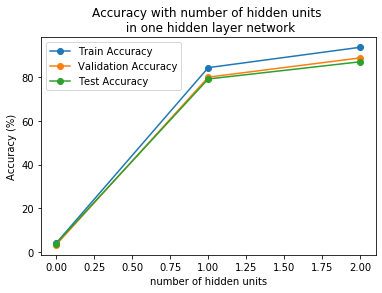

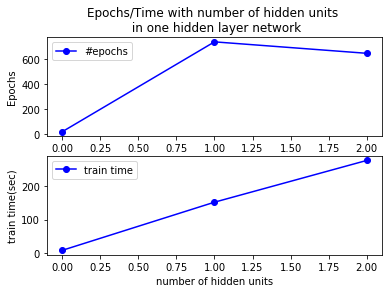

In [30]:
print("------------------Plotting Graphs for Part D - ReLU of 2 Hidden Layer ARCH ------------------")
x=[0,1,2]
plot_accuracy(x, train_accuracy, test_accuracy, valid_accuracy)
plot_epoch(x, epochs, train_time)

### Part F - Binary Cross Entropy With ReLU activation

In [31]:
print("----------------------------Running Part F-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with ReLU activation and Cross Entropy------------------")

----------------------------Running Part F-----------------------------------------------------
------------------Training a 100x100 hidden layer network with ReLU activation and Cross Entropy------------------


In [32]:
arch=[100, 100]
lr=0.01
theta = theta_init(arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'relu', 'constant', 'entropy')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'relu'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'relu'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'relu'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with ReLU are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with ReLU is = {}".format(epochs[-1]))
print("The training time with ReLU is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with ReLU is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with ReLU is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with ReLU is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 18.021600347332424
Error on this batch = 18.021536470296144
Error on this batch = 4.721606844908507
Cost on val dataset after 2 epochs is = 4.56012997167101
Initial Cost on Val dataset for this epoch 2 = 4.56012997167101
Error on this batch = 4.513362375190418
Error on this batch = 4.577966163503679
Cost on val dataset after 3 epochs is = 4.456844280213813
Initial Cost on Val dataset for this epoch 3 = 4.456844280213813
Error on this batch = 4.429736503326942
Error on this batch = 4.437601426903303
Cost on val dataset after 4 epochs is = 4.352287127864661
Initial Cost on Val dataset for this epoch 4 = 4.352287127864661
Error on this batch = 4.3426376258908475
Error on this batch = 4.32475326

Cost on val dataset after 41 epochs is = 3.785839437587601
Initial Cost on Val dataset for this epoch 41 = 3.785839437587601
Error on this batch = 3.807276254655775
Error on this batch = 3.8337757792000637
Cost on val dataset after 42 epochs is = 3.7505491921661545
Initial Cost on Val dataset for this epoch 42 = 3.7505491921661545
Error on this batch = 3.77395679872938
Error on this batch = 3.803958719646351
Cost on val dataset after 43 epochs is = 3.7170181943760574
Initial Cost on Val dataset for this epoch 43 = 3.7170181943760574
Error on this batch = 3.742078758315945
Error on this batch = 3.775450925406715
Cost on val dataset after 44 epochs is = 3.6851420554874754
Initial Cost on Val dataset for this epoch 44 = 3.6851420554874754
Error on this batch = 3.711473721554023
Error on this batch = 3.747929470791931
Cost on val dataset after 45 epochs is = 3.654799723964545
Initial Cost on Val dataset for this epoch 45 = 3.654799723964545
Error on this batch = 3.6820573420376865
Error on

Cost on val dataset after 81 epochs is = 3.0040505636917922
Initial Cost on Val dataset for this epoch 81 = 3.0040505636917922
Error on this batch = 2.9919335999897294
Error on this batch = 3.1123328941466912
Cost on val dataset after 82 epochs is = 2.991197451116832
Initial Cost on Val dataset for this epoch 82 = 2.991197451116832
Error on this batch = 2.9786130163540885
Error on this batch = 3.099696068418316
Cost on val dataset after 83 epochs is = 2.9783725386112527
Initial Cost on Val dataset for this epoch 83 = 2.9783725386112527
Error on this batch = 2.9653329228701346
Error on this batch = 3.087126097122757
Cost on val dataset after 84 epochs is = 2.965565474615156
Initial Cost on Val dataset for this epoch 84 = 2.965565474615156
Error on this batch = 2.9520391888964475
Error on this batch = 3.074519795781102
Cost on val dataset after 85 epochs is = 2.9527100330310754
Initial Cost on Val dataset for this epoch 85 = 2.9527100330310754
Error on this batch = 2.9386829549977858
Err

Cost on val dataset after 121 epochs is = 2.4630489608677877
Initial Cost on Val dataset for this epoch 121 = 2.4630489608677877
Error on this batch = 2.4479722336513645
Error on this batch = 2.5763838719207803
Cost on val dataset after 122 epochs is = 2.449327644616528
Initial Cost on Val dataset for this epoch 122 = 2.449327644616528
Error on this batch = 2.4342641028585192
Error on this batch = 2.5623862136436744
Cost on val dataset after 123 epochs is = 2.4355944826825864
Initial Cost on Val dataset for this epoch 123 = 2.4355944826825864
Error on this batch = 2.4205067220989354
Error on this batch = 2.5483847145320393
Cost on val dataset after 124 epochs is = 2.4219385421622857
Initial Cost on Val dataset for this epoch 124 = 2.4219385421622857
Error on this batch = 2.406869671843933
Error on this batch = 2.534336708551767
Cost on val dataset after 125 epochs is = 2.4083046862836346
Initial Cost on Val dataset for this epoch 125 = 2.4083046862836346
Error on this batch = 2.3932169

Cost on val dataset after 161 epochs is = 1.991710562752968
Initial Cost on Val dataset for this epoch 161 = 1.991710562752968
Error on this batch = 1.996981674866231
Error on this batch = 2.094986239678373
Cost on val dataset after 162 epochs is = 1.9828287791583852
Initial Cost on Val dataset for this epoch 162 = 1.9828287791583852
Error on this batch = 1.9887012296431459
Error on this batch = 2.0858694665399673
Cost on val dataset after 163 epochs is = 1.974103383670148
Initial Cost on Val dataset for this epoch 163 = 1.974103383670148
Error on this batch = 1.9805369899585652
Error on this batch = 2.076818626298979
Cost on val dataset after 164 epochs is = 1.965478034356185
Initial Cost on Val dataset for this epoch 164 = 1.965478034356185
Error on this batch = 1.972471663740219
Error on this batch = 2.067957038966146
Cost on val dataset after 165 epochs is = 1.9569896223853327
Initial Cost on Val dataset for this epoch 165 = 1.9569896223853327
Error on this batch = 1.96448657213963

Cost on val dataset after 201 epochs is = 1.7150616767862803
Initial Cost on Val dataset for this epoch 201 = 1.7150616767862803
Error on this batch = 1.7467455527493914
Error on this batch = 1.788990670035704
Cost on val dataset after 202 epochs is = 1.7096998169579014
Initial Cost on Val dataset for this epoch 202 = 1.7096998169579014
Error on this batch = 1.7417974765690938
Error on this batch = 1.7825527479944858
Cost on val dataset after 203 epochs is = 1.7043885140368138
Initial Cost on Val dataset for this epoch 203 = 1.7043885140368138
Error on this batch = 1.7369344946786576
Error on this batch = 1.7761906431794443
Cost on val dataset after 204 epochs is = 1.699123206728687
Initial Cost on Val dataset for this epoch 204 = 1.699123206728687
Error on this batch = 1.7321213546724932
Error on this batch = 1.7700274702614518
Cost on val dataset after 205 epochs is = 1.6939114178836248
Initial Cost on Val dataset for this epoch 205 = 1.6939114178836248
Error on this batch = 1.727403

Cost on val dataset after 241 epochs is = 1.539921862997831
Initial Cost on Val dataset for this epoch 241 = 1.539921862997831
Error on this batch = 1.5839177534412148
Error on this batch = 1.5809232568799672
Cost on val dataset after 242 epochs is = 1.5364398132857087
Initial Cost on Val dataset for this epoch 242 = 1.5364398132857087
Error on this batch = 1.5804561291761368
Error on this batch = 1.576921440604226
Cost on val dataset after 243 epochs is = 1.533008785178036
Initial Cost on Val dataset for this epoch 243 = 1.533008785178036
Error on this batch = 1.5770600888511446
Error on this batch = 1.5728132953671576
Cost on val dataset after 244 epochs is = 1.529603802082735
Initial Cost on Val dataset for this epoch 244 = 1.529603802082735
Error on this batch = 1.5737181196246206
Error on this batch = 1.568671041804079
Cost on val dataset after 245 epochs is = 1.5262755666836225
Initial Cost on Val dataset for this epoch 245 = 1.5262755666836225
Error on this batch = 1.57038790761

Cost on val dataset after 281 epochs is = 1.4283091213749222
Initial Cost on Val dataset for this epoch 281 = 1.4283091213749222
Error on this batch = 1.4686289233882526
Error on this batch = 1.4340699674773856
Cost on val dataset after 282 epochs is = 1.4261835105760812
Initial Cost on Val dataset for this epoch 282 = 1.4261835105760812
Error on this batch = 1.466171093041411
Error on this batch = 1.4310329719422321
Cost on val dataset after 283 epochs is = 1.4240906731623426
Initial Cost on Val dataset for this epoch 283 = 1.4240906731623426
Error on this batch = 1.463732110294631
Error on this batch = 1.4279807575873695
Cost on val dataset after 284 epochs is = 1.4219814493483762
Initial Cost on Val dataset for this epoch 284 = 1.4219814493483762
Error on this batch = 1.461244849563617
Error on this batch = 1.4249251688785574
Cost on val dataset after 285 epochs is = 1.41987579248408
Initial Cost on Val dataset for this epoch 285 = 1.41987579248408
Error on this batch = 1.4588745625

Cost on val dataset after 321 epochs is = 1.3572489082166985
Initial Cost on Val dataset for this epoch 321 = 1.3572489082166985
Error on this batch = 1.383353887751865
Error on this batch = 1.3365860997737327
Cost on val dataset after 322 epochs is = 1.35586031077873
Initial Cost on Val dataset for this epoch 322 = 1.35586031077873
Error on this batch = 1.381656634432055
Error on this batch = 1.3345687167381588
Cost on val dataset after 323 epochs is = 1.3544674535071657
Initial Cost on Val dataset for this epoch 323 = 1.3544674535071657
Error on this batch = 1.3800438980791403
Error on this batch = 1.3325535758011098
Cost on val dataset after 324 epochs is = 1.3531486021968422
Initial Cost on Val dataset for this epoch 324 = 1.3531486021968422
Error on this batch = 1.3784732070839536
Error on this batch = 1.3305750089206039
Cost on val dataset after 325 epochs is = 1.3517972052641032
Initial Cost on Val dataset for this epoch 325 = 1.3517972052641032
Error on this batch = 1.376955743

Cost on val dataset after 361 epochs is = 1.31700220268459
Initial Cost on Val dataset for this epoch 361 = 1.31700220268459
Error on this batch = 1.3383190743316744
Error on this batch = 1.2653747993040871
Cost on val dataset after 362 epochs is = 1.3163559783976315
Initial Cost on Val dataset for this epoch 362 = 1.3163559783976315
Error on this batch = 1.3377622860309961
Error on this batch = 1.2641159476223436
Cost on val dataset after 363 epochs is = 1.3157464147886528
Initial Cost on Val dataset for this epoch 363 = 1.3157464147886528
Error on this batch = 1.3371106392391634
Error on this batch = 1.262728349313729
Cost on val dataset after 364 epochs is = 1.3151534203201263
Initial Cost on Val dataset for this epoch 364 = 1.3151534203201263
Error on this batch = 1.336522234794214
Error on this batch = 1.2614102402685416
Cost on val dataset after 365 epochs is = 1.3145626544654505
Initial Cost on Val dataset for this epoch 365 = 1.3145626544654505
Error on this batch = 1.335938156

Cost on val dataset after 400 epochs is = 1.3003449117483947
Initial Cost on Val dataset for this epoch 400 = 1.3003449117483947
Error on this batch = 1.3263643798146947
Error on this batch = 1.2175939027205096
Cost on val dataset after 401 epochs is = 1.3001084234003466
Initial Cost on Val dataset for this epoch 401 = 1.3001084234003466
Error on this batch = 1.3263715337597868
Error on this batch = 1.216635138988163
Cost on val dataset after 402 epochs is = 1.2998372972525536
Initial Cost on Val dataset for this epoch 402 = 1.2998372972525536
Error on this batch = 1.326327366479958
Error on this batch = 1.2157258775809123
Cost on val dataset after 403 epochs is = 1.2995918238702162
Initial Cost on Val dataset for this epoch 403 = 1.2995918238702162
Error on this batch = 1.3263087985335795
Error on this batch = 1.2147658017959087
Cost on val dataset after 404 epochs is = 1.2993622610677165
Initial Cost on Val dataset for this epoch 404 = 1.2993622610677165
Error on this batch = 1.32633

Cost on val dataset after 440 epochs is = 1.2926343932071798
Initial Cost on Val dataset for this epoch 440 = 1.2926343932071798
Error on this batch = 1.3232705640719769
Error on this batch = 1.1818904809535562
Cost on val dataset after 441 epochs is = 1.2924297989738855
Initial Cost on Val dataset for this epoch 441 = 1.2924297989738855
Error on this batch = 1.3230858940187786
Error on this batch = 1.181240071566774
Cost on val dataset after 442 epochs is = 1.292283633022897
Initial Cost on Val dataset for this epoch 442 = 1.292283633022897
Error on this batch = 1.3228260239924077
Error on this batch = 1.1806414959045883
Cost on val dataset after 443 epochs is = 1.2920895233163194
Initial Cost on Val dataset for this epoch 443 = 1.2920895233163194
Error on this batch = 1.3226496624249513
Error on this batch = 1.1799664903706915
Cost on val dataset after 444 epochs is = 1.2919053046317164
Initial Cost on Val dataset for this epoch 444 = 1.2919053046317164
Error on this batch = 1.322399

Cost on val dataset after 480 epochs is = 1.2881828682963077
Initial Cost on Val dataset for this epoch 480 = 1.2881828682963077
Error on this batch = 1.324396079807886
Error on this batch = 1.152170006679838
Cost on val dataset after 481 epochs is = 1.2881228943022063
Initial Cost on Val dataset for this epoch 481 = 1.2881228943022063
Error on this batch = 1.324371394719051
Error on this batch = 1.151354046258436
Cost on val dataset after 482 epochs is = 1.288072097970333
Initial Cost on Val dataset for this epoch 482 = 1.288072097970333
Error on this batch = 1.3242483528045512
Error on this batch = 1.1505871883211511
Cost on val dataset after 483 epochs is = 1.2880453011274724
Initial Cost on Val dataset for this epoch 483 = 1.2880453011274724
Error on this batch = 1.324218029410272
Error on this batch = 1.1497696869474632
Cost on val dataset after 484 epochs is = 1.2879806250798673
Initial Cost on Val dataset for this epoch 484 = 1.2879806250798673
Error on this batch = 1.3241537635

Cost on val dataset after 520 epochs is = 1.2860756800738977
Initial Cost on Val dataset for this epoch 520 = 1.2860756800738977
Error on this batch = 1.3104859194765168
Error on this batch = 1.128214396163025
Cost on val dataset after 521 epochs is = 1.2859392420283513
Initial Cost on Val dataset for this epoch 521 = 1.2859392420283513
Error on this batch = 1.3099084013947362
Error on this batch = 1.1278103651678724
Cost on val dataset after 522 epochs is = 1.2858318959575727
Initial Cost on Val dataset for this epoch 522 = 1.2858318959575727
Error on this batch = 1.3092542010218449
Error on this batch = 1.1274163691940038
Cost on val dataset after 523 epochs is = 1.285700788763582
Initial Cost on Val dataset for this epoch 523 = 1.285700788763582
Error on this batch = 1.308670170065428
Error on this batch = 1.1269719734979362
Cost on val dataset after 524 epochs is = 1.2855517155276999
Initial Cost on Val dataset for this epoch 524 = 1.2855517155276999
Error on this batch = 1.3080896

Cost on val dataset after 559 epochs is = 1.2789265334394517
Initial Cost on Val dataset for this epoch 559 = 1.2789265334394517
Error on this batch = 1.2762986996245838
Error on this batch = 1.113494466981023
Cost on val dataset after 560 epochs is = 1.2786927775570693
Initial Cost on Val dataset for this epoch 560 = 1.2786927775570693
Error on this batch = 1.2750630102023228
Error on this batch = 1.1128407556212776
Cost on val dataset after 561 epochs is = 1.2785156282510597
Initial Cost on Val dataset for this epoch 561 = 1.2785156282510597
Error on this batch = 1.2738647158227965
Error on this batch = 1.1122373869477737
Cost on val dataset after 562 epochs is = 1.278284060842955
Initial Cost on Val dataset for this epoch 562 = 1.278284060842955
Error on this batch = 1.2727047533748133
Error on this batch = 1.111589940474
Cost on val dataset after 563 epochs is = 1.2780985559298192
Initial Cost on Val dataset for this epoch 563 = 1.2780985559298192
Error on this batch = 1.2716073527

Cost on val dataset after 599 epochs is = 1.2685343847116248
Initial Cost on Val dataset for this epoch 599 = 1.2685343847116248
Error on this batch = 1.2286498559281356
Error on this batch = 1.081980246241146
Cost on val dataset after 600 epochs is = 1.268311153282477
Initial Cost on Val dataset for this epoch 600 = 1.268311153282477
Error on this batch = 1.227494970084033
Error on this batch = 1.0811623223676712
Cost on val dataset after 601 epochs is = 1.2680829183228626
Initial Cost on Val dataset for this epoch 601 = 1.2680829183228626
Error on this batch = 1.2264241951940889
Error on this batch = 1.0803106942823015
Cost on val dataset after 602 epochs is = 1.26784454314232
Initial Cost on Val dataset for this epoch 602 = 1.26784454314232
Error on this batch = 1.22537834354423
Error on this batch = 1.0795481867765222
Cost on val dataset after 603 epochs is = 1.2675790788089876
Initial Cost on Val dataset for this epoch 603 = 1.2675790788089876
Error on this batch = 1.2243065103700

Cost on val dataset after 639 epochs is = 1.258884987604284
Initial Cost on Val dataset for this epoch 639 = 1.258884987604284
Error on this batch = 1.1933949458770292
Error on this batch = 1.0564133615378808
Cost on val dataset after 640 epochs is = 1.2586036356693366
Initial Cost on Val dataset for this epoch 640 = 1.2586036356693366
Error on this batch = 1.1927155975640644
Error on this batch = 1.0557827542110447
Cost on val dataset after 641 epochs is = 1.2583393921280708
Initial Cost on Val dataset for this epoch 641 = 1.2583393921280708
Error on this batch = 1.1920697979179702
Error on this batch = 1.0552000137801678
Cost on val dataset after 642 epochs is = 1.2581122852385123
Initial Cost on Val dataset for this epoch 642 = 1.2581122852385123
Error on this batch = 1.1913968013749483
Error on this batch = 1.0546851987680033
Cost on val dataset after 643 epochs is = 1.257813548469519
Initial Cost on Val dataset for this epoch 643 = 1.257813548469519
Error on this batch = 1.1907098

Cost on val dataset after 679 epochs is = 1.2510052501583786
Initial Cost on Val dataset for this epoch 679 = 1.2510052501583786
Error on this batch = 1.1739482213131425
Error on this batch = 1.0423591607103393
Cost on val dataset after 680 epochs is = 1.2509158617692393
Initial Cost on Val dataset for this epoch 680 = 1.2509158617692393
Error on this batch = 1.1736025349002497
Error on this batch = 1.0421760591772131
Cost on val dataset after 681 epochs is = 1.2507590621927551
Initial Cost on Val dataset for this epoch 681 = 1.2507590621927551
Error on this batch = 1.1733342049368571
Error on this batch = 1.0420570437424348
Cost on val dataset after 682 epochs is = 1.2506956226986656
Initial Cost on Val dataset for this epoch 682 = 1.2506956226986656
Error on this batch = 1.1728484614643955
Error on this batch = 1.0419048529909514
Cost on val dataset after 683 epochs is = 1.2505381163855864
Initial Cost on Val dataset for this epoch 683 = 1.2505381163855864
Error on this batch = 1.172

Cost on val dataset after 719 epochs is = 1.2477408796243477
Initial Cost on Val dataset for this epoch 719 = 1.2477408796243477
Error on this batch = 1.161466421720535
Error on this batch = 1.043448051316425
Cost on val dataset after 720 epochs is = 1.2477606717993341
Initial Cost on Val dataset for this epoch 720 = 1.2477606717993341
Error on this batch = 1.1612980253315386
Error on this batch = 1.0437690682787566
Cost on val dataset after 721 epochs is = 1.2477903252889901
Initial Cost on Val dataset for this epoch 721 = 1.2477903252889901
Error on this batch = 1.1610434439986912
Error on this batch = 1.0440717635809396
Cost on val dataset after 722 epochs is = 1.2478107510535783
Initial Cost on Val dataset for this epoch 722 = 1.2478107510535783
Error on this batch = 1.1607306938124753
Error on this batch = 1.044449558717463
Cost on val dataset after 723 epochs is = 1.2478626005354152
Initial Cost on Val dataset for this epoch 723 = 1.2478626005354152
Error on this batch = 1.160491

Cost on val dataset after 758 epochs is = 1.2488135795792412
Initial Cost on Val dataset for this epoch 758 = 1.2488135795792412
Error on this batch = 1.1479888172321595
Error on this batch = 1.05451186734511
Cost on val dataset after 759 epochs is = 1.2489050184901125
Initial Cost on Val dataset for this epoch 759 = 1.2489050184901125
Error on this batch = 1.1476939546934295
Error on this batch = 1.0546665215196729
Cost on val dataset after 760 epochs is = 1.249057790726658
Initial Cost on Val dataset for this epoch 760 = 1.249057790726658
Error on this batch = 1.1473383859665014
Error on this batch = 1.054743168060637
Cost on val dataset after 761 epochs is = 1.249218929756606
Initial Cost on Val dataset for this epoch 761 = 1.249218929756606
Error on this batch = 1.147006557439064
Error on this batch = 1.0547601383261553
Cost on val dataset after 762 epochs is = 1.249286987927426
Initial Cost on Val dataset for this epoch 762 = 1.249286987927426
Error on this batch = 1.1466372723401

In [33]:
print("----------------------------Running Part F-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with Softplus activation and Cross Entropy------------------")

----------------------------Running Part F-----------------------------------------------------
------------------Training a 100x100 hidden layer network with Softplus activation and Cross Entropy------------------


In [34]:
arch=[100, 100]
lr=0.01
theta = theta_init(arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'softplus', 'constant', 'entropy')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'softplus'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'softplus'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'softplus'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with softplus are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with softplus is = {}".format(epochs[-1]))
print("The training time with softplus is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with softplus is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with softplus is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with softplus is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 17.79930707269973
Error on this batch = 17.798850660093787
Error on this batch = 4.242320062907244
Cost on val dataset after 2 epochs is = 4.239341835977998
Initial Cost on Val dataset for this epoch 2 = 4.239341835977998
Error on this batch = 4.24528973947412
Error on this batch = 4.241048948279419
Cost on val dataset after 3 epochs is = 4.239311850035421
Initial Cost on Val dataset for this epoch 3 = 4.239311850035421
Error on this batch = 4.245141821538494
Error on this batch = 4.241001982877593
Cost on val dataset after 4 epochs is = 4.2392651373967505
Initial Cost on Val dataset for this epoch 4 = 4.2392651373967505
Error on this batch = 4.245080699430166
Error on this batch = 4.2409603

Error on this batch = 4.2389585509036465
Cost on val dataset after 41 epochs is = 4.237164158946532
Initial Cost on Val dataset for this epoch 41 = 4.237164158946532
Error on this batch = 4.242545072557935
Error on this batch = 4.238816681121341
Cost on val dataset after 42 epochs is = 4.237020341126022
Initial Cost on Val dataset for this epoch 42 = 4.237020341126022
Error on this batch = 4.242391606399556
Error on this batch = 4.238661106332444
Cost on val dataset after 43 epochs is = 4.2368621900555885
Initial Cost on Val dataset for this epoch 43 = 4.2368621900555885
Error on this batch = 4.24222397208085
Error on this batch = 4.238489910162424
Cost on val dataset after 44 epochs is = 4.236687629834096
Initial Cost on Val dataset for this epoch 44 = 4.236687629834096
Error on this batch = 4.242040113081194
Error on this batch = 4.238300834604428
Cost on val dataset after 45 epochs is = 4.236494205704633
Initial Cost on Val dataset for this epoch 45 = 4.236494205704633
Error on this

Error on this batch = 3.3757681681242127
Cost on val dataset after 81 epochs is = 3.36174734676518
Initial Cost on Val dataset for this epoch 81 = 3.36174734676518
Error on this batch = 3.317243335943758
Error on this batch = 3.3496587767811197
Cost on val dataset after 82 epochs is = 3.3360692544392285
Initial Cost on Val dataset for this epoch 82 = 3.3360692544392285
Error on this batch = 3.288121734684878
Error on this batch = 3.329331950419337
Cost on val dataset after 83 epochs is = 3.3146835751255064
Initial Cost on Val dataset for this epoch 83 = 3.3146835751255064
Error on this batch = 3.263875532859844
Error on this batch = 3.3122514022727536
Cost on val dataset after 84 epochs is = 3.295811604950206
Initial Cost on Val dataset for this epoch 84 = 3.295811604950206
Error on this batch = 3.242523324658414
Error on this batch = 3.2969580864023573
Cost on val dataset after 85 epochs is = 3.278370123014668
Initial Cost on Val dataset for this epoch 85 = 3.278370123014668
Error on 

Error on this batch = 2.524941744034021
Cost on val dataset after 121 epochs is = 2.4821805709768543
Initial Cost on Val dataset for this epoch 121 = 2.4821805709768543
Error on this batch = 2.402543935958444
Error on this batch = 2.4998627297553693
Cost on val dataset after 122 epochs is = 2.451487562727652
Initial Cost on Val dataset for this epoch 122 = 2.451487562727652
Error on this batch = 2.3742020822701506
Error on this batch = 2.4737022850522328
Cost on val dataset after 123 epochs is = 2.418923730115471
Initial Cost on Val dataset for this epoch 123 = 2.418923730115471
Error on this batch = 2.3446520210849275
Error on this batch = 2.4465025931850413
Cost on val dataset after 124 epochs is = 2.384620946103602
Initial Cost on Val dataset for this epoch 124 = 2.384620946103602
Error on this batch = 2.3140836210399076
Error on this batch = 2.4183561670384797
Cost on val dataset after 125 epochs is = 2.3489692076932913
Initial Cost on Val dataset for this epoch 125 = 2.34896920769

Cost on val dataset after 160 epochs is = 1.610106626716654
Initial Cost on Val dataset for this epoch 160 = 1.610106626716654
Error on this batch = 1.7125981235648737
Error on this batch = 1.7495034643767287
Cost on val dataset after 161 epochs is = 1.593053064386903
Initial Cost on Val dataset for this epoch 161 = 1.593053064386903
Error on this batch = 1.7000586683545167
Error on this batch = 1.732414455773092
Cost on val dataset after 162 epochs is = 1.576239499408904
Initial Cost on Val dataset for this epoch 162 = 1.576239499408904
Error on this batch = 1.687472137895828
Error on this batch = 1.715257774385227
Cost on val dataset after 163 epochs is = 1.5597283984718147
Initial Cost on Val dataset for this epoch 163 = 1.5597283984718147
Error on this batch = 1.6748834968568724
Error on this batch = 1.698063905235032
Cost on val dataset after 164 epochs is = 1.5435805198158055
Initial Cost on Val dataset for this epoch 164 = 1.5435805198158055
Error on this batch = 1.6623370653694

Error on this batch = 1.2627695057303103
Cost on val dataset after 200 epochs is = 1.2279600349594333
Initial Cost on Val dataset for this epoch 200 = 1.2279600349594333
Error on this batch = 1.354256288008021
Error on this batch = 1.2559510835380034
Cost on val dataset after 201 epochs is = 1.2231531240154354
Initial Cost on Val dataset for this epoch 201 = 1.2231531240154354
Error on this batch = 1.3479507780057967
Error on this batch = 1.2492841052300891
Cost on val dataset after 202 epochs is = 1.2184293491032379
Initial Cost on Val dataset for this epoch 202 = 1.2184293491032379
Error on this batch = 1.3416651823817316
Error on this batch = 1.2427576655372392
Cost on val dataset after 203 epochs is = 1.2137859861211602
Initial Cost on Val dataset for this epoch 203 = 1.2137859861211602
Error on this batch = 1.3353994043443327
Error on this batch = 1.2363613606712995
Cost on val dataset after 204 epochs is = 1.2092207797239205
Initial Cost on Val dataset for this epoch 204 = 1.2092

Error on this batch = 1.0480781490076054
Cost on val dataset after 239 epochs is = 1.087415958978241
Initial Cost on Val dataset for this epoch 239 = 1.087415958978241
Error on this batch = 1.1237512098620304
Error on this batch = 1.043322242368044
Cost on val dataset after 240 epochs is = 1.0847153440264854
Initial Cost on Val dataset for this epoch 240 = 1.0847153440264854
Error on this batch = 1.1185687934402544
Error on this batch = 1.0386116899464404
Cost on val dataset after 241 epochs is = 1.082046193420073
Initial Cost on Val dataset for this epoch 241 = 1.082046193420073
Error on this batch = 1.1134540175771634
Error on this batch = 1.0339478583267785
Cost on val dataset after 242 epochs is = 1.0794080620165556
Initial Cost on Val dataset for this epoch 242 = 1.0794080620165556
Error on this batch = 1.1084085004423103
Error on this batch = 1.0293320099620697
Cost on val dataset after 243 epochs is = 1.0768005270850207
Initial Cost on Val dataset for this epoch 243 = 1.07680052

Error on this batch = 0.8996541509278541
Cost on val dataset after 278 epochs is = 1.0015751042659038
Initial Cost on Val dataset for this epoch 278 = 1.0015751042659038
Error on this batch = 0.9707565137540765
Error on this batch = 0.896729167947959
Cost on val dataset after 279 epochs is = 0.9997827644432947
Initial Cost on Val dataset for this epoch 279 = 0.9997827644432947
Error on this batch = 0.9678379649380782
Error on this batch = 0.8938350232348634
Cost on val dataset after 280 epochs is = 0.9980047107807068
Initial Cost on Val dataset for this epoch 280 = 0.9980047107807068
Error on this batch = 0.964947533719259
Error on this batch = 0.8909706307337989
Cost on val dataset after 281 epochs is = 0.996240561525335
Initial Cost on Val dataset for this epoch 281 = 0.996240561525335
Error on this batch = 0.9620838504757471
Error on this batch = 0.8881349220793961
Cost on val dataset after 282 epochs is = 0.9944899448467304
Initial Cost on Val dataset for this epoch 282 = 0.9944899

Error on this batch = 0.8003463631785701
Cost on val dataset after 317 epochs is = 0.9394366980306652
Initial Cost on Val dataset for this epoch 317 = 0.9394366980306652
Error on this batch = 0.8686706089510017
Error on this batch = 0.7980268536208084
Cost on val dataset after 318 epochs is = 0.9379900519376358
Initial Cost on Val dataset for this epoch 318 = 0.9379900519376358
Error on this batch = 0.8661934061095482
Error on this batch = 0.7957127047927983
Cost on val dataset after 319 epochs is = 0.9365483965850688
Initial Cost on Val dataset for this epoch 319 = 0.9365483965850688
Error on this batch = 0.8637176241671034
Error on this batch = 0.7934036773115315
Cost on val dataset after 320 epochs is = 0.9351116392035421
Initial Cost on Val dataset for this epoch 320 = 0.9351116392035421
Error on this batch = 0.8612430804318205
Error on this batch = 0.7910995455653699
Cost on val dataset after 321 epochs is = 0.9336796944155972
Initial Cost on Val dataset for this epoch 321 = 0.933

Error on this batch = 0.7124701781104833
Cost on val dataset after 356 epochs is = 0.8863619479650463
Initial Cost on Val dataset for this epoch 356 = 0.8863619479650463
Error on this batch = 0.7724858298381255
Error on this batch = 0.7102631928889455
Cost on val dataset after 357 epochs is = 0.8850921749447156
Initial Cost on Val dataset for this epoch 357 = 0.8850921749447156
Error on this batch = 0.7700359169790812
Error on this batch = 0.7080578534392487
Cost on val dataset after 358 epochs is = 0.8838273875308994
Initial Cost on Val dataset for this epoch 358 = 0.8838273875308994
Error on this batch = 0.7675879144808373
Error on this batch = 0.7058541407171717
Cost on val dataset after 359 epochs is = 0.8825676315006373
Initial Cost on Val dataset for this epoch 359 = 0.8825676315006373
Error on this batch = 0.7651419395132802
Error on this batch = 0.7036520379782956
Cost on val dataset after 360 epochs is = 0.8813129527995888
Initial Cost on Val dataset for this epoch 360 = 0.881

Error on this batch = 0.6276337606699949
Cost on val dataset after 395 epochs is = 0.8409253032252869
Initial Cost on Val dataset for this epoch 395 = 0.8409253032252869
Error on this batch = 0.6794787332191689
Error on this batch = 0.625498010908223
Cost on val dataset after 396 epochs is = 0.8398798469795767
Initial Cost on Val dataset for this epoch 396 = 0.8398798469795767
Error on this batch = 0.6771944785828674
Error on this batch = 0.6233648699020014
Cost on val dataset after 397 epochs is = 0.8388407324608523
Initial Cost on Val dataset for this epoch 397 = 0.8388407324608523
Error on this batch = 0.6749168735923133
Error on this batch = 0.621234405526893
Cost on val dataset after 398 epochs is = 0.8378079751935559
Initial Cost on Val dataset for this epoch 398 = 0.8378079751935559
Error on this batch = 0.6726460291323239
Error on this batch = 0.6191066873777632
Cost on val dataset after 399 epochs is = 0.8367815896485188
Initial Cost on Val dataset for this epoch 399 = 0.83678

Error on this batch = 0.5469875889218161
Cost on val dataset after 434 epochs is = 0.8049107639060937
Initial Cost on Val dataset for this epoch 434 = 0.8049107639060937
Error on this batch = 0.59623174246784
Error on this batch = 0.5450127018126699
Cost on val dataset after 435 epochs is = 0.8041150524980737
Initial Cost on Val dataset for this epoch 435 = 0.8041150524980737
Error on this batch = 0.5942769257140208
Error on this batch = 0.543043556184396
Cost on val dataset after 436 epochs is = 0.8033255678113722
Initial Cost on Val dataset for this epoch 436 = 0.8033255678113722
Error on this batch = 0.5923320004978966
Error on this batch = 0.5410802221353446
Cost on val dataset after 437 epochs is = 0.8025422892921589
Initial Cost on Val dataset for this epoch 437 = 0.8025422892921589
Error on this batch = 0.5903970096988788
Error on this batch = 0.53912276830271
Cost on val dataset after 438 epochs is = 0.8017651956416811
Initial Cost on Val dataset for this epoch 438 = 0.80176519

Error on this batch = 0.47473237543828384
Cost on val dataset after 473 epochs is = 0.7782559145031694
Initial Cost on Val dataset for this epoch 473 = 0.7782559145031694
Error on this batch = 0.5275078727414011
Error on this batch = 0.47301883881229073
Cost on val dataset after 474 epochs is = 0.777682948703375
Initial Cost on Val dataset for this epoch 474 = 0.777682948703375
Error on this batch = 0.5259477529052274
Error on this batch = 0.4713125950911342
Cost on val dataset after 475 epochs is = 0.777115082634532
Initial Cost on Val dataset for this epoch 475 = 0.777115082634532
Error on this batch = 0.524397385230236
Error on this batch = 0.4696136524890227
Cost on val dataset after 476 epochs is = 0.7765522858914072
Initial Cost on Val dataset for this epoch 476 = 0.7765522858914072
Error on this batch = 0.5228567231449935
Error on this batch = 0.4679220177573007
Cost on val dataset after 477 epochs is = 0.7759945283171411
Initial Cost on Val dataset for this epoch 477 = 0.775994

Error on this batch = 0.4132743454833725
Cost on val dataset after 512 epochs is = 0.7594344769695388
Initial Cost on Val dataset for this epoch 512 = 0.7594344769695388
Error on this batch = 0.47334661497342295
Error on this batch = 0.4118396132649862
Cost on val dataset after 513 epochs is = 0.7590404283347029
Initial Cost on Val dataset for this epoch 513 = 0.7590404283347029
Error on this batch = 0.4721199695718611
Error on this batch = 0.41041160649869135
Cost on val dataset after 514 epochs is = 0.7586504936919695
Initial Cost on Val dataset for this epoch 514 = 0.7586504936919695
Error on this batch = 0.4709003516398427
Error on this batch = 0.408990293478609
Cost on val dataset after 515 epochs is = 0.7582646518360291
Initial Cost on Val dataset for this epoch 515 = 0.7582646518360291
Error on this batch = 0.46968767667381545
Error on this batch = 0.4075756420137987
Cost on val dataset after 516 epochs is = 0.757882881652506
Initial Cost on Val dataset for this epoch 516 = 0.75

Error on this batch = 0.36198575240151265
Cost on val dataset after 551 epochs is = 0.7469255123655515
Initial Cost on Val dataset for this epoch 551 = 0.7469255123655515
Error on this batch = 0.42994730855105423
Error on this batch = 0.3607870526222397
Cost on val dataset after 552 epochs is = 0.7466766142991388
Initial Cost on Val dataset for this epoch 552 = 0.7466766142991388
Error on this batch = 0.42893325542061433
Error on this batch = 0.3595936586975212
Cost on val dataset after 553 epochs is = 0.7464310326874246
Initial Cost on Val dataset for this epoch 553 = 0.7464310326874246
Error on this batch = 0.42792310313492965
Error on this batch = 0.3584055332020353
Cost on val dataset after 554 epochs is = 0.7461887478854429
Initial Cost on Val dataset for this epoch 554 = 0.7461887478854429
Error on this batch = 0.42691678330012506
Error on this batch = 0.35722263881770305
Cost on val dataset after 555 epochs is = 0.7459497403462538
Initial Cost on Val dataset for this epoch 555 =

Error on this batch = 0.31883910044876634
Cost on val dataset after 590 epochs is = 0.7395086809028905
Initial Cost on Val dataset for this epoch 590 = 0.7395086809028905
Error on this batch = 0.3927403120298293
Error on this batch = 0.3178211465722793
Cost on val dataset after 591 epochs is = 0.7393760402631688
Initial Cost on Val dataset for this epoch 591 = 0.7393760402631688
Error on this batch = 0.39183623672914153
Error on this batch = 0.3168071762756945
Cost on val dataset after 592 epochs is = 0.7392460828693129
Initial Cost on Val dataset for this epoch 592 = 0.7392460828693129
Error on this batch = 0.39093410019279895
Error on this batch = 0.31579716026862736
Cost on val dataset after 593 epochs is = 0.7391187972112218
Initial Cost on Val dataset for this epoch 593 = 0.7391187972112218
Error on this batch = 0.39003387215418556
Error on this batch = 0.31479106950457547
Cost on val dataset after 594 epochs is = 0.7389941720392318
Initial Cost on Val dataset for this epoch 594 =

Error on this batch = 0.2818438899994616
Cost on val dataset after 629 epochs is = 0.7362398341546462
Initial Cost on Val dataset for this epoch 629 = 0.7362398341546462
Error on this batch = 0.35871614415028263
Error on this batch = 0.28096195537999336
Cost on val dataset after 630 epochs is = 0.7362056292742449
Initial Cost on Val dataset for this epoch 630 = 0.7362056292742449
Error on this batch = 0.3578733095464203
Error on this batch = 0.280083060983725
Cost on val dataset after 631 epochs is = 0.7361738433567258
Initial Cost on Val dataset for this epoch 631 = 0.7361738433567258
Error on this batch = 0.3570318508074735
Error on this batch = 0.27920718881209045
Cost on val dataset after 632 epochs is = 0.7361444741389426
Initial Cost on Val dataset for this epoch 632 = 0.7361444741389426
Error on this batch = 0.3561917661684946
Error on this batch = 0.2783343212101079
Cost on val dataset after 633 epochs is = 0.7361175195411634
Initial Cost on Val dataset for this epoch 633 = 0.7

Error on this batch = 0.24956330494396553
Cost on val dataset after 668 epochs is = 0.7366897192782357
Initial Cost on Val dataset for this epoch 668 = 0.7366897192782357
Error on this batch = 0.32687465354993495
Error on this batch = 0.2487894545028791
Cost on val dataset after 669 epochs is = 0.7367494234774579
Initial Cost on Val dataset for this epoch 669 = 0.7367494234774579
Error on this batch = 0.32608680825924696
Error on this batch = 0.24801815835185692
Cost on val dataset after 670 epochs is = 0.7368115461954616
Initial Cost on Val dataset for this epoch 670 = 0.7368115461954616
Error on this batch = 0.3253004569415668
Error on this batch = 0.2472494079871239
Cost on val dataset after 671 epochs is = 0.7368760884353179
Initial Cost on Val dataset for this epoch 671 = 0.7368760884353179
Error on this batch = 0.32451560509421046
Error on this batch = 0.24648319498246798
Cost on val dataset after 672 epochs is = 0.7369430511883756
Initial Cost on Val dataset for this epoch 672 =

## Part E - MLP Classifier using SKLEARN

In [35]:
print("----------------------------Running Part E-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with MLP Classifier------------------")

----------------------------Running Part E-----------------------------------------------------
------------------Training a 100x100 hidden layer network with MLP Classifier------------------


In [36]:
from sklearn.neural_network import MLPClassifier as mlp_classifier
PATH = os.getcwd()
os.chdir('Alphabets/')
X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features
train_class_enc = pd.get_dummies(train_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

In [37]:
epochs = []
train_accuracy = []
test_accuracy = []
train_time = []
clf=[]

In [38]:
#Classifier - logistic with constant LR
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     tol=1e-4, verbose=True))
#Classifier - logistic with early_stopping =True
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     early_stopping=True, tol=1e-4, verbose=True))
#Classifier - logistic with invscaling with sqrt
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.5, learning_rate='invscaling', max_iter=400,
                     tol=1e-4, verbose=True))
#Classifier - logistic with invscaling with pow(1/3)
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.5, learning_rate='invscaling', max_iter=400,
                     power_t=(1/3), tol=1e-4, verbose=True))


#Classifier ReLU with constant LR (1e-4)
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     tol=1e-4, verbose=True))
#Classifier ReLU with constant LR (1e-6)
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     tol=1e-6, verbose=True))
#Classifier ReLU with constant LR (1e-6) with early stopping
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     early_stopping=True, tol=1e-6, verbose=True))
#Classifier ReLU with constant LR (1e-6) with invscaling sqrt
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.5, learning_rate='invscaling', max_iter=400,
                     tol=1e-6, verbose=True))
#Classifier ReLU with constant LR (1e-6) with invscaling pow(1/3)
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.5, learning_rate='invscaling', max_iter=400,
                     power_t=(1/3), tol=1e-6, verbose=True))

In [39]:
for i in range(len(clf)):
    print("--------Training the classifier with following params--------------")
    print("-------------------------------------------------------------------")
    print(clf[i])
    print("-------------------------------------------------------------------")
    start =time.time()
    clf[i].fit(X_train, train_class_enc)
    end = time.time()
    epochs.append(clf[i].n_iter_)
    train_accuracy.append(clf[i].score(X_train, train_class_enc)*100)
    test_accuracy.append(clf[i].score(X_test, test_actual_class_enc)*100)
    train_time.append(end-start)
    print("The training Accuracy achieved is = {:2.3f}".format(train_accuracy[-1]))
    print("The test Accuracy achieved is = {:2.3f}".format(test_accuracy[-1]))    
    print("The number of epochs is = {}".format(epochs[-1]))    
    print("The training time achieved is = {:2.3f}".format(train_time[-1]))    

--------Training the classifier with following params--------------
-------------------------------------------------------------------
MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)
-------------------------------------------------------------------
Iteration 1, loss = 4.39802570
Iteration 2, loss = 3.70826397
Iteration 3, loss = 2.66074108
Iteration 4, loss = 1.95484420
Iteration 5, loss = 1.51423787
Iteration 6, loss = 1.22687090
Iteration 7, loss = 1.03713829
Iteration 8, loss = 0.90937104
Iteration 9, loss = 0.81076417
Iter

Iteration 42, loss = 0.07380885
Validation score: 0.876923
Iteration 43, loss = 0.06936065
Validation score: 0.888462
Iteration 44, loss = 0.06585264
Validation score: 0.888462
Iteration 45, loss = 0.06222684
Validation score: 0.887692
Iteration 46, loss = 0.05871263
Validation score: 0.886923
Iteration 47, loss = 0.05585181
Validation score: 0.884615
Iteration 48, loss = 0.05339817
Validation score: 0.884615
Iteration 49, loss = 0.05069219
Validation score: 0.889231
Iteration 50, loss = 0.04834444
Validation score: 0.885385
Iteration 51, loss = 0.04618859
Validation score: 0.886154
Iteration 52, loss = 0.04443467
Validation score: 0.883846
Iteration 53, loss = 0.04254393
Validation score: 0.887692
Iteration 54, loss = 0.04079522
Validation score: 0.881538
Iteration 55, loss = 0.03950433
Validation score: 0.886154
Iteration 56, loss = 0.03786514
Validation score: 0.886154
Iteration 57, loss = 0.03629634
Validation score: 0.883846
Iteration 58, loss = 0.03491058
Validation score: 0.8884

Iteration 1, loss = 2.28171319
Iteration 2, loss = 0.88873262
Iteration 3, loss = 0.69525828
Iteration 4, loss = 0.58046188
Iteration 5, loss = 0.50129901
Iteration 6, loss = 0.46032071
Iteration 7, loss = 0.41501943
Iteration 8, loss = 0.37594128
Iteration 9, loss = 0.34233119
Iteration 10, loss = 0.31845405
Iteration 11, loss = 0.29710418
Iteration 12, loss = 0.28166091
Iteration 13, loss = 0.27282450
Iteration 14, loss = 0.24436744
Iteration 15, loss = 0.25859232
Iteration 16, loss = 0.24259114
Iteration 17, loss = 0.25374392
Iteration 18, loss = 0.21620913
Iteration 19, loss = 0.25622778
Iteration 20, loss = 0.20593619
Iteration 21, loss = 0.21977217
Iteration 22, loss = 0.24949240
Iteration 23, loss = 0.24849811
Iteration 24, loss = 0.25483795
Iteration 25, loss = 0.23198051
Iteration 26, loss = 0.24972126
Iteration 27, loss = 0.21312441
Iteration 28, loss = 0.20720769
Iteration 29, loss = 0.23877340
Iteration 30, loss = 0.23123661
Iteration 31, loss = 0.23358558
Training loss did

Iteration 88, loss = 3785719538.52829170
Iteration 89, loss = 3785714922.32085991
Iteration 90, loss = 3785710332.29426432
Iteration 91, loss = 3785705768.00811434
Iteration 92, loss = 3785701229.03424263
Iteration 93, loss = 3785696714.95621443
Iteration 94, loss = 3785692225.36890125
Iteration 95, loss = 3785687759.87803125
Iteration 96, loss = 3785683318.09980583
Iteration 97, loss = 3785678899.66050911
Iteration 98, loss = 3785674504.19613981
Iteration 99, loss = 3785670131.35205650
Iteration 100, loss = 3785665780.78264952
Iteration 101, loss = 3785661452.15103102
Iteration 102, loss = 3785657145.12871170
Iteration 103, loss = 3785652859.39531469
Iteration 104, loss = 3785648594.63832235
Iteration 105, loss = 3785644350.55276155
Iteration 106, loss = 3785640126.84099960
Iteration 107, loss = 3785635923.21247101
Iteration 108, loss = 3785631739.38345242
Iteration 109, loss = 3785627575.07684422
Iteration 110, loss = 3785623430.02193499
Iteration 111, loss = 3785619303.95422554
Iter

Iteration 284, loss = 3785072410.21680403
Iteration 285, loss = 3785069846.79346561
Iteration 286, loss = 3785067287.88203382
Iteration 287, loss = 3785064733.45877457
Iteration 288, loss = 3785062183.50016165
Iteration 289, loss = 3785059637.98288059
Iteration 290, loss = 3785057096.88381052
Iteration 291, loss = 3785054560.18003416
Iteration 292, loss = 3785052027.84883118
Iteration 293, loss = 3785049499.86768246
Iteration 294, loss = 3785046976.21424580
Iteration 295, loss = 3785044456.86638355
Iteration 296, loss = 3785041941.80214262
Iteration 297, loss = 3785039430.99975586
Iteration 298, loss = 3785036924.43764067
Iteration 299, loss = 3785034422.09439230
Iteration 300, loss = 3785031923.94878101
Iteration 301, loss = 3785029429.97977543
Iteration 302, loss = 3785026940.16649628
Iteration 303, loss = 3785024454.48824739
Iteration 304, loss = 3785021972.92450285
Iteration 305, loss = 3785019495.45490789
Iteration 306, loss = 3785017022.05927324
Iteration 307, loss = 3785014552.7

Iteration 76, loss = 3.57698179
Iteration 77, loss = 3.58307162
Iteration 78, loss = 3.57468245
Iteration 79, loss = 3.57401034
Iteration 80, loss = 3.56983257
Iteration 81, loss = 3.56442468
Iteration 82, loss = 3.56463480
Iteration 83, loss = 3.56231389
Iteration 84, loss = 3.56096846
Iteration 85, loss = 3.55687992
Iteration 86, loss = 3.55515236
Iteration 87, loss = 3.55523332
Iteration 88, loss = 3.55339566
Iteration 89, loss = 3.55267292
Iteration 90, loss = 3.54551726
Iteration 91, loss = 3.54636828
Iteration 92, loss = 3.54150323
Iteration 93, loss = 3.54796691
Iteration 94, loss = 3.53995937
Iteration 95, loss = 3.53638647
Iteration 96, loss = 3.53901257
Iteration 97, loss = 3.53724163
Iteration 98, loss = 3.53275859
Iteration 99, loss = 3.53415931
Iteration 100, loss = 3.53274582
Iteration 101, loss = 3.53085188
Iteration 102, loss = 3.52816937
Iteration 103, loss = 3.52618023
Iteration 104, loss = 3.52444889
Iteration 105, loss = 3.52541076
Iteration 106, loss = 3.52430627
I

Iteration 325, loss = 2.67060256
Iteration 326, loss = 2.66966088
Iteration 327, loss = 2.66980602
Iteration 328, loss = 2.66943672
Iteration 329, loss = 2.66644724
Iteration 330, loss = 2.67011952
Iteration 331, loss = 2.66707337
Iteration 332, loss = 2.66672892
Iteration 333, loss = 2.66648130
Iteration 334, loss = 2.66773863
Iteration 335, loss = 2.66536569
Iteration 336, loss = 2.66357482
Iteration 337, loss = 2.66493650
Iteration 338, loss = 2.66139522
Iteration 339, loss = 2.66376888
Iteration 340, loss = 2.66372999
Iteration 341, loss = 2.66144429
Iteration 342, loss = 2.66336855
Iteration 343, loss = 2.66117422
Iteration 344, loss = 2.66072454
Iteration 345, loss = 2.66077545
Iteration 346, loss = 2.65908313
Iteration 347, loss = 2.65770761
Iteration 348, loss = 2.65814769
Iteration 349, loss = 2.65628618
Iteration 350, loss = 2.65856530
Iteration 351, loss = 2.65554543
Iteration 352, loss = 2.65589255
Iteration 353, loss = 2.65577848
Iteration 354, loss = 2.65533918
Iteration 

Plot for MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False) 


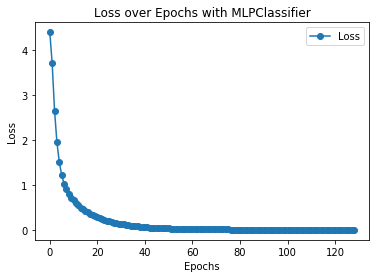

Plot for MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False) 


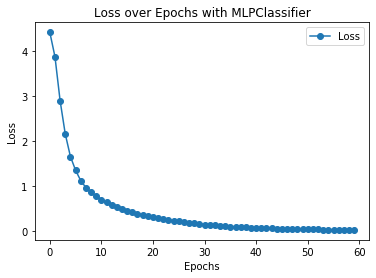

Plot for MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.5, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False) 


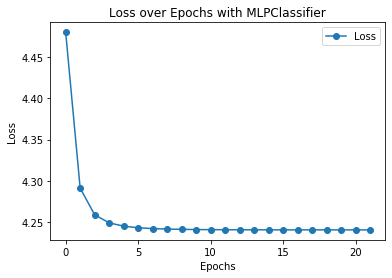

Plot for MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.5, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.3333333333333333, random_state=None, shuffle=True,
              solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False) 


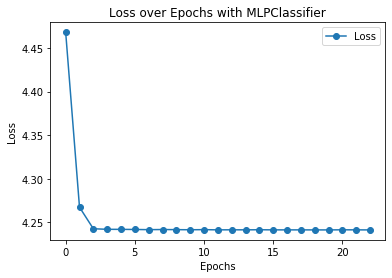

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False) 


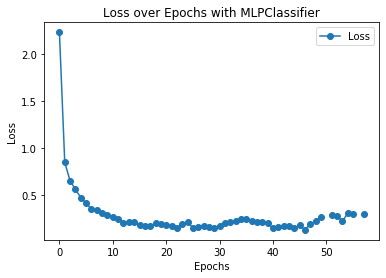

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=1e-06,
              validation_fraction=0.1, verbose=True, warm_start=False) 


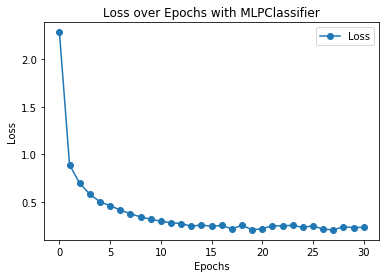

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=1e-06,
              validation_fraction=0.1, verbose=True, warm_start=False) 


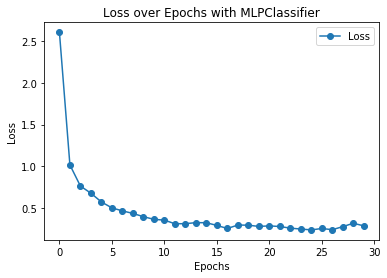

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.5, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=1e-06,
              validation_fraction=0.1, verbose=True, warm_start=False) 


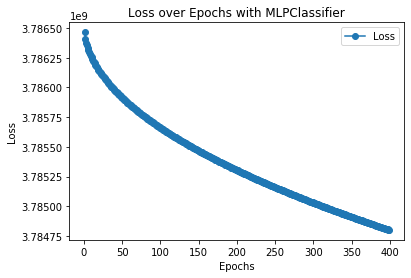

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.5, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.3333333333333333, random_state=None, shuffle=True,
              solver='sgd', tol=1e-06, validation_fraction=0.1, verbose=True,
              warm_start=False) 


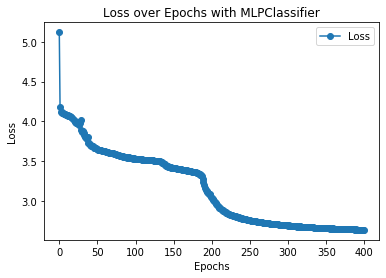

In [43]:
for i in range(len(clf)):
    print("Plot for {} ".format(clf[i]))
    fig = plt.figure(i)
    ax = fig.add_subplot(111)
    ax.plot(clf[i].loss_curve_, marker='o', label='Loss')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("Loss over Epochs with MLPClassifier")

    ax.legend()

    #plt.savefig("plots/parte/relu_e-8.png", dpi=1000, bbox_inches='tight')
    plt.show()

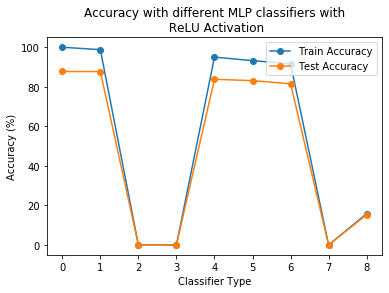

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with different MLP classifiers with\n ReLU Activation")
x=np.arange(len(clf))
ax.plot(x, train_accuracy, marker='o', label='Train Accuracy')
ax.plot(x, test_accuracy, marker='o', label='Test Accuracy')
ax.set_xlabel("Classifier Type")
ax.set_ylabel("Accuracy (%)")

plt.legend()
#plt.savefig("plots/parte/accuracy_mlp_relu.png", dpi=1000, bbox_inches='tight')
plt.show()

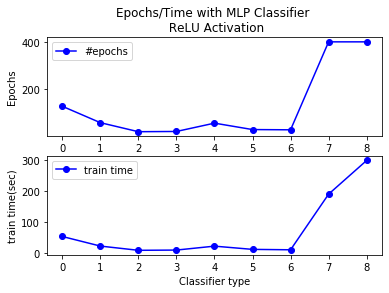

In [42]:
fig = plt.figure()
ax = fig.add_subplot(211)
plt.title("Epochs/Time with MLP Classifier \n ReLU Activation")
ax.plot(x, epochs, c='b', marker='o', label='#epochs')
ax.set_xlabel("Classifier Type")
ax.set_ylabel("Epochs")
ax.legend()

ax1 = fig.add_subplot(212)
ax1.plot(x, train_time, c='b', marker='o', label='train time')
ax1.set_xlabel("Classifier type")
ax1.set_ylabel("train time(sec)")
plt.legend()
#plt.savefig("plots/parte/epochs_time_relu.png", dpi=1000, bbox_inches='tight')
plt.show()